# Capstone Projekt Rossmann

# Predictive Modeling

## Selection of models that will be tested to predict the sales of Rossmann stores

I want to use:  
Linear Regression Models: 
- LinearRegression
- RidgeRegression
- LassoRegression

Tree-based Models:
- DecisionTreeRegressor
- RandomForestRegressor
- GradiantBoostingRegressor
- XGBRegressor

Support Vector Machines (SVM):
- SVR

Nearest Neighbors:
- KNN

Neural Networks:
- KerasRegressor
- MLPRegressor

Time Series Models:
- Prophet


## Definition of KPIs for model evaluation

- Mean Absolute Error (MAE): The average of the absolute differences between predictions and actual values. It gives an idea of the magnitude of the error, but no information about the direction (over or under predicting).
- Mean Squared Error (MSE): The average of the squared differences between predictions and actual values. It gives more weight to larger errors and is more useful in practice than MAE.
- Root Mean Squared Error (RMSE): The square root of the MSE, it is more interpretable than the MSE as it is in the same units as the response variable.
- R-squared (R2): The proportion of the variance in the dependent variable that is predictable from the independent variables. It provides an indication of the goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.
- Adjusted R-squared: The R-squared value adjusted for the number of predictors in the model. It is useful for comparing models with different numbers of predictors.


## Functions needed for testing

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas.api.types import infer_dtype

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor

from prophet import Prophet

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)

### Test models with test and tain data. Test includes the last 8 weeks from each store

In [4]:

## Test models with test and tain data. Test includes the last 8 weeks from each store


def build_neural_network(X_train):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def testModelsTestSplit8W(df, scaler):
    
	train_data = []
	test_data = []

	# Group by store and split into training and test data
	amount_test_weeks = 8
	for store_id, group in df.groupby('Store'):
		train_data.append(group[: -amount_test_weeks])
		test_data.append(group[-amount_test_weeks:])

	# Combine the list entries to one dataframe
	train_df = pd.concat(train_data)
	test_df = pd.concat(test_data)

	# Create feature and target data frames
	X_train = train_df.drop(columns=['Future_Sales'])
	y_train = train_df['Future_Sales']
	X_test = test_df.drop(columns=['Future_Sales'])
	y_test = test_df['Future_Sales']

	# Scaling of the data
	if scaler:
		print("Scaler applied")
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

	def adj_r2_score(model, X, y):
		n = X.shape[0]
		p = X.shape[1]
		r2 = r2_score(y, model.predict(X))
		return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

	# Defining the models to test
	models = [
		('LinearRegression', LinearRegression(n_jobs=-1)),
		('XGBRegressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=42, device="cuda")),
  		('XGBRegressor_grid', XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate= 0.01, max_depth= 5, n_estimators= 500, subsample= 0.8, random_state=42, n_jobs=-1, device="cuda")),
		#('GradientBoostingRegressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
  		#('NeuralNetwork', KerasRegressor(build_fn=build_neural_network(X_train), epochs=100, batch_size=10, verbose=0)),
  		#('MLPRegressor', MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, shuffle=False, random_state=42))
		#('RidgeRegression', Ridge(random_state=42)),
		#('LassoRegression', Lasso(random_state=42)),
		#('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
		#('RandomForestRegressor', RandomForestRegressor(n_jobs=-1, max_depth=10, random_state=42, n_estimators=100)),
		#('SVR', SVR()),
		#('KNN', KNeighborsRegressor())
	]

	results = []
	# Train models and calculate metrics
	for name, model in models:
		model.fit(X_train, y_train)
		y_train_pred = model.predict(X_train)
		y_test_pred = model.predict(X_test)

		results.append({
			'Model': name,
			'RMSE_Train': sqrt(mse(y_train, y_train_pred)),
			'MAE_Train': mae(y_train, y_train_pred),
			'R2_Train': r2_score(y_train, y_train_pred),
			'Adj_R2_Train': adj_r2_score(model, X_train, y_train),
			'RMSE_Test': sqrt(mse(y_test, y_test_pred)),
			'MAE_Test': mae(y_test, y_test_pred),
			'R2_Test': r2_score(y_test, y_test_pred),
			'Adj_R2_Test': adj_r2_score(model, X_test, y_test)
		})
		#print last result
		print(results[-1])

	results_df = pd.DataFrame(results)
	return results_df

### Cross Validation - Creates x splits in test and train where the last 8 weeks of each store are included in the respective test split and the splits are distributed evenly using gap

In [174]:
#Creates x splits in test and train where the last 8 weeks of each store are included in the respective test split and the splits are distributed
# evenly using gap

def testModelsCV8W(df, scaler):

    n_splits = 5
    window_size = 8
    total_weeks =109
    train_size = window_size / 0.2
    gap = int((total_weeks - window_size - train_size) // (n_splits))

    results = []

    for split in range(n_splits):
        train_data = []
        test_data = []

        for store_id, group in df.groupby('Store'):
            # calculate start and end index for test data
            if split == 0:
                test_start_index = -window_size
                test_df_store = group[test_start_index:] # no end index for the first split
            else:
                test_start_index = -(window_size + gap * split)
                test_end_index = test_start_index + window_size
                test_df_store = group[test_start_index:test_end_index]
                print("test:", test_df_store.shape, "Test Start Index:", test_start_index, "Test End Index:", test_end_index)
            
            train_start_index = -int(-test_start_index + gap + train_size)
            train_df_store = group[train_start_index:test_start_index]
            print("Train:", train_df_store.shape, "Train Start Index:", train_start_index, "Train End Index:", test_start_index)
            # Check if test set contains data
            if not test_df_store.empty:
                train_data.append(train_df_store)
                test_data.append(test_df_store)
            else:
                print(f"Store {store_id} has not enough data for splitting {split}")

        # Combine the list entries to one dataframe
        train_df_combined = pd.concat(train_data)
        test_df_combined = pd.concat(test_data)

        # Create feature and target data frames
        X_train = train_df_combined.drop(columns=['Future_Sales'])
        y_train = train_df_combined['Future_Sales']
        X_test = test_df_combined.drop(columns=['Future_Sales'])
        y_test = test_df_combined['Future_Sales']

        # Scaling of the data
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        def adj_r2_score(y_test_pred, X, y_test):
            n = X.shape[0]
            p = X.shape[1]
            r2 = r2_score(y_test, y_test_pred)
            return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    	# Defining the models to test
        models = [
		('LinearRegression', LinearRegression(n_jobs=-1)),
		('XGBRegressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=42, device="cuda")),
		#('GradientBoostingRegressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
  		#('NeuralNetwork', KerasRegressor(build_fn=build_neural_network(X_train), epochs=100, batch_size=10, verbose=0)),
  		#('MLPRegressor', MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, shuffle=False, random_state=42))
		#('RidgeRegression', Ridge(random_state=42)),
		#('LassoRegression', Lasso(random_state=42)),
		#('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
		#('RandomForestRegressor', RandomForestRegressor(n_jobs=-1, max_depth=10, random_state=42, n_estimators=100)),
		#('SVR', SVR()),
		#('KNN', KNeighborsRegressor())
        ]
        
        # Train models and calculate metrics
        for name, model in models:
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
        
            results.append({
                'Model': name,
                'RMSE_Train': sqrt(mse(y_train, y_train_pred)),
                'MAE_Train': mae(y_train, y_train_pred),
                'R2_Train': r2_score(y_train, y_train_pred),
                'Adj_R2_Train': adj_r2_score(y_test_pred, X_test, y_test),
                'RMSE_Test': sqrt(mse(y_test, y_test_pred)),
                'MAE_Test': mae(y_test, y_test_pred),
                'R2_Test': r2_score(y_test, y_test_pred),
                'Adj_R2_Test': adj_r2_score(y_test_pred, X_test, y_test)
            })
            #print last result
            print(results[-1])

    results_df = pd.DataFrame(results)

    # calculate mean of all splits
    model_list = results_df['Model'].unique()
    # create resulte_mean_df
    resulte_mean_df = pd.DataFrame(columns=results_df.columns)
    # iterate over model_list
    for model in model_list:
        # get mean of each model
        mean = results_df[results_df['Model'] == model].mean(numeric_only=True)
        mean['Model'] = model
        # append mean to resulte_mean_df
        resulte_mean_df = pd.concat([resulte_mean_df, pd.DataFrame([mean], columns=results_df.columns)], ignore_index=True)

    return results_df, resulte_mean_df


### Function to create a model for single store forecast

In [155]:
## Test models with test and tain data. Test includes the last 8 weeks from each store


def storeForecastTestSplit8W(model, df, scaler):
	train_data = []
	test_data = []

	# Group by store and split into training and test data
	amount_test_weeks = 8
	for store_id, group in df.groupby('Store'):
		train_data.append(group[: -amount_test_weeks])
		test_data.append(group[-amount_test_weeks:])

	# Combine the list entries to one dataframe
	train_df = pd.concat(train_data)
	test_df = pd.concat(test_data)

	# Create feature and target data frames
	X_train = train_df.drop(columns=['Future_Sales'])
	y_train = train_df['Future_Sales']
	X_test = test_df.drop(columns=['Future_Sales'])
	y_test = test_df['Future_Sales']

	# Scaling of the data
	if scaler:
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)
 
	# Train models and calculate metrics
	model.fit(X_train, y_train)
	return model, scaler

## Performance Reference (rolling mean)

In [108]:
df = pd.read_csv('df_nans_handeled_cat_power.csv')

### Performance Reference with one model for all stores

In [160]:

df_to_use = df[['Store', 'Future_Sales', 'Open', 'Promo', 'IsPromo', 'StateHoliday_b', 'Sales_Lag_1',
	'Sales_Lag_1_MA_6', 'Sales_Lag_1_MA_8', 'Sales_Lag_2_MA_8',
       'Sales_Lag_3_MA_8', 'Sales_Lag_5_MA_8', 'Sales_Lag_8_MA_8',
       'SalesPerCustomer_Lag_3_MA_6', 'SalesPerCustomer_Lag_8',
       'SalesPerOpenDay_Lag_1', 'SalesPerOpenDay_Lag_4_MA_6',
       'Customers_Lag_1_MA_6', 'Customers_Lag_3_MA_4', 'Customers_Lag_6',
       'Customers_Lag_8_MA_8', 'CustomersPerOpenDay_Lag_6']]

def adj_r2_score(r2, n, p):
    """
    Parameters:
    - r2: Das R^2 des Modells.
    - n: Die Anzahl der Beobachtungen.
    - p: Die Anzahl der erklärenden Variablen im Modell.
    """
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

amount_test_weeks = 8
rolling_mean_weeks = 4

# Defining the models to test
models = [
('LinearRegression', LinearRegression(n_jobs=-1)),
('XGBRegressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=42, device="cuda")),
#('GradientBoostingRegressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
#('NeuralNetwork', KerasRegressor(build_fn=build_neural_network(X_train), epochs=100, batch_size=10, verbose=0)),
#('MLPRegressor', MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, shuffle=False, random_state=42))
#('RidgeRegression', Ridge(random_state=42)),
#('LassoRegression', Lasso(random_state=42)),
#('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
#('RandomForestRegressor', RandomForestRegressor(n_jobs=-1, max_depth=10, random_state=42, n_estimators=100)),
#('SVR', SVR()),
#('KNN', KNeighborsRegressor())
]

results_df = []

for name, model in models:
    # Assuming storeForecastTestSplit8W is a function returning a fitted model and scaler for the entire dataset
    model, scaler = storeForecastTestSplit8W(model, df_to_use, MinMaxScaler())

    metrics = {'Model': name, 'Train_MAE': [], 'Train_R2': [], 'Train_Adj_R2': [], 'Test_MAE': [], 'Test_R2': [], 'Test_Adj_R2': [], 'Rolling_Mean_MAE': [], 'Rolling_Mean_R2': []}
    
    for store_id in df_to_use['Store'].unique():
        df_store = df_to_use[df_to_use['Store'] == store_id]
        
        # Calculate rolling mean for the entire store data
        rolling_mean = df_store['Future_Sales'].rolling(window=rolling_mean_weeks, min_periods=1).mean()

        # Split into training and test data using the last 8 weeks
        train_df = df_store[:-amount_test_weeks]
        test_df = df_store[-amount_test_weeks:]

        # Prepare features and targets
        X_train = train_df.drop(columns=['Future_Sales'])
        y_train = train_df['Future_Sales']
        X_test = test_df.drop(columns=['Future_Sales'])
        y_test = test_df['Future_Sales']

        # Scaling of the data
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Make predictions
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # Use rolling mean as predictions for baseline model
        y_train_baseline = rolling_mean.loc[train_df.index]
        y_test_baseline = rolling_mean.loc[test_df.index]

        # Calculate metrics for ML model
        train_mae = mae(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        train_adj_r2 = adj_r2_score(train_r2, y_train.shape[0], X_train.shape[1])
        
        test_mae = mae(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_adj_r2 = adj_r2_score(test_r2, y_test.shape[0], X_test.shape[1])

        # Calculate metrics for rolling mean baseline
        baseline_mae = mae(y_test, y_test_baseline)
        baseline_r2 = r2_score(y_test, y_test_baseline)
        
        # Store results
        metrics['Train_MAE'].append(train_mae)
        metrics['Train_R2'].append(train_r2)
        metrics['Train_Adj_R2'].append(train_adj_r2)
        metrics['Test_MAE'].append(test_mae)
        metrics['Test_R2'].append(test_r2)
        metrics['Test_Adj_R2'].append(test_adj_r2)
        metrics['Rolling_Mean_MAE'].append(baseline_mae)
        metrics['Rolling_Mean_R2'].append(baseline_r2)

    # Aggregate and append the results for the current model
    results_df.append({
        'Model': name,
        'Train_MAE': np.mean(metrics['Train_MAE']),
        'Train_R2': np.mean(metrics['Train_R2']),
        'Train_Adj_R2': np.mean(metrics['Train_Adj_R2']),
        'Test_MAE': np.mean(metrics['Test_MAE']),
        'Test_R2': np.mean(metrics['Test_R2']),
        'Test_Adj_R2': np.mean(metrics['Test_Adj_R2']),
        'Rolling_Mean_MAE': np.mean(metrics['Rolling_Mean_MAE']),
        'Rolling_Mean_R2': np.mean(metrics['Rolling_Mean_R2'])
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results_df)

results_df

c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [22:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


,Model,Train_MAE,Train_R2,Train_Adj_R2,Test_MAE,Test_R2,Test_Adj_R2,Rolling_Mean_MAE,Rolling_Mean_R2
0,LinearRegression,6673.629827,0.107103,-0.121566,4295.672176,0.161466,1.419267,5694.444367,0.025724
1,XGBRegressor,6669.648039,0.114468,-0.112315,4920.265378,0.126968,1.436516,5694.444367,0.025724


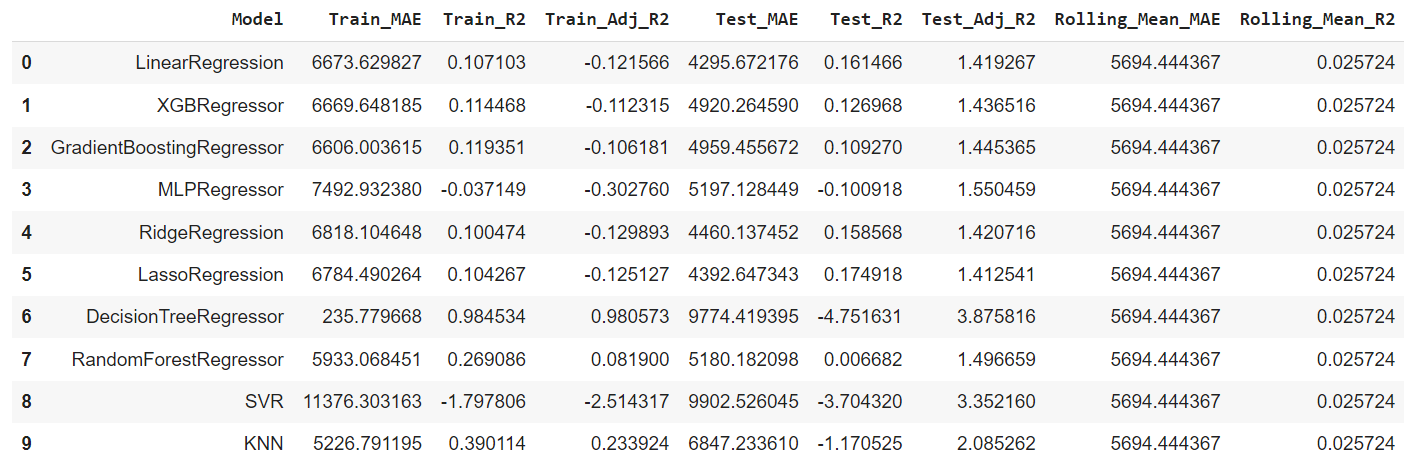

In [3]:
# Pre Test with 20 Features and MinMaxScaler (Single Store Metric)
from IPython.display import Image
Image('C:\\Users\\Chris\\OneDrive\\Arbeitslos\\Data Scientist\\7 Capstone Projekt - Ein Machine Learning Projekt von A bis Z\\Results - Test of 11 Models with 20 Features (Single Store Metric).png')


#### Performance Reference with own model for each store

In [153]:
df_to_use = df[['Store', 'Future_Sales', 'Open', 'Promo', 'IsPromo', 'StateHoliday_b', 'Sales_Lag_1',
	'Sales_Lag_1_MA_6', 'Sales_Lag_1_MA_8', 'Sales_Lag_2_MA_8',
       'Sales_Lag_3_MA_8', 'Sales_Lag_5_MA_8', 'Sales_Lag_8_MA_8',
       'SalesPerCustomer_Lag_3_MA_6', 'SalesPerCustomer_Lag_8',
       'SalesPerOpenDay_Lag_1', 'SalesPerOpenDay_Lag_4_MA_6',
       'Customers_Lag_1_MA_6', 'Customers_Lag_3_MA_4', 'Customers_Lag_6',
       'Customers_Lag_8_MA_8', 'CustomersPerOpenDay_Lag_6']]


def adj_r2_score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

amount_test_weeks = 8
rolling_mean_weeks = 4

models = [
    ('LinearRegression', LinearRegression(n_jobs=-1)),
    ('XGBRegressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, n_jobs=-1, random_state=42, device="cuda")),
    # Add 'Mean Model' as a placeholder for rolling mean calculations
    ('Mean Model', None),
]

results_df = []

scaler = MinMaxScaler()

for name, model in models:
    results = {'Train_R2': [], 'Train_Adj_R2': [], 'Train_MAE': [], 'Test_R2': [], 'Test_Adj_R2': [], 'Test_MAE': []}
    
    for store_id in df_to_use['Store'].unique():
        df_store = df_to_use[df_to_use['Store'] == store_id]
        
        # Calculate rolling mean for the entire dataset for this store
        entire_df_rolling_mean = df_store['Future_Sales'].rolling(window=rolling_mean_weeks, min_periods=1).mean()

        train_df = df_store[:-amount_test_weeks]
        test_df = df_store[-amount_test_weeks:]
        
        if name == 'Mean Model':
            # Use the pre-calculated rolling mean directly for train and test sets
            # Ensure the indices match for y_train and y_test with their respective predictions
            y_train_pred = entire_df_rolling_mean.loc[train_df.index]
            y_train = train_df['Future_Sales']
            
            y_test_pred = entire_df_rolling_mean.loc[test_df.index]
            y_test = test_df['Future_Sales']
        else:
            X_train = train_df.drop(columns=['Future_Sales']).dropna()
            y_train = train_df.loc[X_train.index, 'Future_Sales']
            X_test = test_df.drop(columns=['Future_Sales']).dropna()
            y_test = test_df.loc[X_test.index, 'Future_Sales']
            
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model.fit(X_train_scaled, y_train)
            
            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)

        # Calculate metrics for training and testing sets
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_mae = mae(y_train, y_train_pred)
        test_mae = mae(y_test, y_test_pred)
        
        if name != 'Mean Model':
            train_adj_r2 = adj_r2_score(train_r2, y_train.size, X_train.shape[1])
            test_adj_r2 = adj_r2_score(test_r2, y_test.size, X_test.shape[1])
        else:
            # Adjusted R2 is not applicable for the 'Mean Model'
            train_adj_r2 = np.nan
            test_adj_r2 = np.nan
        
        results['Train_R2'].append(train_r2)
        results['Train_Adj_R2'].append(train_adj_r2)
        results['Train_MAE'].append(train_mae)
        results['Test_R2'].append(test_r2)
        results['Test_Adj_R2'].append(test_adj_r2)
        results['Test_MAE'].append(test_mae)

    avg_results = {k: np.mean(v) for k, v in results.items()}
    avg_results['Model'] = name
    results_df.append(avg_results)

results_df = pd.DataFrame(results_df).fillna('N/A')
results_df

c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [22:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [22:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [22:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py

,Train_R2,Train_Adj_R2,Train_MAE,Test_R2,Test_Adj_R2,Test_MAE,Model
0,0.337336,0.16763,5910.366996,-0.552859,1.77643,5151.323838,LinearRegression
1,0.958393,0.947738,1300.982586,-1.564526,2.282263,6163.539893,XGBRegressor
2,0.347695,N/A,5844.124345,0.025724,N/A,5694.444367,Mean Model


**Result:**  
- The results with just one model for all stores are better than the results with a model for each store
- The MAE of the simple mean forecast by rolling 4 weeks is 5694
- The result of the LinearRegression model forecast is with MAE:4295 and R2: 0.161466 the best.
-> The model forecast is better (1399€/ -24,6%) then the simple mean forecast


## Pre-Test of different Models

In [6]:
df = pd.read_csv('df_nans_handeled_cat_power.csv')

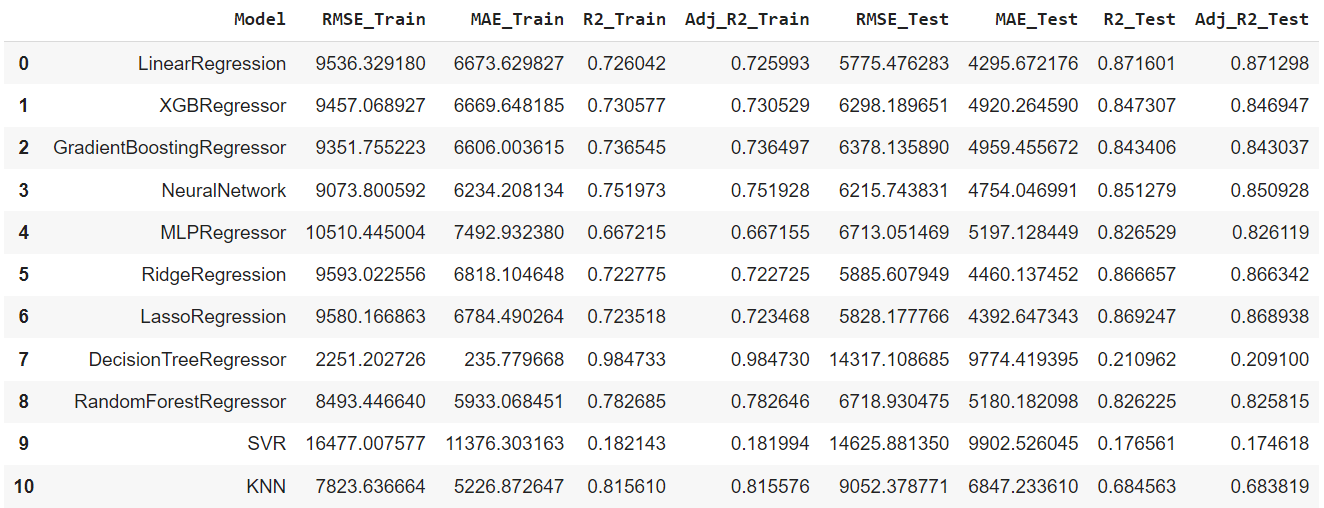

In [38]:
# Pre Test with 20 Features and MinMaxScaler and simple splitting train and test data for all stroes together
from IPython.display import Image
Image('C:\\Users\\Chris\\OneDrive\\Arbeitslos\\Data Scientist\\7 Capstone Projekt - Ein Machine Learning Projekt von A bis Z\\Results - Test of 11 Models with 20 Features.png')


In [9]:
pd.set_option('display.max_rows', 10000)

In [7]:
df.isna().sum()

Store                             0
CW                                0
Month                             0
Year                              0
Open                              0
                                 ..
CustomersPerOpenDay_Lag_8         0
CustomersPerOpenDay_Lag_8_MA_4    0
CustomersPerOpenDay_Lag_8_MA_6    0
CustomersPerOpenDay_Lag_8_MA_8    0
Future_Sales                      0
Length: 192, dtype: int64

### Feature Elimination

In [8]:
# Results with all features
testModelsTestSplit8W(df, MinMaxScaler())

Scaler applied
{'Model': 'LinearRegression', 'RMSE_Train': 9081.178921413037, 'MAE_Train': 6229.184072093825, 'R2_Train': 0.7515692210307627, 'Adj_R2_Train': 0.7511593471555716, 'RMSE_Test': 5941.163691018397, 'MAE_Test': 4395.438901345292, 'R2_Test': 0.8641279045091326, 'Adj_R2_Test': 0.8611545348667453}


c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [14:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor', 'RMSE_Train': 7410.980873242441, 'MAE_Train': 5030.000189809052, 'R2_Train': 0.8345478857952568, 'Adj_R2_Train': 0.8342749143885373, 'RMSE_Test': 6058.148984876124, 'MAE_Test': 4515.474892052621, 'R2_Test': 0.858724407972136, 'Adj_R2_Test': 0.8556327904105729}


c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [14:00:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor_grid', 'RMSE_Train': 6794.565583008348, 'MAE_Train': 4474.087838614279, 'R2_Train': 0.8609265186874501, 'Adj_R2_Train': 0.8606970681058499, 'RMSE_Test': 6232.247312329171, 'MAE_Test': 4603.617606808786, 'R2_Test': 0.8504878127705697, 'Adj_R2_Test': 0.8472159489116305}


,Model,RMSE_Train,MAE_Train,R2_Train,Adj_R2_Train,RMSE_Test,MAE_Test,R2_Test,Adj_R2_Test
0,LinearRegression,9081.178921,6229.184072,0.751569,0.751159,5941.163691,4395.438901,0.864128,0.861155
1,XGBRegressor,7410.980873,5030.000190,0.834548,0.834275,6058.148985,4515.474892,0.858724,0.855633
2,XGBRegressor_grid,6794.565583,4474.087839,0.860927,0.860697,6232.247312,4603.617607,0.850488,0.847216


In [9]:
testModelsTestSplit8W(df[['Store', 'Future_Sales', 'CW', 'Month', 'Open', 'Promo', 'IsPromo', 'IsSchoolHoliday',
       'StateHoliday_a', 'StateHoliday_b', 'Assortment_b', 'Assortment_c',
       'Sales_Lag_1', 'Sales_Lag_1_MA_6', 'Sales_Lag_1_MA_8',
       'Sales_Lag_2_MA_8', 'Sales_Lag_3', 'Sales_Lag_3_MA_8',
       'Sales_Lag_4_MA_4', 'Sales_Lag_5_MA_8', 'Sales_Lag_7_MA_8',
       'Sales_Lag_8_MA_8', 'SalesPerCustomer_Lag_3_MA_6',
       'SalesPerCustomer_Lag_4_MA_6', 'SalesPerCustomer_Lag_7',
       'SalesPerCustomer_Lag_8', 'SalesPerOpenDay_Lag_1',
       'SalesPerOpenDay_Lag_4_MA_6', 'SalesPerOpenDay_Lag_5_MA_8',
       'SalesPerOpenDay_Lag_7', 'Customers_Lag_1_MA_4', 'Customers_Lag_1_MA_6',
       'Customers_Lag_3_MA_4', 'Customers_Lag_4', 'Customers_Lag_4_MA_8',
       'Customers_Lag_6', 'Customers_Lag_7_MA_8', 'Customers_Lag_8_MA_8',
       'CustomersPerOpenDay_Lag_6', 'CustomersPerOpenDay_Lag_6_MA_4',
       'CustomersPerOpenDay_Lag_7_MA_4', 'CustomersPerOpenDay_Lag_8']], MinMaxScaler())

Scaler applied
{'Model': 'LinearRegression', 'RMSE_Train': 9243.960853576737, 'MAE_Train': 6346.849079061771, 'R2_Train': 0.7425830551488228, 'Adj_R2_Train': 0.7424920072120149, 'RMSE_Test': 6076.866293178483, 'MAE_Test': 4604.18222365417, 'R2_Test': 0.857850086874331, 'Adj_R2_Test': 0.8571936162234916}


c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [14:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor', 'RMSE_Train': 7586.747425730487, 'MAE_Train': 5128.276978852914, 'R2_Train': 0.8266067494562147, 'Adj_R2_Train': 0.8265454205575768, 'RMSE_Test': 6139.361351649675, 'MAE_Test': 4697.845359576443, 'R2_Test': 0.8549112868641222, 'Adj_R2_Test': 0.854241244372731}


c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [14:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor_grid', 'RMSE_Train': 7143.720043187459, 'MAE_Train': 4777.614334612462, 'R2_Train': 0.8462660487949659, 'Adj_R2_Train': 0.8462116733571615, 'RMSE_Test': 6588.582946658205, 'MAE_Test': 5147.650721473865, 'R2_Test': 0.8329019920174645, 'Adj_R2_Test': 0.8321303071416722}


,Model,RMSE_Train,MAE_Train,R2_Train,Adj_R2_Train,RMSE_Test,MAE_Test,R2_Test,Adj_R2_Test
0,LinearRegression,9243.960854,6346.849079,0.742583,0.742492,6076.866293,4604.182224,0.857850,0.857194
1,XGBRegressor,7586.747426,5128.276979,0.826607,0.826545,6139.361352,4697.845360,0.854911,0.854241
2,XGBRegressor_grid,7143.720043,4777.614335,0.846266,0.846212,6588.582947,5147.650721,0.832902,0.832130


In [10]:

testModelsTestSplit8W(df[['Store', 'Future_Sales', 'Open', 'Promo', 'IsPromo', 'StateHoliday_b', 'Sales_Lag_1',
       'Sales_Lag_1_MA_6', 'Sales_Lag_1_MA_8', 'Sales_Lag_2_MA_8',
       'Sales_Lag_3_MA_8', 'Sales_Lag_5_MA_8', 'Sales_Lag_8_MA_8',
       'SalesPerCustomer_Lag_3_MA_6', 'SalesPerCustomer_Lag_8',
       'SalesPerOpenDay_Lag_1', 'SalesPerOpenDay_Lag_4_MA_6',
       'Customers_Lag_1_MA_6', 'Customers_Lag_3_MA_4', 'Customers_Lag_6',
       'Customers_Lag_8_MA_8', 'CustomersPerOpenDay_Lag_6']], MinMaxScaler())

Scaler applied
{'Model': 'LinearRegression', 'RMSE_Train': 9536.329179581324, 'MAE_Train': 6673.629827190578, 'R2_Train': 0.7260423678114407, 'Adj_R2_Train': 0.7259927455109356, 'RMSE_Test': 5775.4762831794915, 'MAE_Test': 4295.6721755917715, 'R2_Test': 0.8716006437108907, 'Adj_R2_Test': 0.8712976108403501}


c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [14:03:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor', 'RMSE_Train': 9457.068947317517, 'MAE_Train': 6669.648039198498, 'R2_Train': 0.7305773851169427, 'Adj_R2_Train': 0.7305285842499919, 'RMSE_Test': 6298.190214583256, 'MAE_Test': 4920.265377574972, 'R2_Test': 0.8473071214064962, 'Adj_R2_Test': 0.8469467538575567}


c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [14:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor_grid', 'RMSE_Train': 9234.867751490798, 'MAE_Train': 6474.754588917429, 'R2_Train': 0.7430892380147797, 'Adj_R2_Train': 0.7430427034359385, 'RMSE_Test': 6288.75298016257, 'MAE_Test': 4914.484669501471, 'R2_Test': 0.8477643698672545, 'Adj_R2_Test': 0.8474050814616816}


,Model,RMSE_Train,MAE_Train,R2_Train,Adj_R2_Train,RMSE_Test,MAE_Test,R2_Test,Adj_R2_Test
0,LinearRegression,9536.329180,6673.629827,0.726042,0.725993,5775.476283,4295.672176,0.871601,0.871298
1,XGBRegressor,9457.068947,6669.648039,0.730577,0.730529,6298.190215,4920.265378,0.847307,0.846947
2,XGBRegressor_grid,9234.867751,6474.754589,0.743089,0.743043,6288.752980,4914.484670,0.847764,0.847405


In [178]:
result_df, result_mean = testModelsCV8W(df[['Store', 'Future_Sales', 'Open', 'Promo', 'IsPromo', 'StateHoliday_b', 'Sales_Lag_1',
       'Sales_Lag_1_MA_6', 'Sales_Lag_1_MA_8', 'Sales_Lag_2_MA_8',
       'Sales_Lag_3_MA_8', 'Sales_Lag_5_MA_8', 'Sales_Lag_8_MA_8',
       'SalesPerCustomer_Lag_3_MA_6', 'SalesPerCustomer_Lag_8',
       'SalesPerOpenDay_Lag_1', 'SalesPerOpenDay_Lag_4_MA_6',
       'Customers_Lag_1_MA_6', 'Customers_Lag_3_MA_4', 'Customers_Lag_6',
       'Customers_Lag_8_MA_8', 'CustomersPerOpenDay_Lag_6']], MinMaxScaler())
print("Result_mean:", result_mean)
result_df

Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: -8
Train: (52, 22) Train Start Index: -60 Train End Index: 

c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) Train Start Index: -72 Train End Index: -20
test: (8, 22) Test Start Index: -20 Test End Index: -12
Train: (52, 22) 

c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor', 'RMSE_Train': 10079.341107384458, 'MAE_Train': 6649.8464043833965, 'R2_Train': 0.7324267925563053, 'Adj_R2_Train': 0.7481473657383917, 'RMSE_Test': 8323.15648246845, 'MAE_Test': 6655.922918892762, 'R2_Test': 0.7487403588227615, 'Adj_R2_Test': 0.7481473657383917}
test: (8, 22) Test Start Index: -32 Test End Index: -24
Train: (52, 22) Train Start Index: -84 Train End Index: -32
test: (8, 22) Test Start Index: -32 Test End Index: -24
Train: (52, 22) Train Start Index: -84 Train End Index: -32
test: (8, 22) Test Start Index: -32 Test End Index: -24
Train: (52, 22) Train Start Index: -84 Train End Index: -32
test: (8, 22) Test Start Index: -32 Test End Index: -24
Train: (52, 22) Train Start Index: -84 Train End Index: -32
test: (8, 22) Test Start Index: -32 Test End Index: -24
Train: (52, 22) Train Start Index: -84 Train End Index: -32
test: (8, 22) Test Start Index: -32 Test End Index: -24
Train: (52, 22) Train Start Index: -84 Train End Index: -32
test: (8, 22) T

c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor', 'RMSE_Train': 9203.779062828593, 'MAE_Train': 5957.7934678080655, 'R2_Train': 0.7731257733558766, 'Adj_R2_Train': 0.09630742882921728, 'RMSE_Test': 15657.634402521715, 'MAE_Test': 9053.840946406206, 'R2_Test': 0.09843519472164775, 'Adj_R2_Test': 0.09630742882921728}
test: (8, 22) Test Start Index: -44 Test End Index: -36
Train: (52, 22) Train Start Index: -96 Train End Index: -44
test: (8, 22) Test Start Index: -44 Test End Index: -36
Train: (52, 22) Train Start Index: -96 Train End Index: -44
test: (8, 22) Test Start Index: -44 Test End Index: -36
Train: (52, 22) Train Start Index: -96 Train End Index: -44
test: (8, 22) Test Start Index: -44 Test End Index: -36
Train: (52, 22) Train Start Index: -96 Train End Index: -44
test: (8, 22) Test Start Index: -44 Test End Index: -36
Train: (52, 22) Train Start Index: -96 Train End Index: -44
test: (8, 22) Test Start Index: -44 Test End Index: -36
Train: (52, 22) Train Start Index: -96 Train End Index: -44
test: (8, 2

c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


{'Model': 'XGBRegressor', 'RMSE_Train': 9876.044631898656, 'MAE_Train': 6743.336878927768, 'R2_Train': 0.704299473072675, 'Adj_R2_Train': 0.868750016618244, 'RMSE_Test': 7552.425092141192, 'MAE_Test': 5850.035633959257, 'R2_Test': 0.8690590478606498, 'Adj_R2_Test': 0.868750016618244}
test: (8, 22) Test Start Index: -56 Test End Index: -48
Train: (52, 22) Train Start Index: -108 Train End Index: -56
test: (8, 22) Test Start Index: -56 Test End Index: -48
Train: (52, 22) Train Start Index: -108 Train End Index: -56
test: (8, 22) Test Start Index: -56 Test End Index: -48
Train: (52, 22) Train Start Index: -108 Train End Index: -56
test: (8, 22) Test Start Index: -56 Test End Index: -48
Train: (52, 22) Train Start Index: -108 Train End Index: -56
test: (8, 22) Test Start Index: -56 Test End Index: -48
Train: (52, 22) Train Start Index: -108 Train End Index: -56
test: (8, 22) Test Start Index: -56 Test End Index: -48
Train: (52, 22) Train Start Index: -108 Train End Index: -56
test: (8, 22)

c:\Users\Chris\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


,Model,RMSE_Train,MAE_Train,R2_Train,Adj_R2_Train,RMSE_Test,MAE_Test,R2_Test,Adj_R2_Test
0,LinearRegression,10173.094867,6696.569852,0.729651,8.536974e-01,6.157729e+03,4.441731e+03,8.540418e-01,8.536974e-01
1,XGBRegressor,9965.527271,6511.408327,0.740571,8.319024e-01,6.600476e+03,4.684788e+03,8.322982e-01,8.319024e-01
2,LinearRegression,9936.525631,6434.446275,0.739956,7.303165e-01,8.612753e+03,6.342802e+03,7.309515e-01,7.303165e-01
3,XGBRegressor,10079.341107,6649.846404,0.732427,7.481474e-01,8.323156e+03,6.655923e+03,7.487404e-01,7.481474e-01
4,LinearRegression,9050.473283,5671.209864,0.780621,1.849564e-01,1.486984e+04,8.689317e+03,1.868755e-01,1.849564e-01
5,XGBRegressor,9203.779063,5957.793468,0.773126,9.630743e-02,1.565763e+04,9.053841e+03,9.843519e-02,9.630743e-02
6,LinearRegression,9894.323893,6535.974032,0.703204,7.674620e-01,1.005272e+04,8.148525e+03,7.680095e-01,7.674620e-01
7,XGBRegressor,9876.044632,6743.336879,0.704299,8.687500e-01,7.552425e+03,5.850036e+03,8.690590e-01,8.687500e-01
8,LinearRegression,8243.017330,5863.316047,0.758863,-4.665781e+19,1.429441e+14,2.030580e+13,-4.654795e+19,-4.665781e+19
9,XGBRegressor,8209.356334,5949.823731,0.760829,3.443523e-01,1.694492e+04,1.068783e+04,3.458960e-01,3.443523e-01


### GridSearch for XGBRegressor

In [40]:
df = pd.read_csv('df_nans_handeled_cat_power_with_date.csv')
df = df.sort_values(by='Date')
df

,Store,Date,CW,Month,Year,Open,Promo,IsPromo,IsStateHoliday,SchoolHoliday,IsSchoolHoliday,NumStateHoliday,CompetitionDistance,IsCompetition,Promo2,Promo2Member,Promo2Active,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_0,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",Sales_Lag_1,Sales_Lag_1_MA_4,Sales_Lag_1_MA_6,Sales_Lag_1_MA_8,Sales_Lag_2,Sales_Lag_2_MA_4,Sales_Lag_2_MA_6,Sales_Lag_2_MA_8,Sales_Lag_3,Sales_Lag_3_MA_4,Sales_Lag_3_MA_6,Sales_Lag_3_MA_8,Sales_Lag_4,Sales_Lag_4_MA_4,Sales_Lag_4_MA_6,Sales_Lag_4_MA_8,Sales_Lag_5,Sales_Lag_5_MA_4,Sales_Lag_5_MA_6,Sales_Lag_5_MA_8,Sales_Lag_6,Sales_Lag_6_MA_4,Sales_Lag_6_MA_6,Sales_Lag_6_MA_8,Sales_Lag_7,Sales_Lag_7_MA_4,Sales_Lag_7_MA_6,Sales_Lag_7_MA_8,Sales_Lag_8,Sales_Lag_8_MA_4,Sales_Lag_8_MA_6,Sales_Lag_8_MA_8,SalesPerCustomer_Lag_1,SalesPerCustomer_Lag_1_MA_4,SalesPerCustomer_Lag_1_MA_6,SalesPerCustomer_Lag_1_MA_8,SalesPerCustomer_Lag_2,SalesPerCustomer_Lag_2_MA_4,SalesPerCustomer_Lag_2_MA_6,SalesPerCustomer_Lag_2_MA_8,SalesPerCustomer_Lag_3,SalesPerCustomer_Lag_3_MA_4,SalesPerCustomer_Lag_3_MA_6,SalesPerCustomer_Lag_3_MA_8,SalesPerCustomer_Lag_4,SalesPerCustomer_Lag_4_MA_4,SalesPerCustomer_Lag_4_MA_6,SalesPerCustomer_Lag_4_MA_8,SalesPerCustomer_Lag_5,SalesPerCustomer_Lag_5_MA_4,SalesPerCustomer_Lag_5_MA_6,SalesPerCustomer_Lag_5_MA_8,SalesPerCustomer_Lag_6,SalesPerCustomer_Lag_6_MA_4,SalesPerCustomer_Lag_6_MA_6,SalesPerCustomer_Lag_6_MA_8,SalesPerCustomer_Lag_7,SalesPerCustomer_Lag_7_MA_4,SalesPerCustomer_Lag_7_MA_6,SalesPerCustomer_Lag_7_MA_8,SalesPerCustomer_Lag_8,SalesPerCustomer_Lag_8_MA_4,SalesPerCustomer_Lag_8_MA_6,SalesPerCustomer_Lag_8_MA_8,SalesPerOpenDay_Lag_1,SalesPerOpenDay_Lag_1_MA_4,SalesPerOpenDay_Lag_1_MA_6,SalesPerOpenDay_Lag_1_MA_8,SalesPerOpenDay_Lag_2,SalesPerOpenDay_Lag_2_MA_4,SalesPerOpenDay_Lag_2_MA_6,SalesPerOpenDay_Lag_2_MA_8,SalesPerOpenDay_Lag_3,SalesPerOpenDay_Lag_3_MA_4,SalesPerOpenDay_Lag_3_MA_6,SalesPerOpenDay_Lag_3_MA_8,SalesPerOpenDay_Lag_4,SalesPerOpenDay_Lag_4_MA_4,SalesPerOpenDay_Lag_4_MA_6,SalesPerOpenDay_Lag_4_MA_8,SalesPerOpenDay_Lag_5,SalesPerOpenDay_Lag_5_MA_4,SalesPerOpenDay_Lag_5_MA_6,SalesPerOpenDay_Lag_5_MA_8,SalesPerOpenDay_Lag_6,SalesPerOpenDay_Lag_6_MA_4,SalesPerOpenDay_Lag_6_MA_6,SalesPerOpenDay_Lag_6_MA_8,SalesPerOpenDay_Lag_7,SalesPerOpenDay_Lag_7_MA_4,SalesPerOpenDay_Lag_7_MA_6,SalesPerOpenDay_Lag_7_MA_8,SalesPerOpenDay_Lag_8,SalesPerOpenDay_Lag_8_MA_4,SalesPerOpenDay_Lag_8_MA_6,SalesPerOpenDay_Lag_8_MA_8,Customers_Lag_1,Customers_Lag_1_MA_4,Customers_Lag_1_MA_6,Customers_Lag_1_MA_8,Customers_Lag_2,Customers_Lag_2_MA_4,Customers_Lag_2_MA_6,Customers_Lag_2_MA_8,Customers_Lag_3,Customers_Lag_3_MA_4,Customers_Lag_3_MA_6,Customers_Lag_3_MA_8,Customers_Lag_4,Customers_Lag_4_MA_4,Customers_Lag_4_MA_6,Customers_Lag_4_MA_8,Customers_Lag_5,Customers_Lag_5_MA_4,Customers_Lag_5_MA_6,Customers_Lag_5_MA_8,Customers_Lag_6,Customers_Lag_6_MA_4,Customers_Lag_6_MA_6,Customers_Lag_6_MA_8,Customers_Lag_7,Customers_Lag_7_MA_4,Customers_Lag_7_MA_6,Customers_Lag_7_MA_8,Customers_Lag_8,Customers_Lag_8_MA_4,Customers_Lag_8_MA_6,Customers_Lag_8_MA_8,CustomersPerOpenDay_Lag_1,CustomersPerOpenDay_Lag_1_MA_4,CustomersPerOpenDay_Lag_1_MA_6,CustomersPerOpenDay_Lag_1_MA_8,CustomersPerOpenDay_Lag_2,CustomersPerOpenDay_Lag_2_MA_4,CustomersPerOpenDay_Lag_2_MA_6,CustomersPerOpenDay_Lag_2_MA_8,CustomersPerOpenDay_Lag_3,CustomersPerOpenDay_Lag_3_MA_4,CustomersPerOpenDay_Lag_3_MA_6,CustomersPerOpenDay_Lag_3_MA_8,CustomersPerOpenDay_Lag_4,CustomersPerOpenDay_Lag_4_MA_4,CustomersPerOpenDay_Lag_4_MA_6,CustomersPerOpenDay_Lag_4_MA_8,CustomersPerOpenDay_Lag_5,CustomersPerOpenDay_Lag_5_MA_4,CustomersPerOpenDay_Lag_5_MA_6,CustomersPerOpenDay_Lag_5_MA_8,CustomersPerOpenDay_Lag_6,CustomersPerOpenDay_Lag_6_MA_4,CustomersPerOpenDay_Lag_6_MA_6,CustomersPerOpenDay_Lag_6_MA_8,CustomersPerOpenDay_Lag_7,CustomersPe

In [42]:
#Find best hyperparameters for XGBRegressor

df_to_use = df[['Store', 'Future_Sales', 'Open', 'Promo', 'IsPromo', 'StateHoliday_b', 'Sales_Lag_1',
       'Sales_Lag_1_MA_6', 'Sales_Lag_1_MA_8', 'Sales_Lag_2_MA_8',
       'Sales_Lag_3_MA_8', 'Sales_Lag_5_MA_8', 'Sales_Lag_8_MA_8',
       'SalesPerCustomer_Lag_3_MA_6', 'SalesPerCustomer_Lag_8',
       'SalesPerOpenDay_Lag_1', 'SalesPerOpenDay_Lag_4_MA_6',
       'Customers_Lag_1_MA_6', 'Customers_Lag_3_MA_4', 'Customers_Lag_6',
       'Customers_Lag_8_MA_8', 'CustomersPerOpenDay_Lag_6']]
 
X_train = df_to_use.drop(columns=['Future_Sales'])
y_train = df_to_use['Future_Sales']

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

# Define your XGBRegressor model
model = XGBRegressor(random_state=42)

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Define your scoring function, e.g., negative mean squared error
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring=scorer, n_jobs=-1)

# Assume X_train, y_train are your features and targets
# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best score found:  -135745424.80994418


## Forecast of single store

### Linear Regression

In [165]:
store_id =41
amount_test_weeks = 8

model = LinearRegression(n_jobs=-1)

model, scaler = storeForecastTestSplit8W(model, df, MinMaxScaler())

df_store = df[df['Store'] == store_id]

# Split into training and test data unsing the last 8 weeks
train_df = df_store[: -amount_test_weeks]
test_df = df_store[-amount_test_weeks:]

# Create feature and target data frames
X_train = train_df.drop(columns=['Future_Sales'])
y_train = train_df['Future_Sales']
X_test = test_df.drop(columns=['Future_Sales'])
y_test = test_df['Future_Sales']

# Scaling of the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

def adj_r2_score(model, X, y):
		n = X.shape[0]
		p = X.shape[1]
		r2 = r2_score(y, model.predict(X))
		return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

results = []	
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
results.append({
	'RMSE_Train': sqrt(mse(y_train, y_train_pred)),
	'MAE_Train': mae(y_train, y_train_pred),
	'R2_Train': r2_score(y_train, y_train_pred),
	'Adj_R2_Train': adj_r2_score(model, X_train, y_train),
	'RMSE_Test': sqrt(mse(y_test, y_test_pred)),
	'MAE_Test': mae(y_test, y_test_pred),
	'R2_Test': r2_score(y_test, y_test_pred),
	'Adj_R2_Test': adj_r2_score(model, X_test, y_test)
})
#print last result
print(results[-1])

results_df = pd.DataFrame(results)
results_df


{'RMSE_Train': 10542.103962299132, 'MAE_Train': 6884.336538461538, 'R2_Train': 0.47755307285600246, 'Adj_R2_Train': 1.6115003806344517, 'RMSE_Test': 3413.531181196387, 'MAE_Test': 2774.625, 'R2_Test': 0.2631014450157768, 'Adj_R2_Test': 1.0280341841570084}


,RMSE_Train,MAE_Train,R2_Train,Adj_R2_Train,RMSE_Test,MAE_Test,R2_Test,Adj_R2_Test
0,10542.103962,6884.336538,0.477553,1.6115,3413.531181,2774.625,0.263101,1.028034


In [166]:
# Convert predictions to pandas Series
y_train_pred_series = pd.Series(y_train_pred, index=y_train.index, name='y_train_pred')
y_test_pred_series = pd.Series(y_test_pred, index=y_test.index, name='y_test_pred')

# Combine the predictions and actuals into one DataFrame
combined_df = pd.concat([y_train, y_train_pred_series, y_test, y_test_pred_series], axis=1)

#combined_df['neue_spalte'] = np.where(pd.notnull(combined_df[0]), combined_df[0], combined_df[2])
combined_df['Future_Sales_comb'] = df_store = df[df['Store'] == store_id]['Future_Sales']

rolling_mean_weeks = 4
combined_df['Future_Sales_rolling_mean'] = combined_df['Future_Sales_comb'].rolling(rolling_mean_weeks).mean()

# Calculate difference of wrong prediction
combined_df['Diff_model'] = combined_df['y_test_pred'] - combined_df['Future_Sales_comb']
combined_df['Diff_mean'] = np.where(
    combined_df['y_test_pred'].notna(),
    combined_df['Future_Sales_rolling_mean'] - combined_df['Future_Sales_comb'],
    np.nan
)

print("mean of Diff_model:", abs(combined_df['Diff_model']).mean())
print("mean of Diff_mean:", abs(combined_df['Diff_mean']).mean())

combined_df

meand of Diff_model: 2774.625
meand of Diff_mean: 3276.1875


,Future_Sales,y_train_pred,Future_Sales,y_test_pred,Future_Sales_comb,Future_Sales_rolling_mean,Diff_model,Diff_mean
4480,23091.0,22322.0,NaN,NaN,23091.0,NaN,NaN,NaN
4481,26625.0,26726.0,NaN,NaN,26625.0,NaN,NaN,NaN
4482,24463.0,22212.0,NaN,NaN,24463.0,NaN,NaN,NaN
4483,29626.0,21624.0,NaN,NaN,29626.0,25951.25,NaN,NaN
4484,21230.0,25898.0,NaN,NaN,21230.0,25486.00,NaN,NaN
...,...,...,...,...,...,...,...,...
4587,NaN,NaN,39068.0,34774.0,39068.0,35721.50,-4294.0,-3346.50
4588,NaN,NaN,28669.0,29940.0,28669.0,34943.00,1271.0,6274.00
4589,NaN,NaN,35523.0,34674.0,35523.0,33588.50,-849.0,-1934.50
4590,NaN,NaN,32020.0,30578.0,32020.0,33820.00,-1442.0,1800.00


### Prophet

In [11]:
df = pd.read_csv('weekly_sales_with_store_info.csv')
df['Date'] = pd.to_datetime(df['Date'])

14:29:42 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1491.1664582207595
R2: 0.8942570232884655


,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-06-14,30266.887839,28297.611652,32244.164329,30366
2015-06-21,41971.308247,39946.353986,44030.449346,41807
2015-06-28,30775.988672,28601.652559,32725.795361,28618
2015-07-05,41879.585548,39825.792938,43948.496572,45770
2015-07-12,30461.332996,28456.191396,32464.929043,32638
2015-07-19,41733.235994,39589.724198,43849.151440,41183
2015-07-26,30098.609968,28032.219877,32056.542613,31599
2015-08-02,36045.784897,33892.530189,38180.999783,37436


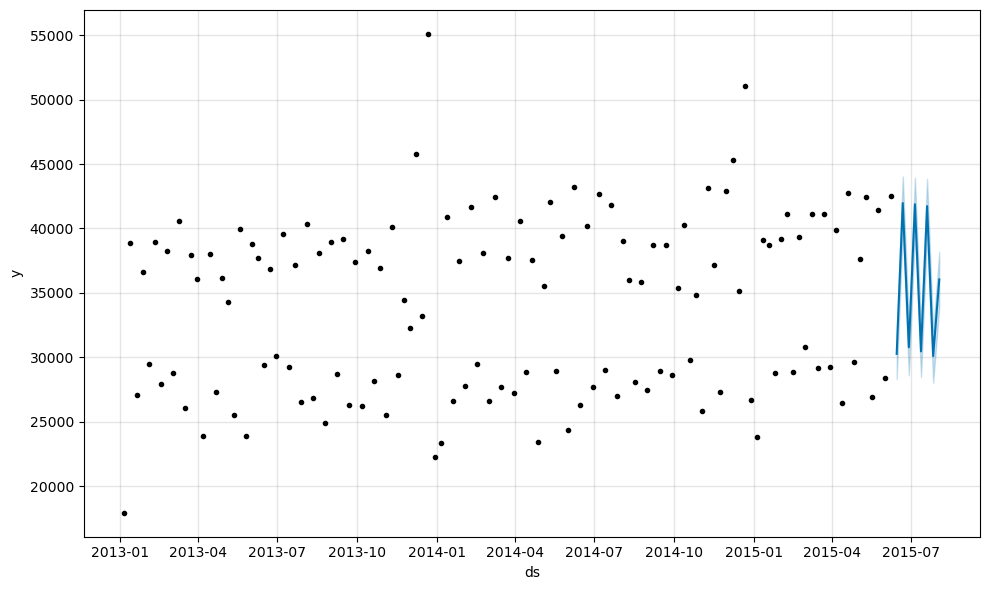

In [17]:
df_store = df[df['Store'] == 836]
df_store = df_store[['Date', 'Sales', 'IsPromo', 'IsStateHoliday', 'NumStateHoliday', 'Open']]

amount_test_weeks = 8
df_prophet = df_store.rename(columns={'Date': 'ds', 'Sales': 'y'})
df_train = df_prophet[: -amount_test_weeks]
df_test = df_prophet[-amount_test_weeks:]#.drop(columns=['y'])


model = Prophet()
model.add_regressor('IsPromo')
model.add_regressor('IsStateHoliday')
model.add_regressor('NumStateHoliday')
model.add_regressor('Open')
model.fit(df_train)

#future = model.make_future_dataframe(periods=8, freq='W')
forecast = model.predict(df_test)
fig = model.plot(forecast)
results = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_test.set_index('ds')['y'])

y_true = df_test['y'].reset_index(drop=True)
y_pred = forecast['yhat'].reset_index(drop=True)

mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)

r2 = r2_score(y_true, y_pred)
print("R2:", r2)

results

In [9]:
df[df['Store'] == 836]

,Store,Date,CW,Month,Year,DayOfWeek,Sales,SalesPerCustomer,SalesPerOpenDay,Customers,CustomersPerOpenDay,Open,Promo,IsPromo,StateHoliday,IsStateHoliday,SchoolHoliday,IsSchoolHoliday,NumStateHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,IsCompetition,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Promo2Member,Promo2Active
112725,836,2013-01-06,1,1,2013,6,17937,7.171931,4484.250000,2501,625.250000,4,0,0,a,1,2,1,1,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
112726,836,2013-01-13,2,1,2013,6,38907,8.141243,6484.500000,4779,796.500000,6,5,1,0,0,0,0,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
112727,836,2013-01-20,3,1,2013,6,27071,7.213163,4511.833333,3753,625.500000,6,0,0,0,0,0,0,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
112728,836,2013-01-27,4,1,2013,6,36644,8.402660,6107.333333,4361,726.833333,6,5,1,0,0,0,0,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
112729,836,2013-02-03,5,2,2013,6,29513,7.618224,4918.833333,3874,645.666667,6,0,0,0,0,0,0,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112855,836,2015-07-05,27,7,2015,6,45770,9.734156,7628.333333,4702,783.666667,6,5,1,0,0,0,0,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
112856,836,2015-07-12,28,7,2015,6,32638,8.260693,5439.666667,3951,658.500000,6,0,0,0,0,0,0,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
112857,836,2015-07-19,29,7,2015,6,41183,9.159920,6863.833333,4496,749.333333,6,5,1,0,0,5,1,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0
112858,836,2015-07-26,30,7,2015,6,31599,8.638327,5266.500000,3658,609.666667,6,0,0,0,0,5,1,0,a,a,2720.0,9.0,2012.0,1,0,NaN,NaN,NaN,0,0


In [10]:
# Cross validation for a single store
from prophet.diagnostics import cross_validation

df_store = df[df['Store'] == 836]
df_store = df_store[['Date', 'Sales', 'IsPromo', 'IsStateHoliday', 'NumStateHoliday', 'Open']]

amount_test_weeks = 8
df_prophet = df_store.rename(columns={'Date': 'ds', 'Sales': 'y'})
df_train = df_prophet[: -amount_test_weeks]
df_test = df_prophet[-amount_test_weeks:]#.drop(columns=['y'])


model = Prophet()
model.add_regressor('IsPromo')
model.add_regressor('IsStateHoliday')
model.add_regressor('NumStateHoliday')
model.add_regressor('Open')
model.fit(df_train)

df_cv = cross_validation(model, 
                         initial='547 days',  # z.B. für die ersten zwei Jahre an Daten
                         period='90 days',  # Cross-Validation alle halben Jahre
                         horizon='56 days')  # Vorhersagehorizont von einem Jahr



# Initialisierung von Listen, um die Metriken zu speichern
mae_per_cutoff = []
r2_per_cutoff = []

# Iteriere durch jeden einzigartigen Cutoff
for cutoff in df_cv['cutoff'].unique():
    # Filtere die Zeilen, die zum aktuellen Cutoff gehören
    df_cutoff = df_cv[df_cv['cutoff'] == cutoff]
    
    # Extrahiere die tatsächlichen und vorhergesagten Werte
    y_true = df_cutoff['y']
    y_pred = df_cutoff['yhat']
    
    # Berechne MAE und R2 für den aktuellen Cutoff
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Füge die berechneten Metriken zu den Listen hinzu
    mae_per_cutoff.append(mae)
    r2_per_cutoff.append(r2)

# Optional: Berechne den Durchschnitt der Metriken über alle Cutoffs
average_mae = np.mean(mae_per_cutoff)
average_r2 = np.mean(r2_per_cutoff)

print("Durchschnittlicher MAE über alle Cutoffs:", average_mae)
print("Durchschnittlicher R2 über alle Cutoffs:", average_r2)

df_cv

#future = model.make_future_dataframe(periods=8, freq='W')
#forecast = model.predict(df_test)
#fig = model.plot(forecast)
#results = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_test.set_index('ds')['y'])
#print("Mean of Diff_model:", abs(results['yhat'] - results['y']).mean())
#
#
#from sklearn.metrics import mean_absolute_error, r2_score
#y_true = df_test['y'].reset_index(drop=True)
#y_pred = forecast['yhat'].reset_index(drop=True)
#
#mae = mean_absolute_error(y_true, y_pred)
#print("MAE:", mae)
#
#r2 = r2_score(y_true, y_pred)
#print("R2:", r2)
#
#
#results

18:49:13 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:49:13 - cmdstanpy - INFO - Chain [1] start processing
18:49:14 - cmdstanpy - INFO - Chain [1] done processing
18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:14 - cmdstanpy - INFO - Chain [1] done processing
18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing
18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing


Durchschnittlicher MAE über alle Cutoffs: 1459.0595451752865
Durchschnittlicher R2 über alle Cutoffs: 0.9157042047094475


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-07-20,40512.650208,38357.521338,42410.294019,41804,2014-07-16
1,2014-07-27,28950.911637,27001.854569,30949.904302,27037,2014-07-16
2,2014-08-03,39896.478315,37980.305407,41857.346861,39041,2014-07-16
3,2014-08-10,39131.475839,37045.787333,41028.720866,36025,2014-07-16
4,2014-08-17,27353.776594,25248.210445,29314.982918,28112,2014-07-16
5,2014-08-24,39306.459041,37167.869987,41462.416468,35854,2014-07-16
6,2014-08-31,28427.940732,26301.612822,30510.923951,27464,2014-07-16
7,2014-09-07,40090.101445,38115.218498,42242.627868,38687,2014-07-16
8,2014-10-19,28245.431582,26310.728008,30228.254864,29806,2014-10-14
9,2014-10-26,39675.203328,37586.853935,41639.417907,34861,2014-10-14


In [11]:
# Cross validation for all stores
from prophet.diagnostics import cross_validation

MAE_all_stores = []
R2_all_stores = []

for store_id in df['Store'].unique():

    df_store = df[df['Store'] == store_id]
    df_store = df_store[['Date', 'Sales', 'IsPromo', 'IsStateHoliday', 'NumStateHoliday', 'Open']]

    amount_test_weeks = 8
    df_prophet = df_store.rename(columns={'Date': 'ds', 'Sales': 'y'})
    df_train = df_prophet[: -amount_test_weeks]
    df_test = df_prophet[-amount_test_weeks:]#.drop(columns=['y'])


    model = Prophet()
    model.add_regressor('IsPromo')
    model.add_regressor('IsStateHoliday')
    model.add_regressor('NumStateHoliday')
    model.add_regressor('Open')
    model.fit(df_train)

    df_cv = cross_validation(model, 
                             initial='547 days',  # z.B. für die ersten zwei Jahre an Daten
                             period='90 days',  # Cross-Validation alle halben Jahre
                             horizon='56 days')  # Vorhersagehorizont von einem Jahr



    # Initialisierung von Listen, um die Metriken zu speichern
    mae_per_cutoff = []
    r2_per_cutoff = []

    # Iteriere durch jeden einzigartigen Cutoff
    for cutoff in df_cv['cutoff'].unique():
        # Filtere die Zeilen, die zum aktuellen Cutoff gehören
        df_cutoff = df_cv[df_cv['cutoff'] == cutoff]

        # Extrahiere die tatsächlichen und vorhergesagten Werte
        y_true = df_cutoff['y']
        y_pred = df_cutoff['yhat']

        # Berechne MAE und R2 für den aktuellen Cutoff
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Füge die berechneten Metriken zu den Listen hinzu
        mae_per_cutoff.append(mae)
        r2_per_cutoff.append(r2)

    # Optional: Berechne den Durchschnitt der Metriken über alle Cutoffs
    average_mae = np.mean(mae_per_cutoff)
    average_r2 = np.mean(r2_per_cutoff)
    MAE_all_stores.append(average_mae)
    R2_all_stores.append(average_r2)

print("Durchschnittlicher MAE über alle Cutoffs und stores:", MAE_all_stores.mean())
print("Durchschnittlicher R2 über alle Cutoffs:", R2_all_stores.mean())





18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1] done processing
18:49:53 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing
18:50:00 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing
18:50:00 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:00 - cmdstanpy - INFO - Chain [1] start processing
18:50:01 - cmdstanpy - INFO - Chain [1] done processing
18:50:01 - cmdstanpy - INFO - Chain [1] start processing
18:50:01 - cmdstanpy - INFO - Chain [1] done processing
18:50:01 - cmdstanpy - INFO - Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing
18:50:02 - cmdstanpy - INFO - Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing
18:50:02 - cmdstanpy - INFO - Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:02 - cmdstanpy - INFO - Chain [1] start processing
18:50:03 - cmdstanpy - INFO - Chain [1] done processing
18:50:03 - cmdstanpy - INFO - Chain [1] start processing
18:50:03 - cmdstanpy - INFO - Chain [1] done processing
18:50:03 - cmdstanpy - INFO - Chain [1] start processing
18:50:03 - cmdstanpy - INFO - Chain [1] done processing
18:50:03 - cmdstanpy - INFO - Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing
18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing
18:50:05 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing
18:50:05 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing
18:50:05 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing
18:50:06 - cmdstanpy - INFO - Chain [1] start processing
18:50:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:06 - cmdstanpy - INFO - Chain [1] start processing
18:50:06 - cmdstanpy - INFO - Chain [1] done processing
18:50:06 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing
18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing
18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing
18:50:08 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:08 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing
18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing
18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing
18:50:16 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing
18:50:16 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:16 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing
18:50:19 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing
18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:20 - cmdstanpy - INFO - Chain [1] done processing
18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:20 - cmdstanpy - INFO - Chain [1] done processing
18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:21 - cmdstanpy - INFO - Chain [1] done processing
18:50:21 - cmdstanpy - INFO - Chain [1] start processing
18:50:21 - cmdstanpy - INFO - Chain [1] done processing
18:50:21 - cmdstanpy - INFO - Chain [1] start processing
18:50:21 - cmdstanpy - INFO - Chain [1] done processing
18:50:22 - cmdstanpy - INFO - Chain [1] start processing
18:50:22 - cmdstanpy - INFO - Chain [1] done processing
18:50:22 - cmdstanpy - INFO - Chain [1] start processing
18:50:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:22 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing
18:50:23 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing
18:50:23 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing
18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] done processing
18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:26 - cmdstanpy - INFO - Chain [1] start processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:26 - cmdstanpy - INFO - Chain [1] start processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing
18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1] done processing
18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:28 - cmdstanpy - INFO - Chain [1] done processing
18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:28 - cmdstanpy - INFO - Chain [1] done processing
18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
18:50:29 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:31 - cmdstanpy - INFO - Chain [1] start processing
18:50:31 - cmdstanpy - INFO - Chain [1] done processing
18:50:31 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing
18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing
18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing
18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:33 - cmdstanpy - INFO - Chain [1] done processing
18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing
18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing
18:50:37 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing
18:50:38 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing
18:50:38 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing
18:50:38 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:39 - cmdstanpy - INFO - Chain [1] done processing
18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing
18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:41 - cmdstanpy - INFO - Chain [1] done processing
18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:41 - cmdstanpy - INFO - Chain [1] done processing
18:50:42 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing
18:50:42 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing
18:50:42 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:42 - cmdstanpy - INFO - Chain [1] start processing
18:50:43 - cmdstanpy - INFO - Chain [1] done processing
18:50:43 - cmdstanpy - INFO - Chain [1] start processing
18:50:43 - cmdstanpy - INFO - Chain [1] done processing
18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:44 - cmdstanpy - INFO - Chain [1] done processing
18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:44 - cmdstanpy - INFO - Chain [1] done processing
18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing
18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing
18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing
18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing
18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:49 - cmdstanpy - INFO - Chain [1] done processing
18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:49 - cmdstanpy - INFO - Chain [1] done processing
18:50:50 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing
18:50:50 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing
18:50:50 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:50 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing
18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing
18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1] done processing
18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1] done processing
18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:53 - cmdstanpy - INFO - Chain [1] done processing
18:50:53 - cmdstanpy - INFO - Chain [1] start processing
18:50:53 - cmdstanpy - INFO - Chain [1] done processing
18:50:53 - cmdstanpy - INFO - Chain [1] start processing
18:50:53 - cmdstanpy - INFO - Chain [1] done processing
18:50:54 - cmdstanpy - INFO - Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing
18:50:54 - cmdstanpy - INFO - Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:54 - cmdstanpy - INFO - Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing
18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing
18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing
18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:51:00 - cmdstanpy - INFO - Chain [1] done processing
18:51:00 - cmdstanpy - INFO - Chain [1] start processing
18:51:00 - cmdstanpy - INFO - Chain [1] done processing
18:51:00 - cmdstanpy - INFO - Chain [1] start processing
18:51:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:00 - cmdstanpy - INFO - Chain [1] start processing
18:51:01 - cmdstanpy - INFO - Chain [1] done processing
18:51:01 - cmdstanpy - INFO - Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1] done processing
18:51:02 - cmdstanpy - INFO - Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1] done processing
18:51:02 - cmdstanpy - INFO - Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1] done processing
18:51:02 - cmdstanpy - INFO - Chain [1] start processing
18:51:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] done processing
18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] done processing
18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:07 - cmdstanpy - INFO - Chain [1] start processing
18:51:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:07 - cmdstanpy - INFO - Chain [1] start processing
18:51:08 - cmdstanpy - INFO - Chain [1] done processing
18:51:08 - cmdstanpy - INFO - Chain [1] start processing
18:51:08 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing
18:51:11 - cmdstanpy - INFO - Chain [1] start processing
18:51:12 - cmdstanpy - INFO - Chain [1] done processing
18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:17 - cmdstanpy - INFO - Chain [1] start processing
18:51:17 - cmdstanpy - INFO - Chain [1] done processing
18:51:17 - cmdstanpy - INFO - Chain [1] start processing
18:51:17 - cmdstanpy - INFO - Chain [1] done processing
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:18 - cmdstanpy - INFO - Chain [1] done processing
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:18 - cmdstanpy - INFO - Chain [1] done processing
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:19 - cmdstanpy - INFO - Chain [1] done processing
18:51:19 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing
18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:22 - cmdstanpy - INFO - Chain [1] start processing
18:51:23 - cmdstanpy - INFO - Chain [1] done processing
18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
18:51:25 - cmdstanpy - INFO - Chain [1] start processing
18:51:25 - cmdstanpy - INFO - Chain [1] done processing
18:51:25 - cmdstanpy - INFO - Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:28 - cmdstanpy - INFO - Chain [1] done processing
18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing
18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing
18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:30 - cmdstanpy - INFO - Chain [1] done processing
18:51:31 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing
18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing
18:51:36 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing
18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:37 - cmdstanpy - INFO - Chain [1] done processing
18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:38 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:51:42 - cmdstanpy - INFO - Chain [1] done processing
18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:51:42 - cmdstanpy - INFO - Chain [1] done processing
18:51:43 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing
18:51:43 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:43 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing
18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing
18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:46 - cmdstanpy - INFO - Chain [1] done processing
18:51:46 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
18:51:48 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing
18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing
18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing
18:51:50 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:50 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing
18:51:50 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] done processing
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:53 - cmdstanpy - INFO - Chain [1] done processing
18:51:53 - cmdstanpy - INFO - Chain [1] start processing
18:51:53 - cmdstanpy - INFO - Chain [1] done processing
18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:54 - cmdstanpy - INFO - Chain [1] done processing
18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:54 - cmdstanpy - INFO - Chain [1] done processing
18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing
18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing
18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing
18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:51:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:02 - cmdstanpy - INFO - Chain [1] start processing
18:52:02 - cmdstanpy - INFO - Chain [1] done processing
18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing
18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing
18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:05 - cmdstanpy - INFO - Chain [1] start processing
18:52:05 - cmdstanpy - INFO - Chain [1] done processing
18:52:06 - cmdstanpy - INFO - Chain [1] start processing
18:52:06 - cmdstanpy - INFO - Chain [1] done processing
18:52:06 - cmdstanpy - INFO - Chain [1] start processing
18:52:06 - cmdstanpy - INFO - Chain [1] done processing
18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing
18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:08 - cmdstanpy - INFO - Chain [1] done processing
18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:08 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:13 - cmdstanpy - INFO - Chain [1] done processing
18:52:13 - cmdstanpy - INFO - Chain [1] start processing
18:52:13 - cmdstanpy - INFO - Chain [1] done processing
18:52:13 - cmdstanpy - INFO - Chain [1] start processing
18:52:13 - cmdstanpy - INFO - Chain [1] done processing
18:52:14 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:14 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:16 - cmdstanpy - INFO - Chain [1] start processing
18:52:16 - cmdstanpy - INFO - Chain [1] done processing
18:52:16 - cmdstanpy - INFO - Chain [1] start processing
18:52:16 - cmdstanpy - INFO - Chain [1] done processing
18:52:16 - cmdstanpy - INFO - Chain [1] start processing
18:52:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:17 - cmdstanpy - INFO - Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing
18:52:17 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:19 - cmdstanpy - INFO - Chain [1] start processing
18:52:19 - cmdstanpy - INFO - Chain [1] done processing
18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:20 - cmdstanpy - INFO - Chain [1] done processing
18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:20 - cmdstanpy - INFO - Chain [1] done processing
18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing
18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
18:52:24 - cmdstanpy - INFO - Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
18:52:24 - cmdstanpy - INFO - Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
18:52:25 - cmdstanpy - INFO - Chain [1] start processing
18:52:25 - cmdstanpy - INFO - Chain [1] done processing
18:52:25 - cmdstanpy - INFO - Chain [1] start processing
18:52:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:25 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
18:52:26 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing
18:52:29 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:30 - cmdstanpy - INFO - Chain [1] start processing
18:52:30 - cmdstanpy - INFO - Chain [1] done processing
18:52:30 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
18:52:31 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:32 - cmdstanpy - INFO - Chain [1] done processing
18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
18:52:35 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
18:52:35 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:37 - cmdstanpy - INFO - Chain [1] done processing
18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:37 - cmdstanpy - INFO - Chain [1] done processing
18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:39 - cmdstanpy - INFO - Chain [1] done processing
18:52:39 - cmdstanpy - INFO - Chain [1] start processing
18:52:39 - cmdstanpy - INFO - Chain [1] done processing
18:52:39 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing
18:52:41 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing
18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:42 - cmdstanpy - INFO - Chain [1] done processing
18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:42 - cmdstanpy - INFO - Chain [1] done processing
18:52:42 - cmdstanpy - INFO - Chain [1] start processing
18:52:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:43 - cmdstanpy - INFO - Chain [1] start processing
18:52:43 - cmdstanpy - INFO - Chain [1] done processing
18:52:43 - cmdstanpy - INFO - Chain [1] start processing
18:52:43 - cmdstanpy - INFO - Chain [1] done processing
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:44 - cmdstanpy - INFO - Chain [1] done processing
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:44 - cmdstanpy - INFO - Chain [1] done processing
18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:45 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1] done processing
18:52:45 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing
18:52:48 - cmdstanpy - INFO - Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing
18:52:48 - cmdstanpy - INFO - Chain [1] start processing
18:52:49 - cmdstanpy - INFO - Chain [1] done processing
18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:49 - cmdstanpy - INFO - Chain [1] done processing
18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing
18:52:53 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing
18:52:53 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing
18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:54 - cmdstanpy - INFO - Chain [1] done processing
18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:55 - cmdstanpy - INFO - Chain [1] done processing
18:52:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
18:53:00 - cmdstanpy - INFO - Chain [1] start processing
18:53:00 - cmdstanpy - INFO - Chain [1] done processing
18:53:00 - cmdstanpy - INFO - Chain [1] start processing
18:53:00 - cmdstanpy - INFO - Chain [1] done processing
18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:01 - cmdstanpy - INFO - Chain [1] done processing
18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:02 - cmdstanpy - INFO - Chain [1] done processing
18:53:02 - cmdstanpy - INFO - Chain [1] start processing
18:53:02 - cmdstanpy - INFO - Chain [1] done processing
18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing
18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing
18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing
18:53:06 - cmdstanpy - INFO - Chain [1] start processing
18:53:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:06 - cmdstanpy - INFO - Chain [1] start processing
18:53:07 - cmdstanpy - INFO - Chain [1] done processing
18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:09 - cmdstanpy - INFO - Chain [1] start processing
18:53:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:09 - cmdstanpy - INFO - Chain [1] start processing
18:53:09 - cmdstanpy - INFO - Chain [1] done processing
18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:12 - cmdstanpy - INFO - Chain [1] done processing
18:53:12 - cmdstanpy - INFO - Chain [1] start processing
18:53:12 - cmdstanpy - INFO - Chain [1] done processing
18:53:13 - cmdstanpy - INFO - Chain [1] start processing
18:53:13 - cmdstanpy - INFO - Chain [1] done processing
18:53:13 - cmdstanpy - INFO - Chain [1] start processing
18:53:13 - cmdstanpy - INFO - Chain [1] done processing
18:53:13 - cmdstanpy - INFO - Chain [1] start processing
18:53:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:13 - cmdstanpy - INFO - Chain [1] start processing
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
18:53:15 - cmdstanpy - INFO - Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing
18:53:15 - cmdstanpy - INFO - Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing
18:53:15 - cmdstanpy - INFO - Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:16 - cmdstanpy - INFO - Chain [1] start processing
18:53:16 - cmdstanpy - INFO - Chain [1] done processing
18:53:16 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:18 - cmdstanpy - INFO - Chain [1] start processing
18:53:18 - cmdstanpy - INFO - Chain [1] done processing
18:53:18 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:20 - cmdstanpy - INFO - Chain [1] done processing
18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:25 - cmdstanpy - INFO - Chain [1] done processing
18:53:25 - cmdstanpy - INFO - Chain [1] start processing
18:53:25 - cmdstanpy - INFO - Chain [1] done processing
18:53:26 - cmdstanpy - INFO - Chain [1] start processing
18:53:26 - cmdstanpy - INFO - Chain [1] done processing
18:53:26 - cmdstanpy - INFO - Chain [1] start processing
18:53:26 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:27 - cmdstanpy - INFO - Chain [1] done processing
18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1] done processing
18:53:28 - cmdstanpy - INFO - Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1] done processing
18:53:28 - cmdstanpy - INFO - Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1] done processing
18:53:29 - cmdstanpy - INFO - Chain [1] start processing
18:53:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:29 - cmdstanpy - INFO - Chain [1] start processing
18:53:29 - cmdstanpy - INFO - Chain [1] done processing
18:53:30 - cmdstanpy - INFO - Chain [1] start processing
18:53:30 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:32 - cmdstanpy - INFO - Chain [1] done processing
18:53:32 - cmdstanpy - INFO - Chain [1] start processing
18:53:32 - cmdstanpy - INFO - Chain [1] done processing
18:53:33 - cmdstanpy - INFO - Chain [1] start processing
18:53:33 - cmdstanpy - INFO - Chain [1] done processing
18:53:33 - cmdstanpy - INFO - Chain [1] start processing
18:53:33 - cmdstanpy - INFO - Chain [1] done processing
18:53:33 - cmdstanpy - INFO - Chain [1] start processing
18:53:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:34 - cmdstanpy - INFO - Chain [1] start processing
18:53:34 - cmdstanpy - INFO - Chain [1] done processing
18:53:34 - cmdstanpy - INFO - Chain [1] start processing
18:53:35 - cmdstanpy - INFO - Chain [1] done processing
18:53:35 - cmdstanpy - INFO - Chain [1] start processing
18:53:35 - cmdstanpy - INFO - Chain [1] done processing
18:53:35 - cmdstanpy - INFO - Chain [1] start processing
18:53:35 - cmdstanpy - INFO - Chain [1] done processing
18:53:36 - cmdstanpy - INFO - Chain [1] start processing
18:53:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:36 - cmdstanpy - INFO - Chain [1] start processing
18:53:36 - cmdstanpy - INFO - Chain [1] done processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing
18:53:38 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing
18:53:38 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:38 - cmdstanpy - INFO - Chain [1] start processing
18:53:39 - cmdstanpy - INFO - Chain [1] done processing
18:53:39 - cmdstanpy - INFO - Chain [1] start processing
18:53:40 - cmdstanpy - INFO - Chain [1] done processing
18:53:40 - cmdstanpy - INFO - Chain [1] start processing
18:53:40 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:42 - cmdstanpy - INFO - Chain [1] done processing
18:53:42 - cmdstanpy - INFO - Chain [1] start processing
18:53:43 - cmdstanpy - INFO - Chain [1] done processing
18:53:43 - cmdstanpy - INFO - Chain [1] start processing
18:53:43 - cmdstanpy - INFO - Chain [1] done processing
18:53:43 - cmdstanpy - INFO - Chain [1] start processing
18:53:43 - cmdstanpy - INFO - Chain [1] done processing
18:53:44 - cmdstanpy - INFO - Chain [1] start processing
18:53:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:44 - cmdstanpy - INFO - Chain [1] start processing
18:53:44 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] start processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] start processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1] done processing
18:53:48 - cmdstanpy - INFO - Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1] done processing
18:53:48 - cmdstanpy - INFO - Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1] done processing
18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:50 - cmdstanpy - INFO - Chain [1] done processing
18:53:50 - cmdstanpy - INFO - Chain [1] start processing
18:53:50 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:52 - cmdstanpy - INFO - Chain [1] done processing
18:53:52 - cmdstanpy - INFO - Chain [1] start processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:55 - cmdstanpy - INFO - Chain [1] start processing
18:53:55 - cmdstanpy - INFO - Chain [1] done processing
18:53:55 - cmdstanpy - INFO - Chain [1] start processing
18:53:55 - cmdstanpy - INFO - Chain [1] done processing
18:53:56 - cmdstanpy - INFO - Chain [1] start processing
18:53:56 - cmdstanpy - INFO - Chain [1] done processing
18:53:56 - cmdstanpy - INFO - Chain [1] start processing
18:53:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:56 - cmdstanpy - INFO - Chain [1] start processing
18:53:57 - cmdstanpy - INFO - Chain [1] done processing
18:53:57 - cmdstanpy - INFO - Chain [1] start processing
18:53:57 - cmdstanpy - INFO - Chain [1] done processing
18:53:57 - cmdstanpy - INFO - Chain [1] start processing
18:53:57 - cmdstanpy - INFO - Chain [1] done processing
18:53:57 - cmdstanpy - INFO - Chain [1] start processing
18:53:57 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:59 - cmdstanpy - INFO - Chain [1] start processing
18:53:59 - cmdstanpy - INFO - Chain [1] done processing
18:53:59 - cmdstanpy - INFO - Chain [1] start processing
18:53:59 - cmdstanpy - INFO - Chain [1] done processing
18:54:00 - cmdstanpy - INFO - Chain [1] start processing
18:54:00 - cmdstanpy - INFO - Chain [1] done processing
18:54:00 - cmdstanpy - INFO - Chain [1] start processing
18:54:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:00 - cmdstanpy - INFO - Chain [1] start processing
18:54:01 - cmdstanpy - INFO - Chain [1] done processing
18:54:01 - cmdstanpy - INFO - Chain [1] start processing
18:54:01 - cmdstanpy - INFO - Chain [1] done processing
18:54:01 - cmdstanpy - INFO - Chain [1] start processing
18:54:01 - cmdstanpy - INFO - Chain [1] done processing
18:54:02 - cmdstanpy - INFO - Chain [1] start processing
18:54:02 - cmdstanpy - INFO - Chain [1] done processing
18:54:02 - cmdstanpy - INFO - Chain [1] start processing
18:54:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:02 - cmdstanpy - INFO - Chain [1] start processing
18:54:03 - cmdstanpy - INFO - Chain [1] done processing
18:54:03 - cmdstanpy - INFO - Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:06 - cmdstanpy - INFO - Chain [1] done processing
18:54:06 - cmdstanpy - INFO - Chain [1] start processing
18:54:06 - cmdstanpy - INFO - Chain [1] done processing
18:54:07 - cmdstanpy - INFO - Chain [1] start processing
18:54:07 - cmdstanpy - INFO - Chain [1] done processing
18:54:07 - cmdstanpy - INFO - Chain [1] start processing
18:54:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:07 - cmdstanpy - INFO - Chain [1] start processing
18:54:08 - cmdstanpy - INFO - Chain [1] done processing
18:54:08 - cmdstanpy - INFO - Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
18:54:10 - cmdstanpy - INFO - Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:10 - cmdstanpy - INFO - Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1] done processing
18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:12 - cmdstanpy - INFO - Chain [1] done processing
18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
18:54:14 - cmdstanpy - INFO - Chain [1] start processing
18:54:14 - cmdstanpy - INFO - Chain [1] done processing
18:54:14 - cmdstanpy - INFO - Chain [1] start processing
18:54:14 - cmdstanpy - INFO - Chain [1] done processing
18:54:14 - cmdstanpy - INFO - Chain [1] start processing
18:54:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:16 - cmdstanpy - INFO - Chain [1] done processing
18:54:16 - cmdstanpy - INFO - Chain [1] start processing
18:54:16 - cmdstanpy - INFO - Chain [1] done processing
18:54:16 - cmdstanpy - INFO - Chain [1] start processing
18:54:16 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:18 - cmdstanpy - INFO - Chain [1] done processing
18:54:18 - cmdstanpy - INFO - Chain [1] start processing
18:54:18 - cmdstanpy - INFO - Chain [1] done processing
18:54:18 - cmdstanpy - INFO - Chain [1] start processing
18:54:18 - cmdstanpy - INFO - Chain [1] done processing
18:54:19 - cmdstanpy - INFO - Chain [1] start processing
18:54:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:19 - cmdstanpy - INFO - Chain [1] start processing
18:54:19 - cmdstanpy - INFO - Chain [1] done processing
18:54:20 - cmdstanpy - INFO - Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
18:54:20 - cmdstanpy - INFO - Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:54:21 - cmdstanpy - INFO - Chain [1] done processing
18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:54:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:54:21 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] start processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] start processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:24 - cmdstanpy - INFO - Chain [1] done processing
18:54:24 - cmdstanpy - INFO - Chain [1] start processing
18:54:24 - cmdstanpy - INFO - Chain [1] done processing
18:54:25 - cmdstanpy - INFO - Chain [1] start processing
18:54:25 - cmdstanpy - INFO - Chain [1] done processing
18:54:25 - cmdstanpy - INFO - Chain [1] start processing
18:54:25 - cmdstanpy - INFO - Chain [1] done processing
18:54:25 - cmdstanpy - INFO - Chain [1] start processing
18:54:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:26 - cmdstanpy - INFO - Chain [1] start processing
18:54:26 - cmdstanpy - INFO - Chain [1] done processing
18:54:26 - cmdstanpy - INFO - Chain [1] start processing
18:54:27 - cmdstanpy - INFO - Chain [1] done processing
18:54:27 - cmdstanpy - INFO - Chain [1] start processing
18:54:27 - cmdstanpy - INFO - Chain [1] done processing
18:54:27 - cmdstanpy - INFO - Chain [1] start processing
18:54:27 - cmdstanpy - INFO - Chain [1] done processing
18:54:28 - cmdstanpy - INFO - Chain [1] start processing
18:54:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:28 - cmdstanpy - INFO - Chain [1] start processing
18:54:28 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:31 - cmdstanpy - INFO - Chain [1] done processing
18:54:31 - cmdstanpy - INFO - Chain [1] start processing
18:54:31 - cmdstanpy - INFO - Chain [1] done processing
18:54:32 - cmdstanpy - INFO - Chain [1] start processing
18:54:32 - cmdstanpy - INFO - Chain [1] done processing
18:54:32 - cmdstanpy - INFO - Chain [1] start processing
18:54:32 - cmdstanpy - INFO - Chain [1] done processing
18:54:32 - cmdstanpy - INFO - Chain [1] start processing
18:54:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:33 - cmdstanpy - INFO - Chain [1] start processing
18:54:33 - cmdstanpy - INFO - Chain [1] done processing
18:54:33 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing
18:54:34 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing
18:54:34 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing
18:54:34 - cmdstanpy - INFO - Chain [1] start processing
18:54:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:37 - cmdstanpy - INFO - Chain [1] start processing
18:54:37 - cmdstanpy - INFO - Chain [1] done processing
18:54:37 - cmdstanpy - INFO - Chain [1] start processing
18:54:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:37 - cmdstanpy - INFO - Chain [1] start processing
18:54:38 - cmdstanpy - INFO - Chain [1] done processing
18:54:38 - cmdstanpy - INFO - Chain [1] start processing
18:54:39 - cmdstanpy - INFO - Chain [1] done processing
18:54:39 - cmdstanpy - INFO - Chain [1] start processing
18:54:39 - cmdstanpy - INFO - Chain [1] done processing
18:54:39 - cmdstanpy - INFO - Chain [1] start processing
18:54:39 - cmdstanpy - INFO - Chain [1] done processing
18:54:40 - cmdstanpy - INFO - Chain [1] start processing
18:54:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:40 - cmdstanpy - INFO - Chain [1] start processing
18:54:40 - cmdstanpy - INFO - Chain [1] done processing
18:54:40 - cmdstanpy - INFO - Chain [1] start processing
18:54:41 - cmdstanpy - INFO - Chain [1] done processing
18:54:41 - cmdstanpy - INFO - Chain [1] start processing
18:54:41 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] done processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:45 - cmdstanpy - INFO - Chain [1] start processing
18:54:45 - cmdstanpy - INFO - Chain [1] done processing
18:54:45 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing
18:54:46 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing
18:54:46 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing
18:54:47 - cmdstanpy - INFO - Chain [1] start processing
18:54:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:47 - cmdstanpy - INFO - Chain [1] start processing
18:54:47 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:49 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing
18:54:49 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:49 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] done processing
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] done processing
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:52 - cmdstanpy - INFO - Chain [1] start processing
18:54:52 - cmdstanpy - INFO - Chain [1] done processing
18:54:52 - cmdstanpy - INFO - Chain [1] start processing
18:54:53 - cmdstanpy - INFO - Chain [1] done processing
18:54:53 - cmdstanpy - INFO - Chain [1] start processing
18:54:53 - cmdstanpy - INFO - Chain [1] done processing
18:54:53 - cmdstanpy - INFO - Chain [1] start processing
18:54:53 - cmdstanpy - INFO - Chain [1] done processing
18:54:54 - cmdstanpy - INFO - Chain [1] start processing
18:54:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:54 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:57 - cmdstanpy - INFO - Chain [1] done processing
18:54:58 - cmdstanpy - INFO - Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing
18:54:58 - cmdstanpy - INFO - Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing
18:54:58 - cmdstanpy - INFO - Chain [1] start processing
18:54:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:54:59 - cmdstanpy - INFO - Chain [1] start processing
18:54:59 - cmdstanpy - INFO - Chain [1] done processing
18:54:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] done processing
18:55:00 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] done processing
18:55:00 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] done processing
18:55:00 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:02 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:04 - cmdstanpy - INFO - Chain [1] done processing
18:55:04 - cmdstanpy - INFO - Chain [1] start processing
18:55:04 - cmdstanpy - INFO - Chain [1] done processing
18:55:05 - cmdstanpy - INFO - Chain [1] start processing
18:55:05 - cmdstanpy - INFO - Chain [1] done processing
18:55:05 - cmdstanpy - INFO - Chain [1] start processing
18:55:05 - cmdstanpy - INFO - Chain [1] done processing
18:55:05 - cmdstanpy - INFO - Chain [1] start processing
18:55:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:06 - cmdstanpy - INFO - Chain [1] start processing
18:55:06 - cmdstanpy - INFO - Chain [1] done processing
18:55:06 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing
18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:10 - cmdstanpy - INFO - Chain [1] start processing
18:55:10 - cmdstanpy - INFO - Chain [1] done processing
18:55:10 - cmdstanpy - INFO - Chain [1] start processing
18:55:10 - cmdstanpy - INFO - Chain [1] done processing
18:55:10 - cmdstanpy - INFO - Chain [1] start processing
18:55:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:10 - cmdstanpy - INFO - Chain [1] start processing
18:55:11 - cmdstanpy - INFO - Chain [1] done processing
18:55:11 - cmdstanpy - INFO - Chain [1] start processing
18:55:11 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] done processing
18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing
18:55:14 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing
18:55:14 - cmdstanpy - INFO - Chain [1] start processing
18:55:14 - cmdstanpy - INFO - Chain [1] done processing
18:55:14 - cmdstanpy - INFO - Chain [1] start processing
18:55:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:15 - cmdstanpy - INFO - Chain [1] start processing
18:55:15 - cmdstanpy - INFO - Chain [1] done processing
18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing
18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:16 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:18 - cmdstanpy - INFO - Chain [1] done processing
18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:18 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing
18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:19 - cmdstanpy - INFO - Chain [1] start processing
18:55:20 - cmdstanpy - INFO - Chain [1] done processing
18:55:20 - cmdstanpy - INFO - Chain [1] start processing
18:55:20 - cmdstanpy - INFO - Chain [1] done processing
18:55:21 - cmdstanpy - INFO - Chain [1] start processing
18:55:21 - cmdstanpy - INFO - Chain [1] done processing
18:55:21 - cmdstanpy - INFO - Chain [1] start processing
18:55:21 - cmdstanpy - INFO - Chain [1] done processing
18:55:21 - cmdstanpy - INFO - Chain [1] start processing
18:55:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:22 - cmdstanpy - INFO - Chain [1] start processing
18:55:22 - cmdstanpy - INFO - Chain [1] done processing
18:55:22 - cmdstanpy - INFO - Chain [1] start processing
18:55:23 - cmdstanpy - INFO - Chain [1] done processing
18:55:23 - cmdstanpy - INFO - Chain [1] start processing
18:55:23 - cmdstanpy - INFO - Chain [1] done processing
18:55:23 - cmdstanpy - INFO - Chain [1] start processing
18:55:23 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:25 - cmdstanpy - INFO - Chain [1] start processing
18:55:25 - cmdstanpy - INFO - Chain [1] done processing
18:55:25 - cmdstanpy - INFO - Chain [1] start processing
18:55:25 - cmdstanpy - INFO - Chain [1] done processing
18:55:26 - cmdstanpy - INFO - Chain [1] start processing
18:55:26 - cmdstanpy - INFO - Chain [1] done processing
18:55:26 - cmdstanpy - INFO - Chain [1] start processing
18:55:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:26 - cmdstanpy - INFO - Chain [1] start processing
18:55:27 - cmdstanpy - INFO - Chain [1] done processing
18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:27 - cmdstanpy - INFO - Chain [1] done processing
18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:27 - cmdstanpy - INFO - Chain [1] done processing
18:55:28 - cmdstanpy - INFO - Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing
18:55:28 - cmdstanpy - INFO - Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:28 - cmdstanpy - INFO - Chain [1] start processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] start processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:30 - cmdstanpy - INFO - Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] done processing
18:55:30 - cmdstanpy - INFO - Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] done processing
18:55:30 - cmdstanpy - INFO - Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:30 - cmdstanpy - INFO - Chain [1] start processing
18:55:31 - cmdstanpy - INFO - Chain [1] done processing
18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:33 - cmdstanpy - INFO - Chain [1] start processing
18:55:33 - cmdstanpy - INFO - Chain [1] done processing
18:55:34 - cmdstanpy - INFO - Chain [1] start processing
18:55:35 - cmdstanpy - INFO - Chain [1] done processing
18:55:35 - cmdstanpy - INFO - Chain [1] start processing
18:55:35 - cmdstanpy - INFO - Chain [1] done processing
18:55:35 - cmdstanpy - INFO - Chain [1] start processing
18:55:35 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing
18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing
18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing
18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:39 - cmdstanpy - INFO - Chain [1] done processing
18:55:39 - cmdstanpy - INFO - Chain [1] start processing
18:55:40 - cmdstanpy - INFO - Chain [1] done processing
18:55:40 - cmdstanpy - INFO - Chain [1] start processing
18:55:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:40 - cmdstanpy - INFO - Chain [1] start processing
18:55:40 - cmdstanpy - INFO - Chain [1] done processing
18:55:41 - cmdstanpy - INFO - Chain [1] start processing
18:55:41 - cmdstanpy - INFO - Chain [1] done processing
18:55:41 - cmdstanpy - INFO - Chain [1] start processing
18:55:41 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:43 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:45 - cmdstanpy - INFO - Chain [1] done processing
18:55:45 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
18:55:46 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:47 - cmdstanpy - INFO - Chain [1] start processing
18:55:47 - cmdstanpy - INFO - Chain [1] done processing
18:55:47 - cmdstanpy - INFO - Chain [1] start processing
18:55:48 - cmdstanpy - INFO - Chain [1] done processing
18:55:48 - cmdstanpy - INFO - Chain [1] start processing
18:55:48 - cmdstanpy - INFO - Chain [1] done processing
18:55:48 - cmdstanpy - INFO - Chain [1] start processing
18:55:48 - cmdstanpy - INFO - Chain [1] done processing
18:55:48 - cmdstanpy - INFO - Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:49 - cmdstanpy - INFO - Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:52 - cmdstanpy - INFO - Chain [1] done processing
18:55:52 - cmdstanpy - INFO - Chain [1] start processing
18:55:52 - cmdstanpy - INFO - Chain [1] done processing
18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:55:53 - cmdstanpy - INFO - Chain [1] done processing
18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:55:53 - cmdstanpy - INFO - Chain [1] done processing
18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:55:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:55:54 - cmdstanpy - INFO - Chain [1] done processing
18:55:54 - cmdstanpy - INFO - Chain [1] start processing
18:55:54 - cmdstanpy - INFO - Chain [1] done processing
18:55:55 - cmdstanpy - INFO - Chain [1] start processing
18:55:55 - cmdstanpy - INFO - Chain [1] done processing
18:55:55 - cmdstanpy - INFO - Chain [1] start processing
18:55:55 - cmdstanpy - INFO - Chain [1] done processing
18:55:55 - cmdstanpy - INFO - Chain [1] start processing
18:55:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:56 - cmdstanpy - INFO - Chain [1] start processing
18:55:56 - cmdstanpy - INFO - Chain [1] done processing
18:55:56 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
18:55:57 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
18:55:57 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
18:55:57 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:59 - cmdstanpy - INFO - Chain [1] done processing
18:55:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:59 - cmdstanpy - INFO - Chain [1] done processing
18:55:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:59 - cmdstanpy - INFO - Chain [1] done processing
18:56:00 - cmdstanpy - INFO - Chain [1] start processing
18:56:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:00 - cmdstanpy - INFO - Chain [1] start processing
18:56:00 - cmdstanpy - INFO - Chain [1] done processing
18:56:01 - cmdstanpy - INFO - Chain [1] start processing
18:56:01 - cmdstanpy - INFO - Chain [1] done processing
18:56:01 - cmdstanpy - INFO - Chain [1] start processing
18:56:01 - cmdstanpy - INFO - Chain [1] done processing
18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:02 - cmdstanpy - INFO - Chain [1] done processing
18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing
18:56:03 - cmdstanpy - INFO - Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing
18:56:04 - cmdstanpy - INFO - Chain [1] start processing
18:56:04 - cmdstanpy - INFO - Chain [1] done processing
18:56:04 - cmdstanpy - INFO - Chain [1] start processing
18:56:04 - cmdstanpy - INFO - Chain [1] done processing
18:56:04 - cmdstanpy - INFO - Chain [1] start processing
18:56:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing
18:56:06 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing
18:56:06 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing
18:56:07 - cmdstanpy - INFO - Chain [1] start processing
18:56:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:07 - cmdstanpy - INFO - Chain [1] start processing
18:56:08 - cmdstanpy - INFO - Chain [1] done processing
18:56:08 - cmdstanpy - INFO - Chain [1] start processing
18:56:08 - cmdstanpy - INFO - Chain [1] done processing
18:56:08 - cmdstanpy - INFO - Chain [1] start processing
18:56:09 - cmdstanpy - INFO - Chain [1] done processing
18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:09 - cmdstanpy - INFO - Chain [1] done processing
18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:14 - cmdstanpy - INFO - Chain [1] done processing
18:56:14 - cmdstanpy - INFO - Chain [1] start processing
18:56:15 - cmdstanpy - INFO - Chain [1] done processing
18:56:15 - cmdstanpy - INFO - Chain [1] start processing
18:56:15 - cmdstanpy - INFO - Chain [1] done processing
18:56:15 - cmdstanpy - INFO - Chain [1] start processing
18:56:15 - cmdstanpy - INFO - Chain [1] done processing
18:56:16 - cmdstanpy - INFO - Chain [1] start processing
18:56:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:16 - cmdstanpy - INFO - Chain [1] start processing
18:56:16 - cmdstanpy - INFO - Chain [1] done processing
18:56:17 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing
18:56:17 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:56:20 - cmdstanpy - INFO - Chain [1] done processing
18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:56:20 - cmdstanpy - INFO - Chain [1] done processing
18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:56:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:56:21 - cmdstanpy - INFO - Chain [1] done processing
18:56:21 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing
18:56:23 - cmdstanpy - INFO - Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:23 - cmdstanpy - INFO - Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1] done processing
18:56:24 - cmdstanpy - INFO - Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1] done processing
18:56:24 - cmdstanpy - INFO - Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1] done processing
18:56:25 - cmdstanpy - INFO - Chain [1] start processing
18:56:25 - cmdstanpy - INFO - Chain [1] done processing
18:56:25 - cmdstanpy - INFO - Chain [1] start processing
18:56:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:25 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:27 - cmdstanpy - INFO - Chain [1] start processing
18:56:27 - cmdstanpy - INFO - Chain [1] done processing
18:56:27 - cmdstanpy - INFO - Chain [1] start processing
18:56:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:27 - cmdstanpy - INFO - Chain [1] start processing
18:56:28 - cmdstanpy - INFO - Chain [1] done processing
18:56:28 - cmdstanpy - INFO - Chain [1] start processing
18:56:28 - cmdstanpy - INFO - Chain [1] done processing
18:56:29 - cmdstanpy - INFO - Chain [1] start processing
18:56:29 - cmdstanpy - INFO - Chain [1] done processing
18:56:29 - cmdstanpy - INFO - Chain [1] start processing
18:56:29 - cmdstanpy - INFO - Chain [1] done processing
18:56:29 - cmdstanpy - INFO - Chain [1] start processing
18:56:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:29 - cmdstanpy - INFO - Chain [1] start processing
18:56:30 - cmdstanpy - INFO - Chain [1] done processing
18:56:30 - cmdstanpy - INFO - Chain [1] start processing
18:56:30 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:32 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:34 - cmdstanpy - INFO - Chain [1] start processing
18:56:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:34 - cmdstanpy - INFO - Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1] done processing
18:56:35 - cmdstanpy - INFO - Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1] done processing
18:56:36 - cmdstanpy - INFO - Chain [1] start processing
18:56:36 - cmdstanpy - INFO - Chain [1] done processing
18:56:36 - cmdstanpy - INFO - Chain [1] start processing
18:56:36 - cmdstanpy - INFO - Chain [1] done processing
18:56:36 - cmdstanpy - INFO - Chain [1] start processing
18:56:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:37 - cmdstanpy - INFO - Chain [1] done processing
18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:56:40 - cmdstanpy - INFO - Chain [1] done processing
18:56:40 - cmdstanpy - INFO - Chain [1] start processing
18:56:40 - cmdstanpy - INFO - Chain [1] done processing
18:56:41 - cmdstanpy - INFO - Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing
18:56:41 - cmdstanpy - INFO - Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:41 - cmdstanpy - INFO - Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing
18:56:42 - cmdstanpy - INFO - Chain [1] start processing
18:56:42 - cmdstanpy - INFO - Chain [1] done processing
18:56:43 - cmdstanpy - INFO - Chain [1] start processing
18:56:43 - cmdstanpy - INFO - Chain [1] done processing
18:56:43 - cmdstanpy - INFO - Chain [1] start processing
18:56:43 - cmdstanpy - INFO - Chain [1] done processing
18:56:43 - cmdstanpy - INFO - Chain [1] start processing
18:56:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:44 - cmdstanpy - INFO - Chain [1] done processing
18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:44 - cmdstanpy - INFO - Chain [1] done processing
18:56:45 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1] done processing
18:56:45 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1] done processing
18:56:45 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:46 - cmdstanpy - INFO - Chain [1] start processing
18:56:46 - cmdstanpy - INFO - Chain [1] done processing
18:56:46 - cmdstanpy - INFO - Chain [1] start processing
18:56:47 - cmdstanpy - INFO - Chain [1] done processing
18:56:47 - cmdstanpy - INFO - Chain [1] start processing
18:56:47 - cmdstanpy - INFO - Chain [1] done processing
18:56:47 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] done processing
18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:50 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:51 - cmdstanpy - INFO - Chain [1] start processing
18:56:51 - cmdstanpy - INFO - Chain [1] done processing
18:56:51 - cmdstanpy - INFO - Chain [1] start processing
18:56:51 - cmdstanpy - INFO - Chain [1] done processing
18:56:52 - cmdstanpy - INFO - Chain [1] start processing
18:56:52 - cmdstanpy - INFO - Chain [1] done processing
18:56:52 - cmdstanpy - INFO - Chain [1] start processing
18:56:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:52 - cmdstanpy - INFO - Chain [1] start processing
18:56:53 - cmdstanpy - INFO - Chain [1] done processing
18:56:53 - cmdstanpy - INFO - Chain [1] start processing
18:56:54 - cmdstanpy - INFO - Chain [1] done processing
18:56:54 - cmdstanpy - INFO - Chain [1] start processing
18:56:54 - cmdstanpy - INFO - Chain [1] done processing
18:56:54 - cmdstanpy - INFO - Chain [1] start processing
18:56:54 - cmdstanpy - INFO - Chain [1] done processing
18:56:55 - cmdstanpy - INFO - Chain [1] start processing
18:56:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:55 - cmdstanpy - INFO - Chain [1] start processing
18:56:55 - cmdstanpy - INFO - Chain [1] done processing
18:56:55 - cmdstanpy - INFO - Chain [1] start processing
18:56:56 - cmdstanpy - INFO - Chain [1] done processing
18:56:56 - cmdstanpy - INFO - Chain [1] start processing
18:56:56 - cmdstanpy - INFO - Chain [1] done processing
18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:58 - cmdstanpy - INFO - Chain [1] start processing
18:56:58 - cmdstanpy - INFO - Chain [1] done processing
18:56:58 - cmdstanpy - INFO - Chain [1] start processing
18:56:58 - cmdstanpy - INFO - Chain [1] done processing
18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:56:59 - cmdstanpy - INFO - Chain [1] done processing
18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:56:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:00 - cmdstanpy - INFO - Chain [1] done processing
18:57:00 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:02 - cmdstanpy - INFO - Chain [1] start processing
18:57:02 - cmdstanpy - INFO - Chain [1] done processing
18:57:03 - cmdstanpy - INFO - Chain [1] start processing
18:57:03 - cmdstanpy - INFO - Chain [1] done processing
18:57:03 - cmdstanpy - INFO - Chain [1] start processing
18:57:03 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing
18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:07 - cmdstanpy - INFO - Chain [1] done processing
18:57:07 - cmdstanpy - INFO - Chain [1] start processing
18:57:08 - cmdstanpy - INFO - Chain [1] done processing
18:57:08 - cmdstanpy - INFO - Chain [1] start processing
18:57:08 - cmdstanpy - INFO - Chain [1] done processing
18:57:08 - cmdstanpy - INFO - Chain [1] start processing
18:57:08 - cmdstanpy - INFO - Chain [1] done processing
18:57:09 - cmdstanpy - INFO - Chain [1] start processing
18:57:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:09 - cmdstanpy - INFO - Chain [1] start processing
18:57:09 - cmdstanpy - INFO - Chain [1] done processing
18:57:09 - cmdstanpy - INFO - Chain [1] start processing
18:57:10 - cmdstanpy - INFO - Chain [1] done processing
18:57:10 - cmdstanpy - INFO - Chain [1] start processing
18:57:10 - cmdstanpy - INFO - Chain [1] done processing
18:57:10 - cmdstanpy - INFO - Chain [1] start processing
18:57:10 - cmdstanpy - INFO - Chain [1] done processing
18:57:11 - cmdstanpy - INFO - Chain [1] start processing
18:57:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:11 - cmdstanpy - INFO - Chain [1] start processing
18:57:11 - cmdstanpy - INFO - Chain [1] done processing
18:57:11 - cmdstanpy - INFO - Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing
18:57:12 - cmdstanpy - INFO - Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing
18:57:12 - cmdstanpy - INFO - Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing
18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
18:57:14 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
18:57:15 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] done processing
18:57:15 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] done processing
18:57:15 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:15 - cmdstanpy - INFO - Chain [1] start processing
18:57:16 - cmdstanpy - INFO - Chain [1] done processing
18:57:16 - cmdstanpy - INFO - Chain [1] start processing
18:57:16 - cmdstanpy - INFO - Chain [1] done processing
18:57:16 - cmdstanpy - INFO - Chain [1] start processing
18:57:16 - cmdstanpy - INFO - Chain [1] done processing
18:57:17 - cmdstanpy - INFO - Chain [1] start processing
18:57:17 - cmdstanpy - INFO - Chain [1] done processing
18:57:17 - cmdstanpy - INFO - Chain [1] start processing
18:57:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:17 - cmdstanpy - INFO - Chain [1] start processing
18:57:18 - cmdstanpy - INFO - Chain [1] done processing
18:57:18 - cmdstanpy - INFO - Chain [1] start processing
18:57:18 - cmdstanpy - INFO - Chain [1] done processing
18:57:19 - cmdstanpy - INFO - Chain [1] start processing
18:57:19 - cmdstanpy - INFO - Chain [1] done processing
18:57:19 - cmdstanpy - INFO - Chain [1] start processing
18:57:19 - cmdstanpy - INFO - Chain [1] done processing
18:57:19 - cmdstanpy - INFO - Chain [1] start processing
18:57:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:20 - cmdstanpy - INFO - Chain [1] start processing
18:57:20 - cmdstanpy - INFO - Chain [1] done processing
18:57:20 - cmdstanpy - INFO - Chain [1] start processing
18:57:21 - cmdstanpy - INFO - Chain [1] done processing
18:57:21 - cmdstanpy - INFO - Chain [1] start processing
18:57:21 - cmdstanpy - INFO - Chain [1] done processing
18:57:21 - cmdstanpy - INFO - Chain [1] start processing
18:57:21 - cmdstanpy - INFO - Chain [1] done processing
18:57:22 - cmdstanpy - INFO - Chain [1] start processing
18:57:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:22 - cmdstanpy - INFO - Chain [1] start processing
18:57:22 - cmdstanpy - INFO - Chain [1] done processing
18:57:22 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing
18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing
18:57:25 - cmdstanpy - INFO - Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing
18:57:25 - cmdstanpy - INFO - Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing
18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:29 - cmdstanpy - INFO - Chain [1] done processing
18:57:29 - cmdstanpy - INFO - Chain [1] start processing
18:57:29 - cmdstanpy - INFO - Chain [1] done processing
18:57:29 - cmdstanpy - INFO - Chain [1] start processing
18:57:30 - cmdstanpy - INFO - Chain [1] done processing
18:57:30 - cmdstanpy - INFO - Chain [1] start processing
18:57:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:30 - cmdstanpy - INFO - Chain [1] start processing
18:57:30 - cmdstanpy - INFO - Chain [1] done processing
18:57:30 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:32 - cmdstanpy - INFO - Chain [1] start processing
18:57:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:32 - cmdstanpy - INFO - Chain [1] start processing
18:57:32 - cmdstanpy - INFO - Chain [1] done processing
18:57:33 - cmdstanpy - INFO - Chain [1] start processing
18:57:33 - cmdstanpy - INFO - Chain [1] done processing
18:57:33 - cmdstanpy - INFO - Chain [1] start processing
18:57:33 - cmdstanpy - INFO - Chain [1] done processing
18:57:33 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing
18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing
18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing
18:57:35 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing
18:57:35 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:38 - cmdstanpy - INFO - Chain [1] done processing
18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing
18:57:39 - cmdstanpy - INFO - Chain [1] start processing
18:57:40 - cmdstanpy - INFO - Chain [1] done processing
18:57:40 - cmdstanpy - INFO - Chain [1] start processing
18:57:40 - cmdstanpy - INFO - Chain [1] done processing
18:57:40 - cmdstanpy - INFO - Chain [1] start processing
18:57:40 - cmdstanpy - INFO - Chain [1] done processing
18:57:40 - cmdstanpy - INFO - Chain [1] start processing
18:57:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:41 - cmdstanpy - INFO - Chain [1] start processing
18:57:41 - cmdstanpy - INFO - Chain [1] done processing
18:57:41 - cmdstanpy - INFO - Chain [1] start processing
18:57:42 - cmdstanpy - INFO - Chain [1] done processing
18:57:42 - cmdstanpy - INFO - Chain [1] start processing
18:57:42 - cmdstanpy - INFO - Chain [1] done processing
18:57:42 - cmdstanpy - INFO - Chain [1] start processing
18:57:42 - cmdstanpy - INFO - Chain [1] done processing
18:57:43 - cmdstanpy - INFO - Chain [1] start processing
18:57:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:43 - cmdstanpy - INFO - Chain [1] start processing
18:57:43 - cmdstanpy - INFO - Chain [1] done processing
18:57:43 - cmdstanpy - INFO - Chain [1] start processing
18:57:44 - cmdstanpy - INFO - Chain [1] done processing
18:57:44 - cmdstanpy - INFO - Chain [1] start processing
18:57:44 - cmdstanpy - INFO - Chain [1] done processing
18:57:44 - cmdstanpy - INFO - Chain [1] start processing
18:57:44 - cmdstanpy - INFO - Chain [1] done processing
18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:45 - cmdstanpy - INFO - Chain [1] done processing
18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:46 - cmdstanpy - INFO - Chain [1] done processing
18:57:46 - cmdstanpy - INFO - Chain [1] start processing
18:57:46 - cmdstanpy - INFO - Chain [1] done processing
18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] done processing
18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing
18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing
18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing
18:57:50 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing
18:57:50 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:54 - cmdstanpy - INFO - Chain [1] done processing
18:57:54 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
18:57:56 - cmdstanpy - INFO - Chain [1] start processing
18:57:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:56 - cmdstanpy - INFO - Chain [1] start processing
18:57:56 - cmdstanpy - INFO - Chain [1] done processing
18:57:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing
18:57:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing
18:57:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
18:58:00 - cmdstanpy - INFO - Chain [1] start processing
18:58:00 - cmdstanpy - INFO - Chain [1] done processing
18:58:00 - cmdstanpy - INFO - Chain [1] start processing
18:58:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:00 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing
18:58:01 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing
18:58:02 - cmdstanpy - INFO - Chain [1] start processing
18:58:02 - cmdstanpy - INFO - Chain [1] done processing
18:58:02 - cmdstanpy - INFO - Chain [1] start processing
18:58:02 - cmdstanpy - INFO - Chain [1] done processing
18:58:02 - cmdstanpy - INFO - Chain [1] start processing
18:58:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing
18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:07 - cmdstanpy - INFO - Chain [1] start processing
18:58:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:07 - cmdstanpy - INFO - Chain [1] start processing
18:58:07 - cmdstanpy - INFO - Chain [1] done processing
18:58:08 - cmdstanpy - INFO - Chain [1] start processing
18:58:08 - cmdstanpy - INFO - Chain [1] done processing
18:58:08 - cmdstanpy - INFO - Chain [1] start processing
18:58:08 - cmdstanpy - INFO - Chain [1] done processing
18:58:09 - cmdstanpy - INFO - Chain [1] start processing
18:58:09 - cmdstanpy - INFO - Chain [1] done processing
18:58:09 - cmdstanpy - INFO - Chain [1] start processing
18:58:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:09 - cmdstanpy - INFO - Chain [1] start processing
18:58:10 - cmdstanpy - INFO - Chain [1] done processing
18:58:10 - cmdstanpy - INFO - Chain [1] start processing
18:58:10 - cmdstanpy - INFO - Chain [1] done processing
18:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:58:11 - cmdstanpy - INFO - Chain [1] done processing
18:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:58:11 - cmdstanpy - INFO - Chain [1] done processing
18:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:58:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:58:12 - cmdstanpy - INFO - Chain [1] done processing
18:58:12 - cmdstanpy - INFO - Chain [1] start processing
18:58:12 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:14 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
18:58:14 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
18:58:15 - cmdstanpy - INFO - Chain [1] start processing
18:58:15 - cmdstanpy - INFO - Chain [1] done processing
18:58:15 - cmdstanpy - INFO - Chain [1] start processing
18:58:15 - cmdstanpy - INFO - Chain [1] done processing
18:58:15 - cmdstanpy - INFO - Chain [1] start processing
18:58:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:16 - cmdstanpy - INFO - Chain [1] start processing
18:58:16 - cmdstanpy - INFO - Chain [1] done processing
18:58:16 - cmdstanpy - INFO - Chain [1] start processing
18:58:16 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:18 - cmdstanpy - INFO - Chain [1] start processing
18:58:18 - cmdstanpy - INFO - Chain [1] done processing
18:58:18 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:21 - cmdstanpy - INFO - Chain [1] done processing
18:58:21 - cmdstanpy - INFO - Chain [1] start processing
18:58:21 - cmdstanpy - INFO - Chain [1] done processing
18:58:21 - cmdstanpy - INFO - Chain [1] start processing
18:58:21 - cmdstanpy - INFO - Chain [1] done processing
18:58:22 - cmdstanpy - INFO - Chain [1] start processing
18:58:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:22 - cmdstanpy - INFO - Chain [1] start processing
18:58:22 - cmdstanpy - INFO - Chain [1] done processing
18:58:22 - cmdstanpy - INFO - Chain [1] start processing
18:58:23 - cmdstanpy - INFO - Chain [1] done processing
18:58:23 - cmdstanpy - INFO - Chain [1] start processing
18:58:23 - cmdstanpy - INFO - Chain [1] done processing
18:58:23 - cmdstanpy - INFO - Chain [1] start processing
18:58:24 - cmdstanpy - INFO - Chain [1] done processing
18:58:24 - cmdstanpy - INFO - Chain [1] start processing
18:58:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:24 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
18:58:25 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
18:58:25 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
18:58:26 - cmdstanpy - INFO - Chain [1] start processing
18:58:26 - cmdstanpy - INFO - Chain [1] done processing
18:58:26 - cmdstanpy - INFO - Chain [1] start processing
18:58:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:26 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:29 - cmdstanpy - INFO - Chain [1] done processing
18:58:29 - cmdstanpy - INFO - Chain [1] start processing
18:58:29 - cmdstanpy - INFO - Chain [1] done processing
18:58:30 - cmdstanpy - INFO - Chain [1] start processing
18:58:30 - cmdstanpy - INFO - Chain [1] done processing
18:58:30 - cmdstanpy - INFO - Chain [1] start processing
18:58:30 - cmdstanpy - INFO - Chain [1] done processing
18:58:30 - cmdstanpy - INFO - Chain [1] start processing
18:58:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:31 - cmdstanpy - INFO - Chain [1] start processing
18:58:31 - cmdstanpy - INFO - Chain [1] done processing
18:58:31 - cmdstanpy - INFO - Chain [1] start processing
18:58:32 - cmdstanpy - INFO - Chain [1] done processing
18:58:32 - cmdstanpy - INFO - Chain [1] start processing
18:58:32 - cmdstanpy - INFO - Chain [1] done processing
18:58:32 - cmdstanpy - INFO - Chain [1] start processing
18:58:32 - cmdstanpy - INFO - Chain [1] done processing
18:58:33 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:33 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing
18:58:33 - cmdstanpy - INFO - Chain [1] start processing
18:58:34 - cmdstanpy - INFO - Chain [1] done processing
18:58:34 - cmdstanpy - INFO - Chain [1] start processing
18:58:34 - cmdstanpy - INFO - Chain [1] done processing
18:58:34 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
18:58:35 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:35 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
18:58:36 - cmdstanpy - INFO - Chain [1] start processing
18:58:36 - cmdstanpy - INFO - Chain [1] done processing
18:58:36 - cmdstanpy - INFO - Chain [1] start processing
18:58:36 - cmdstanpy - INFO - Chain [1] done processing
18:58:36 - cmdstanpy - INFO - Chain [1] start processing
18:58:36 - cmdstanpy - INFO - Chain [1] done processing
18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:37 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:38 - cmdstanpy - INFO - Chain [1] done processing
18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:40 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing
18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing
18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing
18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:46 - cmdstanpy - INFO - Chain [1] start processing
18:58:46 - cmdstanpy - INFO - Chain [1] done processing
18:58:46 - cmdstanpy - INFO - Chain [1] start processing
18:58:46 - cmdstanpy - INFO - Chain [1] done processing
18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:58:47 - cmdstanpy - INFO - Chain [1] done processing
18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:58:47 - cmdstanpy - INFO - Chain [1] done processing
18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:58:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
18:58:48 - cmdstanpy - INFO - Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
18:58:48 - cmdstanpy - INFO - Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
18:58:49 - cmdstanpy - INFO - Chain [1] start processing
18:58:49 - cmdstanpy - INFO - Chain [1] done processing
18:58:49 - cmdstanpy - INFO - Chain [1] start processing
18:58:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:49 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing
18:58:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing
18:58:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:52 - cmdstanpy - INFO - Chain [1] start processing
18:58:52 - cmdstanpy - INFO - Chain [1] done processing
18:58:52 - cmdstanpy - INFO - Chain [1] start processing
18:58:52 - cmdstanpy - INFO - Chain [1] done processing
18:58:53 - cmdstanpy - INFO - Chain [1] start processing
18:58:53 - cmdstanpy - INFO - Chain [1] done processing
18:58:53 - cmdstanpy - INFO - Chain [1] start processing
18:58:53 - cmdstanpy - INFO - Chain [1] done processing
18:58:53 - cmdstanpy - INFO - Chain [1] start processing
18:58:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:53 - cmdstanpy - INFO - Chain [1] start processing
18:58:54 - cmdstanpy - INFO - Chain [1] done processing
18:58:54 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:56 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1] done processing
18:58:56 - cmdstanpy - INFO - Chain [1] start processing
18:58:57 - cmdstanpy - INFO - Chain [1] done processing
18:58:57 - cmdstanpy - INFO - Chain [1] start processing
18:58:57 - cmdstanpy - INFO - Chain [1] done processing
18:58:58 - cmdstanpy - INFO - Chain [1] start processing
18:58:58 - cmdstanpy - INFO - Chain [1] done processing
18:58:58 - cmdstanpy - INFO - Chain [1] start processing
18:58:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:58:58 - cmdstanpy - INFO - Chain [1] start processing
18:58:59 - cmdstanpy - INFO - Chain [1] done processing
18:58:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:00 - cmdstanpy - INFO - Chain [1] done processing
18:59:00 - cmdstanpy - INFO - Chain [1] start processing
18:59:00 - cmdstanpy - INFO - Chain [1] done processing
18:59:00 - cmdstanpy - INFO - Chain [1] start processing
18:59:00 - cmdstanpy - INFO - Chain [1] done processing
18:59:00 - cmdstanpy - INFO - Chain [1] start processing
18:59:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:01 - cmdstanpy - INFO - Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing
18:59:01 - cmdstanpy - INFO - Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing
18:59:01 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing
18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing
18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:59:03 - cmdstanpy - INFO - Chain [1] done processing
18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:03 - cmdstanpy - INFO - Chain [1] done processing
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
18:59:04 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:59:05 - cmdstanpy - INFO - Chain [1] done processing
18:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:59:06 - cmdstanpy - INFO - Chain [1] done processing
18:59:06 - cmdstanpy - INFO - Chain [1] start processing
18:59:06 - cmdstanpy - INFO - Chain [1] done processing
18:59:06 - cmdstanpy - INFO - Chain [1] start processing
18:59:06 - cmdstanpy - INFO - Chain [1] done processing
18:59:06 - cmdstanpy - INFO - Chain [1] start processing
18:59:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:07 - cmdstanpy - INFO - Chain [1] start processing
18:59:07 - cmdstanpy - INFO - Chain [1] done processing
18:59:08 - cmdstanpy - INFO - Chain [1] start processing
18:59:08 - cmdstanpy - INFO - Chain [1] done processing
18:59:08 - cmdstanpy - INFO - Chain [1] start processing
18:59:08 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] start processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] start processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:09 - cmdstanpy - INFO - Chain [1] start processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing
18:59:10 - cmdstanpy - INFO - Chain [1] start processing
18:59:11 - cmdstanpy - INFO - Chain [1] done processing
18:59:11 - cmdstanpy - INFO - Chain [1] start processing
18:59:11 - cmdstanpy - INFO - Chain [1] done processing
18:59:11 - cmdstanpy - INFO - Chain [1] start processing
18:59:11 - cmdstanpy - INFO - Chain [1] done processing
18:59:12 - cmdstanpy - INFO - Chain [1] start processing
18:59:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:12 - cmdstanpy - INFO - Chain [1] start processing
18:59:12 - cmdstanpy - INFO - Chain [1] done processing
18:59:12 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing
18:59:13 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing
18:59:13 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing
18:59:14 - cmdstanpy - INFO - Chain [1] start processing
18:59:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:14 - cmdstanpy - INFO - Chain [1] start processing
18:59:14 - cmdstanpy - INFO - Chain [1] done processing
18:59:14 - cmdstanpy - INFO - Chain [1] start processing
18:59:15 - cmdstanpy - INFO - Chain [1] done processing
18:59:15 - cmdstanpy - INFO - Chain [1] start processing
18:59:15 - cmdstanpy - INFO - Chain [1] done processing
18:59:15 - cmdstanpy - INFO - Chain [1] start processing
18:59:15 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:17 - cmdstanpy - INFO - Chain [1] start processing
18:59:17 - cmdstanpy - INFO - Chain [1] done processing
18:59:17 - cmdstanpy - INFO - Chain [1] start processing
18:59:17 - cmdstanpy - INFO - Chain [1] done processing
18:59:17 - cmdstanpy - INFO - Chain [1] start processing
18:59:17 - cmdstanpy - INFO - Chain [1] done processing
18:59:18 - cmdstanpy - INFO - Chain [1] start processing
18:59:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:18 - cmdstanpy - INFO - Chain [1] start processing
18:59:18 - cmdstanpy - INFO - Chain [1] done processing
18:59:19 - cmdstanpy - INFO - Chain [1] start processing
18:59:19 - cmdstanpy - INFO - Chain [1] done processing
18:59:19 - cmdstanpy - INFO - Chain [1] start processing
18:59:19 - cmdstanpy - INFO - Chain [1] done processing
18:59:19 - cmdstanpy - INFO - Chain [1] start processing
18:59:19 - cmdstanpy - INFO - Chain [1] done processing
18:59:20 - cmdstanpy - INFO - Chain [1] start processing
18:59:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:20 - cmdstanpy - INFO - Chain [1] start processing
18:59:20 - cmdstanpy - INFO - Chain [1] done processing
18:59:21 - cmdstanpy - INFO - Chain [1] start processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
18:59:21 - cmdstanpy - INFO - Chain [1] start processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
18:59:21 - cmdstanpy - INFO - Chain [1] start processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:23 - cmdstanpy - INFO - Chain [1] start processing
18:59:23 - cmdstanpy - INFO - Chain [1] done processing
18:59:24 - cmdstanpy - INFO - Chain [1] start processing
18:59:24 - cmdstanpy - INFO - Chain [1] done processing
18:59:24 - cmdstanpy - INFO - Chain [1] start processing
18:59:24 - cmdstanpy - INFO - Chain [1] done processing
18:59:24 - cmdstanpy - INFO - Chain [1] start processing
18:59:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:25 - cmdstanpy - INFO - Chain [1] start processing
18:59:25 - cmdstanpy - INFO - Chain [1] done processing
18:59:25 - cmdstanpy - INFO - Chain [1] start processing
18:59:25 - cmdstanpy - INFO - Chain [1] done processing
18:59:26 - cmdstanpy - INFO - Chain [1] start processing
18:59:26 - cmdstanpy - INFO - Chain [1] done processing
18:59:26 - cmdstanpy - INFO - Chain [1] start processing
18:59:26 - cmdstanpy - INFO - Chain [1] done processing
18:59:26 - cmdstanpy - INFO - Chain [1] start processing
18:59:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:26 - cmdstanpy - INFO - Chain [1] start processing
18:59:27 - cmdstanpy - INFO - Chain [1] done processing
18:59:27 - cmdstanpy - INFO - Chain [1] start processing
18:59:28 - cmdstanpy - INFO - Chain [1] done processing
18:59:28 - cmdstanpy - INFO - Chain [1] start processing
18:59:28 - cmdstanpy - INFO - Chain [1] done processing
18:59:28 - cmdstanpy - INFO - Chain [1] start processing
18:59:28 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:30 - cmdstanpy - INFO - Chain [1] done processing
18:59:30 - cmdstanpy - INFO - Chain [1] start processing
18:59:30 - cmdstanpy - INFO - Chain [1] done processing
18:59:30 - cmdstanpy - INFO - Chain [1] start processing
18:59:30 - cmdstanpy - INFO - Chain [1] done processing
18:59:30 - cmdstanpy - INFO - Chain [1] start processing
18:59:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:31 - cmdstanpy - INFO - Chain [1] start processing
18:59:31 - cmdstanpy - INFO - Chain [1] done processing
18:59:31 - cmdstanpy - INFO - Chain [1] start processing
18:59:32 - cmdstanpy - INFO - Chain [1] done processing
18:59:32 - cmdstanpy - INFO - Chain [1] start processing
18:59:32 - cmdstanpy - INFO - Chain [1] done processing
18:59:32 - cmdstanpy - INFO - Chain [1] start processing
18:59:32 - cmdstanpy - INFO - Chain [1] done processing
18:59:33 - cmdstanpy - INFO - Chain [1] start processing
18:59:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:33 - cmdstanpy - INFO - Chain [1] start processing
18:59:33 - cmdstanpy - INFO - Chain [1] done processing
18:59:34 - cmdstanpy - INFO - Chain [1] start processing
18:59:34 - cmdstanpy - INFO - Chain [1] done processing
18:59:34 - cmdstanpy - INFO - Chain [1] start processing
18:59:34 - cmdstanpy - INFO - Chain [1] done processing
18:59:34 - cmdstanpy - INFO - Chain [1] start processing
18:59:35 - cmdstanpy - INFO - Chain [1] done processing
18:59:35 - cmdstanpy - INFO - Chain [1] start processing
18:59:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:35 - cmdstanpy - INFO - Chain [1] start processing
18:59:35 - cmdstanpy - INFO - Chain [1] done processing
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
18:59:39 - cmdstanpy - INFO - Chain [1] start processing
18:59:39 - cmdstanpy - INFO - Chain [1] done processing
18:59:39 - cmdstanpy - INFO - Chain [1] start processing
18:59:39 - cmdstanpy - INFO - Chain [1] done processing
18:59:39 - cmdstanpy - INFO - Chain [1] start processing
18:59:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:40 - cmdstanpy - INFO - Chain [1] start processing
18:59:40 - cmdstanpy - INFO - Chain [1] done processing
18:59:40 - cmdstanpy - INFO - Chain [1] start processing
18:59:41 - cmdstanpy - INFO - Chain [1] done processing
18:59:41 - cmdstanpy - INFO - Chain [1] start processing
18:59:41 - cmdstanpy - INFO - Chain [1] done processing
18:59:41 - cmdstanpy - INFO - Chain [1] start processing
18:59:41 - cmdstanpy - INFO - Chain [1] done processing
18:59:42 - cmdstanpy - INFO - Chain [1] start processing
18:59:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:42 - cmdstanpy - INFO - Chain [1] start processing
18:59:42 - cmdstanpy - INFO - Chain [1] done processing
18:59:42 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:45 - cmdstanpy - INFO - Chain [1] done processing
18:59:45 - cmdstanpy - INFO - Chain [1] start processing
18:59:45 - cmdstanpy - INFO - Chain [1] done processing
18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing
18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:47 - cmdstanpy - INFO - Chain [1] done processing
18:59:47 - cmdstanpy - INFO - Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:48 - cmdstanpy - INFO - Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:50 - cmdstanpy - INFO - Chain [1] done processing
18:59:50 - cmdstanpy - INFO - Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1] done processing
18:59:51 - cmdstanpy - INFO - Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1] done processing
18:59:51 - cmdstanpy - INFO - Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1] done processing
18:59:52 - cmdstanpy - INFO - Chain [1] start processing
18:59:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:52 - cmdstanpy - INFO - Chain [1] start processing
18:59:52 - cmdstanpy - INFO - Chain [1] done processing
18:59:53 - cmdstanpy - INFO - Chain [1] start processing
18:59:53 - cmdstanpy - INFO - Chain [1] done processing
18:59:53 - cmdstanpy - INFO - Chain [1] start processing
18:59:53 - cmdstanpy - INFO - Chain [1] done processing
18:59:54 - cmdstanpy - INFO - Chain [1] start processing
18:59:54 - cmdstanpy - INFO - Chain [1] done processing
18:59:54 - cmdstanpy - INFO - Chain [1] start processing
18:59:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:54 - cmdstanpy - INFO - Chain [1] start processing
18:59:55 - cmdstanpy - INFO - Chain [1] done processing
18:59:55 - cmdstanpy - INFO - Chain [1] start processing
18:59:55 - cmdstanpy - INFO - Chain [1] done processing
18:59:55 - cmdstanpy - INFO - Chain [1] start processing
18:59:56 - cmdstanpy - INFO - Chain [1] done processing
18:59:56 - cmdstanpy - INFO - Chain [1] start processing
18:59:56 - cmdstanpy - INFO - Chain [1] done processing
18:59:56 - cmdstanpy - INFO - Chain [1] start processing
18:59:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:56 - cmdstanpy - INFO - Chain [1] start processing
18:59:57 - cmdstanpy - INFO - Chain [1] done processing
18:59:57 - cmdstanpy - INFO - Chain [1] start processing
18:59:57 - cmdstanpy - INFO - Chain [1] done processing
18:59:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:58 - cmdstanpy - INFO - Chain [1] done processing
18:59:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:58 - cmdstanpy - INFO - Chain [1] done processing
18:59:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

18:59:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
19:00:00 - cmdstanpy - INFO - Chain [1] done processing
19:00:00 - cmdstanpy - INFO - Chain [1] start processing
19:00:00 - cmdstanpy - INFO - Chain [1] done processing
19:00:00 - cmdstanpy - INFO - Chain [1] start processing
19:00:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:00 - cmdstanpy - INFO - Chain [1] start processing
19:00:01 - cmdstanpy - INFO - Chain [1] done processing
19:00:01 - cmdstanpy - INFO - Chain [1] start processing
19:00:01 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:03 - cmdstanpy - INFO - Chain [1] done processing
19:00:03 - cmdstanpy - INFO - Chain [1] start processing
19:00:03 - cmdstanpy - INFO - Chain [1] done processing
19:00:04 - cmdstanpy - INFO - Chain [1] start processing
19:00:04 - cmdstanpy - INFO - Chain [1] done processing
19:00:04 - cmdstanpy - INFO - Chain [1] start processing
19:00:04 - cmdstanpy - INFO - Chain [1] done processing
19:00:04 - cmdstanpy - INFO - Chain [1] start processing
19:00:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:04 - cmdstanpy - INFO - Chain [1] start processing
19:00:05 - cmdstanpy - INFO - Chain [1] done processing
19:00:05 - cmdstanpy - INFO - Chain [1] start processing
19:00:05 - cmdstanpy - INFO - Chain [1] done processing
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:09 - cmdstanpy - INFO - Chain [1] done processing
19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:10 - cmdstanpy - INFO - Chain [1] done processing
19:00:10 - cmdstanpy - INFO - Chain [1] start processing
19:00:10 - cmdstanpy - INFO - Chain [1] done processing
19:00:10 - cmdstanpy - INFO - Chain [1] start processing
19:00:10 - cmdstanpy - INFO - Chain [1] done processing
19:00:11 - cmdstanpy - INFO - Chain [1] start processing
19:00:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:11 - cmdstanpy - INFO - Chain [1] start processing
19:00:11 - cmdstanpy - INFO - Chain [1] done processing
19:00:12 - cmdstanpy - INFO - Chain [1] start processing
19:00:12 - cmdstanpy - INFO - Chain [1] done processing
19:00:13 - cmdstanpy - INFO - Chain [1] start processing
19:00:13 - cmdstanpy - INFO - Chain [1] done processing
19:00:13 - cmdstanpy - INFO - Chain [1] start processing
19:00:13 - cmdstanpy - INFO - Chain [1] done processing
19:00:13 - cmdstanpy - INFO - Chain [1] start processing
19:00:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:13 - cmdstanpy - INFO - Chain [1] start processing
19:00:14 - cmdstanpy - INFO - Chain [1] done processing
19:00:14 - cmdstanpy - INFO - Chain [1] start processing
19:00:14 - cmdstanpy - INFO - Chain [1] done processing
19:00:14 - cmdstanpy - INFO - Chain [1] start processing
19:00:15 - cmdstanpy - INFO - Chain [1] done processing
19:00:15 - cmdstanpy - INFO - Chain [1] start processing
19:00:15 - cmdstanpy - INFO - Chain [1] done processing
19:00:15 - cmdstanpy - INFO - Chain [1] start processing
19:00:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:15 - cmdstanpy - INFO - Chain [1] start processing
19:00:16 - cmdstanpy - INFO - Chain [1] done processing
19:00:17 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] done processing
19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] done processing
19:00:20 - cmdstanpy - INFO - Chain [1] start processing
19:00:20 - cmdstanpy - INFO - Chain [1] done processing
19:00:20 - cmdstanpy - INFO - Chain [1] start processing
19:00:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:21 - cmdstanpy - INFO - Chain [1] start processing
19:00:22 - cmdstanpy - INFO - Chain [1] done processing
19:00:22 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:24 - cmdstanpy - INFO - Chain [1] start processing
19:00:24 - cmdstanpy - INFO - Chain [1] done processing
19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:28 - cmdstanpy - INFO - Chain [1] done processing
19:00:28 - cmdstanpy - INFO - Chain [1] start processing
19:00:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:28 - cmdstanpy - INFO - Chain [1] start processing
19:00:29 - cmdstanpy - INFO - Chain [1] done processing
19:00:29 - cmdstanpy - INFO - Chain [1] start processing
19:00:29 - cmdstanpy - INFO - Chain [1] done processing
19:00:30 - cmdstanpy - INFO - Chain [1] start processing
19:00:30 - cmdstanpy - INFO - Chain [1] done processing
19:00:30 - cmdstanpy - INFO - Chain [1] start processing
19:00:30 - cmdstanpy - INFO - Chain [1] done processing
19:00:30 - cmdstanpy - INFO - Chain [1] start processing
19:00:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:30 - cmdstanpy - INFO - Chain [1] start processing
19:00:31 - cmdstanpy - INFO - Chain [1] done processing
19:00:31 - cmdstanpy - INFO - Chain [1] start processing
19:00:32 - cmdstanpy - INFO - Chain [1] done processing
19:00:32 - cmdstanpy - INFO - Chain [1] start processing
19:00:32 - cmdstanpy - INFO - Chain [1] done processing
19:00:32 - cmdstanpy - INFO - Chain [1] start processing
19:00:32 - cmdstanpy - INFO - Chain [1] done processing
19:00:32 - cmdstanpy - INFO - Chain [1] start processing
19:00:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
19:00:34 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
19:00:34 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
19:00:34 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:35 - cmdstanpy - INFO - Chain [1] start processing
19:00:35 - cmdstanpy - INFO - Chain [1] done processing
19:00:35 - cmdstanpy - INFO - Chain [1] start processing
19:00:36 - cmdstanpy - INFO - Chain [1] done processing
19:00:36 - cmdstanpy - INFO - Chain [1] start processing
19:00:36 - cmdstanpy - INFO - Chain [1] done processing
19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:41 - cmdstanpy - INFO - Chain [1] done processing
19:00:41 - cmdstanpy - INFO - Chain [1] start processing
19:00:41 - cmdstanpy - INFO - Chain [1] done processing
19:00:41 - cmdstanpy - INFO - Chain [1] start processing
19:00:41 - cmdstanpy - INFO - Chain [1] done processing
19:00:42 - cmdstanpy - INFO - Chain [1] start processing
19:00:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:42 - cmdstanpy - INFO - Chain [1] start processing
19:00:43 - cmdstanpy - INFO - Chain [1] done processing
19:00:43 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:44 - cmdstanpy - INFO - Chain [1] done processing
19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:48 - cmdstanpy - INFO - Chain [1] start processing
19:00:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:48 - cmdstanpy - INFO - Chain [1] start processing
19:00:49 - cmdstanpy - INFO - Chain [1] done processing
19:00:50 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:51 - cmdstanpy - INFO - Chain [1] done processing
19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:53 - cmdstanpy - INFO - Chain [1] done processing
19:00:53 - cmdstanpy - INFO - Chain [1] start processing
19:00:53 - cmdstanpy - INFO - Chain [1] done processing
19:00:53 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing
19:00:54 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing
19:00:54 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:54 - cmdstanpy - INFO - Chain [1] start processing
19:00:55 - cmdstanpy - INFO - Chain [1] done processing
19:00:55 - cmdstanpy - INFO - Chain [1] start processing
19:00:56 - cmdstanpy - INFO - Chain [1] done processing
19:00:56 - cmdstanpy - INFO - Chain [1] start processing
19:00:56 - cmdstanpy - INFO - Chain [1] done processing
19:00:56 - cmdstanpy - INFO - Chain [1] start processing
19:00:56 - cmdstanpy - INFO - Chain [1] done processing
19:00:57 - cmdstanpy - INFO - Chain [1] start processing
19:00:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:00:57 - cmdstanpy - INFO - Chain [1] start processing
19:00:58 - cmdstanpy - INFO - Chain [1] done processing
19:00:58 - cmdstanpy - INFO - Chain [1] start processing
19:00:58 - cmdstanpy - INFO - Chain [1] done processing
19:00:59 - cmdstanpy - INFO - Chain [1] start processing
19:00:59 - cmdstanpy - INFO - Chain [1] done processing
19:00:59 - cmdstanpy - INFO - Chain [1] start processing
19:00:59 - cmdstanpy - INFO - Chain [1] done processing
19:00:59 - cmdstanpy - INFO - Chain [1] start processing
19:00:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:00 - cmdstanpy - INFO - Chain [1] start processing
19:01:00 - cmdstanpy - INFO - Chain [1] done processing
19:01:01 - cmdstanpy - INFO - Chain [1] start processing
19:01:01 - cmdstanpy - INFO - Chain [1] done processing
19:01:02 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing
19:01:02 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing
19:01:02 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:03 - cmdstanpy - INFO - Chain [1] start processing
19:01:03 - cmdstanpy - INFO - Chain [1] done processing
19:01:03 - cmdstanpy - INFO - Chain [1] start processing
19:01:04 - cmdstanpy - INFO - Chain [1] done processing
19:01:04 - cmdstanpy - INFO - Chain [1] start processing
19:01:04 - cmdstanpy - INFO - Chain [1] done processing
19:01:04 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing
19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing
19:01:10 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing
19:01:10 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:11 - cmdstanpy - INFO - Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:13 - cmdstanpy - INFO - Chain [1] done processing
19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:13 - cmdstanpy - INFO - Chain [1] done processing
19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:14 - cmdstanpy - INFO - Chain [1] done processing
19:01:14 - cmdstanpy - INFO - Chain [1] start processing
19:01:14 - cmdstanpy - INFO - Chain [1] done processing
19:01:15 - cmdstanpy - INFO - Chain [1] start processing
19:01:15 - cmdstanpy - INFO - Chain [1] done processing
19:01:15 - cmdstanpy - INFO - Chain [1] start processing
19:01:15 - cmdstanpy - INFO - Chain [1] done processing
19:01:15 - cmdstanpy - INFO - Chain [1] start processing
19:01:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:16 - cmdstanpy - INFO - Chain [1] start processing
19:01:16 - cmdstanpy - INFO - Chain [1] done processing
19:01:16 - cmdstanpy - INFO - Chain [1] start processing
19:01:17 - cmdstanpy - INFO - Chain [1] done processing
19:01:17 - cmdstanpy - INFO - Chain [1] start processing
19:01:17 - cmdstanpy - INFO - Chain [1] done processing
19:01:17 - cmdstanpy - INFO - Chain [1] start processing
19:01:17 - cmdstanpy - INFO - Chain [1] done processing
19:01:18 - cmdstanpy - INFO - Chain [1] start processing
19:01:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:18 - cmdstanpy - INFO - Chain [1] start processing
19:01:19 - cmdstanpy - INFO - Chain [1] done processing
19:01:19 - cmdstanpy - INFO - Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing
19:01:20 - cmdstanpy - INFO - Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing
19:01:20 - cmdstanpy - INFO - Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing
19:01:20 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1] done processing
19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1] done processing
19:01:23 - cmdstanpy - INFO - Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing
19:01:23 - cmdstanpy - INFO - Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:23 - cmdstanpy - INFO - Chain [1] start processing
19:01:24 - cmdstanpy - INFO - Chain [1] done processing
19:01:24 - cmdstanpy - INFO - Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] done processing
19:01:25 - cmdstanpy - INFO - Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] done processing
19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:26 - cmdstanpy - INFO - Chain [1] done processing
19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:01:27 - cmdstanpy - INFO - Chain [1] done processing
19:01:27 - cmdstanpy - INFO - Chain [1] start processing
19:01:28 - cmdstanpy - INFO - Chain [1] done processing
19:01:28 - cmdstanpy - INFO - Chain [1] start processing
19:01:28 - cmdstanpy - INFO - Chain [1] done processing
19:01:28 - cmdstanpy - INFO - Chain [1] start processing
19:01:28 - cmdstanpy - INFO - Chain [1] done processing
19:01:29 - cmdstanpy - INFO - Chain [1] start processing
19:01:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:29 - cmdstanpy - INFO - Chain [1] start processing
19:01:30 - cmdstanpy - INFO - Chain [1] done processing
19:01:30 - cmdstanpy - INFO - Chain [1] start processing
19:01:31 - cmdstanpy - INFO - Chain [1] done processing
19:01:31 - cmdstanpy - INFO - Chain [1] start processing
19:01:31 - cmdstanpy - INFO - Chain [1] done processing
19:01:31 - cmdstanpy - INFO - Chain [1] start processing
19:01:31 - cmdstanpy - INFO - Chain [1] done processing
19:01:31 - cmdstanpy - INFO - Chain [1] start processing
19:01:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:32 - cmdstanpy - INFO - Chain [1] done processing
19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing
19:01:33 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing
19:01:34 - cmdstanpy - INFO - Chain [1] start processing
19:01:34 - cmdstanpy - INFO - Chain [1] done processing
19:01:34 - cmdstanpy - INFO - Chain [1] start processing
19:01:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:34 - cmdstanpy - INFO - Chain [1] start processing
19:01:34 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] done processing
19:01:37 - cmdstanpy - INFO - Chain [1] start processing
19:01:37 - cmdstanpy - INFO - Chain [1] done processing
19:01:37 - cmdstanpy - INFO - Chain [1] start processing
19:01:37 - cmdstanpy - INFO - Chain [1] done processing
19:01:38 - cmdstanpy - INFO - Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing
19:01:38 - cmdstanpy - INFO - Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:38 - cmdstanpy - INFO - Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing
19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:39 - cmdstanpy - INFO - Chain [1] done processing
19:01:40 - cmdstanpy - INFO - Chain [1] start processing
19:01:40 - cmdstanpy - INFO - Chain [1] done processing
19:01:40 - cmdstanpy - INFO - Chain [1] start processing
19:01:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:40 - cmdstanpy - INFO - Chain [1] start processing
19:01:41 - cmdstanpy - INFO - Chain [1] done processing
19:01:41 - cmdstanpy - INFO - Chain [1] start processing
19:01:41 - cmdstanpy - INFO - Chain [1] done processing
19:01:42 - cmdstanpy - INFO - Chain [1] start processing
19:01:42 - cmdstanpy - INFO - Chain [1] done processing
19:01:42 - cmdstanpy - INFO - Chain [1] start processing
19:01:42 - cmdstanpy - INFO - Chain [1] done processing
19:01:42 - cmdstanpy - INFO - Chain [1] start processing
19:01:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:43 - cmdstanpy - INFO - Chain [1] start processing
19:01:43 - cmdstanpy - INFO - Chain [1] done processing
19:01:43 - cmdstanpy - INFO - Chain [1] start processing
19:01:43 - cmdstanpy - INFO - Chain [1] done processing
19:01:44 - cmdstanpy - INFO - Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing
19:01:44 - cmdstanpy - INFO - Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing
19:01:44 - cmdstanpy - INFO - Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:45 - cmdstanpy - INFO - Chain [1] start processing
19:01:45 - cmdstanpy - INFO - Chain [1] done processing
19:01:45 - cmdstanpy - INFO - Chain [1] start processing
19:01:46 - cmdstanpy - INFO - Chain [1] done processing
19:01:46 - cmdstanpy - INFO - Chain [1] start processing
19:01:46 - cmdstanpy - INFO - Chain [1] done processing
19:01:46 - cmdstanpy - INFO - Chain [1] start processing
19:01:46 - cmdstanpy - INFO - Chain [1] done processing
19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:47 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:49 - cmdstanpy - INFO - Chain [1] done processing
19:01:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:49 - cmdstanpy - INFO - Chain [1] start processing
19:01:50 - cmdstanpy - INFO - Chain [1] done processing
19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:51 - cmdstanpy - INFO - Chain [1] done processing
19:01:51 - cmdstanpy - INFO - Chain [1] start processing
19:01:51 - cmdstanpy - INFO - Chain [1] done processing
19:01:51 - cmdstanpy - INFO - Chain [1] start processing
19:01:51 - cmdstanpy - INFO - Chain [1] done processing
19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing
19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing
19:01:53 - cmdstanpy - INFO - Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing
19:01:53 - cmdstanpy - INFO - Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing
19:01:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:54 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:56 - cmdstanpy - INFO - Chain [1] start processing
19:01:56 - cmdstanpy - INFO - Chain [1] done processing
19:01:56 - cmdstanpy - INFO - Chain [1] start processing
19:01:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:56 - cmdstanpy - INFO - Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing
19:01:57 - cmdstanpy - INFO - Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing
19:01:57 - cmdstanpy - INFO - Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing
19:01:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
19:01:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:01:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing
19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:01 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing
19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:05 - cmdstanpy - INFO - Chain [1] done processing
19:02:05 - cmdstanpy - INFO - Chain [1] start processing
19:02:05 - cmdstanpy - INFO - Chain [1] done processing
19:02:06 - cmdstanpy - INFO - Chain [1] start processing
19:02:06 - cmdstanpy - INFO - Chain [1] done processing
19:02:06 - cmdstanpy - INFO - Chain [1] start processing
19:02:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:06 - cmdstanpy - INFO - Chain [1] start processing
19:02:07 - cmdstanpy - INFO - Chain [1] done processing
19:02:07 - cmdstanpy - INFO - Chain [1] start processing
19:02:07 - cmdstanpy - INFO - Chain [1] done processing
19:02:08 - cmdstanpy - INFO - Chain [1] start processing
19:02:08 - cmdstanpy - INFO - Chain [1] done processing
19:02:08 - cmdstanpy - INFO - Chain [1] start processing
19:02:08 - cmdstanpy - INFO - Chain [1] done processing
19:02:08 - cmdstanpy - INFO - Chain [1] start processing
19:02:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:09 - cmdstanpy - INFO - Chain [1] start processing
19:02:09 - cmdstanpy - INFO - Chain [1] done processing
19:02:09 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:11 - cmdstanpy - INFO - Chain [1] start processing
19:02:11 - cmdstanpy - INFO - Chain [1] done processing
19:02:11 - cmdstanpy - INFO - Chain [1] start processing
19:02:12 - cmdstanpy - INFO - Chain [1] done processing
19:02:12 - cmdstanpy - INFO - Chain [1] start processing
19:02:12 - cmdstanpy - INFO - Chain [1] done processing
19:02:12 - cmdstanpy - INFO - Chain [1] start processing
19:02:12 - cmdstanpy - INFO - Chain [1] done processing
19:02:13 - cmdstanpy - INFO - Chain [1] start processing
19:02:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:13 - cmdstanpy - INFO - Chain [1] start processing
19:02:13 - cmdstanpy - INFO - Chain [1] done processing
19:02:13 - cmdstanpy - INFO - Chain [1] start processing
19:02:14 - cmdstanpy - INFO - Chain [1] done processing
19:02:14 - cmdstanpy - INFO - Chain [1] start processing
19:02:14 - cmdstanpy - INFO - Chain [1] done processing
19:02:14 - cmdstanpy - INFO - Chain [1] start processing
19:02:14 - cmdstanpy - INFO - Chain [1] done processing
19:02:14 - cmdstanpy - INFO - Chain [1] start processing
19:02:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:15 - cmdstanpy - INFO - Chain [1] start processing
19:02:15 - cmdstanpy - INFO - Chain [1] done processing
19:02:15 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing
19:02:16 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing
19:02:16 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing
19:02:16 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:19 - cmdstanpy - INFO - Chain [1] start processing
19:02:19 - cmdstanpy - INFO - Chain [1] done processing
19:02:19 - cmdstanpy - INFO - Chain [1] start processing
19:02:20 - cmdstanpy - INFO - Chain [1] done processing
19:02:20 - cmdstanpy - INFO - Chain [1] start processing
19:02:20 - cmdstanpy - INFO - Chain [1] done processing
19:02:20 - cmdstanpy - INFO - Chain [1] start processing
19:02:20 - cmdstanpy - INFO - Chain [1] done processing
19:02:20 - cmdstanpy - INFO - Chain [1] start processing
19:02:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:21 - cmdstanpy - INFO - Chain [1] start processing
19:02:21 - cmdstanpy - INFO - Chain [1] done processing
19:02:21 - cmdstanpy - INFO - Chain [1] start processing
19:02:22 - cmdstanpy - INFO - Chain [1] done processing
19:02:22 - cmdstanpy - INFO - Chain [1] start processing
19:02:22 - cmdstanpy - INFO - Chain [1] done processing
19:02:22 - cmdstanpy - INFO - Chain [1] start processing
19:02:22 - cmdstanpy - INFO - Chain [1] done processing
19:02:22 - cmdstanpy - INFO - Chain [1] start processing
19:02:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:23 - cmdstanpy - INFO - Chain [1] start processing
19:02:23 - cmdstanpy - INFO - Chain [1] done processing
19:02:23 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:25 - cmdstanpy - INFO - Chain [1] start processing
19:02:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:25 - cmdstanpy - INFO - Chain [1] start processing
19:02:25 - cmdstanpy - INFO - Chain [1] done processing
19:02:25 - cmdstanpy - INFO - Chain [1] start processing
19:02:26 - cmdstanpy - INFO - Chain [1] done processing
19:02:26 - cmdstanpy - INFO - Chain [1] start processing
19:02:26 - cmdstanpy - INFO - Chain [1] done processing
19:02:26 - cmdstanpy - INFO - Chain [1] start processing
19:02:26 - cmdstanpy - INFO - Chain [1] done processing
19:02:26 - cmdstanpy - INFO - Chain [1] start processing
19:02:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:27 - cmdstanpy - INFO - Chain [1] start processing
19:02:27 - cmdstanpy - INFO - Chain [1] done processing
19:02:27 - cmdstanpy - INFO - Chain [1] start processing
19:02:28 - cmdstanpy - INFO - Chain [1] done processing
19:02:28 - cmdstanpy - INFO - Chain [1] start processing
19:02:28 - cmdstanpy - INFO - Chain [1] done processing
19:02:28 - cmdstanpy - INFO - Chain [1] start processing
19:02:28 - cmdstanpy - INFO - Chain [1] done processing
19:02:29 - cmdstanpy - INFO - Chain [1] start processing
19:02:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:29 - cmdstanpy - INFO - Chain [1] start processing
19:02:29 - cmdstanpy - INFO - Chain [1] done processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:31 - cmdstanpy - INFO - Chain [1] start processing
19:02:31 - cmdstanpy - INFO - Chain [1] done processing
19:02:31 - cmdstanpy - INFO - Chain [1] start processing
19:02:31 - cmdstanpy - INFO - Chain [1] done processing
19:02:31 - cmdstanpy - INFO - Chain [1] start processing
19:02:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:31 - cmdstanpy - INFO - Chain [1] start processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
19:02:33 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:34 - cmdstanpy - INFO - Chain [1] start processing
19:02:34 - cmdstanpy - INFO - Chain [1] done processing
19:02:34 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
19:02:35 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
19:02:36 - cmdstanpy - INFO - Chain [1] start processing
19:02:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:36 - cmdstanpy - INFO - Chain [1] start processing
19:02:36 - cmdstanpy - INFO - Chain [1] done processing
19:02:36 - cmdstanpy - INFO - Chain [1] start processing
19:02:37 - cmdstanpy - INFO - Chain [1] done processing
19:02:37 - cmdstanpy - INFO - Chain [1] start processing
19:02:37 - cmdstanpy - INFO - Chain [1] done processing
19:02:37 - cmdstanpy - INFO - Chain [1] start processing
19:02:37 - cmdstanpy - INFO - Chain [1] done processing
19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing
19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:02:39 - cmdstanpy - INFO - Chain [1] done processing
19:02:39 - cmdstanpy - INFO - Chain [1] start processing
19:02:39 - cmdstanpy - INFO - Chain [1] done processing
19:02:39 - cmdstanpy - INFO - Chain [1] start processing
19:02:39 - cmdstanpy - INFO - Chain [1] done processing
19:02:40 - cmdstanpy - INFO - Chain [1] start processing
19:02:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:40 - cmdstanpy - INFO - Chain [1] start processing
19:02:40 - cmdstanpy - INFO - Chain [1] done processing
19:02:41 - cmdstanpy - INFO - Chain [1] start processing
19:02:41 - cmdstanpy - INFO - Chain [1] done processing
19:02:41 - cmdstanpy - INFO - Chain [1] start processing
19:02:41 - cmdstanpy - INFO - Chain [1] done processing
19:02:41 - cmdstanpy - INFO - Chain [1] start processing
19:02:41 - cmdstanpy - INFO - Chain [1] done processing
19:02:42 - cmdstanpy - INFO - Chain [1] start processing
19:02:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:42 - cmdstanpy - INFO - Chain [1] start processing
19:02:42 - cmdstanpy - INFO - Chain [1] done processing
19:02:42 - cmdstanpy - INFO - Chain [1] start processing
19:02:43 - cmdstanpy - INFO - Chain [1] done processing
19:02:43 - cmdstanpy - INFO - Chain [1] start processing
19:02:43 - cmdstanpy - INFO - Chain [1] done processing
19:02:43 - cmdstanpy - INFO - Chain [1] start processing
19:02:43 - cmdstanpy - INFO - Chain [1] done processing
19:02:44 - cmdstanpy - INFO - Chain [1] start processing
19:02:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:44 - cmdstanpy - INFO - Chain [1] start processing
19:02:44 - cmdstanpy - INFO - Chain [1] done processing
19:02:44 - cmdstanpy - INFO - Chain [1] start processing
19:02:45 - cmdstanpy - INFO - Chain [1] done processing
19:02:45 - cmdstanpy - INFO - Chain [1] start processing
19:02:45 - cmdstanpy - INFO - Chain [1] done processing
19:02:45 - cmdstanpy - INFO - Chain [1] start processing
19:02:45 - cmdstanpy - INFO - Chain [1] done processing
19:02:46 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:46 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing
19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] done processing
19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:48 - cmdstanpy - INFO - Chain [1] start processing
19:02:48 - cmdstanpy - INFO - Chain [1] done processing
19:02:49 - cmdstanpy - INFO - Chain [1] start processing
19:02:49 - cmdstanpy - INFO - Chain [1] done processing
19:02:49 - cmdstanpy - INFO - Chain [1] start processing
19:02:49 - cmdstanpy - INFO - Chain [1] done processing
19:02:50 - cmdstanpy - INFO - Chain [1] start processing
19:02:50 - cmdstanpy - INFO - Chain [1] done processing
19:02:50 - cmdstanpy - INFO - Chain [1] start processing
19:02:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:50 - cmdstanpy - INFO - Chain [1] start processing
19:02:50 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] done processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:53 - cmdstanpy - INFO - Chain [1] done processing
19:02:53 - cmdstanpy - INFO - Chain [1] start processing
19:02:53 - cmdstanpy - INFO - Chain [1] done processing
19:02:53 - cmdstanpy - INFO - Chain [1] start processing
19:02:53 - cmdstanpy - INFO - Chain [1] done processing
19:02:54 - cmdstanpy - INFO - Chain [1] start processing
19:02:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:54 - cmdstanpy - INFO - Chain [1] start processing
19:02:54 - cmdstanpy - INFO - Chain [1] done processing
19:02:55 - cmdstanpy - INFO - Chain [1] start processing
19:02:55 - cmdstanpy - INFO - Chain [1] done processing
19:02:55 - cmdstanpy - INFO - Chain [1] start processing
19:02:55 - cmdstanpy - INFO - Chain [1] done processing
19:02:56 - cmdstanpy - INFO - Chain [1] start processing
19:02:56 - cmdstanpy - INFO - Chain [1] done processing
19:02:56 - cmdstanpy - INFO - Chain [1] start processing
19:02:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:56 - cmdstanpy - INFO - Chain [1] start processing
19:02:56 - cmdstanpy - INFO - Chain [1] done processing
19:02:56 - cmdstanpy - INFO - Chain [1] start processing
19:02:57 - cmdstanpy - INFO - Chain [1] done processing
19:02:57 - cmdstanpy - INFO - Chain [1] start processing
19:02:57 - cmdstanpy - INFO - Chain [1] done processing
19:02:57 - cmdstanpy - INFO - Chain [1] start processing
19:02:57 - cmdstanpy - INFO - Chain [1] done processing
19:02:58 - cmdstanpy - INFO - Chain [1] start processing
19:02:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:02:58 - cmdstanpy - INFO - Chain [1] start processing
19:02:59 - cmdstanpy - INFO - Chain [1] done processing
19:02:59 - cmdstanpy - INFO - Chain [1] start processing
19:02:59 - cmdstanpy - INFO - Chain [1] done processing
19:02:59 - cmdstanpy - INFO - Chain [1] start processing
19:02:59 - cmdstanpy - INFO - Chain [1] done processing
19:02:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing
19:03:00 - cmdstanpy - INFO - Chain [1] start processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:00 - cmdstanpy - INFO - Chain [1] start processing
19:03:00 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
19:03:02 - cmdstanpy - INFO - Chain [1] start processing
19:03:02 - cmdstanpy - INFO - Chain [1] done processing
19:03:02 - cmdstanpy - INFO - Chain [1] start processing
19:03:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:02 - cmdstanpy - INFO - Chain [1] start processing
19:03:03 - cmdstanpy - INFO - Chain [1] done processing
19:03:03 - cmdstanpy - INFO - Chain [1] start processing
19:03:03 - cmdstanpy - INFO - Chain [1] done processing
19:03:03 - cmdstanpy - INFO - Chain [1] start processing
19:03:03 - cmdstanpy - INFO - Chain [1] done processing
19:03:04 - cmdstanpy - INFO - Chain [1] start processing
19:03:04 - cmdstanpy - INFO - Chain [1] done processing
19:03:04 - cmdstanpy - INFO - Chain [1] start processing
19:03:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:04 - cmdstanpy - INFO - Chain [1] start processing
19:03:05 - cmdstanpy - INFO - Chain [1] done processing
19:03:05 - cmdstanpy - INFO - Chain [1] start processing
19:03:05 - cmdstanpy - INFO - Chain [1] done processing
19:03:05 - cmdstanpy - INFO - Chain [1] start processing
19:03:05 - cmdstanpy - INFO - Chain [1] done processing
19:03:06 - cmdstanpy - INFO - Chain [1] start processing
19:03:06 - cmdstanpy - INFO - Chain [1] done processing
19:03:06 - cmdstanpy - INFO - Chain [1] start processing
19:03:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:06 - cmdstanpy - INFO - Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing
19:03:07 - cmdstanpy - INFO - Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing
19:03:08 - cmdstanpy - INFO - Chain [1] start processing
19:03:08 - cmdstanpy - INFO - Chain [1] done processing
19:03:08 - cmdstanpy - INFO - Chain [1] start processing
19:03:08 - cmdstanpy - INFO - Chain [1] done processing
19:03:08 - cmdstanpy - INFO - Chain [1] start processing
19:03:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:08 - cmdstanpy - INFO - Chain [1] start processing
19:03:09 - cmdstanpy - INFO - Chain [1] done processing
19:03:09 - cmdstanpy - INFO - Chain [1] start processing
19:03:10 - cmdstanpy - INFO - Chain [1] done processing
19:03:10 - cmdstanpy - INFO - Chain [1] start processing
19:03:10 - cmdstanpy - INFO - Chain [1] done processing
19:03:10 - cmdstanpy - INFO - Chain [1] start processing
19:03:10 - cmdstanpy - INFO - Chain [1] done processing
19:03:10 - cmdstanpy - INFO - Chain [1] start processing
19:03:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:11 - cmdstanpy - INFO - Chain [1] start processing
19:03:11 - cmdstanpy - INFO - Chain [1] done processing
19:03:11 - cmdstanpy - INFO - Chain [1] start processing
19:03:12 - cmdstanpy - INFO - Chain [1] done processing
19:03:12 - cmdstanpy - INFO - Chain [1] start processing
19:03:12 - cmdstanpy - INFO - Chain [1] done processing
19:03:12 - cmdstanpy - INFO - Chain [1] start processing
19:03:12 - cmdstanpy - INFO - Chain [1] done processing
19:03:12 - cmdstanpy - INFO - Chain [1] start processing
19:03:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:13 - cmdstanpy - INFO - Chain [1] start processing
19:03:13 - cmdstanpy - INFO - Chain [1] done processing
19:03:13 - cmdstanpy - INFO - Chain [1] start processing
19:03:14 - cmdstanpy - INFO - Chain [1] done processing
19:03:14 - cmdstanpy - INFO - Chain [1] start processing
19:03:14 - cmdstanpy - INFO - Chain [1] done processing
19:03:14 - cmdstanpy - INFO - Chain [1] start processing
19:03:14 - cmdstanpy - INFO - Chain [1] done processing
19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:15 - cmdstanpy - INFO - Chain [1] done processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing
19:03:16 - cmdstanpy - INFO - Chain [1] start processing
19:03:17 - cmdstanpy - INFO - Chain [1] done processing
19:03:17 - cmdstanpy - INFO - Chain [1] start processing
19:03:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:17 - cmdstanpy - INFO - Chain [1] start processing
19:03:17 - cmdstanpy - INFO - Chain [1] done processing
19:03:18 - cmdstanpy - INFO - Chain [1] start processing
19:03:18 - cmdstanpy - INFO - Chain [1] done processing
19:03:18 - cmdstanpy - INFO - Chain [1] start processing
19:03:18 - cmdstanpy - INFO - Chain [1] done processing
19:03:18 - cmdstanpy - INFO - Chain [1] start processing
19:03:18 - cmdstanpy - INFO - Chain [1] done processing
19:03:19 - cmdstanpy - INFO - Chain [1] start processing
19:03:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:19 - cmdstanpy - INFO - Chain [1] start processing
19:03:19 - cmdstanpy - INFO - Chain [1] done processing
19:03:20 - cmdstanpy - INFO - Chain [1] start processing
19:03:20 - cmdstanpy - INFO - Chain [1] done processing
19:03:20 - cmdstanpy - INFO - Chain [1] start processing
19:03:20 - cmdstanpy - INFO - Chain [1] done processing
19:03:20 - cmdstanpy - INFO - Chain [1] start processing
19:03:21 - cmdstanpy - INFO - Chain [1] done processing
19:03:21 - cmdstanpy - INFO - Chain [1] start processing
19:03:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:21 - cmdstanpy - INFO - Chain [1] start processing
19:03:21 - cmdstanpy - INFO - Chain [1] done processing
19:03:22 - cmdstanpy - INFO - Chain [1] start processing
19:03:22 - cmdstanpy - INFO - Chain [1] done processing
19:03:22 - cmdstanpy - INFO - Chain [1] start processing
19:03:22 - cmdstanpy - INFO - Chain [1] done processing
19:03:22 - cmdstanpy - INFO - Chain [1] start processing
19:03:23 - cmdstanpy - INFO - Chain [1] done processing
19:03:23 - cmdstanpy - INFO - Chain [1] start processing
19:03:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:23 - cmdstanpy - INFO - Chain [1] start processing
19:03:23 - cmdstanpy - INFO - Chain [1] done processing
19:03:23 - cmdstanpy - INFO - Chain [1] start processing
19:03:24 - cmdstanpy - INFO - Chain [1] done processing
19:03:24 - cmdstanpy - INFO - Chain [1] start processing
19:03:24 - cmdstanpy - INFO - Chain [1] done processing
19:03:24 - cmdstanpy - INFO - Chain [1] start processing
19:03:24 - cmdstanpy - INFO - Chain [1] done processing
19:03:25 - cmdstanpy - INFO - Chain [1] start processing
19:03:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:25 - cmdstanpy - INFO - Chain [1] start processing
19:03:25 - cmdstanpy - INFO - Chain [1] done processing
19:03:25 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:27 - cmdstanpy - INFO - Chain [1] start processing
19:03:27 - cmdstanpy - INFO - Chain [1] done processing
19:03:27 - cmdstanpy - INFO - Chain [1] start processing
19:03:28 - cmdstanpy - INFO - Chain [1] done processing
19:03:28 - cmdstanpy - INFO - Chain [1] start processing
19:03:28 - cmdstanpy - INFO - Chain [1] done processing
19:03:28 - cmdstanpy - INFO - Chain [1] start processing
19:03:28 - cmdstanpy - INFO - Chain [1] done processing
19:03:28 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] done processing
19:03:30 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] done processing
19:03:31 - cmdstanpy - INFO - Chain [1] start processing
19:03:31 - cmdstanpy - INFO - Chain [1] done processing
19:03:31 - cmdstanpy - INFO - Chain [1] start processing
19:03:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:31 - cmdstanpy - INFO - Chain [1] start processing
19:03:31 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] done processing
19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] done processing
19:03:34 - cmdstanpy - INFO - Chain [1] start processing
19:03:34 - cmdstanpy - INFO - Chain [1] done processing
19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:03:36 - cmdstanpy - INFO - Chain [1] done processing
19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing
19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing
19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing
19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:38 - cmdstanpy - INFO - Chain [1] start processing
19:03:38 - cmdstanpy - INFO - Chain [1] done processing
19:03:38 - cmdstanpy - INFO - Chain [1] start processing
19:03:39 - cmdstanpy - INFO - Chain [1] done processing
19:03:39 - cmdstanpy - INFO - Chain [1] start processing
19:03:39 - cmdstanpy - INFO - Chain [1] done processing
19:03:39 - cmdstanpy - INFO - Chain [1] start processing
19:03:39 - cmdstanpy - INFO - Chain [1] done processing
19:03:39 - cmdstanpy - INFO - Chain [1] start processing
19:03:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:40 - cmdstanpy - INFO - Chain [1] start processing
19:03:40 - cmdstanpy - INFO - Chain [1] done processing
19:03:40 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing
19:03:41 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing
19:03:41 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing
19:03:41 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:42 - cmdstanpy - INFO - Chain [1] start processing
19:03:42 - cmdstanpy - INFO - Chain [1] done processing
19:03:42 - cmdstanpy - INFO - Chain [1] start processing
19:03:43 - cmdstanpy - INFO - Chain [1] done processing
19:03:43 - cmdstanpy - INFO - Chain [1] start processing
19:03:43 - cmdstanpy - INFO - Chain [1] done processing
19:03:43 - cmdstanpy - INFO - Chain [1] start processing
19:03:43 - cmdstanpy - INFO - Chain [1] done processing
19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
19:03:45 - cmdstanpy - INFO - Chain [1] start processing
19:03:45 - cmdstanpy - INFO - Chain [1] done processing
19:03:45 - cmdstanpy - INFO - Chain [1] start processing
19:03:45 - cmdstanpy - INFO - Chain [1] done processing
19:03:46 - cmdstanpy - INFO - Chain [1] start processing
19:03:46 - cmdstanpy - INFO - Chain [1] done processing
19:03:46 - cmdstanpy - INFO - Chain [1] start processing
19:03:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:46 - cmdstanpy - INFO - Chain [1] start processing
19:03:46 - cmdstanpy - INFO - Chain [1] done processing
19:03:47 - cmdstanpy - INFO - Chain [1] start processing
19:03:47 - cmdstanpy - INFO - Chain [1] done processing
19:03:47 - cmdstanpy - INFO - Chain [1] start processing
19:03:47 - cmdstanpy - INFO - Chain [1] done processing
19:03:47 - cmdstanpy - INFO - Chain [1] start processing
19:03:47 - cmdstanpy - INFO - Chain [1] done processing
19:03:48 - cmdstanpy - INFO - Chain [1] start processing
19:03:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:48 - cmdstanpy - INFO - Chain [1] start processing
19:03:48 - cmdstanpy - INFO - Chain [1] done processing
19:03:49 - cmdstanpy - INFO - Chain [1] start processing
19:03:49 - cmdstanpy - INFO - Chain [1] done processing
19:03:50 - cmdstanpy - INFO - Chain [1] start processing
19:03:50 - cmdstanpy - INFO - Chain [1] done processing
19:03:50 - cmdstanpy - INFO - Chain [1] start processing
19:03:50 - cmdstanpy - INFO - Chain [1] done processing
19:03:50 - cmdstanpy - INFO - Chain [1] start processing
19:03:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:50 - cmdstanpy - INFO - Chain [1] start processing
19:03:51 - cmdstanpy - INFO - Chain [1] done processing
19:03:51 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing
19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing
19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing
19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:53 - cmdstanpy - INFO - Chain [1] done processing
19:03:53 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] done processing
19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] done processing
19:03:56 - cmdstanpy - INFO - Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] done processing
19:03:56 - cmdstanpy - INFO - Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] done processing
19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:57 - cmdstanpy - INFO - Chain [1] done processing
19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
19:03:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:03:59 - cmdstanpy - INFO - Chain [1] start processing
19:03:59 - cmdstanpy - INFO - Chain [1] done processing
19:04:00 - cmdstanpy - INFO - Chain [1] start processing
19:04:00 - cmdstanpy - INFO - Chain [1] done processing
19:04:00 - cmdstanpy - INFO - Chain [1] start processing
19:04:00 - cmdstanpy - INFO - Chain [1] done processing
19:04:01 - cmdstanpy - INFO - Chain [1] start processing
19:04:01 - cmdstanpy - INFO - Chain [1] done processing
19:04:01 - cmdstanpy - INFO - Chain [1] start processing
19:04:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:01 - cmdstanpy - INFO - Chain [1] start processing
19:04:01 - cmdstanpy - INFO - Chain [1] done processing
19:04:02 - cmdstanpy - INFO - Chain [1] start processing
19:04:02 - cmdstanpy - INFO - Chain [1] done processing
19:04:02 - cmdstanpy - INFO - Chain [1] start processing
19:04:02 - cmdstanpy - INFO - Chain [1] done processing
19:04:02 - cmdstanpy - INFO - Chain [1] start processing
19:04:02 - cmdstanpy - INFO - Chain [1] done processing
19:04:03 - cmdstanpy - INFO - Chain [1] start processing
19:04:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:03 - cmdstanpy - INFO - Chain [1] start processing
19:04:03 - cmdstanpy - INFO - Chain [1] done processing
19:04:04 - cmdstanpy - INFO - Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
19:04:04 - cmdstanpy - INFO - Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
19:04:04 - cmdstanpy - INFO - Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:06 - cmdstanpy - INFO - Chain [1] done processing
19:04:06 - cmdstanpy - INFO - Chain [1] start processing
19:04:07 - cmdstanpy - INFO - Chain [1] done processing
19:04:07 - cmdstanpy - INFO - Chain [1] start processing
19:04:07 - cmdstanpy - INFO - Chain [1] done processing
19:04:07 - cmdstanpy - INFO - Chain [1] start processing
19:04:07 - cmdstanpy - INFO - Chain [1] done processing
19:04:07 - cmdstanpy - INFO - Chain [1] start processing
19:04:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:08 - cmdstanpy - INFO - Chain [1] start processing
19:04:08 - cmdstanpy - INFO - Chain [1] done processing
19:04:08 - cmdstanpy - INFO - Chain [1] start processing
19:04:09 - cmdstanpy - INFO - Chain [1] done processing
19:04:09 - cmdstanpy - INFO - Chain [1] start processing
19:04:09 - cmdstanpy - INFO - Chain [1] done processing
19:04:09 - cmdstanpy - INFO - Chain [1] start processing
19:04:09 - cmdstanpy - INFO - Chain [1] done processing
19:04:09 - cmdstanpy - INFO - Chain [1] start processing
19:04:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:10 - cmdstanpy - INFO - Chain [1] start processing
19:04:10 - cmdstanpy - INFO - Chain [1] done processing
19:04:10 - cmdstanpy - INFO - Chain [1] start processing
19:04:11 - cmdstanpy - INFO - Chain [1] done processing
19:04:11 - cmdstanpy - INFO - Chain [1] start processing
19:04:11 - cmdstanpy - INFO - Chain [1] done processing
19:04:11 - cmdstanpy - INFO - Chain [1] start processing
19:04:12 - cmdstanpy - INFO - Chain [1] done processing
19:04:12 - cmdstanpy - INFO - Chain [1] start processing
19:04:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:12 - cmdstanpy - INFO - Chain [1] start processing
19:04:13 - cmdstanpy - INFO - Chain [1] done processing
19:04:13 - cmdstanpy - INFO - Chain [1] start processing
19:04:13 - cmdstanpy - INFO - Chain [1] done processing
19:04:13 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:15 - cmdstanpy - INFO - Chain [1] done processing
19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:04:16 - cmdstanpy - INFO - Chain [1] done processing
19:04:16 - cmdstanpy - INFO - Chain [1] start processing
19:04:16 - cmdstanpy - INFO - Chain [1] done processing
19:04:16 - cmdstanpy - INFO - Chain [1] start processing
19:04:16 - cmdstanpy - INFO - Chain [1] done processing
19:04:17 - cmdstanpy - INFO - Chain [1] start processing
19:04:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:17 - cmdstanpy - INFO - Chain [1] start processing
19:04:17 - cmdstanpy - INFO - Chain [1] done processing
19:04:18 - cmdstanpy - INFO - Chain [1] start processing
19:04:18 - cmdstanpy - INFO - Chain [1] done processing
19:04:18 - cmdstanpy - INFO - Chain [1] start processing
19:04:18 - cmdstanpy - INFO - Chain [1] done processing
19:04:19 - cmdstanpy - INFO - Chain [1] start processing
19:04:19 - cmdstanpy - INFO - Chain [1] done processing
19:04:19 - cmdstanpy - INFO - Chain [1] start processing
19:04:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:19 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] done processing
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing
19:04:21 - cmdstanpy - INFO - Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing
19:04:21 - cmdstanpy - INFO - Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing
19:04:21 - cmdstanpy - INFO - Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:22 - cmdstanpy - INFO - Chain [1] start processing
19:04:22 - cmdstanpy - INFO - Chain [1] done processing
19:04:22 - cmdstanpy - INFO - Chain [1] start processing
19:04:23 - cmdstanpy - INFO - Chain [1] done processing
19:04:23 - cmdstanpy - INFO - Chain [1] start processing
19:04:23 - cmdstanpy - INFO - Chain [1] done processing
19:04:23 - cmdstanpy - INFO - Chain [1] start processing
19:04:23 - cmdstanpy - INFO - Chain [1] done processing
19:04:24 - cmdstanpy - INFO - Chain [1] start processing
19:04:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:24 - cmdstanpy - INFO - Chain [1] start processing
19:04:24 - cmdstanpy - INFO - Chain [1] done processing
19:04:25 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
19:04:25 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
19:04:26 - cmdstanpy - INFO - Chain [1] start processing
19:04:26 - cmdstanpy - INFO - Chain [1] done processing
19:04:26 - cmdstanpy - INFO - Chain [1] start processing
19:04:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:26 - cmdstanpy - INFO - Chain [1] start processing
19:04:26 - cmdstanpy - INFO - Chain [1] done processing
19:04:27 - cmdstanpy - INFO - Chain [1] start processing
19:04:28 - cmdstanpy - INFO - Chain [1] done processing
19:04:28 - cmdstanpy - INFO - Chain [1] start processing
19:04:28 - cmdstanpy - INFO - Chain [1] done processing
19:04:28 - cmdstanpy - INFO - Chain [1] start processing
19:04:28 - cmdstanpy - INFO - Chain [1] done processing
19:04:28 - cmdstanpy - INFO - Chain [1] start processing
19:04:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:29 - cmdstanpy - INFO - Chain [1] start processing
19:04:29 - cmdstanpy - INFO - Chain [1] done processing
19:04:29 - cmdstanpy - INFO - Chain [1] start processing
19:04:30 - cmdstanpy - INFO - Chain [1] done processing
19:04:30 - cmdstanpy - INFO - Chain [1] start processing
19:04:30 - cmdstanpy - INFO - Chain [1] done processing
19:04:30 - cmdstanpy - INFO - Chain [1] start processing
19:04:30 - cmdstanpy - INFO - Chain [1] done processing
19:04:31 - cmdstanpy - INFO - Chain [1] start processing
19:04:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:31 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing
19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing
19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:35 - cmdstanpy - INFO - Chain [1] done processing
19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:35 - cmdstanpy - INFO - Chain [1] done processing
19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:35 - cmdstanpy - INFO - Chain [1] done processing
19:04:36 - cmdstanpy - INFO - Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:36 - cmdstanpy - INFO - Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing
19:04:36 - cmdstanpy - INFO - Chain [1] start processing
19:04:37 - cmdstanpy - INFO - Chain [1] done processing
19:04:37 - cmdstanpy - INFO - Chain [1] start processing
19:04:37 - cmdstanpy - INFO - Chain [1] done processing
19:04:37 - cmdstanpy - INFO - Chain [1] start processing
19:04:37 - cmdstanpy - INFO - Chain [1] done processing
19:04:38 - cmdstanpy - INFO - Chain [1] start processing
19:04:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:38 - cmdstanpy - INFO - Chain [1] start processing
19:04:38 - cmdstanpy - INFO - Chain [1] done processing
19:04:38 - cmdstanpy - INFO - Chain [1] start processing
19:04:39 - cmdstanpy - INFO - Chain [1] done processing
19:04:39 - cmdstanpy - INFO - Chain [1] start processing
19:04:39 - cmdstanpy - INFO - Chain [1] done processing
19:04:39 - cmdstanpy - INFO - Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing
19:04:40 - cmdstanpy - INFO - Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:40 - cmdstanpy - INFO - Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing
19:04:41 - cmdstanpy - INFO - Chain [1] start processing
19:04:41 - cmdstanpy - INFO - Chain [1] done processing
19:04:41 - cmdstanpy - INFO - Chain [1] start processing
19:04:41 - cmdstanpy - INFO - Chain [1] done processing
19:04:42 - cmdstanpy - INFO - Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing
19:04:42 - cmdstanpy - INFO - Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:42 - cmdstanpy - INFO - Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing
19:04:43 - cmdstanpy - INFO - Chain [1] start processing
19:04:43 - cmdstanpy - INFO - Chain [1] done processing
19:04:44 - cmdstanpy - INFO - Chain [1] start processing
19:04:44 - cmdstanpy - INFO - Chain [1] done processing
19:04:44 - cmdstanpy - INFO - Chain [1] start processing
19:04:44 - cmdstanpy - INFO - Chain [1] done processing
19:04:44 - cmdstanpy - INFO - Chain [1] start processing
19:04:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:45 - cmdstanpy - INFO - Chain [1] start processing
19:04:45 - cmdstanpy - INFO - Chain [1] done processing
19:04:45 - cmdstanpy - INFO - Chain [1] start processing
19:04:45 - cmdstanpy - INFO - Chain [1] done processing
19:04:46 - cmdstanpy - INFO - Chain [1] start processing
19:04:46 - cmdstanpy - INFO - Chain [1] done processing
19:04:46 - cmdstanpy - INFO - Chain [1] start processing
19:04:46 - cmdstanpy - INFO - Chain [1] done processing
19:04:46 - cmdstanpy - INFO - Chain [1] start processing
19:04:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:46 - cmdstanpy - INFO - Chain [1] start processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:04:49 - cmdstanpy - INFO - Chain [1] start processing
19:04:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:49 - cmdstanpy - INFO - Chain [1] start processing
19:04:49 - cmdstanpy - INFO - Chain [1] done processing
19:04:49 - cmdstanpy - INFO - Chain [1] start processing
19:04:50 - cmdstanpy - INFO - Chain [1] done processing
19:04:50 - cmdstanpy - INFO - Chain [1] start processing
19:04:50 - cmdstanpy - INFO - Chain [1] done processing
19:04:51 - cmdstanpy - INFO - Chain [1] start processing
19:04:51 - cmdstanpy - INFO - Chain [1] done processing
19:04:51 - cmdstanpy - INFO - Chain [1] start processing
19:04:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:51 - cmdstanpy - INFO - Chain [1] start processing
19:04:51 - cmdstanpy - INFO - Chain [1] done processing
19:04:52 - cmdstanpy - INFO - Chain [1] start processing
19:04:52 - cmdstanpy - INFO - Chain [1] done processing
19:04:52 - cmdstanpy - INFO - Chain [1] start processing
19:04:52 - cmdstanpy - INFO - Chain [1] done processing
19:04:53 - cmdstanpy - INFO - Chain [1] start processing
19:04:53 - cmdstanpy - INFO - Chain [1] done processing
19:04:53 - cmdstanpy - INFO - Chain [1] start processing
19:04:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:53 - cmdstanpy - INFO - Chain [1] start processing
19:04:54 - cmdstanpy - INFO - Chain [1] done processing
19:04:54 - cmdstanpy - INFO - Chain [1] start processing
19:04:54 - cmdstanpy - INFO - Chain [1] done processing
19:04:55 - cmdstanpy - INFO - Chain [1] start processing
19:04:55 - cmdstanpy - INFO - Chain [1] done processing
19:04:55 - cmdstanpy - INFO - Chain [1] start processing
19:04:55 - cmdstanpy - INFO - Chain [1] done processing
19:04:55 - cmdstanpy - INFO - Chain [1] start processing
19:04:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:55 - cmdstanpy - INFO - Chain [1] start processing
19:04:56 - cmdstanpy - INFO - Chain [1] done processing
19:04:56 - cmdstanpy - INFO - Chain [1] start processing
19:04:56 - cmdstanpy - INFO - Chain [1] done processing
19:04:57 - cmdstanpy - INFO - Chain [1] start processing
19:04:57 - cmdstanpy - INFO - Chain [1] done processing
19:04:57 - cmdstanpy - INFO - Chain [1] start processing
19:04:57 - cmdstanpy - INFO - Chain [1] done processing
19:04:57 - cmdstanpy - INFO - Chain [1] start processing
19:04:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:04:58 - cmdstanpy - INFO - Chain [1] start processing
19:04:58 - cmdstanpy - INFO - Chain [1] done processing
19:04:58 - cmdstanpy - INFO - Chain [1] start processing
19:04:59 - cmdstanpy - INFO - Chain [1] done processing
19:04:59 - cmdstanpy - INFO - Chain [1] start processing
19:04:59 - cmdstanpy - INFO - Chain [1] done processing
19:04:59 - cmdstanpy - INFO - Chain [1] start processing
19:04:59 - cmdstanpy - INFO - Chain [1] done processing
19:04:59 - cmdstanpy - INFO - Chain [1] start processing
19:04:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:05:00 - cmdstanpy - INFO - Chain [1] done processing
19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:05:01 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing
19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:03 - cmdstanpy - INFO - Chain [1] done processing
19:05:03 - cmdstanpy - INFO - Chain [1] start processing
19:05:03 - cmdstanpy - INFO - Chain [1] done processing
19:05:04 - cmdstanpy - INFO - Chain [1] start processing
19:05:04 - cmdstanpy - INFO - Chain [1] done processing
19:05:04 - cmdstanpy - INFO - Chain [1] start processing
19:05:04 - cmdstanpy - INFO - Chain [1] done processing
19:05:04 - cmdstanpy - INFO - Chain [1] start processing
19:05:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:05 - cmdstanpy - INFO - Chain [1] start processing
19:05:05 - cmdstanpy - INFO - Chain [1] done processing
19:05:05 - cmdstanpy - INFO - Chain [1] start processing
19:05:05 - cmdstanpy - INFO - Chain [1] done processing
19:05:06 - cmdstanpy - INFO - Chain [1] start processing
19:05:06 - cmdstanpy - INFO - Chain [1] done processing
19:05:06 - cmdstanpy - INFO - Chain [1] start processing
19:05:06 - cmdstanpy - INFO - Chain [1] done processing
19:05:06 - cmdstanpy - INFO - Chain [1] start processing
19:05:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:07 - cmdstanpy - INFO - Chain [1] start processing
19:05:07 - cmdstanpy - INFO - Chain [1] done processing
19:05:07 - cmdstanpy - INFO - Chain [1] start processing
19:05:08 - cmdstanpy - INFO - Chain [1] done processing
19:05:08 - cmdstanpy - INFO - Chain [1] start processing
19:05:08 - cmdstanpy - INFO - Chain [1] done processing
19:05:09 - cmdstanpy - INFO - Chain [1] start processing
19:05:09 - cmdstanpy - INFO - Chain [1] done processing
19:05:09 - cmdstanpy - INFO - Chain [1] start processing
19:05:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:09 - cmdstanpy - INFO - Chain [1] start processing
19:05:09 - cmdstanpy - INFO - Chain [1] done processing
19:05:10 - cmdstanpy - INFO - Chain [1] start processing
19:05:10 - cmdstanpy - INFO - Chain [1] done processing
19:05:10 - cmdstanpy - INFO - Chain [1] start processing
19:05:11 - cmdstanpy - INFO - Chain [1] done processing
19:05:11 - cmdstanpy - INFO - Chain [1] start processing
19:05:11 - cmdstanpy - INFO - Chain [1] done processing
19:05:11 - cmdstanpy - INFO - Chain [1] start processing
19:05:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:11 - cmdstanpy - INFO - Chain [1] start processing
19:05:12 - cmdstanpy - INFO - Chain [1] done processing
19:05:12 - cmdstanpy - INFO - Chain [1] start processing
19:05:13 - cmdstanpy - INFO - Chain [1] done processing
19:05:13 - cmdstanpy - INFO - Chain [1] start processing
19:05:13 - cmdstanpy - INFO - Chain [1] done processing
19:05:13 - cmdstanpy - INFO - Chain [1] start processing
19:05:13 - cmdstanpy - INFO - Chain [1] done processing
19:05:13 - cmdstanpy - INFO - Chain [1] start processing
19:05:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:14 - cmdstanpy - INFO - Chain [1] start processing
19:05:14 - cmdstanpy - INFO - Chain [1] done processing
19:05:14 - cmdstanpy - INFO - Chain [1] start processing
19:05:15 - cmdstanpy - INFO - Chain [1] done processing
19:05:15 - cmdstanpy - INFO - Chain [1] start processing
19:05:15 - cmdstanpy - INFO - Chain [1] done processing
19:05:15 - cmdstanpy - INFO - Chain [1] start processing
19:05:15 - cmdstanpy - INFO - Chain [1] done processing
19:05:16 - cmdstanpy - INFO - Chain [1] start processing
19:05:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:16 - cmdstanpy - INFO - Chain [1] start processing
19:05:16 - cmdstanpy - INFO - Chain [1] done processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing
19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing
19:05:18 - cmdstanpy - INFO - Chain [1] start processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing
19:05:18 - cmdstanpy - INFO - Chain [1] start processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:18 - cmdstanpy - INFO - Chain [1] start processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing
19:05:19 - cmdstanpy - INFO - Chain [1] start processing
19:05:19 - cmdstanpy - INFO - Chain [1] done processing
19:05:19 - cmdstanpy - INFO - Chain [1] start processing
19:05:19 - cmdstanpy - INFO - Chain [1] done processing
19:05:20 - cmdstanpy - INFO - Chain [1] start processing
19:05:20 - cmdstanpy - INFO - Chain [1] done processing
19:05:20 - cmdstanpy - INFO - Chain [1] start processing
19:05:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:20 - cmdstanpy - INFO - Chain [1] start processing
19:05:21 - cmdstanpy - INFO - Chain [1] done processing
19:05:21 - cmdstanpy - INFO - Chain [1] start processing
19:05:22 - cmdstanpy - INFO - Chain [1] done processing
19:05:22 - cmdstanpy - INFO - Chain [1] start processing
19:05:22 - cmdstanpy - INFO - Chain [1] done processing
19:05:22 - cmdstanpy - INFO - Chain [1] start processing
19:05:22 - cmdstanpy - INFO - Chain [1] done processing
19:05:22 - cmdstanpy - INFO - Chain [1] start processing
19:05:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:23 - cmdstanpy - INFO - Chain [1] start processing
19:05:23 - cmdstanpy - INFO - Chain [1] done processing
19:05:23 - cmdstanpy - INFO - Chain [1] start processing
19:05:24 - cmdstanpy - INFO - Chain [1] done processing
19:05:24 - cmdstanpy - INFO - Chain [1] start processing
19:05:24 - cmdstanpy - INFO - Chain [1] done processing
19:05:24 - cmdstanpy - INFO - Chain [1] start processing
19:05:24 - cmdstanpy - INFO - Chain [1] done processing
19:05:24 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] done processing
19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:26 - cmdstanpy - INFO - Chain [1] done processing
19:05:26 - cmdstanpy - INFO - Chain [1] start processing
19:05:26 - cmdstanpy - INFO - Chain [1] done processing
19:05:27 - cmdstanpy - INFO - Chain [1] start processing
19:05:27 - cmdstanpy - INFO - Chain [1] done processing
19:05:27 - cmdstanpy - INFO - Chain [1] start processing
19:05:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:27 - cmdstanpy - INFO - Chain [1] start processing
19:05:28 - cmdstanpy - INFO - Chain [1] done processing
19:05:28 - cmdstanpy - INFO - Chain [1] start processing
19:05:28 - cmdstanpy - INFO - Chain [1] done processing
19:05:28 - cmdstanpy - INFO - Chain [1] start processing
19:05:29 - cmdstanpy - INFO - Chain [1] done processing
19:05:29 - cmdstanpy - INFO - Chain [1] start processing
19:05:29 - cmdstanpy - INFO - Chain [1] done processing
19:05:29 - cmdstanpy - INFO - Chain [1] start processing
19:05:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:29 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing
19:05:30 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing
19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:31 - cmdstanpy - INFO - Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:33 - cmdstanpy - INFO - Chain [1] done processing
19:05:33 - cmdstanpy - INFO - Chain [1] start processing
19:05:33 - cmdstanpy - INFO - Chain [1] done processing
19:05:33 - cmdstanpy - INFO - Chain [1] start processing
19:05:34 - cmdstanpy - INFO - Chain [1] done processing
19:05:34 - cmdstanpy - INFO - Chain [1] start processing
19:05:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:34 - cmdstanpy - INFO - Chain [1] start processing
19:05:34 - cmdstanpy - INFO - Chain [1] done processing
19:05:35 - cmdstanpy - INFO - Chain [1] start processing
19:05:35 - cmdstanpy - INFO - Chain [1] done processing
19:05:35 - cmdstanpy - INFO - Chain [1] start processing
19:05:35 - cmdstanpy - INFO - Chain [1] done processing
19:05:36 - cmdstanpy - INFO - Chain [1] start processing
19:05:36 - cmdstanpy - INFO - Chain [1] done processing
19:05:36 - cmdstanpy - INFO - Chain [1] start processing
19:05:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:36 - cmdstanpy - INFO - Chain [1] start processing
19:05:37 - cmdstanpy - INFO - Chain [1] done processing
19:05:37 - cmdstanpy - INFO - Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing
19:05:38 - cmdstanpy - INFO - Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing
19:05:38 - cmdstanpy - INFO - Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing
19:05:38 - cmdstanpy - INFO - Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:39 - cmdstanpy - INFO - Chain [1] start processing
19:05:39 - cmdstanpy - INFO - Chain [1] done processing
19:05:39 - cmdstanpy - INFO - Chain [1] start processing
19:05:40 - cmdstanpy - INFO - Chain [1] done processing
19:05:40 - cmdstanpy - INFO - Chain [1] start processing
19:05:40 - cmdstanpy - INFO - Chain [1] done processing
19:05:40 - cmdstanpy - INFO - Chain [1] start processing
19:05:40 - cmdstanpy - INFO - Chain [1] done processing
19:05:41 - cmdstanpy - INFO - Chain [1] start processing
19:05:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:41 - cmdstanpy - INFO - Chain [1] start processing
19:05:41 - cmdstanpy - INFO - Chain [1] done processing
19:05:42 - cmdstanpy - INFO - Chain [1] start processing
19:05:42 - cmdstanpy - INFO - Chain [1] done processing
19:05:43 - cmdstanpy - INFO - Chain [1] start processing
19:05:43 - cmdstanpy - INFO - Chain [1] done processing
19:05:43 - cmdstanpy - INFO - Chain [1] start processing
19:05:43 - cmdstanpy - INFO - Chain [1] done processing
19:05:44 - cmdstanpy - INFO - Chain [1] start processing
19:05:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:44 - cmdstanpy - INFO - Chain [1] start processing
19:05:44 - cmdstanpy - INFO - Chain [1] done processing
19:05:45 - cmdstanpy - INFO - Chain [1] start processing
19:05:45 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
19:05:46 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:47 - cmdstanpy - INFO - Chain [1] done processing
19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:48 - cmdstanpy - INFO - Chain [1] done processing
19:05:48 - cmdstanpy - INFO - Chain [1] start processing
19:05:48 - cmdstanpy - INFO - Chain [1] done processing
19:05:48 - cmdstanpy - INFO - Chain [1] start processing
19:05:48 - cmdstanpy - INFO - Chain [1] done processing
19:05:49 - cmdstanpy - INFO - Chain [1] start processing
19:05:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:49 - cmdstanpy - INFO - Chain [1] start processing
19:05:49 - cmdstanpy - INFO - Chain [1] done processing
19:05:50 - cmdstanpy - INFO - Chain [1] start processing
19:05:50 - cmdstanpy - INFO - Chain [1] done processing
19:05:50 - cmdstanpy - INFO - Chain [1] start processing
19:05:50 - cmdstanpy - INFO - Chain [1] done processing
19:05:51 - cmdstanpy - INFO - Chain [1] start processing
19:05:51 - cmdstanpy - INFO - Chain [1] done processing
19:05:51 - cmdstanpy - INFO - Chain [1] start processing
19:05:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:51 - cmdstanpy - INFO - Chain [1] start processing
19:05:52 - cmdstanpy - INFO - Chain [1] done processing
19:05:52 - cmdstanpy - INFO - Chain [1] start processing
19:05:53 - cmdstanpy - INFO - Chain [1] done processing
19:05:53 - cmdstanpy - INFO - Chain [1] start processing
19:05:53 - cmdstanpy - INFO - Chain [1] done processing
19:05:54 - cmdstanpy - INFO - Chain [1] start processing
19:05:54 - cmdstanpy - INFO - Chain [1] done processing
19:05:54 - cmdstanpy - INFO - Chain [1] start processing
19:05:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:54 - cmdstanpy - INFO - Chain [1] start processing
19:05:55 - cmdstanpy - INFO - Chain [1] done processing
19:05:56 - cmdstanpy - INFO - Chain [1] start processing
19:05:57 - cmdstanpy - INFO - Chain [1] done processing
19:05:57 - cmdstanpy - INFO - Chain [1] start processing
19:05:57 - cmdstanpy - INFO - Chain [1] done processing
19:05:57 - cmdstanpy - INFO - Chain [1] start processing
19:05:57 - cmdstanpy - INFO - Chain [1] done processing
19:05:58 - cmdstanpy - INFO - Chain [1] start processing
19:05:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:05:58 - cmdstanpy - INFO - Chain [1] start processing
19:05:58 - cmdstanpy - INFO - Chain [1] done processing
19:05:59 - cmdstanpy - INFO - Chain [1] start processing
19:05:59 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing
19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:01 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
19:06:02 - cmdstanpy - INFO - Chain [1] start processing
19:06:02 - cmdstanpy - INFO - Chain [1] done processing
19:06:02 - cmdstanpy - INFO - Chain [1] start processing
19:06:02 - cmdstanpy - INFO - Chain [1] done processing
19:06:03 - cmdstanpy - INFO - Chain [1] start processing
19:06:03 - cmdstanpy - INFO - Chain [1] done processing
19:06:03 - cmdstanpy - INFO - Chain [1] start processing
19:06:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:03 - cmdstanpy - INFO - Chain [1] start processing
19:06:04 - cmdstanpy - INFO - Chain [1] done processing
19:06:04 - cmdstanpy - INFO - Chain [1] start processing
19:06:04 - cmdstanpy - INFO - Chain [1] done processing
19:06:05 - cmdstanpy - INFO - Chain [1] start processing
19:06:05 - cmdstanpy - INFO - Chain [1] done processing
19:06:05 - cmdstanpy - INFO - Chain [1] start processing
19:06:05 - cmdstanpy - INFO - Chain [1] done processing
19:06:05 - cmdstanpy - INFO - Chain [1] start processing
19:06:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:06 - cmdstanpy - INFO - Chain [1] start processing
19:06:06 - cmdstanpy - INFO - Chain [1] done processing
19:06:06 - cmdstanpy - INFO - Chain [1] start processing
19:06:07 - cmdstanpy - INFO - Chain [1] done processing
19:06:07 - cmdstanpy - INFO - Chain [1] start processing
19:06:07 - cmdstanpy - INFO - Chain [1] done processing
19:06:07 - cmdstanpy - INFO - Chain [1] start processing
19:06:07 - cmdstanpy - INFO - Chain [1] done processing
19:06:08 - cmdstanpy - INFO - Chain [1] start processing
19:06:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:08 - cmdstanpy - INFO - Chain [1] start processing
19:06:08 - cmdstanpy - INFO - Chain [1] done processing
19:06:09 - cmdstanpy - INFO - Chain [1] start processing
19:06:09 - cmdstanpy - INFO - Chain [1] done processing
19:06:09 - cmdstanpy - INFO - Chain [1] start processing
19:06:09 - cmdstanpy - INFO - Chain [1] done processing
19:06:10 - cmdstanpy - INFO - Chain [1] start processing
19:06:10 - cmdstanpy - INFO - Chain [1] done processing
19:06:10 - cmdstanpy - INFO - Chain [1] start processing
19:06:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:10 - cmdstanpy - INFO - Chain [1] start processing
19:06:11 - cmdstanpy - INFO - Chain [1] done processing
19:06:11 - cmdstanpy - INFO - Chain [1] start processing
19:06:12 - cmdstanpy - INFO - Chain [1] done processing
19:06:12 - cmdstanpy - INFO - Chain [1] start processing
19:06:12 - cmdstanpy - INFO - Chain [1] done processing
19:06:12 - cmdstanpy - INFO - Chain [1] start processing
19:06:12 - cmdstanpy - INFO - Chain [1] done processing
19:06:12 - cmdstanpy - INFO - Chain [1] start processing
19:06:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:13 - cmdstanpy - INFO - Chain [1] start processing
19:06:13 - cmdstanpy - INFO - Chain [1] done processing
19:06:13 - cmdstanpy - INFO - Chain [1] start processing
19:06:13 - cmdstanpy - INFO - Chain [1] done processing
19:06:14 - cmdstanpy - INFO - Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing
19:06:14 - cmdstanpy - INFO - Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing
19:06:14 - cmdstanpy - INFO - Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:14 - cmdstanpy - INFO - Chain [1] start processing
19:06:15 - cmdstanpy - INFO - Chain [1] done processing
19:06:15 - cmdstanpy - INFO - Chain [1] start processing
19:06:16 - cmdstanpy - INFO - Chain [1] done processing
19:06:16 - cmdstanpy - INFO - Chain [1] start processing
19:06:16 - cmdstanpy - INFO - Chain [1] done processing
19:06:17 - cmdstanpy - INFO - Chain [1] start processing
19:06:17 - cmdstanpy - INFO - Chain [1] done processing
19:06:17 - cmdstanpy - INFO - Chain [1] start processing
19:06:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:17 - cmdstanpy - INFO - Chain [1] start processing
19:06:18 - cmdstanpy - INFO - Chain [1] done processing
19:06:18 - cmdstanpy - INFO - Chain [1] start processing
19:06:18 - cmdstanpy - INFO - Chain [1] done processing
19:06:19 - cmdstanpy - INFO - Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing
19:06:19 - cmdstanpy - INFO - Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing
19:06:19 - cmdstanpy - INFO - Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:20 - cmdstanpy - INFO - Chain [1] start processing
19:06:20 - cmdstanpy - INFO - Chain [1] done processing
19:06:20 - cmdstanpy - INFO - Chain [1] start processing
19:06:21 - cmdstanpy - INFO - Chain [1] done processing
19:06:21 - cmdstanpy - INFO - Chain [1] start processing
19:06:21 - cmdstanpy - INFO - Chain [1] done processing
19:06:21 - cmdstanpy - INFO - Chain [1] start processing
19:06:21 - cmdstanpy - INFO - Chain [1] done processing
19:06:21 - cmdstanpy - INFO - Chain [1] start processing
19:06:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:22 - cmdstanpy - INFO - Chain [1] start processing
19:06:22 - cmdstanpy - INFO - Chain [1] done processing
19:06:23 - cmdstanpy - INFO - Chain [1] start processing
19:06:23 - cmdstanpy - INFO - Chain [1] done processing
19:06:23 - cmdstanpy - INFO - Chain [1] start processing
19:06:23 - cmdstanpy - INFO - Chain [1] done processing
19:06:24 - cmdstanpy - INFO - Chain [1] start processing
19:06:24 - cmdstanpy - INFO - Chain [1] done processing
19:06:24 - cmdstanpy - INFO - Chain [1] start processing
19:06:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:24 - cmdstanpy - INFO - Chain [1] start processing
19:06:25 - cmdstanpy - INFO - Chain [1] done processing
19:06:25 - cmdstanpy - INFO - Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1] done processing
19:06:26 - cmdstanpy - INFO - Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1] done processing
19:06:26 - cmdstanpy - INFO - Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1] done processing
19:06:26 - cmdstanpy - INFO - Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:27 - cmdstanpy - INFO - Chain [1] start processing
19:06:27 - cmdstanpy - INFO - Chain [1] done processing
19:06:27 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:29 - cmdstanpy - INFO - Chain [1] done processing
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
19:06:31 - cmdstanpy - INFO - Chain [1] start processing
19:06:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:31 - cmdstanpy - INFO - Chain [1] start processing
19:06:31 - cmdstanpy - INFO - Chain [1] done processing
19:06:31 - cmdstanpy - INFO - Chain [1] start processing
19:06:32 - cmdstanpy - INFO - Chain [1] done processing
19:06:32 - cmdstanpy - INFO - Chain [1] start processing
19:06:32 - cmdstanpy - INFO - Chain [1] done processing
19:06:32 - cmdstanpy - INFO - Chain [1] start processing
19:06:32 - cmdstanpy - INFO - Chain [1] done processing
19:06:33 - cmdstanpy - INFO - Chain [1] start processing
19:06:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:33 - cmdstanpy - INFO - Chain [1] start processing
19:06:33 - cmdstanpy - INFO - Chain [1] done processing
19:06:33 - cmdstanpy - INFO - Chain [1] start processing
19:06:34 - cmdstanpy - INFO - Chain [1] done processing
19:06:34 - cmdstanpy - INFO - Chain [1] start processing
19:06:34 - cmdstanpy - INFO - Chain [1] done processing
19:06:35 - cmdstanpy - INFO - Chain [1] start processing
19:06:35 - cmdstanpy - INFO - Chain [1] done processing
19:06:35 - cmdstanpy - INFO - Chain [1] start processing
19:06:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:35 - cmdstanpy - INFO - Chain [1] start processing
19:06:36 - cmdstanpy - INFO - Chain [1] done processing
19:06:36 - cmdstanpy - INFO - Chain [1] start processing
19:06:36 - cmdstanpy - INFO - Chain [1] done processing
19:06:37 - cmdstanpy - INFO - Chain [1] start processing
19:06:37 - cmdstanpy - INFO - Chain [1] done processing
19:06:37 - cmdstanpy - INFO - Chain [1] start processing
19:06:37 - cmdstanpy - INFO - Chain [1] done processing
19:06:37 - cmdstanpy - INFO - Chain [1] start processing
19:06:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:37 - cmdstanpy - INFO - Chain [1] start processing
19:06:38 - cmdstanpy - INFO - Chain [1] done processing
19:06:38 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:42 - cmdstanpy - INFO - Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing
19:06:42 - cmdstanpy - INFO - Chain [1] start processing
19:06:43 - cmdstanpy - INFO - Chain [1] done processing
19:06:43 - cmdstanpy - INFO - Chain [1] start processing
19:06:43 - cmdstanpy - INFO - Chain [1] done processing
19:06:44 - cmdstanpy - INFO - Chain [1] start processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
19:06:44 - cmdstanpy - INFO - Chain [1] start processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:44 - cmdstanpy - INFO - Chain [1] start processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
19:06:46 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
19:06:46 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:46 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
19:06:47 - cmdstanpy - INFO - Chain [1] start processing
19:06:47 - cmdstanpy - INFO - Chain [1] done processing
19:06:47 - cmdstanpy - INFO - Chain [1] start processing
19:06:47 - cmdstanpy - INFO - Chain [1] done processing
19:06:47 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing
19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:49 - cmdstanpy - INFO - Chain [1] done processing
19:06:49 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing
19:06:50 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing
19:06:50 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing
19:06:50 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:51 - cmdstanpy - INFO - Chain [1] start processing
19:06:51 - cmdstanpy - INFO - Chain [1] done processing
19:06:51 - cmdstanpy - INFO - Chain [1] start processing
19:06:52 - cmdstanpy - INFO - Chain [1] done processing
19:06:52 - cmdstanpy - INFO - Chain [1] start processing
19:06:52 - cmdstanpy - INFO - Chain [1] done processing
19:06:52 - cmdstanpy - INFO - Chain [1] start processing
19:06:53 - cmdstanpy - INFO - Chain [1] done processing
19:06:53 - cmdstanpy - INFO - Chain [1] start processing
19:06:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:53 - cmdstanpy - INFO - Chain [1] start processing
19:06:53 - cmdstanpy - INFO - Chain [1] done processing
19:06:53 - cmdstanpy - INFO - Chain [1] start processing
19:06:54 - cmdstanpy - INFO - Chain [1] done processing
19:06:54 - cmdstanpy - INFO - Chain [1] start processing
19:06:54 - cmdstanpy - INFO - Chain [1] done processing
19:06:54 - cmdstanpy - INFO - Chain [1] start processing
19:06:54 - cmdstanpy - INFO - Chain [1] done processing
19:06:54 - cmdstanpy - INFO - Chain [1] start processing
19:06:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:55 - cmdstanpy - INFO - Chain [1] done processing
19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
19:06:56 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
19:06:56 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
19:06:57 - cmdstanpy - INFO - Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:57 - cmdstanpy - INFO - Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing
19:06:57 - cmdstanpy - INFO - Chain [1] start processing
19:06:58 - cmdstanpy - INFO - Chain [1] done processing
19:06:58 - cmdstanpy - INFO - Chain [1] start processing
19:06:58 - cmdstanpy - INFO - Chain [1] done processing
19:06:58 - cmdstanpy - INFO - Chain [1] start processing
19:06:58 - cmdstanpy - INFO - Chain [1] done processing
19:06:59 - cmdstanpy - INFO - Chain [1] start processing
19:06:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:06:59 - cmdstanpy - INFO - Chain [1] start processing
19:06:59 - cmdstanpy - INFO - Chain [1] done processing
19:07:00 - cmdstanpy - INFO - Chain [1] start processing
19:07:00 - cmdstanpy - INFO - Chain [1] done processing
19:07:00 - cmdstanpy - INFO - Chain [1] start processing
19:07:00 - cmdstanpy - INFO - Chain [1] done processing
19:07:00 - cmdstanpy - INFO - Chain [1] start processing
19:07:00 - cmdstanpy - INFO - Chain [1] done processing
19:07:01 - cmdstanpy - INFO - Chain [1] start processing
19:07:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:01 - cmdstanpy - INFO - Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing
19:07:02 - cmdstanpy - INFO - Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing
19:07:02 - cmdstanpy - INFO - Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing
19:07:02 - cmdstanpy - INFO - Chain [1] start processing
19:07:03 - cmdstanpy - INFO - Chain [1] done processing
19:07:03 - cmdstanpy - INFO - Chain [1] start processing
19:07:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:03 - cmdstanpy - INFO - Chain [1] start processing
19:07:04 - cmdstanpy - INFO - Chain [1] done processing
19:07:04 - cmdstanpy - INFO - Chain [1] start processing
19:07:04 - cmdstanpy - INFO - Chain [1] done processing
19:07:04 - cmdstanpy - INFO - Chain [1] start processing
19:07:05 - cmdstanpy - INFO - Chain [1] done processing
19:07:05 - cmdstanpy - INFO - Chain [1] start processing
19:07:05 - cmdstanpy - INFO - Chain [1] done processing
19:07:05 - cmdstanpy - INFO - Chain [1] start processing
19:07:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:05 - cmdstanpy - INFO - Chain [1] start processing
19:07:06 - cmdstanpy - INFO - Chain [1] done processing
19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing
19:07:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing
19:07:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:07 - cmdstanpy - INFO - Chain [1] done processing
19:07:08 - cmdstanpy - INFO - Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:08 - cmdstanpy - INFO - Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing
19:07:08 - cmdstanpy - INFO - Chain [1] start processing
19:07:09 - cmdstanpy - INFO - Chain [1] done processing
19:07:09 - cmdstanpy - INFO - Chain [1] start processing
19:07:09 - cmdstanpy - INFO - Chain [1] done processing
19:07:10 - cmdstanpy - INFO - Chain [1] start processing
19:07:10 - cmdstanpy - INFO - Chain [1] done processing
19:07:10 - cmdstanpy - INFO - Chain [1] start processing
19:07:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:10 - cmdstanpy - INFO - Chain [1] start processing
19:07:10 - cmdstanpy - INFO - Chain [1] done processing
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
19:07:12 - cmdstanpy - INFO - Chain [1] start processing
19:07:12 - cmdstanpy - INFO - Chain [1] done processing
19:07:12 - cmdstanpy - INFO - Chain [1] start processing
19:07:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:12 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing
19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing
19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:07:14 - cmdstanpy - INFO - Chain [1] done processing
19:07:14 - cmdstanpy - INFO - Chain [1] start processing
19:07:14 - cmdstanpy - INFO - Chain [1] done processing
19:07:14 - cmdstanpy - INFO - Chain [1] start processing
19:07:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:14 - cmdstanpy - INFO - Chain [1] start processing
19:07:15 - cmdstanpy - INFO - Chain [1] done processing
19:07:15 - cmdstanpy - INFO - Chain [1] start processing
19:07:15 - cmdstanpy - INFO - Chain [1] done processing
19:07:16 - cmdstanpy - INFO - Chain [1] start processing
19:07:16 - cmdstanpy - INFO - Chain [1] done processing
19:07:16 - cmdstanpy - INFO - Chain [1] start processing
19:07:16 - cmdstanpy - INFO - Chain [1] done processing
19:07:16 - cmdstanpy - INFO - Chain [1] start processing
19:07:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:16 - cmdstanpy - INFO - Chain [1] start processing
19:07:17 - cmdstanpy - INFO - Chain [1] done processing
19:07:17 - cmdstanpy - INFO - Chain [1] start processing
19:07:17 - cmdstanpy - INFO - Chain [1] done processing
19:07:18 - cmdstanpy - INFO - Chain [1] start processing
19:07:18 - cmdstanpy - INFO - Chain [1] done processing
19:07:18 - cmdstanpy - INFO - Chain [1] start processing
19:07:18 - cmdstanpy - INFO - Chain [1] done processing
19:07:18 - cmdstanpy - INFO - Chain [1] start processing
19:07:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:18 - cmdstanpy - INFO - Chain [1] start processing
19:07:19 - cmdstanpy - INFO - Chain [1] done processing
19:07:19 - cmdstanpy - INFO - Chain [1] start processing
19:07:19 - cmdstanpy - INFO - Chain [1] done processing
19:07:20 - cmdstanpy - INFO - Chain [1] start processing
19:07:20 - cmdstanpy - INFO - Chain [1] done processing
19:07:20 - cmdstanpy - INFO - Chain [1] start processing
19:07:20 - cmdstanpy - INFO - Chain [1] done processing
19:07:20 - cmdstanpy - INFO - Chain [1] start processing
19:07:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:21 - cmdstanpy - INFO - Chain [1] start processing
19:07:21 - cmdstanpy - INFO - Chain [1] done processing
19:07:21 - cmdstanpy - INFO - Chain [1] start processing
19:07:22 - cmdstanpy - INFO - Chain [1] done processing
19:07:22 - cmdstanpy - INFO - Chain [1] start processing
19:07:22 - cmdstanpy - INFO - Chain [1] done processing
19:07:22 - cmdstanpy - INFO - Chain [1] start processing
19:07:22 - cmdstanpy - INFO - Chain [1] done processing
19:07:23 - cmdstanpy - INFO - Chain [1] start processing
19:07:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:23 - cmdstanpy - INFO - Chain [1] start processing
19:07:23 - cmdstanpy - INFO - Chain [1] done processing
19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:24 - cmdstanpy - INFO - Chain [1] done processing
19:07:25 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing
19:07:25 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:25 - cmdstanpy - INFO - Chain [1] start processing
19:07:26 - cmdstanpy - INFO - Chain [1] done processing
19:07:26 - cmdstanpy - INFO - Chain [1] start processing
19:07:26 - cmdstanpy - INFO - Chain [1] done processing
19:07:27 - cmdstanpy - INFO - Chain [1] start processing
19:07:27 - cmdstanpy - INFO - Chain [1] done processing
19:07:27 - cmdstanpy - INFO - Chain [1] start processing
19:07:27 - cmdstanpy - INFO - Chain [1] done processing
19:07:27 - cmdstanpy - INFO - Chain [1] start processing
19:07:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:28 - cmdstanpy - INFO - Chain [1] start processing
19:07:28 - cmdstanpy - INFO - Chain [1] done processing
19:07:28 - cmdstanpy - INFO - Chain [1] start processing
19:07:28 - cmdstanpy - INFO - Chain [1] done processing
19:07:29 - cmdstanpy - INFO - Chain [1] start processing
19:07:29 - cmdstanpy - INFO - Chain [1] done processing
19:07:29 - cmdstanpy - INFO - Chain [1] start processing
19:07:29 - cmdstanpy - INFO - Chain [1] done processing
19:07:29 - cmdstanpy - INFO - Chain [1] start processing
19:07:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:29 - cmdstanpy - INFO - Chain [1] start processing
19:07:30 - cmdstanpy - INFO - Chain [1] done processing
19:07:30 - cmdstanpy - INFO - Chain [1] start processing
19:07:31 - cmdstanpy - INFO - Chain [1] done processing
19:07:31 - cmdstanpy - INFO - Chain [1] start processing
19:07:31 - cmdstanpy - INFO - Chain [1] done processing
19:07:31 - cmdstanpy - INFO - Chain [1] start processing
19:07:31 - cmdstanpy - INFO - Chain [1] done processing
19:07:32 - cmdstanpy - INFO - Chain [1] start processing
19:07:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:32 - cmdstanpy - INFO - Chain [1] start processing
19:07:32 - cmdstanpy - INFO - Chain [1] done processing
19:07:32 - cmdstanpy - INFO - Chain [1] start processing
19:07:33 - cmdstanpy - INFO - Chain [1] done processing
19:07:33 - cmdstanpy - INFO - Chain [1] start processing
19:07:33 - cmdstanpy - INFO - Chain [1] done processing
19:07:33 - cmdstanpy - INFO - Chain [1] start processing
19:07:33 - cmdstanpy - INFO - Chain [1] done processing
19:07:33 - cmdstanpy - INFO - Chain [1] start processing
19:07:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:34 - cmdstanpy - INFO - Chain [1] start processing
19:07:34 - cmdstanpy - INFO - Chain [1] done processing
19:07:34 - cmdstanpy - INFO - Chain [1] start processing
19:07:35 - cmdstanpy - INFO - Chain [1] done processing
19:07:35 - cmdstanpy - INFO - Chain [1] start processing
19:07:35 - cmdstanpy - INFO - Chain [1] done processing
19:07:35 - cmdstanpy - INFO - Chain [1] start processing
19:07:35 - cmdstanpy - INFO - Chain [1] done processing
19:07:35 - cmdstanpy - INFO - Chain [1] start processing
19:07:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:36 - cmdstanpy - INFO - Chain [1] start processing
19:07:36 - cmdstanpy - INFO - Chain [1] done processing
19:07:36 - cmdstanpy - INFO - Chain [1] start processing
19:07:37 - cmdstanpy - INFO - Chain [1] done processing
19:07:37 - cmdstanpy - INFO - Chain [1] start processing
19:07:37 - cmdstanpy - INFO - Chain [1] done processing
19:07:37 - cmdstanpy - INFO - Chain [1] start processing
19:07:37 - cmdstanpy - INFO - Chain [1] done processing
19:07:37 - cmdstanpy - INFO - Chain [1] start processing
19:07:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:38 - cmdstanpy - INFO - Chain [1] start processing
19:07:38 - cmdstanpy - INFO - Chain [1] done processing
19:07:38 - cmdstanpy - INFO - Chain [1] start processing
19:07:39 - cmdstanpy - INFO - Chain [1] done processing
19:07:39 - cmdstanpy - INFO - Chain [1] start processing
19:07:39 - cmdstanpy - INFO - Chain [1] done processing
19:07:39 - cmdstanpy - INFO - Chain [1] start processing
19:07:39 - cmdstanpy - INFO - Chain [1] done processing
19:07:39 - cmdstanpy - INFO - Chain [1] start processing
19:07:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:40 - cmdstanpy - INFO - Chain [1] start processing
19:07:40 - cmdstanpy - INFO - Chain [1] done processing
19:07:40 - cmdstanpy - INFO - Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1] done processing
19:07:41 - cmdstanpy - INFO - Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1] done processing
19:07:41 - cmdstanpy - INFO - Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1] done processing
19:07:41 - cmdstanpy - INFO - Chain [1] start processing
19:07:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:42 - cmdstanpy - INFO - Chain [1] start processing
19:07:42 - cmdstanpy - INFO - Chain [1] done processing
19:07:42 - cmdstanpy - INFO - Chain [1] start processing
19:07:43 - cmdstanpy - INFO - Chain [1] done processing
19:07:43 - cmdstanpy - INFO - Chain [1] start processing
19:07:43 - cmdstanpy - INFO - Chain [1] done processing
19:07:44 - cmdstanpy - INFO - Chain [1] start processing
19:07:44 - cmdstanpy - INFO - Chain [1] done processing
19:07:44 - cmdstanpy - INFO - Chain [1] start processing
19:07:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:44 - cmdstanpy - INFO - Chain [1] start processing
19:07:45 - cmdstanpy - INFO - Chain [1] done processing
19:07:45 - cmdstanpy - INFO - Chain [1] start processing
19:07:45 - cmdstanpy - INFO - Chain [1] done processing
19:07:45 - cmdstanpy - INFO - Chain [1] start processing
19:07:45 - cmdstanpy - INFO - Chain [1] done processing
19:07:46 - cmdstanpy - INFO - Chain [1] start processing
19:07:46 - cmdstanpy - INFO - Chain [1] done processing
19:07:46 - cmdstanpy - INFO - Chain [1] start processing
19:07:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:46 - cmdstanpy - INFO - Chain [1] start processing
19:07:46 - cmdstanpy - INFO - Chain [1] done processing
19:07:47 - cmdstanpy - INFO - Chain [1] start processing
19:07:47 - cmdstanpy - INFO - Chain [1] done processing
19:07:47 - cmdstanpy - INFO - Chain [1] start processing
19:07:47 - cmdstanpy - INFO - Chain [1] done processing
19:07:48 - cmdstanpy - INFO - Chain [1] start processing
19:07:48 - cmdstanpy - INFO - Chain [1] done processing
19:07:48 - cmdstanpy - INFO - Chain [1] start processing
19:07:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:48 - cmdstanpy - INFO - Chain [1] start processing
19:07:49 - cmdstanpy - INFO - Chain [1] done processing
19:07:49 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
19:07:50 - cmdstanpy - INFO - Chain [1] done processing
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
19:07:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:51 - cmdstanpy - INFO - Chain [1] start processing
19:07:51 - cmdstanpy - INFO - Chain [1] done processing
19:07:51 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1] done processing
19:07:52 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1] done processing
19:07:52 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1] done processing
19:07:52 - cmdstanpy - INFO - Chain [1] start processing
19:07:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:53 - cmdstanpy - INFO - Chain [1] start processing
19:07:53 - cmdstanpy - INFO - Chain [1] done processing
19:07:53 - cmdstanpy - INFO - Chain [1] start processing
19:07:54 - cmdstanpy - INFO - Chain [1] done processing
19:07:54 - cmdstanpy - INFO - Chain [1] start processing
19:07:54 - cmdstanpy - INFO - Chain [1] done processing
19:07:54 - cmdstanpy - INFO - Chain [1] start processing
19:07:54 - cmdstanpy - INFO - Chain [1] done processing
19:07:54 - cmdstanpy - INFO - Chain [1] start processing
19:07:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:55 - cmdstanpy - INFO - Chain [1] start processing
19:07:55 - cmdstanpy - INFO - Chain [1] done processing
19:07:55 - cmdstanpy - INFO - Chain [1] start processing
19:07:56 - cmdstanpy - INFO - Chain [1] done processing
19:07:56 - cmdstanpy - INFO - Chain [1] start processing
19:07:56 - cmdstanpy - INFO - Chain [1] done processing
19:07:56 - cmdstanpy - INFO - Chain [1] start processing
19:07:56 - cmdstanpy - INFO - Chain [1] done processing
19:07:57 - cmdstanpy - INFO - Chain [1] start processing
19:07:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:57 - cmdstanpy - INFO - Chain [1] start processing
19:07:58 - cmdstanpy - INFO - Chain [1] done processing
19:07:58 - cmdstanpy - INFO - Chain [1] start processing
19:07:58 - cmdstanpy - INFO - Chain [1] done processing
19:07:58 - cmdstanpy - INFO - Chain [1] start processing
19:07:58 - cmdstanpy - INFO - Chain [1] done processing
19:07:59 - cmdstanpy - INFO - Chain [1] start processing
19:07:59 - cmdstanpy - INFO - Chain [1] done processing
19:07:59 - cmdstanpy - INFO - Chain [1] start processing
19:07:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:07:59 - cmdstanpy - INFO - Chain [1] start processing
19:08:00 - cmdstanpy - INFO - Chain [1] done processing
19:08:00 - cmdstanpy - INFO - Chain [1] start processing
19:08:01 - cmdstanpy - INFO - Chain [1] done processing
19:08:01 - cmdstanpy - INFO - Chain [1] start processing
19:08:01 - cmdstanpy - INFO - Chain [1] done processing
19:08:01 - cmdstanpy - INFO - Chain [1] start processing
19:08:01 - cmdstanpy - INFO - Chain [1] done processing
19:08:01 - cmdstanpy - INFO - Chain [1] start processing
19:08:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:02 - cmdstanpy - INFO - Chain [1] start processing
19:08:02 - cmdstanpy - INFO - Chain [1] done processing
19:08:02 - cmdstanpy - INFO - Chain [1] start processing
19:08:02 - cmdstanpy - INFO - Chain [1] done processing
19:08:03 - cmdstanpy - INFO - Chain [1] start processing
19:08:03 - cmdstanpy - INFO - Chain [1] done processing
19:08:03 - cmdstanpy - INFO - Chain [1] start processing
19:08:03 - cmdstanpy - INFO - Chain [1] done processing
19:08:03 - cmdstanpy - INFO - Chain [1] start processing
19:08:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:04 - cmdstanpy - INFO - Chain [1] start processing
19:08:04 - cmdstanpy - INFO - Chain [1] done processing
19:08:04 - cmdstanpy - INFO - Chain [1] start processing
19:08:04 - cmdstanpy - INFO - Chain [1] done processing
19:08:05 - cmdstanpy - INFO - Chain [1] start processing
19:08:05 - cmdstanpy - INFO - Chain [1] done processing
19:08:05 - cmdstanpy - INFO - Chain [1] start processing
19:08:05 - cmdstanpy - INFO - Chain [1] done processing
19:08:05 - cmdstanpy - INFO - Chain [1] start processing
19:08:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:05 - cmdstanpy - INFO - Chain [1] start processing
19:08:06 - cmdstanpy - INFO - Chain [1] done processing
19:08:06 - cmdstanpy - INFO - Chain [1] start processing
19:08:07 - cmdstanpy - INFO - Chain [1] done processing
19:08:07 - cmdstanpy - INFO - Chain [1] start processing
19:08:07 - cmdstanpy - INFO - Chain [1] done processing
19:08:07 - cmdstanpy - INFO - Chain [1] start processing
19:08:07 - cmdstanpy - INFO - Chain [1] done processing
19:08:08 - cmdstanpy - INFO - Chain [1] start processing
19:08:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:08 - cmdstanpy - INFO - Chain [1] start processing
19:08:08 - cmdstanpy - INFO - Chain [1] done processing
19:08:08 - cmdstanpy - INFO - Chain [1] start processing
19:08:09 - cmdstanpy - INFO - Chain [1] done processing
19:08:09 - cmdstanpy - INFO - Chain [1] start processing
19:08:09 - cmdstanpy - INFO - Chain [1] done processing
19:08:09 - cmdstanpy - INFO - Chain [1] start processing
19:08:09 - cmdstanpy - INFO - Chain [1] done processing
19:08:10 - cmdstanpy - INFO - Chain [1] start processing
19:08:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:10 - cmdstanpy - INFO - Chain [1] start processing
19:08:10 - cmdstanpy - INFO - Chain [1] done processing
19:08:11 - cmdstanpy - INFO - Chain [1] start processing
19:08:11 - cmdstanpy - INFO - Chain [1] done processing
19:08:11 - cmdstanpy - INFO - Chain [1] start processing
19:08:11 - cmdstanpy - INFO - Chain [1] done processing
19:08:12 - cmdstanpy - INFO - Chain [1] start processing
19:08:12 - cmdstanpy - INFO - Chain [1] done processing
19:08:12 - cmdstanpy - INFO - Chain [1] start processing
19:08:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:12 - cmdstanpy - INFO - Chain [1] start processing
19:08:13 - cmdstanpy - INFO - Chain [1] done processing
19:08:13 - cmdstanpy - INFO - Chain [1] start processing
19:08:13 - cmdstanpy - INFO - Chain [1] done processing
19:08:13 - cmdstanpy - INFO - Chain [1] start processing
19:08:13 - cmdstanpy - INFO - Chain [1] done processing
19:08:14 - cmdstanpy - INFO - Chain [1] start processing
19:08:14 - cmdstanpy - INFO - Chain [1] done processing
19:08:14 - cmdstanpy - INFO - Chain [1] start processing
19:08:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:14 - cmdstanpy - INFO - Chain [1] start processing
19:08:14 - cmdstanpy - INFO - Chain [1] done processing
19:08:14 - cmdstanpy - INFO - Chain [1] start processing
19:08:15 - cmdstanpy - INFO - Chain [1] done processing
19:08:15 - cmdstanpy - INFO - Chain [1] start processing
19:08:15 - cmdstanpy - INFO - Chain [1] done processing
19:08:15 - cmdstanpy - INFO - Chain [1] start processing
19:08:16 - cmdstanpy - INFO - Chain [1] done processing
19:08:16 - cmdstanpy - INFO - Chain [1] start processing
19:08:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:16 - cmdstanpy - INFO - Chain [1] start processing
19:08:16 - cmdstanpy - INFO - Chain [1] done processing
19:08:17 - cmdstanpy - INFO - Chain [1] start processing
19:08:17 - cmdstanpy - INFO - Chain [1] done processing
19:08:17 - cmdstanpy - INFO - Chain [1] start processing
19:08:17 - cmdstanpy - INFO - Chain [1] done processing
19:08:18 - cmdstanpy - INFO - Chain [1] start processing
19:08:18 - cmdstanpy - INFO - Chain [1] done processing
19:08:18 - cmdstanpy - INFO - Chain [1] start processing
19:08:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:18 - cmdstanpy - INFO - Chain [1] start processing
19:08:18 - cmdstanpy - INFO - Chain [1] done processing
19:08:19 - cmdstanpy - INFO - Chain [1] start processing
19:08:19 - cmdstanpy - INFO - Chain [1] done processing
19:08:19 - cmdstanpy - INFO - Chain [1] start processing
19:08:19 - cmdstanpy - INFO - Chain [1] done processing
19:08:19 - cmdstanpy - INFO - Chain [1] start processing
19:08:19 - cmdstanpy - INFO - Chain [1] done processing
19:08:20 - cmdstanpy - INFO - Chain [1] start processing
19:08:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:20 - cmdstanpy - INFO - Chain [1] start processing
19:08:20 - cmdstanpy - INFO - Chain [1] done processing
19:08:20 - cmdstanpy - INFO - Chain [1] start processing
19:08:21 - cmdstanpy - INFO - Chain [1] done processing
19:08:21 - cmdstanpy - INFO - Chain [1] start processing
19:08:21 - cmdstanpy - INFO - Chain [1] done processing
19:08:22 - cmdstanpy - INFO - Chain [1] start processing
19:08:22 - cmdstanpy - INFO - Chain [1] done processing
19:08:22 - cmdstanpy - INFO - Chain [1] start processing
19:08:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:22 - cmdstanpy - INFO - Chain [1] start processing
19:08:22 - cmdstanpy - INFO - Chain [1] done processing
19:08:23 - cmdstanpy - INFO - Chain [1] start processing
19:08:23 - cmdstanpy - INFO - Chain [1] done processing
19:08:23 - cmdstanpy - INFO - Chain [1] start processing
19:08:23 - cmdstanpy - INFO - Chain [1] done processing
19:08:24 - cmdstanpy - INFO - Chain [1] start processing
19:08:24 - cmdstanpy - INFO - Chain [1] done processing
19:08:24 - cmdstanpy - INFO - Chain [1] start processing
19:08:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:24 - cmdstanpy - INFO - Chain [1] start processing
19:08:24 - cmdstanpy - INFO - Chain [1] done processing
19:08:25 - cmdstanpy - INFO - Chain [1] start processing
19:08:25 - cmdstanpy - INFO - Chain [1] done processing
19:08:25 - cmdstanpy - INFO - Chain [1] start processing
19:08:25 - cmdstanpy - INFO - Chain [1] done processing
19:08:26 - cmdstanpy - INFO - Chain [1] start processing
19:08:26 - cmdstanpy - INFO - Chain [1] done processing
19:08:26 - cmdstanpy - INFO - Chain [1] start processing
19:08:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:26 - cmdstanpy - INFO - Chain [1] start processing
19:08:26 - cmdstanpy - INFO - Chain [1] done processing
19:08:27 - cmdstanpy - INFO - Chain [1] start processing
19:08:27 - cmdstanpy - INFO - Chain [1] done processing
19:08:27 - cmdstanpy - INFO - Chain [1] start processing
19:08:28 - cmdstanpy - INFO - Chain [1] done processing
19:08:28 - cmdstanpy - INFO - Chain [1] start processing
19:08:28 - cmdstanpy - INFO - Chain [1] done processing
19:08:28 - cmdstanpy - INFO - Chain [1] start processing
19:08:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:28 - cmdstanpy - INFO - Chain [1] start processing
19:08:28 - cmdstanpy - INFO - Chain [1] done processing
19:08:29 - cmdstanpy - INFO - Chain [1] start processing
19:08:29 - cmdstanpy - INFO - Chain [1] done processing
19:08:30 - cmdstanpy - INFO - Chain [1] start processing
19:08:30 - cmdstanpy - INFO - Chain [1] done processing
19:08:30 - cmdstanpy - INFO - Chain [1] start processing
19:08:30 - cmdstanpy - INFO - Chain [1] done processing
19:08:30 - cmdstanpy - INFO - Chain [1] start processing
19:08:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:30 - cmdstanpy - INFO - Chain [1] start processing
19:08:31 - cmdstanpy - INFO - Chain [1] done processing
19:08:31 - cmdstanpy - INFO - Chain [1] start processing
19:08:31 - cmdstanpy - INFO - Chain [1] done processing
19:08:32 - cmdstanpy - INFO - Chain [1] start processing
19:08:32 - cmdstanpy - INFO - Chain [1] done processing
19:08:32 - cmdstanpy - INFO - Chain [1] start processing
19:08:32 - cmdstanpy - INFO - Chain [1] done processing
19:08:32 - cmdstanpy - INFO - Chain [1] start processing
19:08:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:33 - cmdstanpy - INFO - Chain [1] start processing
19:08:33 - cmdstanpy - INFO - Chain [1] done processing
19:08:33 - cmdstanpy - INFO - Chain [1] start processing
19:08:33 - cmdstanpy - INFO - Chain [1] done processing
19:08:34 - cmdstanpy - INFO - Chain [1] start processing
19:08:34 - cmdstanpy - INFO - Chain [1] done processing
19:08:34 - cmdstanpy - INFO - Chain [1] start processing
19:08:34 - cmdstanpy - INFO - Chain [1] done processing
19:08:34 - cmdstanpy - INFO - Chain [1] start processing
19:08:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:34 - cmdstanpy - INFO - Chain [1] start processing
19:08:35 - cmdstanpy - INFO - Chain [1] done processing
19:08:35 - cmdstanpy - INFO - Chain [1] start processing
19:08:35 - cmdstanpy - INFO - Chain [1] done processing
19:08:36 - cmdstanpy - INFO - Chain [1] start processing
19:08:36 - cmdstanpy - INFO - Chain [1] done processing
19:08:36 - cmdstanpy - INFO - Chain [1] start processing
19:08:36 - cmdstanpy - INFO - Chain [1] done processing
19:08:36 - cmdstanpy - INFO - Chain [1] start processing
19:08:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:36 - cmdstanpy - INFO - Chain [1] start processing
19:08:37 - cmdstanpy - INFO - Chain [1] done processing
19:08:37 - cmdstanpy - INFO - Chain [1] start processing
19:08:38 - cmdstanpy - INFO - Chain [1] done processing
19:08:38 - cmdstanpy - INFO - Chain [1] start processing
19:08:38 - cmdstanpy - INFO - Chain [1] done processing
19:08:38 - cmdstanpy - INFO - Chain [1] start processing
19:08:38 - cmdstanpy - INFO - Chain [1] done processing
19:08:39 - cmdstanpy - INFO - Chain [1] start processing
19:08:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:39 - cmdstanpy - INFO - Chain [1] start processing
19:08:39 - cmdstanpy - INFO - Chain [1] done processing
19:08:39 - cmdstanpy - INFO - Chain [1] start processing
19:08:40 - cmdstanpy - INFO - Chain [1] done processing
19:08:40 - cmdstanpy - INFO - Chain [1] start processing
19:08:40 - cmdstanpy - INFO - Chain [1] done processing
19:08:40 - cmdstanpy - INFO - Chain [1] start processing
19:08:40 - cmdstanpy - INFO - Chain [1] done processing
19:08:41 - cmdstanpy - INFO - Chain [1] start processing
19:08:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:41 - cmdstanpy - INFO - Chain [1] start processing
19:08:41 - cmdstanpy - INFO - Chain [1] done processing
19:08:42 - cmdstanpy - INFO - Chain [1] start processing
19:08:42 - cmdstanpy - INFO - Chain [1] done processing
19:08:42 - cmdstanpy - INFO - Chain [1] start processing
19:08:42 - cmdstanpy - INFO - Chain [1] done processing
19:08:42 - cmdstanpy - INFO - Chain [1] start processing
19:08:42 - cmdstanpy - INFO - Chain [1] done processing
19:08:43 - cmdstanpy - INFO - Chain [1] start processing
19:08:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:43 - cmdstanpy - INFO - Chain [1] start processing
19:08:43 - cmdstanpy - INFO - Chain [1] done processing
19:08:43 - cmdstanpy - INFO - Chain [1] start processing
19:08:44 - cmdstanpy - INFO - Chain [1] done processing
19:08:44 - cmdstanpy - INFO - Chain [1] start processing
19:08:44 - cmdstanpy - INFO - Chain [1] done processing
19:08:44 - cmdstanpy - INFO - Chain [1] start processing
19:08:44 - cmdstanpy - INFO - Chain [1] done processing
19:08:45 - cmdstanpy - INFO - Chain [1] start processing
19:08:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:45 - cmdstanpy - INFO - Chain [1] start processing
19:08:45 - cmdstanpy - INFO - Chain [1] done processing
19:08:45 - cmdstanpy - INFO - Chain [1] start processing
19:08:46 - cmdstanpy - INFO - Chain [1] done processing
19:08:46 - cmdstanpy - INFO - Chain [1] start processing
19:08:46 - cmdstanpy - INFO - Chain [1] done processing
19:08:46 - cmdstanpy - INFO - Chain [1] start processing
19:08:46 - cmdstanpy - INFO - Chain [1] done processing
19:08:47 - cmdstanpy - INFO - Chain [1] start processing
19:08:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:47 - cmdstanpy - INFO - Chain [1] start processing
19:08:47 - cmdstanpy - INFO - Chain [1] done processing
19:08:48 - cmdstanpy - INFO - Chain [1] start processing
19:08:48 - cmdstanpy - INFO - Chain [1] done processing
19:08:48 - cmdstanpy - INFO - Chain [1] start processing
19:08:48 - cmdstanpy - INFO - Chain [1] done processing
19:08:49 - cmdstanpy - INFO - Chain [1] start processing
19:08:49 - cmdstanpy - INFO - Chain [1] done processing
19:08:49 - cmdstanpy - INFO - Chain [1] start processing
19:08:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:49 - cmdstanpy - INFO - Chain [1] start processing
19:08:50 - cmdstanpy - INFO - Chain [1] done processing
19:08:50 - cmdstanpy - INFO - Chain [1] start processing
19:08:50 - cmdstanpy - INFO - Chain [1] done processing
19:08:51 - cmdstanpy - INFO - Chain [1] start processing
19:08:51 - cmdstanpy - INFO - Chain [1] done processing
19:08:51 - cmdstanpy - INFO - Chain [1] start processing
19:08:51 - cmdstanpy - INFO - Chain [1] done processing
19:08:51 - cmdstanpy - INFO - Chain [1] start processing
19:08:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:52 - cmdstanpy - INFO - Chain [1] start processing
19:08:52 - cmdstanpy - INFO - Chain [1] done processing
19:08:52 - cmdstanpy - INFO - Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing
19:08:53 - cmdstanpy - INFO - Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing
19:08:53 - cmdstanpy - INFO - Chain [1] start processing
19:08:53 - cmdstanpy - INFO - Chain [1] done processing
19:08:53 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1] done processing
19:08:55 - cmdstanpy - INFO - Chain [1] start processing
19:08:55 - cmdstanpy - INFO - Chain [1] done processing
19:08:55 - cmdstanpy - INFO - Chain [1] start processing
19:08:55 - cmdstanpy - INFO - Chain [1] done processing
19:08:56 - cmdstanpy - INFO - Chain [1] start processing
19:08:56 - cmdstanpy - INFO - Chain [1] done processing
19:08:56 - cmdstanpy - INFO - Chain [1] start processing
19:08:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:56 - cmdstanpy - INFO - Chain [1] start processing
19:08:57 - cmdstanpy - INFO - Chain [1] done processing
19:08:57 - cmdstanpy - INFO - Chain [1] start processing
19:08:57 - cmdstanpy - INFO - Chain [1] done processing
19:08:57 - cmdstanpy - INFO - Chain [1] start processing
19:08:57 - cmdstanpy - INFO - Chain [1] done processing
19:08:58 - cmdstanpy - INFO - Chain [1] start processing
19:08:58 - cmdstanpy - INFO - Chain [1] done processing
19:08:58 - cmdstanpy - INFO - Chain [1] start processing
19:08:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:08:58 - cmdstanpy - INFO - Chain [1] start processing
19:08:59 - cmdstanpy - INFO - Chain [1] done processing
19:08:59 - cmdstanpy - INFO - Chain [1] start processing
19:08:59 - cmdstanpy - INFO - Chain [1] done processing
19:08:59 - cmdstanpy - INFO - Chain [1] start processing
19:08:59 - cmdstanpy - INFO - Chain [1] done processing
19:09:00 - cmdstanpy - INFO - Chain [1] start processing
19:09:00 - cmdstanpy - INFO - Chain [1] done processing
19:09:00 - cmdstanpy - INFO - Chain [1] start processing
19:09:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:00 - cmdstanpy - INFO - Chain [1] start processing
19:09:01 - cmdstanpy - INFO - Chain [1] done processing
19:09:01 - cmdstanpy - INFO - Chain [1] start processing
19:09:01 - cmdstanpy - INFO - Chain [1] done processing
19:09:01 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
19:09:03 - cmdstanpy - INFO - Chain [1] start processing
19:09:03 - cmdstanpy - INFO - Chain [1] done processing
19:09:03 - cmdstanpy - INFO - Chain [1] start processing
19:09:03 - cmdstanpy - INFO - Chain [1] done processing
19:09:04 - cmdstanpy - INFO - Chain [1] start processing
19:09:04 - cmdstanpy - INFO - Chain [1] done processing
19:09:04 - cmdstanpy - INFO - Chain [1] start processing
19:09:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:04 - cmdstanpy - INFO - Chain [1] start processing
19:09:05 - cmdstanpy - INFO - Chain [1] done processing
19:09:05 - cmdstanpy - INFO - Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing
19:09:06 - cmdstanpy - INFO - Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing
19:09:06 - cmdstanpy - INFO - Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing
19:09:06 - cmdstanpy - INFO - Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:07 - cmdstanpy - INFO - Chain [1] start processing
19:09:07 - cmdstanpy - INFO - Chain [1] done processing
19:09:07 - cmdstanpy - INFO - Chain [1] start processing
19:09:08 - cmdstanpy - INFO - Chain [1] done processing
19:09:08 - cmdstanpy - INFO - Chain [1] start processing
19:09:08 - cmdstanpy - INFO - Chain [1] done processing
19:09:08 - cmdstanpy - INFO - Chain [1] start processing
19:09:08 - cmdstanpy - INFO - Chain [1] done processing
19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing
19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:10 - cmdstanpy - INFO - Chain [1] done processing
19:09:10 - cmdstanpy - INFO - Chain [1] start processing
19:09:10 - cmdstanpy - INFO - Chain [1] done processing
19:09:10 - cmdstanpy - INFO - Chain [1] start processing
19:09:10 - cmdstanpy - INFO - Chain [1] done processing
19:09:11 - cmdstanpy - INFO - Chain [1] start processing
19:09:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:11 - cmdstanpy - INFO - Chain [1] start processing
19:09:11 - cmdstanpy - INFO - Chain [1] done processing
19:09:11 - cmdstanpy - INFO - Chain [1] start processing
19:09:12 - cmdstanpy - INFO - Chain [1] done processing
19:09:12 - cmdstanpy - INFO - Chain [1] start processing
19:09:12 - cmdstanpy - INFO - Chain [1] done processing
19:09:12 - cmdstanpy - INFO - Chain [1] start processing
19:09:12 - cmdstanpy - INFO - Chain [1] done processing
19:09:13 - cmdstanpy - INFO - Chain [1] start processing
19:09:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:13 - cmdstanpy - INFO - Chain [1] start processing
19:09:13 - cmdstanpy - INFO - Chain [1] done processing
19:09:13 - cmdstanpy - INFO - Chain [1] start processing
19:09:14 - cmdstanpy - INFO - Chain [1] done processing
19:09:14 - cmdstanpy - INFO - Chain [1] start processing
19:09:14 - cmdstanpy - INFO - Chain [1] done processing
19:09:14 - cmdstanpy - INFO - Chain [1] start processing
19:09:14 - cmdstanpy - INFO - Chain [1] done processing
19:09:15 - cmdstanpy - INFO - Chain [1] start processing
19:09:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:15 - cmdstanpy - INFO - Chain [1] start processing
19:09:15 - cmdstanpy - INFO - Chain [1] done processing
19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:16 - cmdstanpy - INFO - Chain [1] done processing
19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:16 - cmdstanpy - INFO - Chain [1] done processing
19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] done processing
19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:17 - cmdstanpy - INFO - Chain [1] done processing
19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing
19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing
19:09:19 - cmdstanpy - INFO - Chain [1] start processing
19:09:19 - cmdstanpy - INFO - Chain [1] done processing
19:09:19 - cmdstanpy - INFO - Chain [1] start processing
19:09:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:19 - cmdstanpy - INFO - Chain [1] start processing
19:09:20 - cmdstanpy - INFO - Chain [1] done processing
19:09:20 - cmdstanpy - INFO - Chain [1] start processing
19:09:21 - cmdstanpy - INFO - Chain [1] done processing
19:09:21 - cmdstanpy - INFO - Chain [1] start processing
19:09:21 - cmdstanpy - INFO - Chain [1] done processing
19:09:21 - cmdstanpy - INFO - Chain [1] start processing
19:09:21 - cmdstanpy - INFO - Chain [1] done processing
19:09:21 - cmdstanpy - INFO - Chain [1] start processing
19:09:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:21 - cmdstanpy - INFO - Chain [1] start processing
19:09:22 - cmdstanpy - INFO - Chain [1] done processing
19:09:22 - cmdstanpy - INFO - Chain [1] start processing
19:09:22 - cmdstanpy - INFO - Chain [1] done processing
19:09:22 - cmdstanpy - INFO - Chain [1] start processing
19:09:22 - cmdstanpy - INFO - Chain [1] done processing
19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:24 - cmdstanpy - INFO - Chain [1] done processing
19:09:24 - cmdstanpy - INFO - Chain [1] start processing
19:09:24 - cmdstanpy - INFO - Chain [1] done processing
19:09:25 - cmdstanpy - INFO - Chain [1] start processing
19:09:25 - cmdstanpy - INFO - Chain [1] done processing
19:09:25 - cmdstanpy - INFO - Chain [1] start processing
19:09:25 - cmdstanpy - INFO - Chain [1] done processing
19:09:25 - cmdstanpy - INFO - Chain [1] start processing
19:09:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
19:09:27 - cmdstanpy - INFO - Chain [1] start processing
19:09:27 - cmdstanpy - INFO - Chain [1] done processing
19:09:27 - cmdstanpy - INFO - Chain [1] start processing
19:09:27 - cmdstanpy - INFO - Chain [1] done processing
19:09:27 - cmdstanpy - INFO - Chain [1] start processing
19:09:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:27 - cmdstanpy - INFO - Chain [1] start processing
19:09:28 - cmdstanpy - INFO - Chain [1] done processing
19:09:28 - cmdstanpy - INFO - Chain [1] start processing
19:09:28 - cmdstanpy - INFO - Chain [1] done processing
19:09:28 - cmdstanpy - INFO - Chain [1] start processing
19:09:28 - cmdstanpy - INFO - Chain [1] done processing
19:09:29 - cmdstanpy - INFO - Chain [1] start processing
19:09:29 - cmdstanpy - INFO - Chain [1] done processing
19:09:29 - cmdstanpy - INFO - Chain [1] start processing
19:09:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:29 - cmdstanpy - INFO - Chain [1] start processing
19:09:30 - cmdstanpy - INFO - Chain [1] done processing
19:09:30 - cmdstanpy - INFO - Chain [1] start processing
19:09:31 - cmdstanpy - INFO - Chain [1] done processing
19:09:31 - cmdstanpy - INFO - Chain [1] start processing
19:09:31 - cmdstanpy - INFO - Chain [1] done processing
19:09:31 - cmdstanpy - INFO - Chain [1] start processing
19:09:31 - cmdstanpy - INFO - Chain [1] done processing
19:09:31 - cmdstanpy - INFO - Chain [1] start processing
19:09:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:32 - cmdstanpy - INFO - Chain [1] start processing
19:09:32 - cmdstanpy - INFO - Chain [1] done processing
19:09:32 - cmdstanpy - INFO - Chain [1] start processing
19:09:33 - cmdstanpy - INFO - Chain [1] done processing
19:09:33 - cmdstanpy - INFO - Chain [1] start processing
19:09:33 - cmdstanpy - INFO - Chain [1] done processing
19:09:33 - cmdstanpy - INFO - Chain [1] start processing
19:09:33 - cmdstanpy - INFO - Chain [1] done processing
19:09:33 - cmdstanpy - INFO - Chain [1] start processing
19:09:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:34 - cmdstanpy - INFO - Chain [1] start processing
19:09:34 - cmdstanpy - INFO - Chain [1] done processing
19:09:34 - cmdstanpy - INFO - Chain [1] start processing
19:09:34 - cmdstanpy - INFO - Chain [1] done processing
19:09:35 - cmdstanpy - INFO - Chain [1] start processing
19:09:35 - cmdstanpy - INFO - Chain [1] done processing
19:09:35 - cmdstanpy - INFO - Chain [1] start processing
19:09:35 - cmdstanpy - INFO - Chain [1] done processing
19:09:35 - cmdstanpy - INFO - Chain [1] start processing
19:09:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:35 - cmdstanpy - INFO - Chain [1] start processing
19:09:36 - cmdstanpy - INFO - Chain [1] done processing
19:09:36 - cmdstanpy - INFO - Chain [1] start processing
19:09:37 - cmdstanpy - INFO - Chain [1] done processing
19:09:37 - cmdstanpy - INFO - Chain [1] start processing
19:09:37 - cmdstanpy - INFO - Chain [1] done processing
19:09:37 - cmdstanpy - INFO - Chain [1] start processing
19:09:37 - cmdstanpy - INFO - Chain [1] done processing
19:09:37 - cmdstanpy - INFO - Chain [1] start processing
19:09:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:38 - cmdstanpy - INFO - Chain [1] start processing
19:09:38 - cmdstanpy - INFO - Chain [1] done processing
19:09:38 - cmdstanpy - INFO - Chain [1] start processing
19:09:39 - cmdstanpy - INFO - Chain [1] done processing
19:09:39 - cmdstanpy - INFO - Chain [1] start processing
19:09:39 - cmdstanpy - INFO - Chain [1] done processing
19:09:39 - cmdstanpy - INFO - Chain [1] start processing
19:09:39 - cmdstanpy - INFO - Chain [1] done processing
19:09:39 - cmdstanpy - INFO - Chain [1] start processing
19:09:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:40 - cmdstanpy - INFO - Chain [1] start processing
19:09:40 - cmdstanpy - INFO - Chain [1] done processing
19:09:40 - cmdstanpy - INFO - Chain [1] start processing
19:09:41 - cmdstanpy - INFO - Chain [1] done processing
19:09:41 - cmdstanpy - INFO - Chain [1] start processing
19:09:41 - cmdstanpy - INFO - Chain [1] done processing
19:09:41 - cmdstanpy - INFO - Chain [1] start processing
19:09:41 - cmdstanpy - INFO - Chain [1] done processing
19:09:41 - cmdstanpy - INFO - Chain [1] start processing
19:09:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:42 - cmdstanpy - INFO - Chain [1] start processing
19:09:42 - cmdstanpy - INFO - Chain [1] done processing
19:09:42 - cmdstanpy - INFO - Chain [1] start processing
19:09:43 - cmdstanpy - INFO - Chain [1] done processing
19:09:43 - cmdstanpy - INFO - Chain [1] start processing
19:09:43 - cmdstanpy - INFO - Chain [1] done processing
19:09:43 - cmdstanpy - INFO - Chain [1] start processing
19:09:43 - cmdstanpy - INFO - Chain [1] done processing
19:09:43 - cmdstanpy - INFO - Chain [1] start processing
19:09:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:44 - cmdstanpy - INFO - Chain [1] start processing
19:09:44 - cmdstanpy - INFO - Chain [1] done processing
19:09:44 - cmdstanpy - INFO - Chain [1] start processing
19:09:45 - cmdstanpy - INFO - Chain [1] done processing
19:09:45 - cmdstanpy - INFO - Chain [1] start processing
19:09:45 - cmdstanpy - INFO - Chain [1] done processing
19:09:45 - cmdstanpy - INFO - Chain [1] start processing
19:09:45 - cmdstanpy - INFO - Chain [1] done processing
19:09:45 - cmdstanpy - INFO - Chain [1] start processing
19:09:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:46 - cmdstanpy - INFO - Chain [1] start processing
19:09:46 - cmdstanpy - INFO - Chain [1] done processing
19:09:46 - cmdstanpy - INFO - Chain [1] start processing
19:09:47 - cmdstanpy - INFO - Chain [1] done processing
19:09:47 - cmdstanpy - INFO - Chain [1] start processing
19:09:47 - cmdstanpy - INFO - Chain [1] done processing
19:09:47 - cmdstanpy - INFO - Chain [1] start processing
19:09:47 - cmdstanpy - INFO - Chain [1] done processing
19:09:48 - cmdstanpy - INFO - Chain [1] start processing
19:09:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:48 - cmdstanpy - INFO - Chain [1] start processing
19:09:48 - cmdstanpy - INFO - Chain [1] done processing
19:09:48 - cmdstanpy - INFO - Chain [1] start processing
19:09:49 - cmdstanpy - INFO - Chain [1] done processing
19:09:49 - cmdstanpy - INFO - Chain [1] start processing
19:09:49 - cmdstanpy - INFO - Chain [1] done processing
19:09:49 - cmdstanpy - INFO - Chain [1] start processing
19:09:49 - cmdstanpy - INFO - Chain [1] done processing
19:09:49 - cmdstanpy - INFO - Chain [1] start processing
19:09:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:50 - cmdstanpy - INFO - Chain [1] start processing
19:09:50 - cmdstanpy - INFO - Chain [1] done processing
19:09:50 - cmdstanpy - INFO - Chain [1] start processing
19:09:51 - cmdstanpy - INFO - Chain [1] done processing
19:09:51 - cmdstanpy - INFO - Chain [1] start processing
19:09:51 - cmdstanpy - INFO - Chain [1] done processing
19:09:51 - cmdstanpy - INFO - Chain [1] start processing
19:09:51 - cmdstanpy - INFO - Chain [1] done processing
19:09:52 - cmdstanpy - INFO - Chain [1] start processing
19:09:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:52 - cmdstanpy - INFO - Chain [1] start processing
19:09:52 - cmdstanpy - INFO - Chain [1] done processing
19:09:53 - cmdstanpy - INFO - Chain [1] start processing
19:09:53 - cmdstanpy - INFO - Chain [1] done processing
19:09:53 - cmdstanpy - INFO - Chain [1] start processing
19:09:53 - cmdstanpy - INFO - Chain [1] done processing
19:09:53 - cmdstanpy - INFO - Chain [1] start processing
19:09:53 - cmdstanpy - INFO - Chain [1] done processing
19:09:54 - cmdstanpy - INFO - Chain [1] start processing
19:09:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:54 - cmdstanpy - INFO - Chain [1] start processing
19:09:54 - cmdstanpy - INFO - Chain [1] done processing
19:09:54 - cmdstanpy - INFO - Chain [1] start processing
19:09:55 - cmdstanpy - INFO - Chain [1] done processing
19:09:55 - cmdstanpy - INFO - Chain [1] start processing
19:09:55 - cmdstanpy - INFO - Chain [1] done processing
19:09:55 - cmdstanpy - INFO - Chain [1] start processing
19:09:55 - cmdstanpy - INFO - Chain [1] done processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:56 - cmdstanpy - INFO - Chain [1] done processing
19:09:56 - cmdstanpy - INFO - Chain [1] start processing
19:09:57 - cmdstanpy - INFO - Chain [1] done processing
19:09:57 - cmdstanpy - INFO - Chain [1] start processing
19:09:57 - cmdstanpy - INFO - Chain [1] done processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1] done processing
19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:09:58 - cmdstanpy - INFO - Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1] done processing
19:09:59 - cmdstanpy - INFO - Chain [1] start processing
19:09:59 - cmdstanpy - INFO - Chain [1] done processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] done processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] done processing
19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:00 - cmdstanpy - INFO - Chain [1] start processing
19:10:01 - cmdstanpy - INFO - Chain [1] done processing
19:10:01 - cmdstanpy - INFO - Chain [1] start processing
19:10:02 - cmdstanpy - INFO - Chain [1] done processing
19:10:02 - cmdstanpy - INFO - Chain [1] start processing
19:10:02 - cmdstanpy - INFO - Chain [1] done processing
19:10:02 - cmdstanpy - INFO - Chain [1] start processing
19:10:02 - cmdstanpy - INFO - Chain [1] done processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:03 - cmdstanpy - INFO - Chain [1] done processing
19:10:03 - cmdstanpy - INFO - Chain [1] start processing
19:10:04 - cmdstanpy - INFO - Chain [1] done processing
19:10:04 - cmdstanpy - INFO - Chain [1] start processing
19:10:04 - cmdstanpy - INFO - Chain [1] done processing
19:10:04 - cmdstanpy - INFO - Chain [1] start processing
19:10:05 - cmdstanpy - INFO - Chain [1] done processing
19:10:05 - cmdstanpy - INFO - Chain [1] start processing
19:10:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:05 - cmdstanpy - INFO - Chain [1] start processing
19:10:06 - cmdstanpy - INFO - Chain [1] done processing
19:10:06 - cmdstanpy - INFO - Chain [1] start processing
19:10:06 - cmdstanpy - INFO - Chain [1] done processing
19:10:06 - cmdstanpy - INFO - Chain [1] start processing
19:10:06 - cmdstanpy - INFO - Chain [1] done processing
19:10:07 - cmdstanpy - INFO - Chain [1] start processing
19:10:07 - cmdstanpy - INFO - Chain [1] done processing
19:10:07 - cmdstanpy - INFO - Chain [1] start processing
19:10:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:07 - cmdstanpy - INFO - Chain [1] start processing
19:10:08 - cmdstanpy - INFO - Chain [1] done processing
19:10:08 - cmdstanpy - INFO - Chain [1] start processing
19:10:08 - cmdstanpy - INFO - Chain [1] done processing
19:10:08 - cmdstanpy - INFO - Chain [1] start processing
19:10:08 - cmdstanpy - INFO - Chain [1] done processing
19:10:09 - cmdstanpy - INFO - Chain [1] start processing
19:10:09 - cmdstanpy - INFO - Chain [1] done processing
19:10:09 - cmdstanpy - INFO - Chain [1] start processing
19:10:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:09 - cmdstanpy - INFO - Chain [1] start processing
19:10:10 - cmdstanpy - INFO - Chain [1] done processing
19:10:10 - cmdstanpy - INFO - Chain [1] start processing
19:10:10 - cmdstanpy - INFO - Chain [1] done processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] done processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] done processing
19:10:11 - cmdstanpy - INFO - Chain [1] start processing
19:10:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:12 - cmdstanpy - INFO - Chain [1] start processing
19:10:12 - cmdstanpy - INFO - Chain [1] done processing
19:10:12 - cmdstanpy - INFO - Chain [1] start processing
19:10:13 - cmdstanpy - INFO - Chain [1] done processing
19:10:13 - cmdstanpy - INFO - Chain [1] start processing
19:10:13 - cmdstanpy - INFO - Chain [1] done processing
19:10:13 - cmdstanpy - INFO - Chain [1] start processing
19:10:13 - cmdstanpy - INFO - Chain [1] done processing
19:10:13 - cmdstanpy - INFO - Chain [1] start processing
19:10:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:14 - cmdstanpy - INFO - Chain [1] start processing
19:10:14 - cmdstanpy - INFO - Chain [1] done processing
19:10:14 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing
19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] done processing
19:10:16 - cmdstanpy - INFO - Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chain [1] done processing
19:10:17 - cmdstanpy - INFO - Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chain [1] done processing
19:10:17 - cmdstanpy - INFO - Chain [1] start processing
19:10:17 - cmdstanpy - INFO - Chain [1] done processing
19:10:18 - cmdstanpy - INFO - Chain [1] start processing
19:10:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:18 - cmdstanpy - INFO - Chain [1] start processing
19:10:18 - cmdstanpy - INFO - Chain [1] done processing
19:10:19 - cmdstanpy - INFO - Chain [1] start processing
19:10:19 - cmdstanpy - INFO - Chain [1] done processing
19:10:19 - cmdstanpy - INFO - Chain [1] start processing
19:10:19 - cmdstanpy - INFO - Chain [1] done processing
19:10:20 - cmdstanpy - INFO - Chain [1] start processing
19:10:20 - cmdstanpy - INFO - Chain [1] done processing
19:10:20 - cmdstanpy - INFO - Chain [1] start processing
19:10:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:20 - cmdstanpy - INFO - Chain [1] start processing
19:10:21 - cmdstanpy - INFO - Chain [1] done processing
19:10:21 - cmdstanpy - INFO - Chain [1] start processing
19:10:22 - cmdstanpy - INFO - Chain [1] done processing
19:10:22 - cmdstanpy - INFO - Chain [1] start processing
19:10:22 - cmdstanpy - INFO - Chain [1] done processing
19:10:22 - cmdstanpy - INFO - Chain [1] start processing
19:10:22 - cmdstanpy - INFO - Chain [1] done processing
19:10:22 - cmdstanpy - INFO - Chain [1] start processing
19:10:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:23 - cmdstanpy - INFO - Chain [1] start processing
19:10:23 - cmdstanpy - INFO - Chain [1] done processing
19:10:23 - cmdstanpy - INFO - Chain [1] start processing
19:10:24 - cmdstanpy - INFO - Chain [1] done processing
19:10:24 - cmdstanpy - INFO - Chain [1] start processing
19:10:24 - cmdstanpy - INFO - Chain [1] done processing
19:10:24 - cmdstanpy - INFO - Chain [1] start processing
19:10:24 - cmdstanpy - INFO - Chain [1] done processing
19:10:24 - cmdstanpy - INFO - Chain [1] start processing
19:10:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:25 - cmdstanpy - INFO - Chain [1] start processing
19:10:25 - cmdstanpy - INFO - Chain [1] done processing
19:10:25 - cmdstanpy - INFO - Chain [1] start processing
19:10:26 - cmdstanpy - INFO - Chain [1] done processing
19:10:26 - cmdstanpy - INFO - Chain [1] start processing
19:10:26 - cmdstanpy - INFO - Chain [1] done processing
19:10:26 - cmdstanpy - INFO - Chain [1] start processing
19:10:26 - cmdstanpy - INFO - Chain [1] done processing
19:10:27 - cmdstanpy - INFO - Chain [1] start processing
19:10:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:27 - cmdstanpy - INFO - Chain [1] start processing
19:10:27 - cmdstanpy - INFO - Chain [1] done processing
19:10:28 - cmdstanpy - INFO - Chain [1] start processing
19:10:28 - cmdstanpy - INFO - Chain [1] done processing
19:10:28 - cmdstanpy - INFO - Chain [1] start processing
19:10:28 - cmdstanpy - INFO - Chain [1] done processing
19:10:29 - cmdstanpy - INFO - Chain [1] start processing
19:10:29 - cmdstanpy - INFO - Chain [1] done processing
19:10:29 - cmdstanpy - INFO - Chain [1] start processing
19:10:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:29 - cmdstanpy - INFO - Chain [1] start processing
19:10:30 - cmdstanpy - INFO - Chain [1] done processing
19:10:30 - cmdstanpy - INFO - Chain [1] start processing
19:10:30 - cmdstanpy - INFO - Chain [1] done processing
19:10:30 - cmdstanpy - INFO - Chain [1] start processing
19:10:30 - cmdstanpy - INFO - Chain [1] done processing
19:10:31 - cmdstanpy - INFO - Chain [1] start processing
19:10:31 - cmdstanpy - INFO - Chain [1] done processing
19:10:31 - cmdstanpy - INFO - Chain [1] start processing
19:10:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:31 - cmdstanpy - INFO - Chain [1] start processing
19:10:32 - cmdstanpy - INFO - Chain [1] done processing
19:10:32 - cmdstanpy - INFO - Chain [1] start processing
19:10:32 - cmdstanpy - INFO - Chain [1] done processing
19:10:32 - cmdstanpy - INFO - Chain [1] start processing
19:10:32 - cmdstanpy - INFO - Chain [1] done processing
19:10:33 - cmdstanpy - INFO - Chain [1] start processing
19:10:33 - cmdstanpy - INFO - Chain [1] done processing
19:10:33 - cmdstanpy - INFO - Chain [1] start processing
19:10:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:33 - cmdstanpy - INFO - Chain [1] start processing
19:10:34 - cmdstanpy - INFO - Chain [1] done processing
19:10:34 - cmdstanpy - INFO - Chain [1] start processing
19:10:34 - cmdstanpy - INFO - Chain [1] done processing
19:10:34 - cmdstanpy - INFO - Chain [1] start processing
19:10:34 - cmdstanpy - INFO - Chain [1] done processing
19:10:35 - cmdstanpy - INFO - Chain [1] start processing
19:10:35 - cmdstanpy - INFO - Chain [1] done processing
19:10:35 - cmdstanpy - INFO - Chain [1] start processing
19:10:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:35 - cmdstanpy - INFO - Chain [1] start processing
19:10:35 - cmdstanpy - INFO - Chain [1] done processing
19:10:36 - cmdstanpy - INFO - Chain [1] start processing
19:10:36 - cmdstanpy - INFO - Chain [1] done processing
19:10:36 - cmdstanpy - INFO - Chain [1] start processing
19:10:36 - cmdstanpy - INFO - Chain [1] done processing
19:10:37 - cmdstanpy - INFO - Chain [1] start processing
19:10:37 - cmdstanpy - INFO - Chain [1] done processing
19:10:37 - cmdstanpy - INFO - Chain [1] start processing
19:10:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:37 - cmdstanpy - INFO - Chain [1] start processing
19:10:37 - cmdstanpy - INFO - Chain [1] done processing
19:10:38 - cmdstanpy - INFO - Chain [1] start processing
19:10:38 - cmdstanpy - INFO - Chain [1] done processing
19:10:38 - cmdstanpy - INFO - Chain [1] start processing
19:10:38 - cmdstanpy - INFO - Chain [1] done processing
19:10:39 - cmdstanpy - INFO - Chain [1] start processing
19:10:39 - cmdstanpy - INFO - Chain [1] done processing
19:10:39 - cmdstanpy - INFO - Chain [1] start processing
19:10:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:39 - cmdstanpy - INFO - Chain [1] start processing
19:10:40 - cmdstanpy - INFO - Chain [1] done processing
19:10:40 - cmdstanpy - INFO - Chain [1] start processing
19:10:41 - cmdstanpy - INFO - Chain [1] done processing
19:10:41 - cmdstanpy - INFO - Chain [1] start processing
19:10:41 - cmdstanpy - INFO - Chain [1] done processing
19:10:41 - cmdstanpy - INFO - Chain [1] start processing
19:10:41 - cmdstanpy - INFO - Chain [1] done processing
19:10:41 - cmdstanpy - INFO - Chain [1] start processing
19:10:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:41 - cmdstanpy - INFO - Chain [1] start processing
19:10:42 - cmdstanpy - INFO - Chain [1] done processing
19:10:42 - cmdstanpy - INFO - Chain [1] start processing
19:10:42 - cmdstanpy - INFO - Chain [1] done processing
19:10:42 - cmdstanpy - INFO - Chain [1] start processing
19:10:43 - cmdstanpy - INFO - Chain [1] done processing
19:10:43 - cmdstanpy - INFO - Chain [1] start processing
19:10:43 - cmdstanpy - INFO - Chain [1] done processing
19:10:43 - cmdstanpy - INFO - Chain [1] start processing
19:10:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:43 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
19:10:44 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
19:10:45 - cmdstanpy - INFO - Chain [1] start processing
19:10:45 - cmdstanpy - INFO - Chain [1] done processing
19:10:45 - cmdstanpy - INFO - Chain [1] start processing
19:10:45 - cmdstanpy - INFO - Chain [1] done processing
19:10:45 - cmdstanpy - INFO - Chain [1] start processing
19:10:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:45 - cmdstanpy - INFO - Chain [1] start processing
19:10:46 - cmdstanpy - INFO - Chain [1] done processing
19:10:46 - cmdstanpy - INFO - Chain [1] start processing
19:10:47 - cmdstanpy - INFO - Chain [1] done processing
19:10:47 - cmdstanpy - INFO - Chain [1] start processing
19:10:47 - cmdstanpy - INFO - Chain [1] done processing
19:10:47 - cmdstanpy - INFO - Chain [1] start processing
19:10:47 - cmdstanpy - INFO - Chain [1] done processing
19:10:47 - cmdstanpy - INFO - Chain [1] start processing
19:10:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:48 - cmdstanpy - INFO - Chain [1] start processing
19:10:48 - cmdstanpy - INFO - Chain [1] done processing
19:10:48 - cmdstanpy - INFO - Chain [1] start processing
19:10:49 - cmdstanpy - INFO - Chain [1] done processing
19:10:49 - cmdstanpy - INFO - Chain [1] start processing
19:10:49 - cmdstanpy - INFO - Chain [1] done processing
19:10:49 - cmdstanpy - INFO - Chain [1] start processing
19:10:49 - cmdstanpy - INFO - Chain [1] done processing
19:10:50 - cmdstanpy - INFO - Chain [1] start processing
19:10:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:50 - cmdstanpy - INFO - Chain [1] start processing
19:10:50 - cmdstanpy - INFO - Chain [1] done processing
19:10:50 - cmdstanpy - INFO - Chain [1] start processing
19:10:51 - cmdstanpy - INFO - Chain [1] done processing
19:10:51 - cmdstanpy - INFO - Chain [1] start processing
19:10:51 - cmdstanpy - INFO - Chain [1] done processing
19:10:51 - cmdstanpy - INFO - Chain [1] start processing
19:10:51 - cmdstanpy - INFO - Chain [1] done processing
19:10:52 - cmdstanpy - INFO - Chain [1] start processing
19:10:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:52 - cmdstanpy - INFO - Chain [1] start processing
19:10:52 - cmdstanpy - INFO - Chain [1] done processing
19:10:53 - cmdstanpy - INFO - Chain [1] start processing
19:10:53 - cmdstanpy - INFO - Chain [1] done processing
19:10:53 - cmdstanpy - INFO - Chain [1] start processing
19:10:53 - cmdstanpy - INFO - Chain [1] done processing
19:10:53 - cmdstanpy - INFO - Chain [1] start processing
19:10:54 - cmdstanpy - INFO - Chain [1] done processing
19:10:54 - cmdstanpy - INFO - Chain [1] start processing
19:10:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:54 - cmdstanpy - INFO - Chain [1] start processing
19:10:54 - cmdstanpy - INFO - Chain [1] done processing
19:10:54 - cmdstanpy - INFO - Chain [1] start processing
19:10:55 - cmdstanpy - INFO - Chain [1] done processing
19:10:55 - cmdstanpy - INFO - Chain [1] start processing
19:10:55 - cmdstanpy - INFO - Chain [1] done processing
19:10:55 - cmdstanpy - INFO - Chain [1] start processing
19:10:56 - cmdstanpy - INFO - Chain [1] done processing
19:10:56 - cmdstanpy - INFO - Chain [1] start processing
19:10:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:56 - cmdstanpy - INFO - Chain [1] start processing
19:10:56 - cmdstanpy - INFO - Chain [1] done processing
19:10:57 - cmdstanpy - INFO - Chain [1] start processing
19:10:57 - cmdstanpy - INFO - Chain [1] done processing
19:10:57 - cmdstanpy - INFO - Chain [1] start processing
19:10:57 - cmdstanpy - INFO - Chain [1] done processing
19:10:57 - cmdstanpy - INFO - Chain [1] start processing
19:10:57 - cmdstanpy - INFO - Chain [1] done processing
19:10:58 - cmdstanpy - INFO - Chain [1] start processing
19:10:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:10:58 - cmdstanpy - INFO - Chain [1] start processing
19:10:58 - cmdstanpy - INFO - Chain [1] done processing
19:10:58 - cmdstanpy - INFO - Chain [1] start processing
19:10:59 - cmdstanpy - INFO - Chain [1] done processing
19:10:59 - cmdstanpy - INFO - Chain [1] start processing
19:10:59 - cmdstanpy - INFO - Chain [1] done processing
19:10:59 - cmdstanpy - INFO - Chain [1] start processing
19:10:59 - cmdstanpy - INFO - Chain [1] done processing
19:11:00 - cmdstanpy - INFO - Chain [1] start processing
19:11:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:00 - cmdstanpy - INFO - Chain [1] start processing
19:11:00 - cmdstanpy - INFO - Chain [1] done processing
19:11:01 - cmdstanpy - INFO - Chain [1] start processing
19:11:01 - cmdstanpy - INFO - Chain [1] done processing
19:11:01 - cmdstanpy - INFO - Chain [1] start processing
19:11:01 - cmdstanpy - INFO - Chain [1] done processing
19:11:02 - cmdstanpy - INFO - Chain [1] start processing
19:11:02 - cmdstanpy - INFO - Chain [1] done processing
19:11:02 - cmdstanpy - INFO - Chain [1] start processing
19:11:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:02 - cmdstanpy - INFO - Chain [1] start processing
19:11:03 - cmdstanpy - INFO - Chain [1] done processing
19:11:03 - cmdstanpy - INFO - Chain [1] start processing
19:11:03 - cmdstanpy - INFO - Chain [1] done processing
19:11:03 - cmdstanpy - INFO - Chain [1] start processing
19:11:03 - cmdstanpy - INFO - Chain [1] done processing
19:11:04 - cmdstanpy - INFO - Chain [1] start processing
19:11:04 - cmdstanpy - INFO - Chain [1] done processing
19:11:04 - cmdstanpy - INFO - Chain [1] start processing
19:11:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:04 - cmdstanpy - INFO - Chain [1] start processing
19:11:05 - cmdstanpy - INFO - Chain [1] done processing
19:11:05 - cmdstanpy - INFO - Chain [1] start processing
19:11:06 - cmdstanpy - INFO - Chain [1] done processing
19:11:06 - cmdstanpy - INFO - Chain [1] start processing
19:11:06 - cmdstanpy - INFO - Chain [1] done processing
19:11:06 - cmdstanpy - INFO - Chain [1] start processing
19:11:06 - cmdstanpy - INFO - Chain [1] done processing
19:11:06 - cmdstanpy - INFO - Chain [1] start processing
19:11:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:07 - cmdstanpy - INFO - Chain [1] start processing
19:11:07 - cmdstanpy - INFO - Chain [1] done processing
19:11:07 - cmdstanpy - INFO - Chain [1] start processing
19:11:08 - cmdstanpy - INFO - Chain [1] done processing
19:11:08 - cmdstanpy - INFO - Chain [1] start processing
19:11:08 - cmdstanpy - INFO - Chain [1] done processing
19:11:08 - cmdstanpy - INFO - Chain [1] start processing
19:11:08 - cmdstanpy - INFO - Chain [1] done processing
19:11:09 - cmdstanpy - INFO - Chain [1] start processing
19:11:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:09 - cmdstanpy - INFO - Chain [1] start processing
19:11:09 - cmdstanpy - INFO - Chain [1] done processing
19:11:09 - cmdstanpy - INFO - Chain [1] start processing
19:11:10 - cmdstanpy - INFO - Chain [1] done processing
19:11:10 - cmdstanpy - INFO - Chain [1] start processing
19:11:10 - cmdstanpy - INFO - Chain [1] done processing
19:11:10 - cmdstanpy - INFO - Chain [1] start processing
19:11:10 - cmdstanpy - INFO - Chain [1] done processing
19:11:11 - cmdstanpy - INFO - Chain [1] start processing
19:11:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:11 - cmdstanpy - INFO - Chain [1] start processing
19:11:11 - cmdstanpy - INFO - Chain [1] done processing
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:12 - cmdstanpy - INFO - Chain [1] done processing
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:12 - cmdstanpy - INFO - Chain [1] done processing
19:11:12 - cmdstanpy - INFO - Chain [1] start processing
19:11:12 - cmdstanpy - INFO - Chain [1] done processing
19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing
19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:14 - cmdstanpy - INFO - Chain [1] done processing
19:11:14 - cmdstanpy - INFO - Chain [1] start processing
19:11:14 - cmdstanpy - INFO - Chain [1] done processing
19:11:15 - cmdstanpy - INFO - Chain [1] start processing
19:11:15 - cmdstanpy - INFO - Chain [1] done processing
19:11:15 - cmdstanpy - INFO - Chain [1] start processing
19:11:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:15 - cmdstanpy - INFO - Chain [1] start processing
19:11:16 - cmdstanpy - INFO - Chain [1] done processing
19:11:16 - cmdstanpy - INFO - Chain [1] start processing
19:11:16 - cmdstanpy - INFO - Chain [1] done processing
19:11:17 - cmdstanpy - INFO - Chain [1] start processing
19:11:17 - cmdstanpy - INFO - Chain [1] done processing
19:11:17 - cmdstanpy - INFO - Chain [1] start processing
19:11:17 - cmdstanpy - INFO - Chain [1] done processing
19:11:17 - cmdstanpy - INFO - Chain [1] start processing
19:11:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:18 - cmdstanpy - INFO - Chain [1] start processing
19:11:18 - cmdstanpy - INFO - Chain [1] done processing
19:11:18 - cmdstanpy - INFO - Chain [1] start processing
19:11:19 - cmdstanpy - INFO - Chain [1] done processing
19:11:19 - cmdstanpy - INFO - Chain [1] start processing
19:11:19 - cmdstanpy - INFO - Chain [1] done processing
19:11:19 - cmdstanpy - INFO - Chain [1] start processing
19:11:19 - cmdstanpy - INFO - Chain [1] done processing
19:11:19 - cmdstanpy - INFO - Chain [1] start processing
19:11:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:20 - cmdstanpy - INFO - Chain [1] start processing
19:11:20 - cmdstanpy - INFO - Chain [1] done processing
19:11:20 - cmdstanpy - INFO - Chain [1] start processing
19:11:21 - cmdstanpy - INFO - Chain [1] done processing
19:11:21 - cmdstanpy - INFO - Chain [1] start processing
19:11:21 - cmdstanpy - INFO - Chain [1] done processing
19:11:21 - cmdstanpy - INFO - Chain [1] start processing
19:11:21 - cmdstanpy - INFO - Chain [1] done processing
19:11:21 - cmdstanpy - INFO - Chain [1] start processing
19:11:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:22 - cmdstanpy - INFO - Chain [1] start processing
19:11:22 - cmdstanpy - INFO - Chain [1] done processing
19:11:22 - cmdstanpy - INFO - Chain [1] start processing
19:11:23 - cmdstanpy - INFO - Chain [1] done processing
19:11:23 - cmdstanpy - INFO - Chain [1] start processing
19:11:23 - cmdstanpy - INFO - Chain [1] done processing
19:11:23 - cmdstanpy - INFO - Chain [1] start processing
19:11:23 - cmdstanpy - INFO - Chain [1] done processing
19:11:24 - cmdstanpy - INFO - Chain [1] start processing
19:11:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:24 - cmdstanpy - INFO - Chain [1] start processing
19:11:24 - cmdstanpy - INFO - Chain [1] done processing
19:11:24 - cmdstanpy - INFO - Chain [1] start processing
19:11:25 - cmdstanpy - INFO - Chain [1] done processing
19:11:25 - cmdstanpy - INFO - Chain [1] start processing
19:11:25 - cmdstanpy - INFO - Chain [1] done processing
19:11:25 - cmdstanpy - INFO - Chain [1] start processing
19:11:25 - cmdstanpy - INFO - Chain [1] done processing
19:11:25 - cmdstanpy - INFO - Chain [1] start processing
19:11:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:26 - cmdstanpy - INFO - Chain [1] start processing
19:11:26 - cmdstanpy - INFO - Chain [1] done processing
19:11:26 - cmdstanpy - INFO - Chain [1] start processing
19:11:27 - cmdstanpy - INFO - Chain [1] done processing
19:11:27 - cmdstanpy - INFO - Chain [1] start processing
19:11:27 - cmdstanpy - INFO - Chain [1] done processing
19:11:27 - cmdstanpy - INFO - Chain [1] start processing
19:11:27 - cmdstanpy - INFO - Chain [1] done processing
19:11:27 - cmdstanpy - INFO - Chain [1] start processing
19:11:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:28 - cmdstanpy - INFO - Chain [1] start processing
19:11:28 - cmdstanpy - INFO - Chain [1] done processing
19:11:28 - cmdstanpy - INFO - Chain [1] start processing
19:11:29 - cmdstanpy - INFO - Chain [1] done processing
19:11:29 - cmdstanpy - INFO - Chain [1] start processing
19:11:29 - cmdstanpy - INFO - Chain [1] done processing
19:11:29 - cmdstanpy - INFO - Chain [1] start processing
19:11:29 - cmdstanpy - INFO - Chain [1] done processing
19:11:30 - cmdstanpy - INFO - Chain [1] start processing
19:11:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:30 - cmdstanpy - INFO - Chain [1] start processing
19:11:30 - cmdstanpy - INFO - Chain [1] done processing
19:11:31 - cmdstanpy - INFO - Chain [1] start processing
19:11:31 - cmdstanpy - INFO - Chain [1] done processing
19:11:31 - cmdstanpy - INFO - Chain [1] start processing
19:11:31 - cmdstanpy - INFO - Chain [1] done processing
19:11:32 - cmdstanpy - INFO - Chain [1] start processing
19:11:32 - cmdstanpy - INFO - Chain [1] done processing
19:11:32 - cmdstanpy - INFO - Chain [1] start processing
19:11:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:32 - cmdstanpy - INFO - Chain [1] start processing
19:11:33 - cmdstanpy - INFO - Chain [1] done processing
19:11:33 - cmdstanpy - INFO - Chain [1] start processing
19:11:33 - cmdstanpy - INFO - Chain [1] done processing
19:11:34 - cmdstanpy - INFO - Chain [1] start processing
19:11:34 - cmdstanpy - INFO - Chain [1] done processing
19:11:34 - cmdstanpy - INFO - Chain [1] start processing
19:11:34 - cmdstanpy - INFO - Chain [1] done processing
19:11:34 - cmdstanpy - INFO - Chain [1] start processing
19:11:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:34 - cmdstanpy - INFO - Chain [1] start processing
19:11:35 - cmdstanpy - INFO - Chain [1] done processing
19:11:35 - cmdstanpy - INFO - Chain [1] start processing
19:11:35 - cmdstanpy - INFO - Chain [1] done processing
19:11:36 - cmdstanpy - INFO - Chain [1] start processing
19:11:36 - cmdstanpy - INFO - Chain [1] done processing
19:11:36 - cmdstanpy - INFO - Chain [1] start processing
19:11:36 - cmdstanpy - INFO - Chain [1] done processing
19:11:36 - cmdstanpy - INFO - Chain [1] start processing
19:11:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:36 - cmdstanpy - INFO - Chain [1] start processing
19:11:37 - cmdstanpy - INFO - Chain [1] done processing
19:11:37 - cmdstanpy - INFO - Chain [1] start processing
19:11:38 - cmdstanpy - INFO - Chain [1] done processing
19:11:38 - cmdstanpy - INFO - Chain [1] start processing
19:11:38 - cmdstanpy - INFO - Chain [1] done processing
19:11:38 - cmdstanpy - INFO - Chain [1] start processing
19:11:38 - cmdstanpy - INFO - Chain [1] done processing
19:11:39 - cmdstanpy - INFO - Chain [1] start processing
19:11:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:39 - cmdstanpy - INFO - Chain [1] start processing
19:11:39 - cmdstanpy - INFO - Chain [1] done processing
19:11:39 - cmdstanpy - INFO - Chain [1] start processing
19:11:40 - cmdstanpy - INFO - Chain [1] done processing
19:11:40 - cmdstanpy - INFO - Chain [1] start processing
19:11:40 - cmdstanpy - INFO - Chain [1] done processing
19:11:40 - cmdstanpy - INFO - Chain [1] start processing
19:11:40 - cmdstanpy - INFO - Chain [1] done processing
19:11:41 - cmdstanpy - INFO - Chain [1] start processing
19:11:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:41 - cmdstanpy - INFO - Chain [1] start processing
19:11:41 - cmdstanpy - INFO - Chain [1] done processing
19:11:41 - cmdstanpy - INFO - Chain [1] start processing
19:11:42 - cmdstanpy - INFO - Chain [1] done processing
19:11:42 - cmdstanpy - INFO - Chain [1] start processing
19:11:42 - cmdstanpy - INFO - Chain [1] done processing
19:11:42 - cmdstanpy - INFO - Chain [1] start processing
19:11:42 - cmdstanpy - INFO - Chain [1] done processing
19:11:43 - cmdstanpy - INFO - Chain [1] start processing
19:11:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:43 - cmdstanpy - INFO - Chain [1] start processing
19:11:43 - cmdstanpy - INFO - Chain [1] done processing
19:11:43 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing
19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing
19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing
19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:45 - cmdstanpy - INFO - Chain [1] start processing
19:11:45 - cmdstanpy - INFO - Chain [1] done processing
19:11:45 - cmdstanpy - INFO - Chain [1] start processing
19:11:46 - cmdstanpy - INFO - Chain [1] done processing
19:11:46 - cmdstanpy - INFO - Chain [1] start processing
19:11:46 - cmdstanpy - INFO - Chain [1] done processing
19:11:46 - cmdstanpy - INFO - Chain [1] start processing
19:11:46 - cmdstanpy - INFO - Chain [1] done processing
19:11:46 - cmdstanpy - INFO - Chain [1] start processing
19:11:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:47 - cmdstanpy - INFO - Chain [1] start processing
19:11:47 - cmdstanpy - INFO - Chain [1] done processing
19:11:47 - cmdstanpy - INFO - Chain [1] start processing
19:11:48 - cmdstanpy - INFO - Chain [1] done processing
19:11:48 - cmdstanpy - INFO - Chain [1] start processing
19:11:48 - cmdstanpy - INFO - Chain [1] done processing
19:11:48 - cmdstanpy - INFO - Chain [1] start processing
19:11:48 - cmdstanpy - INFO - Chain [1] done processing
19:11:49 - cmdstanpy - INFO - Chain [1] start processing
19:11:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:49 - cmdstanpy - INFO - Chain [1] start processing
19:11:49 - cmdstanpy - INFO - Chain [1] done processing
19:11:49 - cmdstanpy - INFO - Chain [1] start processing
19:11:50 - cmdstanpy - INFO - Chain [1] done processing
19:11:50 - cmdstanpy - INFO - Chain [1] start processing
19:11:50 - cmdstanpy - INFO - Chain [1] done processing
19:11:50 - cmdstanpy - INFO - Chain [1] start processing
19:11:50 - cmdstanpy - INFO - Chain [1] done processing
19:11:51 - cmdstanpy - INFO - Chain [1] start processing
19:11:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:51 - cmdstanpy - INFO - Chain [1] start processing
19:11:51 - cmdstanpy - INFO - Chain [1] done processing
19:11:51 - cmdstanpy - INFO - Chain [1] start processing
19:11:52 - cmdstanpy - INFO - Chain [1] done processing
19:11:52 - cmdstanpy - INFO - Chain [1] start processing
19:11:52 - cmdstanpy - INFO - Chain [1] done processing
19:11:52 - cmdstanpy - INFO - Chain [1] start processing
19:11:52 - cmdstanpy - INFO - Chain [1] done processing
19:11:53 - cmdstanpy - INFO - Chain [1] start processing
19:11:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:53 - cmdstanpy - INFO - Chain [1] start processing
19:11:53 - cmdstanpy - INFO - Chain [1] done processing
19:11:54 - cmdstanpy - INFO - Chain [1] start processing
19:11:54 - cmdstanpy - INFO - Chain [1] done processing
19:11:54 - cmdstanpy - INFO - Chain [1] start processing
19:11:54 - cmdstanpy - INFO - Chain [1] done processing
19:11:54 - cmdstanpy - INFO - Chain [1] start processing
19:11:54 - cmdstanpy - INFO - Chain [1] done processing
19:11:55 - cmdstanpy - INFO - Chain [1] start processing
19:11:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:55 - cmdstanpy - INFO - Chain [1] start processing
19:11:56 - cmdstanpy - INFO - Chain [1] done processing
19:11:56 - cmdstanpy - INFO - Chain [1] start processing
19:11:56 - cmdstanpy - INFO - Chain [1] done processing
19:11:56 - cmdstanpy - INFO - Chain [1] start processing
19:11:57 - cmdstanpy - INFO - Chain [1] done processing
19:11:57 - cmdstanpy - INFO - Chain [1] start processing
19:11:57 - cmdstanpy - INFO - Chain [1] done processing
19:11:57 - cmdstanpy - INFO - Chain [1] start processing
19:11:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:57 - cmdstanpy - INFO - Chain [1] start processing
19:11:58 - cmdstanpy - INFO - Chain [1] done processing
19:11:58 - cmdstanpy - INFO - Chain [1] start processing
19:11:58 - cmdstanpy - INFO - Chain [1] done processing
19:11:58 - cmdstanpy - INFO - Chain [1] start processing
19:11:58 - cmdstanpy - INFO - Chain [1] done processing
19:11:59 - cmdstanpy - INFO - Chain [1] start processing
19:11:59 - cmdstanpy - INFO - Chain [1] done processing
19:11:59 - cmdstanpy - INFO - Chain [1] start processing
19:11:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:11:59 - cmdstanpy - INFO - Chain [1] start processing
19:12:00 - cmdstanpy - INFO - Chain [1] done processing
19:12:00 - cmdstanpy - INFO - Chain [1] start processing
19:12:00 - cmdstanpy - INFO - Chain [1] done processing
19:12:00 - cmdstanpy - INFO - Chain [1] start processing
19:12:01 - cmdstanpy - INFO - Chain [1] done processing
19:12:01 - cmdstanpy - INFO - Chain [1] start processing
19:12:01 - cmdstanpy - INFO - Chain [1] done processing
19:12:01 - cmdstanpy - INFO - Chain [1] start processing
19:12:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:01 - cmdstanpy - INFO - Chain [1] start processing
19:12:02 - cmdstanpy - INFO - Chain [1] done processing
19:12:02 - cmdstanpy - INFO - Chain [1] start processing
19:12:02 - cmdstanpy - INFO - Chain [1] done processing
19:12:02 - cmdstanpy - INFO - Chain [1] start processing
19:12:03 - cmdstanpy - INFO - Chain [1] done processing
19:12:03 - cmdstanpy - INFO - Chain [1] start processing
19:12:03 - cmdstanpy - INFO - Chain [1] done processing
19:12:03 - cmdstanpy - INFO - Chain [1] start processing
19:12:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:03 - cmdstanpy - INFO - Chain [1] start processing
19:12:04 - cmdstanpy - INFO - Chain [1] done processing
19:12:04 - cmdstanpy - INFO - Chain [1] start processing
19:12:04 - cmdstanpy - INFO - Chain [1] done processing
19:12:05 - cmdstanpy - INFO - Chain [1] start processing
19:12:05 - cmdstanpy - INFO - Chain [1] done processing
19:12:05 - cmdstanpy - INFO - Chain [1] start processing
19:12:05 - cmdstanpy - INFO - Chain [1] done processing
19:12:05 - cmdstanpy - INFO - Chain [1] start processing
19:12:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:06 - cmdstanpy - INFO - Chain [1] start processing
19:12:06 - cmdstanpy - INFO - Chain [1] done processing
19:12:06 - cmdstanpy - INFO - Chain [1] start processing
19:12:06 - cmdstanpy - INFO - Chain [1] done processing
19:12:07 - cmdstanpy - INFO - Chain [1] start processing
19:12:07 - cmdstanpy - INFO - Chain [1] done processing
19:12:07 - cmdstanpy - INFO - Chain [1] start processing
19:12:07 - cmdstanpy - INFO - Chain [1] done processing
19:12:07 - cmdstanpy - INFO - Chain [1] start processing
19:12:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:07 - cmdstanpy - INFO - Chain [1] start processing
19:12:08 - cmdstanpy - INFO - Chain [1] done processing
19:12:08 - cmdstanpy - INFO - Chain [1] start processing
19:12:09 - cmdstanpy - INFO - Chain [1] done processing
19:12:09 - cmdstanpy - INFO - Chain [1] start processing
19:12:09 - cmdstanpy - INFO - Chain [1] done processing
19:12:09 - cmdstanpy - INFO - Chain [1] start processing
19:12:09 - cmdstanpy - INFO - Chain [1] done processing
19:12:09 - cmdstanpy - INFO - Chain [1] start processing
19:12:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:10 - cmdstanpy - INFO - Chain [1] start processing
19:12:10 - cmdstanpy - INFO - Chain [1] done processing
19:12:10 - cmdstanpy - INFO - Chain [1] start processing
19:12:11 - cmdstanpy - INFO - Chain [1] done processing
19:12:11 - cmdstanpy - INFO - Chain [1] start processing
19:12:11 - cmdstanpy - INFO - Chain [1] done processing
19:12:11 - cmdstanpy - INFO - Chain [1] start processing
19:12:11 - cmdstanpy - INFO - Chain [1] done processing
19:12:12 - cmdstanpy - INFO - Chain [1] start processing
19:12:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:12 - cmdstanpy - INFO - Chain [1] start processing
19:12:12 - cmdstanpy - INFO - Chain [1] done processing
19:12:13 - cmdstanpy - INFO - Chain [1] start processing
19:12:13 - cmdstanpy - INFO - Chain [1] done processing
19:12:13 - cmdstanpy - INFO - Chain [1] start processing
19:12:13 - cmdstanpy - INFO - Chain [1] done processing
19:12:14 - cmdstanpy - INFO - Chain [1] start processing
19:12:14 - cmdstanpy - INFO - Chain [1] done processing
19:12:14 - cmdstanpy - INFO - Chain [1] start processing
19:12:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:14 - cmdstanpy - INFO - Chain [1] start processing
19:12:14 - cmdstanpy - INFO - Chain [1] done processing
19:12:15 - cmdstanpy - INFO - Chain [1] start processing
19:12:15 - cmdstanpy - INFO - Chain [1] done processing
19:12:15 - cmdstanpy - INFO - Chain [1] start processing
19:12:15 - cmdstanpy - INFO - Chain [1] done processing
19:12:16 - cmdstanpy - INFO - Chain [1] start processing
19:12:16 - cmdstanpy - INFO - Chain [1] done processing
19:12:16 - cmdstanpy - INFO - Chain [1] start processing
19:12:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:16 - cmdstanpy - INFO - Chain [1] start processing
19:12:17 - cmdstanpy - INFO - Chain [1] done processing
19:12:17 - cmdstanpy - INFO - Chain [1] start processing
19:12:17 - cmdstanpy - INFO - Chain [1] done processing
19:12:18 - cmdstanpy - INFO - Chain [1] start processing
19:12:18 - cmdstanpy - INFO - Chain [1] done processing
19:12:18 - cmdstanpy - INFO - Chain [1] start processing
19:12:18 - cmdstanpy - INFO - Chain [1] done processing
19:12:18 - cmdstanpy - INFO - Chain [1] start processing
19:12:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:19 - cmdstanpy - INFO - Chain [1] start processing
19:12:19 - cmdstanpy - INFO - Chain [1] done processing
19:12:19 - cmdstanpy - INFO - Chain [1] start processing
19:12:20 - cmdstanpy - INFO - Chain [1] done processing
19:12:20 - cmdstanpy - INFO - Chain [1] start processing
19:12:20 - cmdstanpy - INFO - Chain [1] done processing
19:12:20 - cmdstanpy - INFO - Chain [1] start processing
19:12:20 - cmdstanpy - INFO - Chain [1] done processing
19:12:21 - cmdstanpy - INFO - Chain [1] start processing
19:12:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:21 - cmdstanpy - INFO - Chain [1] start processing
19:12:21 - cmdstanpy - INFO - Chain [1] done processing
19:12:21 - cmdstanpy - INFO - Chain [1] start processing
19:12:22 - cmdstanpy - INFO - Chain [1] done processing
19:12:22 - cmdstanpy - INFO - Chain [1] start processing
19:12:22 - cmdstanpy - INFO - Chain [1] done processing
19:12:22 - cmdstanpy - INFO - Chain [1] start processing
19:12:22 - cmdstanpy - INFO - Chain [1] done processing
19:12:23 - cmdstanpy - INFO - Chain [1] start processing
19:12:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:23 - cmdstanpy - INFO - Chain [1] start processing
19:12:23 - cmdstanpy - INFO - Chain [1] done processing
19:12:23 - cmdstanpy - INFO - Chain [1] start processing
19:12:24 - cmdstanpy - INFO - Chain [1] done processing
19:12:24 - cmdstanpy - INFO - Chain [1] start processing
19:12:24 - cmdstanpy - INFO - Chain [1] done processing
19:12:24 - cmdstanpy - INFO - Chain [1] start processing
19:12:24 - cmdstanpy - INFO - Chain [1] done processing
19:12:25 - cmdstanpy - INFO - Chain [1] start processing
19:12:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:25 - cmdstanpy - INFO - Chain [1] start processing
19:12:25 - cmdstanpy - INFO - Chain [1] done processing
19:12:25 - cmdstanpy - INFO - Chain [1] start processing
19:12:26 - cmdstanpy - INFO - Chain [1] done processing
19:12:26 - cmdstanpy - INFO - Chain [1] start processing
19:12:26 - cmdstanpy - INFO - Chain [1] done processing
19:12:26 - cmdstanpy - INFO - Chain [1] start processing
19:12:26 - cmdstanpy - INFO - Chain [1] done processing
19:12:27 - cmdstanpy - INFO - Chain [1] start processing
19:12:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:27 - cmdstanpy - INFO - Chain [1] start processing
19:12:27 - cmdstanpy - INFO - Chain [1] done processing
19:12:28 - cmdstanpy - INFO - Chain [1] start processing
19:12:28 - cmdstanpy - INFO - Chain [1] done processing
19:12:28 - cmdstanpy - INFO - Chain [1] start processing
19:12:28 - cmdstanpy - INFO - Chain [1] done processing
19:12:28 - cmdstanpy - INFO - Chain [1] start processing
19:12:28 - cmdstanpy - INFO - Chain [1] done processing
19:12:29 - cmdstanpy - INFO - Chain [1] start processing
19:12:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:29 - cmdstanpy - INFO - Chain [1] start processing
19:12:29 - cmdstanpy - INFO - Chain [1] done processing
19:12:29 - cmdstanpy - INFO - Chain [1] start processing
19:12:30 - cmdstanpy - INFO - Chain [1] done processing
19:12:30 - cmdstanpy - INFO - Chain [1] start processing
19:12:30 - cmdstanpy - INFO - Chain [1] done processing
19:12:30 - cmdstanpy - INFO - Chain [1] start processing
19:12:30 - cmdstanpy - INFO - Chain [1] done processing
19:12:31 - cmdstanpy - INFO - Chain [1] start processing
19:12:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:31 - cmdstanpy - INFO - Chain [1] start processing
19:12:31 - cmdstanpy - INFO - Chain [1] done processing
19:12:32 - cmdstanpy - INFO - Chain [1] start processing
19:12:32 - cmdstanpy - INFO - Chain [1] done processing
19:12:32 - cmdstanpy - INFO - Chain [1] start processing
19:12:32 - cmdstanpy - INFO - Chain [1] done processing
19:12:32 - cmdstanpy - INFO - Chain [1] start processing
19:12:32 - cmdstanpy - INFO - Chain [1] done processing
19:12:33 - cmdstanpy - INFO - Chain [1] start processing
19:12:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:33 - cmdstanpy - INFO - Chain [1] start processing
19:12:33 - cmdstanpy - INFO - Chain [1] done processing
19:12:34 - cmdstanpy - INFO - Chain [1] start processing
19:12:34 - cmdstanpy - INFO - Chain [1] done processing
19:12:34 - cmdstanpy - INFO - Chain [1] start processing
19:12:34 - cmdstanpy - INFO - Chain [1] done processing
19:12:35 - cmdstanpy - INFO - Chain [1] start processing
19:12:35 - cmdstanpy - INFO - Chain [1] done processing
19:12:35 - cmdstanpy - INFO - Chain [1] start processing
19:12:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:35 - cmdstanpy - INFO - Chain [1] start processing
19:12:36 - cmdstanpy - INFO - Chain [1] done processing
19:12:36 - cmdstanpy - INFO - Chain [1] start processing
19:12:37 - cmdstanpy - INFO - Chain [1] done processing
19:12:37 - cmdstanpy - INFO - Chain [1] start processing
19:12:37 - cmdstanpy - INFO - Chain [1] done processing
19:12:37 - cmdstanpy - INFO - Chain [1] start processing
19:12:37 - cmdstanpy - INFO - Chain [1] done processing
19:12:38 - cmdstanpy - INFO - Chain [1] start processing
19:12:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:38 - cmdstanpy - INFO - Chain [1] start processing
19:12:38 - cmdstanpy - INFO - Chain [1] done processing
19:12:38 - cmdstanpy - INFO - Chain [1] start processing
19:12:38 - cmdstanpy - INFO - Chain [1] done processing
19:12:39 - cmdstanpy - INFO - Chain [1] start processing
19:12:39 - cmdstanpy - INFO - Chain [1] done processing
19:12:39 - cmdstanpy - INFO - Chain [1] start processing
19:12:39 - cmdstanpy - INFO - Chain [1] done processing
19:12:39 - cmdstanpy - INFO - Chain [1] start processing
19:12:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:40 - cmdstanpy - INFO - Chain [1] start processing
19:12:40 - cmdstanpy - INFO - Chain [1] done processing
19:12:40 - cmdstanpy - INFO - Chain [1] start processing
19:12:41 - cmdstanpy - INFO - Chain [1] done processing
19:12:41 - cmdstanpy - INFO - Chain [1] start processing
19:12:41 - cmdstanpy - INFO - Chain [1] done processing
19:12:41 - cmdstanpy - INFO - Chain [1] start processing
19:12:41 - cmdstanpy - INFO - Chain [1] done processing
19:12:41 - cmdstanpy - INFO - Chain [1] start processing
19:12:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:42 - cmdstanpy - INFO - Chain [1] start processing
19:12:42 - cmdstanpy - INFO - Chain [1] done processing
19:12:42 - cmdstanpy - INFO - Chain [1] start processing
19:12:43 - cmdstanpy - INFO - Chain [1] done processing
19:12:43 - cmdstanpy - INFO - Chain [1] start processing
19:12:43 - cmdstanpy - INFO - Chain [1] done processing
19:12:43 - cmdstanpy - INFO - Chain [1] start processing
19:12:43 - cmdstanpy - INFO - Chain [1] done processing
19:12:43 - cmdstanpy - INFO - Chain [1] start processing
19:12:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:44 - cmdstanpy - INFO - Chain [1] start processing
19:12:44 - cmdstanpy - INFO - Chain [1] done processing
19:12:44 - cmdstanpy - INFO - Chain [1] start processing
19:12:45 - cmdstanpy - INFO - Chain [1] done processing
19:12:45 - cmdstanpy - INFO - Chain [1] start processing
19:12:45 - cmdstanpy - INFO - Chain [1] done processing
19:12:45 - cmdstanpy - INFO - Chain [1] start processing
19:12:45 - cmdstanpy - INFO - Chain [1] done processing
19:12:46 - cmdstanpy - INFO - Chain [1] start processing
19:12:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:46 - cmdstanpy - INFO - Chain [1] start processing
19:12:46 - cmdstanpy - INFO - Chain [1] done processing
19:12:47 - cmdstanpy - INFO - Chain [1] start processing
19:12:47 - cmdstanpy - INFO - Chain [1] done processing
19:12:47 - cmdstanpy - INFO - Chain [1] start processing
19:12:47 - cmdstanpy - INFO - Chain [1] done processing
19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing
19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:48 - cmdstanpy - INFO - Chain [1] start processing
19:12:48 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:49 - cmdstanpy - INFO - Chain [1] done processing
19:12:49 - cmdstanpy - INFO - Chain [1] start processing
19:12:50 - cmdstanpy - INFO - Chain [1] done processing
19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:50 - cmdstanpy - INFO - Chain [1] done processing
19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:50 - cmdstanpy - INFO - Chain [1] start processing
19:12:51 - cmdstanpy - INFO - Chain [1] done processing
19:12:51 - cmdstanpy - INFO - Chain [1] start processing
19:12:52 - cmdstanpy - INFO - Chain [1] done processing
19:12:52 - cmdstanpy - INFO - Chain [1] start processing
19:12:52 - cmdstanpy - INFO - Chain [1] done processing
19:12:52 - cmdstanpy - INFO - Chain [1] start processing
19:12:52 - cmdstanpy - INFO - Chain [1] done processing
19:12:52 - cmdstanpy - INFO - Chain [1] start processing
19:12:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:53 - cmdstanpy - INFO - Chain [1] start processing
19:12:53 - cmdstanpy - INFO - Chain [1] done processing
19:12:53 - cmdstanpy - INFO - Chain [1] start processing
19:12:53 - cmdstanpy - INFO - Chain [1] done processing
19:12:54 - cmdstanpy - INFO - Chain [1] start processing
19:12:54 - cmdstanpy - INFO - Chain [1] done processing
19:12:54 - cmdstanpy - INFO - Chain [1] start processing
19:12:54 - cmdstanpy - INFO - Chain [1] done processing
19:12:54 - cmdstanpy - INFO - Chain [1] start processing
19:12:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:54 - cmdstanpy - INFO - Chain [1] start processing
19:12:55 - cmdstanpy - INFO - Chain [1] done processing
19:12:55 - cmdstanpy - INFO - Chain [1] start processing
19:12:56 - cmdstanpy - INFO - Chain [1] done processing
19:12:56 - cmdstanpy - INFO - Chain [1] start processing
19:12:56 - cmdstanpy - INFO - Chain [1] done processing
19:12:56 - cmdstanpy - INFO - Chain [1] start processing
19:12:56 - cmdstanpy - INFO - Chain [1] done processing
19:12:56 - cmdstanpy - INFO - Chain [1] start processing
19:12:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:57 - cmdstanpy - INFO - Chain [1] start processing
19:12:57 - cmdstanpy - INFO - Chain [1] done processing
19:12:57 - cmdstanpy - INFO - Chain [1] start processing
19:12:58 - cmdstanpy - INFO - Chain [1] done processing
19:12:58 - cmdstanpy - INFO - Chain [1] start processing
19:12:58 - cmdstanpy - INFO - Chain [1] done processing
19:12:58 - cmdstanpy - INFO - Chain [1] start processing
19:12:58 - cmdstanpy - INFO - Chain [1] done processing
19:12:59 - cmdstanpy - INFO - Chain [1] start processing
19:12:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:12:59 - cmdstanpy - INFO - Chain [1] start processing
19:12:59 - cmdstanpy - INFO - Chain [1] done processing
19:13:00 - cmdstanpy - INFO - Chain [1] start processing
19:13:00 - cmdstanpy - INFO - Chain [1] done processing
19:13:00 - cmdstanpy - INFO - Chain [1] start processing
19:13:00 - cmdstanpy - INFO - Chain [1] done processing
19:13:01 - cmdstanpy - INFO - Chain [1] start processing
19:13:01 - cmdstanpy - INFO - Chain [1] done processing
19:13:01 - cmdstanpy - INFO - Chain [1] start processing
19:13:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:01 - cmdstanpy - INFO - Chain [1] start processing
19:13:02 - cmdstanpy - INFO - Chain [1] done processing
19:13:02 - cmdstanpy - INFO - Chain [1] start processing
19:13:02 - cmdstanpy - INFO - Chain [1] done processing
19:13:02 - cmdstanpy - INFO - Chain [1] start processing
19:13:03 - cmdstanpy - INFO - Chain [1] done processing
19:13:03 - cmdstanpy - INFO - Chain [1] start processing
19:13:03 - cmdstanpy - INFO - Chain [1] done processing
19:13:03 - cmdstanpy - INFO - Chain [1] start processing
19:13:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:03 - cmdstanpy - INFO - Chain [1] start processing
19:13:04 - cmdstanpy - INFO - Chain [1] done processing
19:13:04 - cmdstanpy - INFO - Chain [1] start processing
19:13:05 - cmdstanpy - INFO - Chain [1] done processing
19:13:05 - cmdstanpy - INFO - Chain [1] start processing
19:13:05 - cmdstanpy - INFO - Chain [1] done processing
19:13:05 - cmdstanpy - INFO - Chain [1] start processing
19:13:05 - cmdstanpy - INFO - Chain [1] done processing
19:13:05 - cmdstanpy - INFO - Chain [1] start processing
19:13:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:06 - cmdstanpy - INFO - Chain [1] start processing
19:13:06 - cmdstanpy - INFO - Chain [1] done processing
19:13:07 - cmdstanpy - INFO - Chain [1] start processing
19:13:07 - cmdstanpy - INFO - Chain [1] done processing
19:13:08 - cmdstanpy - INFO - Chain [1] start processing
19:13:08 - cmdstanpy - INFO - Chain [1] done processing
19:13:08 - cmdstanpy - INFO - Chain [1] start processing
19:13:08 - cmdstanpy - INFO - Chain [1] done processing
19:13:08 - cmdstanpy - INFO - Chain [1] start processing
19:13:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:09 - cmdstanpy - INFO - Chain [1] start processing
19:13:09 - cmdstanpy - INFO - Chain [1] done processing
19:13:09 - cmdstanpy - INFO - Chain [1] start processing
19:13:10 - cmdstanpy - INFO - Chain [1] done processing
19:13:10 - cmdstanpy - INFO - Chain [1] start processing
19:13:10 - cmdstanpy - INFO - Chain [1] done processing
19:13:10 - cmdstanpy - INFO - Chain [1] start processing
19:13:10 - cmdstanpy - INFO - Chain [1] done processing
19:13:11 - cmdstanpy - INFO - Chain [1] start processing
19:13:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:11 - cmdstanpy - INFO - Chain [1] start processing
19:13:11 - cmdstanpy - INFO - Chain [1] done processing
19:13:12 - cmdstanpy - INFO - Chain [1] start processing
19:13:12 - cmdstanpy - INFO - Chain [1] done processing
19:13:12 - cmdstanpy - INFO - Chain [1] start processing
19:13:12 - cmdstanpy - INFO - Chain [1] done processing
19:13:13 - cmdstanpy - INFO - Chain [1] start processing
19:13:13 - cmdstanpy - INFO - Chain [1] done processing
19:13:13 - cmdstanpy - INFO - Chain [1] start processing
19:13:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:13 - cmdstanpy - INFO - Chain [1] start processing
19:13:14 - cmdstanpy - INFO - Chain [1] done processing
19:13:14 - cmdstanpy - INFO - Chain [1] start processing
19:13:14 - cmdstanpy - INFO - Chain [1] done processing
19:13:14 - cmdstanpy - INFO - Chain [1] start processing
19:13:14 - cmdstanpy - INFO - Chain [1] done processing
19:13:14 - cmdstanpy - INFO - Chain [1] start processing
19:13:14 - cmdstanpy - INFO - Chain [1] done processing
19:13:15 - cmdstanpy - INFO - Chain [1] start processing
19:13:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:15 - cmdstanpy - INFO - Chain [1] start processing
19:13:15 - cmdstanpy - INFO - Chain [1] done processing
19:13:16 - cmdstanpy - INFO - Chain [1] start processing
19:13:16 - cmdstanpy - INFO - Chain [1] done processing
19:13:17 - cmdstanpy - INFO - Chain [1] start processing
19:13:17 - cmdstanpy - INFO - Chain [1] done processing
19:13:17 - cmdstanpy - INFO - Chain [1] start processing
19:13:17 - cmdstanpy - INFO - Chain [1] done processing
19:13:17 - cmdstanpy - INFO - Chain [1] start processing
19:13:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:17 - cmdstanpy - INFO - Chain [1] start processing
19:13:18 - cmdstanpy - INFO - Chain [1] done processing
19:13:18 - cmdstanpy - INFO - Chain [1] start processing
19:13:18 - cmdstanpy - INFO - Chain [1] done processing
19:13:19 - cmdstanpy - INFO - Chain [1] start processing
19:13:19 - cmdstanpy - INFO - Chain [1] done processing
19:13:19 - cmdstanpy - INFO - Chain [1] start processing
19:13:19 - cmdstanpy - INFO - Chain [1] done processing
19:13:19 - cmdstanpy - INFO - Chain [1] start processing
19:13:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:19 - cmdstanpy - INFO - Chain [1] start processing
19:13:20 - cmdstanpy - INFO - Chain [1] done processing
19:13:20 - cmdstanpy - INFO - Chain [1] start processing
19:13:21 - cmdstanpy - INFO - Chain [1] done processing
19:13:21 - cmdstanpy - INFO - Chain [1] start processing
19:13:21 - cmdstanpy - INFO - Chain [1] done processing
19:13:21 - cmdstanpy - INFO - Chain [1] start processing
19:13:21 - cmdstanpy - INFO - Chain [1] done processing
19:13:22 - cmdstanpy - INFO - Chain [1] start processing
19:13:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:22 - cmdstanpy - INFO - Chain [1] start processing
19:13:23 - cmdstanpy - INFO - Chain [1] done processing
19:13:23 - cmdstanpy - INFO - Chain [1] start processing
19:13:23 - cmdstanpy - INFO - Chain [1] done processing
19:13:24 - cmdstanpy - INFO - Chain [1] start processing
19:13:24 - cmdstanpy - INFO - Chain [1] done processing
19:13:24 - cmdstanpy - INFO - Chain [1] start processing
19:13:24 - cmdstanpy - INFO - Chain [1] done processing
19:13:24 - cmdstanpy - INFO - Chain [1] start processing
19:13:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:24 - cmdstanpy - INFO - Chain [1] start processing
19:13:25 - cmdstanpy - INFO - Chain [1] done processing
19:13:25 - cmdstanpy - INFO - Chain [1] start processing
19:13:26 - cmdstanpy - INFO - Chain [1] done processing
19:13:26 - cmdstanpy - INFO - Chain [1] start processing
19:13:26 - cmdstanpy - INFO - Chain [1] done processing
19:13:26 - cmdstanpy - INFO - Chain [1] start processing
19:13:26 - cmdstanpy - INFO - Chain [1] done processing
19:13:26 - cmdstanpy - INFO - Chain [1] start processing
19:13:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:27 - cmdstanpy - INFO - Chain [1] start processing
19:13:27 - cmdstanpy - INFO - Chain [1] done processing
19:13:27 - cmdstanpy - INFO - Chain [1] start processing
19:13:28 - cmdstanpy - INFO - Chain [1] done processing
19:13:28 - cmdstanpy - INFO - Chain [1] start processing
19:13:28 - cmdstanpy - INFO - Chain [1] done processing
19:13:28 - cmdstanpy - INFO - Chain [1] start processing
19:13:28 - cmdstanpy - INFO - Chain [1] done processing
19:13:29 - cmdstanpy - INFO - Chain [1] start processing
19:13:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:29 - cmdstanpy - INFO - Chain [1] start processing
19:13:29 - cmdstanpy - INFO - Chain [1] done processing
19:13:29 - cmdstanpy - INFO - Chain [1] start processing
19:13:30 - cmdstanpy - INFO - Chain [1] done processing
19:13:30 - cmdstanpy - INFO - Chain [1] start processing
19:13:30 - cmdstanpy - INFO - Chain [1] done processing
19:13:30 - cmdstanpy - INFO - Chain [1] start processing
19:13:30 - cmdstanpy - INFO - Chain [1] done processing
19:13:31 - cmdstanpy - INFO - Chain [1] start processing
19:13:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:31 - cmdstanpy - INFO - Chain [1] start processing
19:13:32 - cmdstanpy - INFO - Chain [1] done processing
19:13:32 - cmdstanpy - INFO - Chain [1] start processing
19:13:32 - cmdstanpy - INFO - Chain [1] done processing
19:13:32 - cmdstanpy - INFO - Chain [1] start processing
19:13:32 - cmdstanpy - INFO - Chain [1] done processing
19:13:33 - cmdstanpy - INFO - Chain [1] start processing
19:13:33 - cmdstanpy - INFO - Chain [1] done processing
19:13:33 - cmdstanpy - INFO - Chain [1] start processing
19:13:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:33 - cmdstanpy - INFO - Chain [1] start processing
19:13:34 - cmdstanpy - INFO - Chain [1] done processing
19:13:34 - cmdstanpy - INFO - Chain [1] start processing
19:13:35 - cmdstanpy - INFO - Chain [1] done processing
19:13:35 - cmdstanpy - INFO - Chain [1] start processing
19:13:35 - cmdstanpy - INFO - Chain [1] done processing
19:13:35 - cmdstanpy - INFO - Chain [1] start processing
19:13:35 - cmdstanpy - INFO - Chain [1] done processing
19:13:35 - cmdstanpy - INFO - Chain [1] start processing
19:13:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:36 - cmdstanpy - INFO - Chain [1] start processing
19:13:36 - cmdstanpy - INFO - Chain [1] done processing
19:13:36 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
19:13:37 - cmdstanpy - INFO - Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:38 - cmdstanpy - INFO - Chain [1] done processing
19:13:38 - cmdstanpy - INFO - Chain [1] start processing
19:13:39 - cmdstanpy - INFO - Chain [1] done processing
19:13:39 - cmdstanpy - INFO - Chain [1] start processing
19:13:39 - cmdstanpy - INFO - Chain [1] done processing
19:13:39 - cmdstanpy - INFO - Chain [1] start processing
19:13:39 - cmdstanpy - INFO - Chain [1] done processing
19:13:39 - cmdstanpy - INFO - Chain [1] start processing
19:13:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:40 - cmdstanpy - INFO - Chain [1] start processing
19:13:40 - cmdstanpy - INFO - Chain [1] done processing
19:13:40 - cmdstanpy - INFO - Chain [1] start processing
19:13:41 - cmdstanpy - INFO - Chain [1] done processing
19:13:41 - cmdstanpy - INFO - Chain [1] start processing
19:13:41 - cmdstanpy - INFO - Chain [1] done processing
19:13:41 - cmdstanpy - INFO - Chain [1] start processing
19:13:41 - cmdstanpy - INFO - Chain [1] done processing
19:13:42 - cmdstanpy - INFO - Chain [1] start processing
19:13:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:42 - cmdstanpy - INFO - Chain [1] start processing
19:13:42 - cmdstanpy - INFO - Chain [1] done processing
19:13:42 - cmdstanpy - INFO - Chain [1] start processing
19:13:43 - cmdstanpy - INFO - Chain [1] done processing
19:13:43 - cmdstanpy - INFO - Chain [1] start processing
19:13:43 - cmdstanpy - INFO - Chain [1] done processing
19:13:43 - cmdstanpy - INFO - Chain [1] start processing
19:13:43 - cmdstanpy - INFO - Chain [1] done processing
19:13:44 - cmdstanpy - INFO - Chain [1] start processing
19:13:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:44 - cmdstanpy - INFO - Chain [1] start processing
19:13:44 - cmdstanpy - INFO - Chain [1] done processing
19:13:45 - cmdstanpy - INFO - Chain [1] start processing
19:13:45 - cmdstanpy - INFO - Chain [1] done processing
19:13:45 - cmdstanpy - INFO - Chain [1] start processing
19:13:45 - cmdstanpy - INFO - Chain [1] done processing
19:13:46 - cmdstanpy - INFO - Chain [1] start processing
19:13:46 - cmdstanpy - INFO - Chain [1] done processing
19:13:46 - cmdstanpy - INFO - Chain [1] start processing
19:13:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:46 - cmdstanpy - INFO - Chain [1] start processing
19:13:47 - cmdstanpy - INFO - Chain [1] done processing
19:13:47 - cmdstanpy - INFO - Chain [1] start processing
19:13:47 - cmdstanpy - INFO - Chain [1] done processing
19:13:48 - cmdstanpy - INFO - Chain [1] start processing
19:13:48 - cmdstanpy - INFO - Chain [1] done processing
19:13:48 - cmdstanpy - INFO - Chain [1] start processing
19:13:48 - cmdstanpy - INFO - Chain [1] done processing
19:13:48 - cmdstanpy - INFO - Chain [1] start processing
19:13:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:48 - cmdstanpy - INFO - Chain [1] start processing
19:13:49 - cmdstanpy - INFO - Chain [1] done processing
19:13:49 - cmdstanpy - INFO - Chain [1] start processing
19:13:49 - cmdstanpy - INFO - Chain [1] done processing
19:13:50 - cmdstanpy - INFO - Chain [1] start processing
19:13:50 - cmdstanpy - INFO - Chain [1] done processing
19:13:50 - cmdstanpy - INFO - Chain [1] start processing
19:13:50 - cmdstanpy - INFO - Chain [1] done processing
19:13:50 - cmdstanpy - INFO - Chain [1] start processing
19:13:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:50 - cmdstanpy - INFO - Chain [1] start processing
19:13:51 - cmdstanpy - INFO - Chain [1] done processing
19:13:51 - cmdstanpy - INFO - Chain [1] start processing
19:13:51 - cmdstanpy - INFO - Chain [1] done processing
19:13:52 - cmdstanpy - INFO - Chain [1] start processing
19:13:52 - cmdstanpy - INFO - Chain [1] done processing
19:13:52 - cmdstanpy - INFO - Chain [1] start processing
19:13:52 - cmdstanpy - INFO - Chain [1] done processing
19:13:52 - cmdstanpy - INFO - Chain [1] start processing
19:13:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:53 - cmdstanpy - INFO - Chain [1] start processing
19:13:53 - cmdstanpy - INFO - Chain [1] done processing
19:13:53 - cmdstanpy - INFO - Chain [1] start processing
19:13:54 - cmdstanpy - INFO - Chain [1] done processing
19:13:54 - cmdstanpy - INFO - Chain [1] start processing
19:13:54 - cmdstanpy - INFO - Chain [1] done processing
19:13:54 - cmdstanpy - INFO - Chain [1] start processing
19:13:54 - cmdstanpy - INFO - Chain [1] done processing
19:13:55 - cmdstanpy - INFO - Chain [1] start processing
19:13:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:55 - cmdstanpy - INFO - Chain [1] start processing
19:13:55 - cmdstanpy - INFO - Chain [1] done processing
19:13:55 - cmdstanpy - INFO - Chain [1] start processing
19:13:55 - cmdstanpy - INFO - Chain [1] done processing
19:13:56 - cmdstanpy - INFO - Chain [1] start processing
19:13:56 - cmdstanpy - INFO - Chain [1] done processing
19:13:56 - cmdstanpy - INFO - Chain [1] start processing
19:13:56 - cmdstanpy - INFO - Chain [1] done processing
19:13:56 - cmdstanpy - INFO - Chain [1] start processing
19:13:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:57 - cmdstanpy - INFO - Chain [1] start processing
19:13:57 - cmdstanpy - INFO - Chain [1] done processing
19:13:57 - cmdstanpy - INFO - Chain [1] start processing
19:13:58 - cmdstanpy - INFO - Chain [1] done processing
19:13:58 - cmdstanpy - INFO - Chain [1] start processing
19:13:58 - cmdstanpy - INFO - Chain [1] done processing
19:13:58 - cmdstanpy - INFO - Chain [1] start processing
19:13:58 - cmdstanpy - INFO - Chain [1] done processing
19:13:58 - cmdstanpy - INFO - Chain [1] start processing
19:13:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:13:59 - cmdstanpy - INFO - Chain [1] start processing
19:13:59 - cmdstanpy - INFO - Chain [1] done processing
19:13:59 - cmdstanpy - INFO - Chain [1] start processing
19:14:00 - cmdstanpy - INFO - Chain [1] done processing
19:14:00 - cmdstanpy - INFO - Chain [1] start processing
19:14:00 - cmdstanpy - INFO - Chain [1] done processing
19:14:00 - cmdstanpy - INFO - Chain [1] start processing
19:14:00 - cmdstanpy - INFO - Chain [1] done processing
19:14:00 - cmdstanpy - INFO - Chain [1] start processing
19:14:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:01 - cmdstanpy - INFO - Chain [1] start processing
19:14:01 - cmdstanpy - INFO - Chain [1] done processing
19:14:01 - cmdstanpy - INFO - Chain [1] start processing
19:14:02 - cmdstanpy - INFO - Chain [1] done processing
19:14:02 - cmdstanpy - INFO - Chain [1] start processing
19:14:02 - cmdstanpy - INFO - Chain [1] done processing
19:14:02 - cmdstanpy - INFO - Chain [1] start processing
19:14:03 - cmdstanpy - INFO - Chain [1] done processing
19:14:03 - cmdstanpy - INFO - Chain [1] start processing
19:14:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:03 - cmdstanpy - INFO - Chain [1] start processing
19:14:03 - cmdstanpy - INFO - Chain [1] done processing
19:14:03 - cmdstanpy - INFO - Chain [1] start processing
19:14:04 - cmdstanpy - INFO - Chain [1] done processing
19:14:04 - cmdstanpy - INFO - Chain [1] start processing
19:14:04 - cmdstanpy - INFO - Chain [1] done processing
19:14:04 - cmdstanpy - INFO - Chain [1] start processing
19:14:04 - cmdstanpy - INFO - Chain [1] done processing
19:14:05 - cmdstanpy - INFO - Chain [1] start processing
19:14:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:05 - cmdstanpy - INFO - Chain [1] start processing
19:14:05 - cmdstanpy - INFO - Chain [1] done processing
19:14:06 - cmdstanpy - INFO - Chain [1] start processing
19:14:06 - cmdstanpy - INFO - Chain [1] done processing
19:14:06 - cmdstanpy - INFO - Chain [1] start processing
19:14:06 - cmdstanpy - INFO - Chain [1] done processing
19:14:07 - cmdstanpy - INFO - Chain [1] start processing
19:14:07 - cmdstanpy - INFO - Chain [1] done processing
19:14:07 - cmdstanpy - INFO - Chain [1] start processing
19:14:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:07 - cmdstanpy - INFO - Chain [1] start processing
19:14:07 - cmdstanpy - INFO - Chain [1] done processing
19:14:08 - cmdstanpy - INFO - Chain [1] start processing
19:14:08 - cmdstanpy - INFO - Chain [1] done processing
19:14:08 - cmdstanpy - INFO - Chain [1] start processing
19:14:08 - cmdstanpy - INFO - Chain [1] done processing
19:14:09 - cmdstanpy - INFO - Chain [1] start processing
19:14:09 - cmdstanpy - INFO - Chain [1] done processing
19:14:09 - cmdstanpy - INFO - Chain [1] start processing
19:14:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:09 - cmdstanpy - INFO - Chain [1] start processing
19:14:10 - cmdstanpy - INFO - Chain [1] done processing
19:14:10 - cmdstanpy - INFO - Chain [1] start processing
19:14:10 - cmdstanpy - INFO - Chain [1] done processing
19:14:11 - cmdstanpy - INFO - Chain [1] start processing
19:14:11 - cmdstanpy - INFO - Chain [1] done processing
19:14:11 - cmdstanpy - INFO - Chain [1] start processing
19:14:11 - cmdstanpy - INFO - Chain [1] done processing
19:14:11 - cmdstanpy - INFO - Chain [1] start processing
19:14:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:11 - cmdstanpy - INFO - Chain [1] start processing
19:14:12 - cmdstanpy - INFO - Chain [1] done processing
19:14:12 - cmdstanpy - INFO - Chain [1] start processing
19:14:12 - cmdstanpy - INFO - Chain [1] done processing
19:14:13 - cmdstanpy - INFO - Chain [1] start processing
19:14:13 - cmdstanpy - INFO - Chain [1] done processing
19:14:13 - cmdstanpy - INFO - Chain [1] start processing
19:14:13 - cmdstanpy - INFO - Chain [1] done processing
19:14:13 - cmdstanpy - INFO - Chain [1] start processing
19:14:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:14 - cmdstanpy - INFO - Chain [1] start processing
19:14:14 - cmdstanpy - INFO - Chain [1] done processing
19:14:14 - cmdstanpy - INFO - Chain [1] start processing
19:14:15 - cmdstanpy - INFO - Chain [1] done processing
19:14:15 - cmdstanpy - INFO - Chain [1] start processing
19:14:15 - cmdstanpy - INFO - Chain [1] done processing
19:14:16 - cmdstanpy - INFO - Chain [1] start processing
19:14:16 - cmdstanpy - INFO - Chain [1] done processing
19:14:16 - cmdstanpy - INFO - Chain [1] start processing
19:14:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:16 - cmdstanpy - INFO - Chain [1] start processing
19:14:17 - cmdstanpy - INFO - Chain [1] done processing
19:14:17 - cmdstanpy - INFO - Chain [1] start processing
19:14:17 - cmdstanpy - INFO - Chain [1] done processing
19:14:17 - cmdstanpy - INFO - Chain [1] start processing
19:14:17 - cmdstanpy - INFO - Chain [1] done processing
19:14:17 - cmdstanpy - INFO - Chain [1] start processing
19:14:18 - cmdstanpy - INFO - Chain [1] done processing
19:14:18 - cmdstanpy - INFO - Chain [1] start processing
19:14:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:18 - cmdstanpy - INFO - Chain [1] start processing
19:14:18 - cmdstanpy - INFO - Chain [1] done processing
19:14:19 - cmdstanpy - INFO - Chain [1] start processing
19:14:19 - cmdstanpy - INFO - Chain [1] done processing
19:14:19 - cmdstanpy - INFO - Chain [1] start processing
19:14:19 - cmdstanpy - INFO - Chain [1] done processing
19:14:20 - cmdstanpy - INFO - Chain [1] start processing
19:14:20 - cmdstanpy - INFO - Chain [1] done processing
19:14:20 - cmdstanpy - INFO - Chain [1] start processing
19:14:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:20 - cmdstanpy - INFO - Chain [1] start processing
19:14:20 - cmdstanpy - INFO - Chain [1] done processing
19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:21 - cmdstanpy - INFO - Chain [1] done processing
19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:21 - cmdstanpy - INFO - Chain [1] done processing
19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:22 - cmdstanpy - INFO - Chain [1] done processing
19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:23 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:23 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:24 - cmdstanpy - INFO - Chain [1] start processing
19:14:24 - cmdstanpy - INFO - Chain [1] done processing
19:14:24 - cmdstanpy - INFO - Chain [1] start processing
19:14:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:24 - cmdstanpy - INFO - Chain [1] start processing
19:14:25 - cmdstanpy - INFO - Chain [1] done processing
19:14:25 - cmdstanpy - INFO - Chain [1] start processing
19:14:26 - cmdstanpy - INFO - Chain [1] done processing
19:14:26 - cmdstanpy - INFO - Chain [1] start processing
19:14:26 - cmdstanpy - INFO - Chain [1] done processing
19:14:26 - cmdstanpy - INFO - Chain [1] start processing
19:14:26 - cmdstanpy - INFO - Chain [1] done processing
19:14:26 - cmdstanpy - INFO - Chain [1] start processing
19:14:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:27 - cmdstanpy - INFO - Chain [1] start processing
19:14:27 - cmdstanpy - INFO - Chain [1] done processing
19:14:27 - cmdstanpy - INFO - Chain [1] start processing
19:14:28 - cmdstanpy - INFO - Chain [1] done processing
19:14:28 - cmdstanpy - INFO - Chain [1] start processing
19:14:28 - cmdstanpy - INFO - Chain [1] done processing
19:14:28 - cmdstanpy - INFO - Chain [1] start processing
19:14:28 - cmdstanpy - INFO - Chain [1] done processing
19:14:28 - cmdstanpy - INFO - Chain [1] start processing
19:14:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:29 - cmdstanpy - INFO - Chain [1] start processing
19:14:29 - cmdstanpy - INFO - Chain [1] done processing
19:14:29 - cmdstanpy - INFO - Chain [1] start processing
19:14:30 - cmdstanpy - INFO - Chain [1] done processing
19:14:30 - cmdstanpy - INFO - Chain [1] start processing
19:14:30 - cmdstanpy - INFO - Chain [1] done processing
19:14:30 - cmdstanpy - INFO - Chain [1] start processing
19:14:30 - cmdstanpy - INFO - Chain [1] done processing
19:14:30 - cmdstanpy - INFO - Chain [1] start processing
19:14:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:31 - cmdstanpy - INFO - Chain [1] start processing
19:14:31 - cmdstanpy - INFO - Chain [1] done processing
19:14:31 - cmdstanpy - INFO - Chain [1] start processing
19:14:32 - cmdstanpy - INFO - Chain [1] done processing
19:14:32 - cmdstanpy - INFO - Chain [1] start processing
19:14:32 - cmdstanpy - INFO - Chain [1] done processing
19:14:32 - cmdstanpy - INFO - Chain [1] start processing
19:14:32 - cmdstanpy - INFO - Chain [1] done processing
19:14:32 - cmdstanpy - INFO - Chain [1] start processing
19:14:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:33 - cmdstanpy - INFO - Chain [1] start processing
19:14:33 - cmdstanpy - INFO - Chain [1] done processing
19:14:33 - cmdstanpy - INFO - Chain [1] start processing
19:14:34 - cmdstanpy - INFO - Chain [1] done processing
19:14:34 - cmdstanpy - INFO - Chain [1] start processing
19:14:34 - cmdstanpy - INFO - Chain [1] done processing
19:14:34 - cmdstanpy - INFO - Chain [1] start processing
19:14:34 - cmdstanpy - INFO - Chain [1] done processing
19:14:35 - cmdstanpy - INFO - Chain [1] start processing
19:14:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:35 - cmdstanpy - INFO - Chain [1] start processing
19:14:35 - cmdstanpy - INFO - Chain [1] done processing
19:14:35 - cmdstanpy - INFO - Chain [1] start processing
19:14:36 - cmdstanpy - INFO - Chain [1] done processing
19:14:36 - cmdstanpy - INFO - Chain [1] start processing
19:14:36 - cmdstanpy - INFO - Chain [1] done processing
19:14:36 - cmdstanpy - INFO - Chain [1] start processing
19:14:36 - cmdstanpy - INFO - Chain [1] done processing
19:14:37 - cmdstanpy - INFO - Chain [1] start processing
19:14:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:37 - cmdstanpy - INFO - Chain [1] start processing
19:14:37 - cmdstanpy - INFO - Chain [1] done processing
19:14:37 - cmdstanpy - INFO - Chain [1] start processing
19:14:38 - cmdstanpy - INFO - Chain [1] done processing
19:14:38 - cmdstanpy - INFO - Chain [1] start processing
19:14:38 - cmdstanpy - INFO - Chain [1] done processing
19:14:38 - cmdstanpy - INFO - Chain [1] start processing
19:14:38 - cmdstanpy - INFO - Chain [1] done processing
19:14:39 - cmdstanpy - INFO - Chain [1] start processing
19:14:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:39 - cmdstanpy - INFO - Chain [1] start processing
19:14:39 - cmdstanpy - INFO - Chain [1] done processing
19:14:39 - cmdstanpy - INFO - Chain [1] start processing
19:14:40 - cmdstanpy - INFO - Chain [1] done processing
19:14:40 - cmdstanpy - INFO - Chain [1] start processing
19:14:40 - cmdstanpy - INFO - Chain [1] done processing
19:14:40 - cmdstanpy - INFO - Chain [1] start processing
19:14:40 - cmdstanpy - INFO - Chain [1] done processing
19:14:41 - cmdstanpy - INFO - Chain [1] start processing
19:14:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:41 - cmdstanpy - INFO - Chain [1] start processing
19:14:41 - cmdstanpy - INFO - Chain [1] done processing
19:14:42 - cmdstanpy - INFO - Chain [1] start processing
19:14:42 - cmdstanpy - INFO - Chain [1] done processing
19:14:42 - cmdstanpy - INFO - Chain [1] start processing
19:14:42 - cmdstanpy - INFO - Chain [1] done processing
19:14:42 - cmdstanpy - INFO - Chain [1] start processing
19:14:42 - cmdstanpy - INFO - Chain [1] done processing
19:14:43 - cmdstanpy - INFO - Chain [1] start processing
19:14:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:43 - cmdstanpy - INFO - Chain [1] start processing
19:14:43 - cmdstanpy - INFO - Chain [1] done processing
19:14:43 - cmdstanpy - INFO - Chain [1] start processing
19:14:44 - cmdstanpy - INFO - Chain [1] done processing
19:14:44 - cmdstanpy - INFO - Chain [1] start processing
19:14:44 - cmdstanpy - INFO - Chain [1] done processing
19:14:45 - cmdstanpy - INFO - Chain [1] start processing
19:14:45 - cmdstanpy - INFO - Chain [1] done processing
19:14:45 - cmdstanpy - INFO - Chain [1] start processing
19:14:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:45 - cmdstanpy - INFO - Chain [1] start processing
19:14:46 - cmdstanpy - INFO - Chain [1] done processing
19:14:46 - cmdstanpy - INFO - Chain [1] start processing
19:14:46 - cmdstanpy - INFO - Chain [1] done processing
19:14:47 - cmdstanpy - INFO - Chain [1] start processing
19:14:47 - cmdstanpy - INFO - Chain [1] done processing
19:14:47 - cmdstanpy - INFO - Chain [1] start processing
19:14:47 - cmdstanpy - INFO - Chain [1] done processing
19:14:47 - cmdstanpy - INFO - Chain [1] start processing
19:14:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:47 - cmdstanpy - INFO - Chain [1] start processing
19:14:48 - cmdstanpy - INFO - Chain [1] done processing
19:14:48 - cmdstanpy - INFO - Chain [1] start processing
19:14:48 - cmdstanpy - INFO - Chain [1] done processing
19:14:48 - cmdstanpy - INFO - Chain [1] start processing
19:14:48 - cmdstanpy - INFO - Chain [1] done processing
19:14:49 - cmdstanpy - INFO - Chain [1] start processing
19:14:49 - cmdstanpy - INFO - Chain [1] done processing
19:14:49 - cmdstanpy - INFO - Chain [1] start processing
19:14:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:49 - cmdstanpy - INFO - Chain [1] start processing
19:14:49 - cmdstanpy - INFO - Chain [1] done processing
19:14:50 - cmdstanpy - INFO - Chain [1] start processing
19:14:50 - cmdstanpy - INFO - Chain [1] done processing
19:14:50 - cmdstanpy - INFO - Chain [1] start processing
19:14:50 - cmdstanpy - INFO - Chain [1] done processing
19:14:51 - cmdstanpy - INFO - Chain [1] start processing
19:14:51 - cmdstanpy - INFO - Chain [1] done processing
19:14:51 - cmdstanpy - INFO - Chain [1] start processing
19:14:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:51 - cmdstanpy - INFO - Chain [1] start processing
19:14:51 - cmdstanpy - INFO - Chain [1] done processing
19:14:52 - cmdstanpy - INFO - Chain [1] start processing
19:14:52 - cmdstanpy - INFO - Chain [1] done processing
19:14:52 - cmdstanpy - INFO - Chain [1] start processing
19:14:52 - cmdstanpy - INFO - Chain [1] done processing
19:14:52 - cmdstanpy - INFO - Chain [1] start processing
19:14:52 - cmdstanpy - INFO - Chain [1] done processing
19:14:53 - cmdstanpy - INFO - Chain [1] start processing
19:14:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:53 - cmdstanpy - INFO - Chain [1] start processing
19:14:53 - cmdstanpy - INFO - Chain [1] done processing
19:14:54 - cmdstanpy - INFO - Chain [1] start processing
19:14:54 - cmdstanpy - INFO - Chain [1] done processing
19:14:54 - cmdstanpy - INFO - Chain [1] start processing
19:14:54 - cmdstanpy - INFO - Chain [1] done processing
19:14:55 - cmdstanpy - INFO - Chain [1] start processing
19:14:55 - cmdstanpy - INFO - Chain [1] done processing
19:14:55 - cmdstanpy - INFO - Chain [1] start processing
19:14:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:55 - cmdstanpy - INFO - Chain [1] start processing
19:14:56 - cmdstanpy - INFO - Chain [1] done processing
19:14:56 - cmdstanpy - INFO - Chain [1] start processing
19:14:56 - cmdstanpy - INFO - Chain [1] done processing
19:14:56 - cmdstanpy - INFO - Chain [1] start processing
19:14:56 - cmdstanpy - INFO - Chain [1] done processing
19:14:57 - cmdstanpy - INFO - Chain [1] start processing
19:14:57 - cmdstanpy - INFO - Chain [1] done processing
19:14:57 - cmdstanpy - INFO - Chain [1] start processing
19:14:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:14:57 - cmdstanpy - INFO - Chain [1] start processing
19:14:58 - cmdstanpy - INFO - Chain [1] done processing
19:14:58 - cmdstanpy - INFO - Chain [1] start processing
19:14:59 - cmdstanpy - INFO - Chain [1] done processing
19:14:59 - cmdstanpy - INFO - Chain [1] start processing
19:14:59 - cmdstanpy - INFO - Chain [1] done processing
19:14:59 - cmdstanpy - INFO - Chain [1] start processing
19:14:59 - cmdstanpy - INFO - Chain [1] done processing
19:14:59 - cmdstanpy - INFO - Chain [1] start processing
19:14:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:00 - cmdstanpy - INFO - Chain [1] start processing
19:15:00 - cmdstanpy - INFO - Chain [1] done processing
19:15:00 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing
19:15:01 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing
19:15:01 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing
19:15:01 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:02 - cmdstanpy - INFO - Chain [1] start processing
19:15:02 - cmdstanpy - INFO - Chain [1] done processing
19:15:02 - cmdstanpy - INFO - Chain [1] start processing
19:15:03 - cmdstanpy - INFO - Chain [1] done processing
19:15:03 - cmdstanpy - INFO - Chain [1] start processing
19:15:03 - cmdstanpy - INFO - Chain [1] done processing
19:15:03 - cmdstanpy - INFO - Chain [1] start processing
19:15:03 - cmdstanpy - INFO - Chain [1] done processing
19:15:04 - cmdstanpy - INFO - Chain [1] start processing
19:15:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:04 - cmdstanpy - INFO - Chain [1] start processing
19:15:04 - cmdstanpy - INFO - Chain [1] done processing
19:15:04 - cmdstanpy - INFO - Chain [1] start processing
19:15:05 - cmdstanpy - INFO - Chain [1] done processing
19:15:05 - cmdstanpy - INFO - Chain [1] start processing
19:15:05 - cmdstanpy - INFO - Chain [1] done processing
19:15:05 - cmdstanpy - INFO - Chain [1] start processing
19:15:05 - cmdstanpy - INFO - Chain [1] done processing
19:15:06 - cmdstanpy - INFO - Chain [1] start processing
19:15:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:06 - cmdstanpy - INFO - Chain [1] start processing
19:15:06 - cmdstanpy - INFO - Chain [1] done processing
19:15:06 - cmdstanpy - INFO - Chain [1] start processing
19:15:07 - cmdstanpy - INFO - Chain [1] done processing
19:15:07 - cmdstanpy - INFO - Chain [1] start processing
19:15:07 - cmdstanpy - INFO - Chain [1] done processing
19:15:08 - cmdstanpy - INFO - Chain [1] start processing
19:15:08 - cmdstanpy - INFO - Chain [1] done processing
19:15:08 - cmdstanpy - INFO - Chain [1] start processing
19:15:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:08 - cmdstanpy - INFO - Chain [1] start processing
19:15:08 - cmdstanpy - INFO - Chain [1] done processing
19:15:09 - cmdstanpy - INFO - Chain [1] start processing
19:15:09 - cmdstanpy - INFO - Chain [1] done processing
19:15:09 - cmdstanpy - INFO - Chain [1] start processing
19:15:09 - cmdstanpy - INFO - Chain [1] done processing
19:15:10 - cmdstanpy - INFO - Chain [1] start processing
19:15:10 - cmdstanpy - INFO - Chain [1] done processing
19:15:10 - cmdstanpy - INFO - Chain [1] start processing
19:15:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:10 - cmdstanpy - INFO - Chain [1] start processing
19:15:10 - cmdstanpy - INFO - Chain [1] done processing
19:15:11 - cmdstanpy - INFO - Chain [1] start processing
19:15:11 - cmdstanpy - INFO - Chain [1] done processing
19:15:11 - cmdstanpy - INFO - Chain [1] start processing
19:15:11 - cmdstanpy - INFO - Chain [1] done processing
19:15:11 - cmdstanpy - INFO - Chain [1] start processing
19:15:11 - cmdstanpy - INFO - Chain [1] done processing
19:15:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:13 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:13 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:15 - cmdstanpy - INFO - Chain [1] done processing
19:15:15 - cmdstanpy - INFO - Chain [1] start processing
19:15:15 - cmdstanpy - INFO - Chain [1] done processing
19:15:16 - cmdstanpy - INFO - Chain [1] start processing
19:15:16 - cmdstanpy - INFO - Chain [1] done processing
19:15:16 - cmdstanpy - INFO - Chain [1] start processing
19:15:16 - cmdstanpy - INFO - Chain [1] done processing
19:15:16 - cmdstanpy - INFO - Chain [1] start processing
19:15:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:16 - cmdstanpy - INFO - Chain [1] start processing
19:15:17 - cmdstanpy - INFO - Chain [1] done processing
19:15:17 - cmdstanpy - INFO - Chain [1] start processing
19:15:17 - cmdstanpy - INFO - Chain [1] done processing
19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:18 - cmdstanpy - INFO - Chain [1] done processing
19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:18 - cmdstanpy - INFO - Chain [1] done processing
19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:18 - cmdstanpy - INFO - Chain [1] start processing
19:15:19 - cmdstanpy - INFO - Chain [1] done processing
19:15:19 - cmdstanpy - INFO - Chain [1] start processing
19:15:19 - cmdstanpy - INFO - Chain [1] done processing
19:15:20 - cmdstanpy - INFO - Chain [1] start processing
19:15:20 - cmdstanpy - INFO - Chain [1] done processing
19:15:20 - cmdstanpy - INFO - Chain [1] start processing
19:15:20 - cmdstanpy - INFO - Chain [1] done processing
19:15:20 - cmdstanpy - INFO - Chain [1] start processing
19:15:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:21 - cmdstanpy - INFO - Chain [1] start processing
19:15:21 - cmdstanpy - INFO - Chain [1] done processing
19:15:21 - cmdstanpy - INFO - Chain [1] start processing
19:15:22 - cmdstanpy - INFO - Chain [1] done processing
19:15:22 - cmdstanpy - INFO - Chain [1] start processing
19:15:22 - cmdstanpy - INFO - Chain [1] done processing
19:15:22 - cmdstanpy - INFO - Chain [1] start processing
19:15:22 - cmdstanpy - INFO - Chain [1] done processing
19:15:22 - cmdstanpy - INFO - Chain [1] start processing
19:15:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:23 - cmdstanpy - INFO - Chain [1] start processing
19:15:23 - cmdstanpy - INFO - Chain [1] done processing
19:15:23 - cmdstanpy - INFO - Chain [1] start processing
19:15:24 - cmdstanpy - INFO - Chain [1] done processing
19:15:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:24 - cmdstanpy - INFO - Chain [1] done processing
19:15:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:24 - cmdstanpy - INFO - Chain [1] done processing
19:15:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:25 - cmdstanpy - INFO - Chain [1] start processing
19:15:25 - cmdstanpy - INFO - Chain [1] done processing
19:15:25 - cmdstanpy - INFO - Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing
19:15:26 - cmdstanpy - INFO - Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing
19:15:26 - cmdstanpy - INFO - Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing
19:15:26 - cmdstanpy - INFO - Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:27 - cmdstanpy - INFO - Chain [1] start processing
19:15:27 - cmdstanpy - INFO - Chain [1] done processing
19:15:27 - cmdstanpy - INFO - Chain [1] start processing
19:15:27 - cmdstanpy - INFO - Chain [1] done processing
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:15:28 - cmdstanpy - INFO - Chain [1] done processing
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:15:28 - cmdstanpy - INFO - Chain [1] done processing
19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:15:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:29 - cmdstanpy - INFO - Chain [1] start processing
19:15:29 - cmdstanpy - INFO - Chain [1] done processing
19:15:29 - cmdstanpy - INFO - Chain [1] start processing
19:15:30 - cmdstanpy - INFO - Chain [1] done processing
19:15:30 - cmdstanpy - INFO - Chain [1] start processing
19:15:30 - cmdstanpy - INFO - Chain [1] done processing
19:15:30 - cmdstanpy - INFO - Chain [1] start processing
19:15:30 - cmdstanpy - INFO - Chain [1] done processing
19:15:30 - cmdstanpy - INFO - Chain [1] start processing
19:15:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:31 - cmdstanpy - INFO - Chain [1] start processing
19:15:31 - cmdstanpy - INFO - Chain [1] done processing
19:15:31 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing
19:15:32 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing
19:15:32 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing
19:15:32 - cmdstanpy - INFO - Chain [1] start processing
19:15:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:33 - cmdstanpy - INFO - Chain [1] start processing
19:15:33 - cmdstanpy - INFO - Chain [1] done processing
19:15:34 - cmdstanpy - INFO - Chain [1] start processing
19:15:34 - cmdstanpy - INFO - Chain [1] done processing
19:15:34 - cmdstanpy - INFO - Chain [1] start processing
19:15:34 - cmdstanpy - INFO - Chain [1] done processing
19:15:34 - cmdstanpy - INFO - Chain [1] start processing
19:15:34 - cmdstanpy - INFO - Chain [1] done processing
19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:35 - cmdstanpy - INFO - Chain [1] done processing
19:15:35 - cmdstanpy - INFO - Chain [1] start processing
19:15:36 - cmdstanpy - INFO - Chain [1] done processing
19:15:36 - cmdstanpy - INFO - Chain [1] start processing
19:15:36 - cmdstanpy - INFO - Chain [1] done processing
19:15:36 - cmdstanpy - INFO - Chain [1] start processing
19:15:36 - cmdstanpy - INFO - Chain [1] done processing
19:15:37 - cmdstanpy - INFO - Chain [1] start processing
19:15:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:37 - cmdstanpy - INFO - Chain [1] start processing
19:15:37 - cmdstanpy - INFO - Chain [1] done processing
19:15:38 - cmdstanpy - INFO - Chain [1] start processing
19:15:38 - cmdstanpy - INFO - Chain [1] done processing
19:15:38 - cmdstanpy - INFO - Chain [1] start processing
19:15:38 - cmdstanpy - INFO - Chain [1] done processing
19:15:38 - cmdstanpy - INFO - Chain [1] start processing
19:15:38 - cmdstanpy - INFO - Chain [1] done processing
19:15:39 - cmdstanpy - INFO - Chain [1] start processing
19:15:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:39 - cmdstanpy - INFO - Chain [1] start processing
19:15:39 - cmdstanpy - INFO - Chain [1] done processing
19:15:40 - cmdstanpy - INFO - Chain [1] start processing
19:15:40 - cmdstanpy - INFO - Chain [1] done processing
19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:41 - cmdstanpy - INFO - Chain [1] done processing
19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:41 - cmdstanpy - INFO - Chain [1] done processing
19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:41 - cmdstanpy - INFO - Chain [1] start processing
19:15:42 - cmdstanpy - INFO - Chain [1] done processing
19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:42 - cmdstanpy - INFO - Chain [1] done processing
19:15:42 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:43 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing
19:15:43 - cmdstanpy - INFO - Chain [1] start processing
19:15:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:43 - cmdstanpy - INFO - Chain [1] start processing
19:15:44 - cmdstanpy - INFO - Chain [1] done processing
19:15:44 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing
19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing
19:15:45 - cmdstanpy - INFO - Chain [1] start processing
19:15:45 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:46 - cmdstanpy - INFO - Chain [1] done processing
19:15:46 - cmdstanpy - INFO - Chain [1] start processing
19:15:47 - cmdstanpy - INFO - Chain [1] done processing
19:15:47 - cmdstanpy - INFO - Chain [1] start processing
19:15:47 - cmdstanpy - INFO - Chain [1] done processing
19:15:47 - cmdstanpy - INFO - Chain [1] start processing
19:15:47 - cmdstanpy - INFO - Chain [1] done processing
19:15:47 - cmdstanpy - INFO - Chain [1] start processing
19:15:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:48 - cmdstanpy - INFO - Chain [1] start processing
19:15:48 - cmdstanpy - INFO - Chain [1] done processing
19:15:49 - cmdstanpy - INFO - Chain [1] start processing
19:15:49 - cmdstanpy - INFO - Chain [1] done processing
19:15:49 - cmdstanpy - INFO - Chain [1] start processing
19:15:49 - cmdstanpy - INFO - Chain [1] done processing
19:15:49 - cmdstanpy - INFO - Chain [1] start processing
19:15:49 - cmdstanpy - INFO - Chain [1] done processing
19:15:50 - cmdstanpy - INFO - Chain [1] start processing
19:15:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:50 - cmdstanpy - INFO - Chain [1] start processing
19:15:50 - cmdstanpy - INFO - Chain [1] done processing
19:15:50 - cmdstanpy - INFO - Chain [1] start processing
19:15:51 - cmdstanpy - INFO - Chain [1] done processing
19:15:51 - cmdstanpy - INFO - Chain [1] start processing
19:15:51 - cmdstanpy - INFO - Chain [1] done processing
19:15:51 - cmdstanpy - INFO - Chain [1] start processing
19:15:51 - cmdstanpy - INFO - Chain [1] done processing
19:15:52 - cmdstanpy - INFO - Chain [1] start processing
19:15:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:52 - cmdstanpy - INFO - Chain [1] start processing
19:15:52 - cmdstanpy - INFO - Chain [1] done processing
19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
19:15:54 - cmdstanpy - INFO - Chain [1] start processing
19:15:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:54 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
19:15:55 - cmdstanpy - INFO - Chain [1] start processing
19:15:55 - cmdstanpy - INFO - Chain [1] done processing
19:15:56 - cmdstanpy - INFO - Chain [1] start processing
19:15:56 - cmdstanpy - INFO - Chain [1] done processing
19:15:56 - cmdstanpy - INFO - Chain [1] start processing
19:15:56 - cmdstanpy - INFO - Chain [1] done processing
19:15:56 - cmdstanpy - INFO - Chain [1] start processing
19:15:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:56 - cmdstanpy - INFO - Chain [1] start processing
19:15:57 - cmdstanpy - INFO - Chain [1] done processing
19:15:57 - cmdstanpy - INFO - Chain [1] start processing
19:15:58 - cmdstanpy - INFO - Chain [1] done processing
19:15:58 - cmdstanpy - INFO - Chain [1] start processing
19:15:58 - cmdstanpy - INFO - Chain [1] done processing
19:15:58 - cmdstanpy - INFO - Chain [1] start processing
19:15:58 - cmdstanpy - INFO - Chain [1] done processing
19:15:58 - cmdstanpy - INFO - Chain [1] start processing
19:15:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:15:59 - cmdstanpy - INFO - Chain [1] start processing
19:15:59 - cmdstanpy - INFO - Chain [1] done processing
19:15:59 - cmdstanpy - INFO - Chain [1] start processing
19:16:00 - cmdstanpy - INFO - Chain [1] done processing
19:16:00 - cmdstanpy - INFO - Chain [1] start processing
19:16:00 - cmdstanpy - INFO - Chain [1] done processing
19:16:00 - cmdstanpy - INFO - Chain [1] start processing
19:16:00 - cmdstanpy - INFO - Chain [1] done processing
19:16:00 - cmdstanpy - INFO - Chain [1] start processing
19:16:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:01 - cmdstanpy - INFO - Chain [1] start processing
19:16:01 - cmdstanpy - INFO - Chain [1] done processing
19:16:01 - cmdstanpy - INFO - Chain [1] start processing
19:16:02 - cmdstanpy - INFO - Chain [1] done processing
19:16:02 - cmdstanpy - INFO - Chain [1] start processing
19:16:02 - cmdstanpy - INFO - Chain [1] done processing
19:16:02 - cmdstanpy - INFO - Chain [1] start processing
19:16:02 - cmdstanpy - INFO - Chain [1] done processing
19:16:02 - cmdstanpy - INFO - Chain [1] start processing
19:16:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:03 - cmdstanpy - INFO - Chain [1] start processing
19:16:03 - cmdstanpy - INFO - Chain [1] done processing
19:16:03 - cmdstanpy - INFO - Chain [1] start processing
19:16:04 - cmdstanpy - INFO - Chain [1] done processing
19:16:04 - cmdstanpy - INFO - Chain [1] start processing
19:16:04 - cmdstanpy - INFO - Chain [1] done processing
19:16:04 - cmdstanpy - INFO - Chain [1] start processing
19:16:04 - cmdstanpy - INFO - Chain [1] done processing
19:16:05 - cmdstanpy - INFO - Chain [1] start processing
19:16:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:05 - cmdstanpy - INFO - Chain [1] start processing
19:16:05 - cmdstanpy - INFO - Chain [1] done processing
19:16:05 - cmdstanpy - INFO - Chain [1] start processing
19:16:06 - cmdstanpy - INFO - Chain [1] done processing
19:16:06 - cmdstanpy - INFO - Chain [1] start processing
19:16:06 - cmdstanpy - INFO - Chain [1] done processing
19:16:06 - cmdstanpy - INFO - Chain [1] start processing
19:16:07 - cmdstanpy - INFO - Chain [1] done processing
19:16:07 - cmdstanpy - INFO - Chain [1] start processing
19:16:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:07 - cmdstanpy - INFO - Chain [1] start processing
19:16:07 - cmdstanpy - INFO - Chain [1] done processing
19:16:08 - cmdstanpy - INFO - Chain [1] start processing
19:16:08 - cmdstanpy - INFO - Chain [1] done processing
19:16:08 - cmdstanpy - INFO - Chain [1] start processing
19:16:08 - cmdstanpy - INFO - Chain [1] done processing
19:16:08 - cmdstanpy - INFO - Chain [1] start processing
19:16:08 - cmdstanpy - INFO - Chain [1] done processing
19:16:09 - cmdstanpy - INFO - Chain [1] start processing
19:16:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:09 - cmdstanpy - INFO - Chain [1] start processing
19:16:09 - cmdstanpy - INFO - Chain [1] done processing
19:16:09 - cmdstanpy - INFO - Chain [1] start processing
19:16:10 - cmdstanpy - INFO - Chain [1] done processing
19:16:10 - cmdstanpy - INFO - Chain [1] start processing
19:16:10 - cmdstanpy - INFO - Chain [1] done processing
19:16:10 - cmdstanpy - INFO - Chain [1] start processing
19:16:10 - cmdstanpy - INFO - Chain [1] done processing
19:16:10 - cmdstanpy - INFO - Chain [1] start processing
19:16:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:11 - cmdstanpy - INFO - Chain [1] start processing
19:16:11 - cmdstanpy - INFO - Chain [1] done processing
19:16:12 - cmdstanpy - INFO - Chain [1] start processing
19:16:12 - cmdstanpy - INFO - Chain [1] done processing
19:16:12 - cmdstanpy - INFO - Chain [1] start processing
19:16:12 - cmdstanpy - INFO - Chain [1] done processing
19:16:13 - cmdstanpy - INFO - Chain [1] start processing
19:16:13 - cmdstanpy - INFO - Chain [1] done processing
19:16:13 - cmdstanpy - INFO - Chain [1] start processing
19:16:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:13 - cmdstanpy - INFO - Chain [1] start processing
19:16:14 - cmdstanpy - INFO - Chain [1] done processing
19:16:14 - cmdstanpy - INFO - Chain [1] start processing
19:16:14 - cmdstanpy - INFO - Chain [1] done processing
19:16:14 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:16 - cmdstanpy - INFO - Chain [1] done processing
19:16:16 - cmdstanpy - INFO - Chain [1] start processing
19:16:16 - cmdstanpy - INFO - Chain [1] done processing
19:16:16 - cmdstanpy - INFO - Chain [1] start processing
19:16:16 - cmdstanpy - INFO - Chain [1] done processing
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing
19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:18 - cmdstanpy - INFO - Chain [1] done processing
19:16:18 - cmdstanpy - INFO - Chain [1] start processing
19:16:18 - cmdstanpy - INFO - Chain [1] done processing
19:16:18 - cmdstanpy - INFO - Chain [1] start processing
19:16:18 - cmdstanpy - INFO - Chain [1] done processing
19:16:18 - cmdstanpy - INFO - Chain [1] start processing
19:16:19 - cmdstanpy - INFO - Chain [1] done processing
19:16:19 - cmdstanpy - INFO - Chain [1] start processing
19:16:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:19 - cmdstanpy - INFO - Chain [1] start processing
19:16:19 - cmdstanpy - INFO - Chain [1] done processing
19:16:20 - cmdstanpy - INFO - Chain [1] start processing
19:16:20 - cmdstanpy - INFO - Chain [1] done processing
19:16:20 - cmdstanpy - INFO - Chain [1] start processing
19:16:20 - cmdstanpy - INFO - Chain [1] done processing
19:16:21 - cmdstanpy - INFO - Chain [1] start processing
19:16:21 - cmdstanpy - INFO - Chain [1] done processing
19:16:21 - cmdstanpy - INFO - Chain [1] start processing
19:16:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:21 - cmdstanpy - INFO - Chain [1] start processing
19:16:21 - cmdstanpy - INFO - Chain [1] done processing
19:16:22 - cmdstanpy - INFO - Chain [1] start processing
19:16:22 - cmdstanpy - INFO - Chain [1] done processing
19:16:22 - cmdstanpy - INFO - Chain [1] start processing
19:16:22 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing
19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:23 - cmdstanpy - INFO - Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
19:16:24 - cmdstanpy - INFO - Chain [1] start processing
19:16:25 - cmdstanpy - INFO - Chain [1] done processing
19:16:25 - cmdstanpy - INFO - Chain [1] start processing
19:16:25 - cmdstanpy - INFO - Chain [1] done processing
19:16:25 - cmdstanpy - INFO - Chain [1] start processing
19:16:25 - cmdstanpy - INFO - Chain [1] done processing
19:16:25 - cmdstanpy - INFO - Chain [1] start processing
19:16:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:26 - cmdstanpy - INFO - Chain [1] start processing
19:16:26 - cmdstanpy - INFO - Chain [1] done processing
19:16:26 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing
19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing
19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing
19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:16:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:28 - cmdstanpy - INFO - Chain [1] start processing
19:16:28 - cmdstanpy - INFO - Chain [1] done processing
19:16:28 - cmdstanpy - INFO - Chain [1] start processing
19:16:29 - cmdstanpy - INFO - Chain [1] done processing
19:16:29 - cmdstanpy - INFO - Chain [1] start processing
19:16:29 - cmdstanpy - INFO - Chain [1] done processing
19:16:29 - cmdstanpy - INFO - Chain [1] start processing
19:16:29 - cmdstanpy - INFO - Chain [1] done processing
19:16:29 - cmdstanpy - INFO - Chain [1] start processing
19:16:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:30 - cmdstanpy - INFO - Chain [1] start processing
19:16:30 - cmdstanpy - INFO - Chain [1] done processing
19:16:30 - cmdstanpy - INFO - Chain [1] start processing
19:16:31 - cmdstanpy - INFO - Chain [1] done processing
19:16:31 - cmdstanpy - INFO - Chain [1] start processing
19:16:31 - cmdstanpy - INFO - Chain [1] done processing
19:16:32 - cmdstanpy - INFO - Chain [1] start processing
19:16:32 - cmdstanpy - INFO - Chain [1] done processing
19:16:32 - cmdstanpy - INFO - Chain [1] start processing
19:16:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:32 - cmdstanpy - INFO - Chain [1] start processing
19:16:32 - cmdstanpy - INFO - Chain [1] done processing
19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:33 - cmdstanpy - INFO - Chain [1] done processing
19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:33 - cmdstanpy - INFO - Chain [1] done processing
19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:33 - cmdstanpy - INFO - Chain [1] done processing
19:16:34 - cmdstanpy - INFO - Chain [1] start processing
19:16:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:34 - cmdstanpy - INFO - Chain [1] start processing
19:16:34 - cmdstanpy - INFO - Chain [1] done processing
19:16:35 - cmdstanpy - INFO - Chain [1] start processing
19:16:35 - cmdstanpy - INFO - Chain [1] done processing
19:16:35 - cmdstanpy - INFO - Chain [1] start processing
19:16:35 - cmdstanpy - INFO - Chain [1] done processing
19:16:36 - cmdstanpy - INFO - Chain [1] start processing
19:16:36 - cmdstanpy - INFO - Chain [1] done processing
19:16:36 - cmdstanpy - INFO - Chain [1] start processing
19:16:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:36 - cmdstanpy - INFO - Chain [1] start processing
19:16:36 - cmdstanpy - INFO - Chain [1] done processing
19:16:37 - cmdstanpy - INFO - Chain [1] start processing
19:16:37 - cmdstanpy - INFO - Chain [1] done processing
19:16:37 - cmdstanpy - INFO - Chain [1] start processing
19:16:37 - cmdstanpy - INFO - Chain [1] done processing
19:16:37 - cmdstanpy - INFO - Chain [1] start processing
19:16:37 - cmdstanpy - INFO - Chain [1] done processing
19:16:38 - cmdstanpy - INFO - Chain [1] start processing
19:16:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:38 - cmdstanpy - INFO - Chain [1] start processing
19:16:38 - cmdstanpy - INFO - Chain [1] done processing
19:16:38 - cmdstanpy - INFO - Chain [1] start processing
19:16:39 - cmdstanpy - INFO - Chain [1] done processing
19:16:39 - cmdstanpy - INFO - Chain [1] start processing
19:16:39 - cmdstanpy - INFO - Chain [1] done processing
19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] done processing
19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:40 - cmdstanpy - INFO - Chain [1] done processing
19:16:40 - cmdstanpy - INFO - Chain [1] start processing
19:16:41 - cmdstanpy - INFO - Chain [1] done processing
19:16:41 - cmdstanpy - INFO - Chain [1] start processing
19:16:41 - cmdstanpy - INFO - Chain [1] done processing
19:16:41 - cmdstanpy - INFO - Chain [1] start processing
19:16:42 - cmdstanpy - INFO - Chain [1] done processing
19:16:42 - cmdstanpy - INFO - Chain [1] start processing
19:16:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:42 - cmdstanpy - INFO - Chain [1] start processing
19:16:42 - cmdstanpy - INFO - Chain [1] done processing
19:16:43 - cmdstanpy - INFO - Chain [1] start processing
19:16:43 - cmdstanpy - INFO - Chain [1] done processing
19:16:43 - cmdstanpy - INFO - Chain [1] start processing
19:16:43 - cmdstanpy - INFO - Chain [1] done processing
19:16:43 - cmdstanpy - INFO - Chain [1] start processing
19:16:43 - cmdstanpy - INFO - Chain [1] done processing
19:16:44 - cmdstanpy - INFO - Chain [1] start processing
19:16:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:44 - cmdstanpy - INFO - Chain [1] start processing
19:16:44 - cmdstanpy - INFO - Chain [1] done processing
19:16:45 - cmdstanpy - INFO - Chain [1] start processing
19:16:45 - cmdstanpy - INFO - Chain [1] done processing
19:16:45 - cmdstanpy - INFO - Chain [1] start processing
19:16:45 - cmdstanpy - INFO - Chain [1] done processing
19:16:45 - cmdstanpy - INFO - Chain [1] start processing
19:16:45 - cmdstanpy - INFO - Chain [1] done processing
19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:46 - cmdstanpy - INFO - Chain [1] done processing
19:16:46 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:47 - cmdstanpy - INFO - Chain [1] done processing
19:16:47 - cmdstanpy - INFO - Chain [1] start processing
19:16:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:48 - cmdstanpy - INFO - Chain [1] start processing
19:16:48 - cmdstanpy - INFO - Chain [1] done processing
19:16:48 - cmdstanpy - INFO - Chain [1] start processing
19:16:49 - cmdstanpy - INFO - Chain [1] done processing
19:16:49 - cmdstanpy - INFO - Chain [1] start processing
19:16:49 - cmdstanpy - INFO - Chain [1] done processing
19:16:49 - cmdstanpy - INFO - Chain [1] start processing
19:16:49 - cmdstanpy - INFO - Chain [1] done processing
19:16:50 - cmdstanpy - INFO - Chain [1] start processing
19:16:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:50 - cmdstanpy - INFO - Chain [1] start processing
19:16:50 - cmdstanpy - INFO - Chain [1] done processing
19:16:51 - cmdstanpy - INFO - Chain [1] start processing
19:16:51 - cmdstanpy - INFO - Chain [1] done processing
19:16:51 - cmdstanpy - INFO - Chain [1] start processing
19:16:51 - cmdstanpy - INFO - Chain [1] done processing
19:16:52 - cmdstanpy - INFO - Chain [1] start processing
19:16:52 - cmdstanpy - INFO - Chain [1] done processing
19:16:52 - cmdstanpy - INFO - Chain [1] start processing
19:16:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:52 - cmdstanpy - INFO - Chain [1] start processing
19:16:53 - cmdstanpy - INFO - Chain [1] done processing
19:16:53 - cmdstanpy - INFO - Chain [1] start processing
19:16:53 - cmdstanpy - INFO - Chain [1] done processing
19:16:53 - cmdstanpy - INFO - Chain [1] start processing
19:16:53 - cmdstanpy - INFO - Chain [1] done processing
19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:54 - cmdstanpy - INFO - Chain [1] done processing
19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:54 - cmdstanpy - INFO - Chain [1] start processing
19:16:54 - cmdstanpy - INFO - Chain [1] done processing
19:16:55 - cmdstanpy - INFO - Chain [1] start processing
19:16:55 - cmdstanpy - INFO - Chain [1] done processing
19:16:56 - cmdstanpy - INFO - Chain [1] start processing
19:16:56 - cmdstanpy - INFO - Chain [1] done processing
19:16:56 - cmdstanpy - INFO - Chain [1] start processing
19:16:56 - cmdstanpy - INFO - Chain [1] done processing
19:16:56 - cmdstanpy - INFO - Chain [1] start processing
19:16:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:56 - cmdstanpy - INFO - Chain [1] start processing
19:16:57 - cmdstanpy - INFO - Chain [1] done processing
19:16:57 - cmdstanpy - INFO - Chain [1] start processing
19:16:57 - cmdstanpy - INFO - Chain [1] done processing
19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:58 - cmdstanpy - INFO - Chain [1] done processing
19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:58 - cmdstanpy - INFO - Chain [1] done processing
19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:16:58 - cmdstanpy - INFO - Chain [1] start processing
19:16:59 - cmdstanpy - INFO - Chain [1] done processing
19:16:59 - cmdstanpy - INFO - Chain [1] start processing
19:16:59 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing
19:17:00 - cmdstanpy - INFO - Chain [1] start processing
19:17:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:01 - cmdstanpy - INFO - Chain [1] done processing
19:17:01 - cmdstanpy - INFO - Chain [1] start processing
19:17:02 - cmdstanpy - INFO - Chain [1] done processing
19:17:02 - cmdstanpy - INFO - Chain [1] start processing
19:17:02 - cmdstanpy - INFO - Chain [1] done processing
19:17:02 - cmdstanpy - INFO - Chain [1] start processing
19:17:02 - cmdstanpy - INFO - Chain [1] done processing
19:17:02 - cmdstanpy - INFO - Chain [1] start processing
19:17:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:02 - cmdstanpy - INFO - Chain [1] start processing
19:17:03 - cmdstanpy - INFO - Chain [1] done processing
19:17:03 - cmdstanpy - INFO - Chain [1] start processing
19:17:04 - cmdstanpy - INFO - Chain [1] done processing
19:17:04 - cmdstanpy - INFO - Chain [1] start processing
19:17:04 - cmdstanpy - INFO - Chain [1] done processing
19:17:04 - cmdstanpy - INFO - Chain [1] start processing
19:17:04 - cmdstanpy - INFO - Chain [1] done processing
19:17:04 - cmdstanpy - INFO - Chain [1] start processing
19:17:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:05 - cmdstanpy - INFO - Chain [1] start processing
19:17:05 - cmdstanpy - INFO - Chain [1] done processing
19:17:05 - cmdstanpy - INFO - Chain [1] start processing
19:17:06 - cmdstanpy - INFO - Chain [1] done processing
19:17:06 - cmdstanpy - INFO - Chain [1] start processing
19:17:06 - cmdstanpy - INFO - Chain [1] done processing
19:17:07 - cmdstanpy - INFO - Chain [1] start processing
19:17:07 - cmdstanpy - INFO - Chain [1] done processing
19:17:07 - cmdstanpy - INFO - Chain [1] start processing
19:17:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:07 - cmdstanpy - INFO - Chain [1] start processing
19:17:08 - cmdstanpy - INFO - Chain [1] done processing
19:17:08 - cmdstanpy - INFO - Chain [1] start processing
19:17:08 - cmdstanpy - INFO - Chain [1] done processing
19:17:09 - cmdstanpy - INFO - Chain [1] start processing
19:17:09 - cmdstanpy - INFO - Chain [1] done processing
19:17:09 - cmdstanpy - INFO - Chain [1] start processing
19:17:09 - cmdstanpy - INFO - Chain [1] done processing
19:17:09 - cmdstanpy - INFO - Chain [1] start processing
19:17:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:10 - cmdstanpy - INFO - Chain [1] done processing
19:17:10 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing
19:17:11 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing
19:17:11 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing
19:17:11 - cmdstanpy - INFO - Chain [1] start processing
19:17:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:12 - cmdstanpy - INFO - Chain [1] start processing
19:17:12 - cmdstanpy - INFO - Chain [1] done processing
19:17:12 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:13 - cmdstanpy - INFO - Chain [1] start processing
19:17:13 - cmdstanpy - INFO - Chain [1] done processing
19:17:14 - cmdstanpy - INFO - Chain [1] start processing
19:17:14 - cmdstanpy - INFO - Chain [1] done processing
19:17:14 - cmdstanpy - INFO - Chain [1] start processing
19:17:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:14 - cmdstanpy - INFO - Chain [1] start processing
19:17:14 - cmdstanpy - INFO - Chain [1] done processing
19:17:15 - cmdstanpy - INFO - Chain [1] start processing
19:17:15 - cmdstanpy - INFO - Chain [1] done processing
19:17:15 - cmdstanpy - INFO - Chain [1] start processing
19:17:15 - cmdstanpy - INFO - Chain [1] done processing
19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:16 - cmdstanpy - INFO - Chain [1] done processing
19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:16 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:17 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:17 - cmdstanpy - INFO - Chain [1] start processing
19:17:17 - cmdstanpy - INFO - Chain [1] done processing
19:17:18 - cmdstanpy - INFO - Chain [1] start processing
19:17:18 - cmdstanpy - INFO - Chain [1] done processing
19:17:18 - cmdstanpy - INFO - Chain [1] start processing
19:17:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:18 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:19 - cmdstanpy - INFO - Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
19:17:20 - cmdstanpy - INFO - Chain [1] start processing
19:17:20 - cmdstanpy - INFO - Chain [1] done processing
19:17:20 - cmdstanpy - INFO - Chain [1] start processing
19:17:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:20 - cmdstanpy - INFO - Chain [1] start processing
19:17:21 - cmdstanpy - INFO - Chain [1] done processing
19:17:21 - cmdstanpy - INFO - Chain [1] start processing
19:17:21 - cmdstanpy - INFO - Chain [1] done processing
19:17:22 - cmdstanpy - INFO - Chain [1] start processing
19:17:22 - cmdstanpy - INFO - Chain [1] done processing
19:17:22 - cmdstanpy - INFO - Chain [1] start processing
19:17:22 - cmdstanpy - INFO - Chain [1] done processing
19:17:22 - cmdstanpy - INFO - Chain [1] start processing
19:17:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:22 - cmdstanpy - INFO - Chain [1] start processing
19:17:23 - cmdstanpy - INFO - Chain [1] done processing
19:17:23 - cmdstanpy - INFO - Chain [1] start processing
19:17:24 - cmdstanpy - INFO - Chain [1] done processing
19:17:24 - cmdstanpy - INFO - Chain [1] start processing
19:17:24 - cmdstanpy - INFO - Chain [1] done processing
19:17:24 - cmdstanpy - INFO - Chain [1] start processing
19:17:24 - cmdstanpy - INFO - Chain [1] done processing
19:17:24 - cmdstanpy - INFO - Chain [1] start processing
19:17:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:25 - cmdstanpy - INFO - Chain [1] start processing
19:17:25 - cmdstanpy - INFO - Chain [1] done processing
19:17:26 - cmdstanpy - INFO - Chain [1] start processing
19:17:26 - cmdstanpy - INFO - Chain [1] done processing
19:17:26 - cmdstanpy - INFO - Chain [1] start processing
19:17:26 - cmdstanpy - INFO - Chain [1] done processing
19:17:26 - cmdstanpy - INFO - Chain [1] start processing
19:17:26 - cmdstanpy - INFO - Chain [1] done processing
19:17:27 - cmdstanpy - INFO - Chain [1] start processing
19:17:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:27 - cmdstanpy - INFO - Chain [1] start processing
19:17:27 - cmdstanpy - INFO - Chain [1] done processing
19:17:28 - cmdstanpy - INFO - Chain [1] start processing
19:17:28 - cmdstanpy - INFO - Chain [1] done processing
19:17:28 - cmdstanpy - INFO - Chain [1] start processing
19:17:28 - cmdstanpy - INFO - Chain [1] done processing
19:17:29 - cmdstanpy - INFO - Chain [1] start processing
19:17:29 - cmdstanpy - INFO - Chain [1] done processing
19:17:29 - cmdstanpy - INFO - Chain [1] start processing
19:17:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:29 - cmdstanpy - INFO - Chain [1] start processing
19:17:29 - cmdstanpy - INFO - Chain [1] done processing
19:17:30 - cmdstanpy - INFO - Chain [1] start processing
19:17:30 - cmdstanpy - INFO - Chain [1] done processing
19:17:30 - cmdstanpy - INFO - Chain [1] start processing
19:17:30 - cmdstanpy - INFO - Chain [1] done processing
19:17:30 - cmdstanpy - INFO - Chain [1] start processing
19:17:31 - cmdstanpy - INFO - Chain [1] done processing
19:17:31 - cmdstanpy - INFO - Chain [1] start processing
19:17:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:31 - cmdstanpy - INFO - Chain [1] start processing
19:17:32 - cmdstanpy - INFO - Chain [1] done processing
19:17:32 - cmdstanpy - INFO - Chain [1] start processing
19:17:32 - cmdstanpy - INFO - Chain [1] done processing
19:17:32 - cmdstanpy - INFO - Chain [1] start processing
19:17:32 - cmdstanpy - INFO - Chain [1] done processing
19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:17:33 - cmdstanpy - INFO - Chain [1] done processing
19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:17:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:17:34 - cmdstanpy - INFO - Chain [1] done processing
19:17:34 - cmdstanpy - INFO - Chain [1] start processing
19:17:34 - cmdstanpy - INFO - Chain [1] done processing
19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:35 - cmdstanpy - INFO - Chain [1] done processing
19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:35 - cmdstanpy - INFO - Chain [1] done processing
19:17:35 - cmdstanpy - INFO - Chain [1] start processing
19:17:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:36 - cmdstanpy - INFO - Chain [1] start processing
19:17:36 - cmdstanpy - INFO - Chain [1] done processing
19:17:36 - cmdstanpy - INFO - Chain [1] start processing
19:17:37 - cmdstanpy - INFO - Chain [1] done processing
19:17:37 - cmdstanpy - INFO - Chain [1] start processing
19:17:37 - cmdstanpy - INFO - Chain [1] done processing
19:17:37 - cmdstanpy - INFO - Chain [1] start processing
19:17:37 - cmdstanpy - INFO - Chain [1] done processing
19:17:37 - cmdstanpy - INFO - Chain [1] start processing
19:17:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:38 - cmdstanpy - INFO - Chain [1] start processing
19:17:38 - cmdstanpy - INFO - Chain [1] done processing
19:17:38 - cmdstanpy - INFO - Chain [1] start processing
19:17:39 - cmdstanpy - INFO - Chain [1] done processing
19:17:39 - cmdstanpy - INFO - Chain [1] start processing
19:17:39 - cmdstanpy - INFO - Chain [1] done processing
19:17:39 - cmdstanpy - INFO - Chain [1] start processing
19:17:40 - cmdstanpy - INFO - Chain [1] done processing
19:17:40 - cmdstanpy - INFO - Chain [1] start processing
19:17:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:40 - cmdstanpy - INFO - Chain [1] start processing
19:17:40 - cmdstanpy - INFO - Chain [1] done processing
19:17:40 - cmdstanpy - INFO - Chain [1] start processing
19:17:41 - cmdstanpy - INFO - Chain [1] done processing
19:17:41 - cmdstanpy - INFO - Chain [1] start processing
19:17:41 - cmdstanpy - INFO - Chain [1] done processing
19:17:41 - cmdstanpy - INFO - Chain [1] start processing
19:17:41 - cmdstanpy - INFO - Chain [1] done processing
19:17:42 - cmdstanpy - INFO - Chain [1] start processing
19:17:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:42 - cmdstanpy - INFO - Chain [1] start processing
19:17:42 - cmdstanpy - INFO - Chain [1] done processing
19:17:43 - cmdstanpy - INFO - Chain [1] start processing
19:17:43 - cmdstanpy - INFO - Chain [1] done processing
19:17:43 - cmdstanpy - INFO - Chain [1] start processing
19:17:43 - cmdstanpy - INFO - Chain [1] done processing
19:17:43 - cmdstanpy - INFO - Chain [1] start processing
19:17:43 - cmdstanpy - INFO - Chain [1] done processing
19:17:44 - cmdstanpy - INFO - Chain [1] start processing
19:17:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:44 - cmdstanpy - INFO - Chain [1] start processing
19:17:44 - cmdstanpy - INFO - Chain [1] done processing
19:17:44 - cmdstanpy - INFO - Chain [1] start processing
19:17:45 - cmdstanpy - INFO - Chain [1] done processing
19:17:45 - cmdstanpy - INFO - Chain [1] start processing
19:17:45 - cmdstanpy - INFO - Chain [1] done processing
19:17:45 - cmdstanpy - INFO - Chain [1] start processing
19:17:45 - cmdstanpy - INFO - Chain [1] done processing
19:17:45 - cmdstanpy - INFO - Chain [1] start processing
19:17:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:46 - cmdstanpy - INFO - Chain [1] start processing
19:17:46 - cmdstanpy - INFO - Chain [1] done processing
19:17:46 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:47 - cmdstanpy - INFO - Chain [1] start processing
19:17:47 - cmdstanpy - INFO - Chain [1] done processing
19:17:47 - cmdstanpy - INFO - Chain [1] start processing
19:17:48 - cmdstanpy - INFO - Chain [1] done processing
19:17:48 - cmdstanpy - INFO - Chain [1] start processing
19:17:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:48 - cmdstanpy - INFO - Chain [1] start processing
19:17:49 - cmdstanpy - INFO - Chain [1] done processing
19:17:49 - cmdstanpy - INFO - Chain [1] start processing
19:17:49 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing
19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:50 - cmdstanpy - INFO - Chain [1] start processing
19:17:51 - cmdstanpy - INFO - Chain [1] done processing
19:17:51 - cmdstanpy - INFO - Chain [1] start processing
19:17:51 - cmdstanpy - INFO - Chain [1] done processing
19:17:52 - cmdstanpy - INFO - Chain [1] start processing
19:17:52 - cmdstanpy - INFO - Chain [1] done processing
19:17:52 - cmdstanpy - INFO - Chain [1] start processing
19:17:52 - cmdstanpy - INFO - Chain [1] done processing
19:17:52 - cmdstanpy - INFO - Chain [1] start processing
19:17:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:52 - cmdstanpy - INFO - Chain [1] start processing
19:17:53 - cmdstanpy - INFO - Chain [1] done processing
19:17:53 - cmdstanpy - INFO - Chain [1] start processing
19:17:53 - cmdstanpy - INFO - Chain [1] done processing
19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:54 - cmdstanpy - INFO - Chain [1] done processing
19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:54 - cmdstanpy - INFO - Chain [1] done processing
19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] done processing
19:17:55 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] done processing
19:17:55 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] done processing
19:17:56 - cmdstanpy - INFO - Chain [1] start processing
19:17:56 - cmdstanpy - INFO - Chain [1] done processing
19:17:56 - cmdstanpy - INFO - Chain [1] start processing
19:17:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:56 - cmdstanpy - INFO - Chain [1] start processing
19:17:57 - cmdstanpy - INFO - Chain [1] done processing
19:17:57 - cmdstanpy - INFO - Chain [1] start processing
19:17:57 - cmdstanpy - INFO - Chain [1] done processing
19:17:58 - cmdstanpy - INFO - Chain [1] start processing
19:17:58 - cmdstanpy - INFO - Chain [1] done processing
19:17:58 - cmdstanpy - INFO - Chain [1] start processing
19:17:58 - cmdstanpy - INFO - Chain [1] done processing
19:17:58 - cmdstanpy - INFO - Chain [1] start processing
19:17:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:17:59 - cmdstanpy - INFO - Chain [1] start processing
19:17:59 - cmdstanpy - INFO - Chain [1] done processing
19:17:59 - cmdstanpy - INFO - Chain [1] start processing
19:18:00 - cmdstanpy - INFO - Chain [1] done processing
19:18:00 - cmdstanpy - INFO - Chain [1] start processing
19:18:00 - cmdstanpy - INFO - Chain [1] done processing
19:18:00 - cmdstanpy - INFO - Chain [1] start processing
19:18:00 - cmdstanpy - INFO - Chain [1] done processing
19:18:00 - cmdstanpy - INFO - Chain [1] start processing
19:18:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:01 - cmdstanpy - INFO - Chain [1] start processing
19:18:01 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:03 - cmdstanpy - INFO - Chain [1] start processing
19:18:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:03 - cmdstanpy - INFO - Chain [1] start processing
19:18:03 - cmdstanpy - INFO - Chain [1] done processing
19:18:03 - cmdstanpy - INFO - Chain [1] start processing
19:18:04 - cmdstanpy - INFO - Chain [1] done processing
19:18:04 - cmdstanpy - INFO - Chain [1] start processing
19:18:04 - cmdstanpy - INFO - Chain [1] done processing
19:18:04 - cmdstanpy - INFO - Chain [1] start processing
19:18:04 - cmdstanpy - INFO - Chain [1] done processing
19:18:05 - cmdstanpy - INFO - Chain [1] start processing
19:18:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:05 - cmdstanpy - INFO - Chain [1] start processing
19:18:05 - cmdstanpy - INFO - Chain [1] done processing
19:18:05 - cmdstanpy - INFO - Chain [1] start processing
19:18:06 - cmdstanpy - INFO - Chain [1] done processing
19:18:06 - cmdstanpy - INFO - Chain [1] start processing
19:18:06 - cmdstanpy - INFO - Chain [1] done processing
19:18:06 - cmdstanpy - INFO - Chain [1] start processing
19:18:06 - cmdstanpy - INFO - Chain [1] done processing
19:18:06 - cmdstanpy - INFO - Chain [1] start processing
19:18:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:07 - cmdstanpy - INFO - Chain [1] start processing
19:18:07 - cmdstanpy - INFO - Chain [1] done processing
19:18:08 - cmdstanpy - INFO - Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing
19:18:08 - cmdstanpy - INFO - Chain [1] start processing
19:18:08 - cmdstanpy - INFO - Chain [1] done processing
19:18:09 - cmdstanpy - INFO - Chain [1] start processing
19:18:09 - cmdstanpy - INFO - Chain [1] done processing
19:18:09 - cmdstanpy - INFO - Chain [1] start processing
19:18:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:09 - cmdstanpy - INFO - Chain [1] start processing
19:18:09 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing
19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:12 - cmdstanpy - INFO - Chain [1] done processing
19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:12 - cmdstanpy - INFO - Chain [1] done processing
19:18:13 - cmdstanpy - INFO - Chain [1] start processing
19:18:13 - cmdstanpy - INFO - Chain [1] done processing
19:18:13 - cmdstanpy - INFO - Chain [1] start processing
19:18:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:13 - cmdstanpy - INFO - Chain [1] start processing
19:18:13 - cmdstanpy - INFO - Chain [1] done processing
19:18:14 - cmdstanpy - INFO - Chain [1] start processing
19:18:14 - cmdstanpy - INFO - Chain [1] done processing
19:18:14 - cmdstanpy - INFO - Chain [1] start processing
19:18:14 - cmdstanpy - INFO - Chain [1] done processing
19:18:15 - cmdstanpy - INFO - Chain [1] start processing
19:18:15 - cmdstanpy - INFO - Chain [1] done processing
19:18:15 - cmdstanpy - INFO - Chain [1] start processing
19:18:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:15 - cmdstanpy - INFO - Chain [1] start processing
19:18:16 - cmdstanpy - INFO - Chain [1] done processing
19:18:16 - cmdstanpy - INFO - Chain [1] start processing
19:18:17 - cmdstanpy - INFO - Chain [1] done processing
19:18:17 - cmdstanpy - INFO - Chain [1] start processing
19:18:17 - cmdstanpy - INFO - Chain [1] done processing
19:18:17 - cmdstanpy - INFO - Chain [1] start processing
19:18:17 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing
19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:19 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:19 - cmdstanpy - INFO - Chain [1] start processing
19:18:19 - cmdstanpy - INFO - Chain [1] done processing
19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:20 - cmdstanpy - INFO - Chain [1] start processing
19:18:20 - cmdstanpy - INFO - Chain [1] done processing
19:18:21 - cmdstanpy - INFO - Chain [1] start processing
19:18:21 - cmdstanpy - INFO - Chain [1] done processing
19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing
19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing
19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:22 - cmdstanpy - INFO - Chain [1] start processing
19:18:23 - cmdstanpy - INFO - Chain [1] done processing
19:18:23 - cmdstanpy - INFO - Chain [1] start processing
19:18:23 - cmdstanpy - INFO - Chain [1] done processing
19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing
19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing
19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:25 - cmdstanpy - INFO - Chain [1] done processing
19:18:25 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] start processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:27 - cmdstanpy - INFO - Chain [1] start processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing
19:18:28 - cmdstanpy - INFO - Chain [1] start processing
19:18:28 - cmdstanpy - INFO - Chain [1] done processing
19:18:28 - cmdstanpy - INFO - Chain [1] start processing
19:18:28 - cmdstanpy - INFO - Chain [1] done processing
19:18:29 - cmdstanpy - INFO - Chain [1] start processing
19:18:29 - cmdstanpy - INFO - Chain [1] done processing
19:18:29 - cmdstanpy - INFO - Chain [1] start processing
19:18:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:29 - cmdstanpy - INFO - Chain [1] start processing
19:18:30 - cmdstanpy - INFO - Chain [1] done processing
19:18:30 - cmdstanpy - INFO - Chain [1] start processing
19:18:30 - cmdstanpy - INFO - Chain [1] done processing
19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:31 - cmdstanpy - INFO - Chain [1] done processing
19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:31 - cmdstanpy - INFO - Chain [1] done processing
19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:31 - cmdstanpy - INFO - Chain [1] start processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing
19:18:32 - cmdstanpy - INFO - Chain [1] start processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing
19:18:33 - cmdstanpy - INFO - Chain [1] start processing
19:18:33 - cmdstanpy - INFO - Chain [1] done processing
19:18:33 - cmdstanpy - INFO - Chain [1] start processing
19:18:33 - cmdstanpy - INFO - Chain [1] done processing
19:18:33 - cmdstanpy - INFO - Chain [1] start processing
19:18:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:33 - cmdstanpy - INFO - Chain [1] start processing
19:18:34 - cmdstanpy - INFO - Chain [1] done processing
19:18:34 - cmdstanpy - INFO - Chain [1] start processing
19:18:34 - cmdstanpy - INFO - Chain [1] done processing
19:18:35 - cmdstanpy - INFO - Chain [1] start processing
19:18:35 - cmdstanpy - INFO - Chain [1] done processing
19:18:35 - cmdstanpy - INFO - Chain [1] start processing
19:18:35 - cmdstanpy - INFO - Chain [1] done processing
19:18:35 - cmdstanpy - INFO - Chain [1] start processing
19:18:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:36 - cmdstanpy - INFO - Chain [1] start processing
19:18:36 - cmdstanpy - INFO - Chain [1] done processing
19:18:36 - cmdstanpy - INFO - Chain [1] start processing
19:18:37 - cmdstanpy - INFO - Chain [1] done processing
19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:37 - cmdstanpy - INFO - Chain [1] done processing
19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:37 - cmdstanpy - INFO - Chain [1] done processing
19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:37 - cmdstanpy - INFO - Chain [1] start processing
19:18:38 - cmdstanpy - INFO - Chain [1] done processing
19:18:38 - cmdstanpy - INFO - Chain [1] start processing
19:18:39 - cmdstanpy - INFO - Chain [1] done processing
19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:39 - cmdstanpy - INFO - Chain [1] done processing
19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:39 - cmdstanpy - INFO - Chain [1] done processing
19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:40 - cmdstanpy - INFO - Chain [1] start processing
19:18:40 - cmdstanpy - INFO - Chain [1] done processing
19:18:40 - cmdstanpy - INFO - Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing
19:18:41 - cmdstanpy - INFO - Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing
19:18:41 - cmdstanpy - INFO - Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing
19:18:42 - cmdstanpy - INFO - Chain [1] start processing
19:18:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:42 - cmdstanpy - INFO - Chain [1] start processing
19:18:42 - cmdstanpy - INFO - Chain [1] done processing
19:18:42 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:45 - cmdstanpy - INFO - Chain [1] start processing
19:18:45 - cmdstanpy - INFO - Chain [1] done processing
19:18:45 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing
19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing
19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:47 - cmdstanpy - INFO - Chain [1] done processing
19:18:47 - cmdstanpy - INFO - Chain [1] start processing
19:18:47 - cmdstanpy - INFO - Chain [1] done processing
19:18:48 - cmdstanpy - INFO - Chain [1] start processing
19:18:48 - cmdstanpy - INFO - Chain [1] done processing
19:18:48 - cmdstanpy - INFO - Chain [1] start processing
19:18:48 - cmdstanpy - INFO - Chain [1] done processing
19:18:48 - cmdstanpy - INFO - Chain [1] start processing
19:18:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:48 - cmdstanpy - INFO - Chain [1] start processing
19:18:49 - cmdstanpy - INFO - Chain [1] done processing
19:18:49 - cmdstanpy - INFO - Chain [1] start processing
19:18:49 - cmdstanpy - INFO - Chain [1] done processing
19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:50 - cmdstanpy - INFO - Chain [1] done processing
19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:50 - cmdstanpy - INFO - Chain [1] done processing
19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:50 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:51 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:51 - cmdstanpy - INFO - Chain [1] start processing
19:18:51 - cmdstanpy - INFO - Chain [1] done processing
19:18:52 - cmdstanpy - INFO - Chain [1] start processing
19:18:52 - cmdstanpy - INFO - Chain [1] done processing
19:18:52 - cmdstanpy - INFO - Chain [1] start processing
19:18:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:52 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
19:18:53 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing
19:18:54 - cmdstanpy - INFO - Chain [1] start processing
19:18:54 - cmdstanpy - INFO - Chain [1] done processing
19:18:54 - cmdstanpy - INFO - Chain [1] start processing
19:18:54 - cmdstanpy - INFO - Chain [1] done processing
19:18:54 - cmdstanpy - INFO - Chain [1] start processing
19:18:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:54 - cmdstanpy - INFO - Chain [1] start processing
19:18:55 - cmdstanpy - INFO - Chain [1] done processing
19:18:55 - cmdstanpy - INFO - Chain [1] start processing
19:18:55 - cmdstanpy - INFO - Chain [1] done processing
19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:56 - cmdstanpy - INFO - Chain [1] done processing
19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:56 - cmdstanpy - INFO - Chain [1] done processing
19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:57 - cmdstanpy - INFO - Chain [1] done processing
19:18:57 - cmdstanpy - INFO - Chain [1] start processing
19:18:58 - cmdstanpy - INFO - Chain [1] done processing
19:18:58 - cmdstanpy - INFO - Chain [1] start processing
19:18:58 - cmdstanpy - INFO - Chain [1] done processing
19:18:58 - cmdstanpy - INFO - Chain [1] start processing
19:18:58 - cmdstanpy - INFO - Chain [1] done processing
19:18:58 - cmdstanpy - INFO - Chain [1] start processing
19:18:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:18:58 - cmdstanpy - INFO - Chain [1] start processing
19:18:59 - cmdstanpy - INFO - Chain [1] done processing
19:18:59 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing
19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing
19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing
19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:01 - cmdstanpy - INFO - Chain [1] start processing
19:19:01 - cmdstanpy - INFO - Chain [1] done processing
19:19:01 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
19:19:02 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
19:19:02 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
19:19:02 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:03 - cmdstanpy - INFO - Chain [1] start processing
19:19:03 - cmdstanpy - INFO - Chain [1] done processing
19:19:03 - cmdstanpy - INFO - Chain [1] start processing
19:19:04 - cmdstanpy - INFO - Chain [1] done processing
19:19:04 - cmdstanpy - INFO - Chain [1] start processing
19:19:04 - cmdstanpy - INFO - Chain [1] done processing
19:19:04 - cmdstanpy - INFO - Chain [1] start processing
19:19:04 - cmdstanpy - INFO - Chain [1] done processing
19:19:04 - cmdstanpy - INFO - Chain [1] start processing
19:19:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:05 - cmdstanpy - INFO - Chain [1] start processing
19:19:05 - cmdstanpy - INFO - Chain [1] done processing
19:19:05 - cmdstanpy - INFO - Chain [1] start processing
19:19:06 - cmdstanpy - INFO - Chain [1] done processing
19:19:06 - cmdstanpy - INFO - Chain [1] start processing
19:19:06 - cmdstanpy - INFO - Chain [1] done processing
19:19:06 - cmdstanpy - INFO - Chain [1] start processing
19:19:06 - cmdstanpy - INFO - Chain [1] done processing
19:19:06 - cmdstanpy - INFO - Chain [1] start processing
19:19:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:07 - cmdstanpy - INFO - Chain [1] start processing
19:19:07 - cmdstanpy - INFO - Chain [1] done processing
19:19:08 - cmdstanpy - INFO - Chain [1] start processing
19:19:08 - cmdstanpy - INFO - Chain [1] done processing
19:19:08 - cmdstanpy - INFO - Chain [1] start processing
19:19:08 - cmdstanpy - INFO - Chain [1] done processing
19:19:09 - cmdstanpy - INFO - Chain [1] start processing
19:19:09 - cmdstanpy - INFO - Chain [1] done processing
19:19:09 - cmdstanpy - INFO - Chain [1] start processing
19:19:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:09 - cmdstanpy - INFO - Chain [1] start processing
19:19:10 - cmdstanpy - INFO - Chain [1] done processing
19:19:10 - cmdstanpy - INFO - Chain [1] start processing
19:19:10 - cmdstanpy - INFO - Chain [1] done processing
19:19:10 - cmdstanpy - INFO - Chain [1] start processing
19:19:10 - cmdstanpy - INFO - Chain [1] done processing
19:19:11 - cmdstanpy - INFO - Chain [1] start processing
19:19:11 - cmdstanpy - INFO - Chain [1] done processing
19:19:11 - cmdstanpy - INFO - Chain [1] start processing
19:19:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:11 - cmdstanpy - INFO - Chain [1] start processing
19:19:12 - cmdstanpy - INFO - Chain [1] done processing
19:19:12 - cmdstanpy - INFO - Chain [1] start processing
19:19:12 - cmdstanpy - INFO - Chain [1] done processing
19:19:12 - cmdstanpy - INFO - Chain [1] start processing
19:19:12 - cmdstanpy - INFO - Chain [1] done processing
19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:13 - cmdstanpy - INFO - Chain [1] done processing
19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:13 - cmdstanpy - INFO - Chain [1] start processing
19:19:14 - cmdstanpy - INFO - Chain [1] done processing
19:19:14 - cmdstanpy - INFO - Chain [1] start processing
19:19:14 - cmdstanpy - INFO - Chain [1] done processing
19:19:15 - cmdstanpy - INFO - Chain [1] start processing
19:19:15 - cmdstanpy - INFO - Chain [1] done processing
19:19:15 - cmdstanpy - INFO - Chain [1] start processing
19:19:15 - cmdstanpy - INFO - Chain [1] done processing
19:19:15 - cmdstanpy - INFO - Chain [1] start processing
19:19:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:15 - cmdstanpy - INFO - Chain [1] start processing
19:19:16 - cmdstanpy - INFO - Chain [1] done processing
19:19:16 - cmdstanpy - INFO - Chain [1] start processing
19:19:17 - cmdstanpy - INFO - Chain [1] done processing
19:19:17 - cmdstanpy - INFO - Chain [1] start processing
19:19:17 - cmdstanpy - INFO - Chain [1] done processing
19:19:17 - cmdstanpy - INFO - Chain [1] start processing
19:19:17 - cmdstanpy - INFO - Chain [1] done processing
19:19:17 - cmdstanpy - INFO - Chain [1] start processing
19:19:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing
19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:20 - cmdstanpy - INFO - Chain [1] start processing
19:19:20 - cmdstanpy - INFO - Chain [1] done processing
19:19:20 - cmdstanpy - INFO - Chain [1] start processing
19:19:21 - cmdstanpy - INFO - Chain [1] done processing
19:19:21 - cmdstanpy - INFO - Chain [1] start processing
19:19:21 - cmdstanpy - INFO - Chain [1] done processing
19:19:21 - cmdstanpy - INFO - Chain [1] start processing
19:19:21 - cmdstanpy - INFO - Chain [1] done processing
19:19:22 - cmdstanpy - INFO - Chain [1] start processing
19:19:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:22 - cmdstanpy - INFO - Chain [1] start processing
19:19:22 - cmdstanpy - INFO - Chain [1] done processing
19:19:22 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing
19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing
19:19:23 - cmdstanpy - INFO - Chain [1] start processing
19:19:23 - cmdstanpy - INFO - Chain [1] done processing
19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:24 - cmdstanpy - INFO - Chain [1] start processing
19:19:24 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:25 - cmdstanpy - INFO - Chain [1] done processing
19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:26 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:27 - cmdstanpy - INFO - Chain [1] start processing
19:19:27 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing
19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:28 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing
19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing
19:19:29 - cmdstanpy - INFO - Chain [1] start processing
19:19:29 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing
19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:30 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:31 - cmdstanpy - INFO - Chain [1] start processing
19:19:31 - cmdstanpy - INFO - Chain [1] done processing
19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing
19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:32 - cmdstanpy - INFO - Chain [1] start processing
19:19:33 - cmdstanpy - INFO - Chain [1] done processing
19:19:33 - cmdstanpy - INFO - Chain [1] start processing
19:19:34 - cmdstanpy - INFO - Chain [1] done processing
19:19:34 - cmdstanpy - INFO - Chain [1] start processing
19:19:34 - cmdstanpy - INFO - Chain [1] done processing
19:19:34 - cmdstanpy - INFO - Chain [1] start processing
19:19:34 - cmdstanpy - INFO - Chain [1] done processing
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:35 - cmdstanpy - INFO - Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
19:19:36 - cmdstanpy - INFO - Chain [1] start processing
19:19:36 - cmdstanpy - INFO - Chain [1] done processing
19:19:36 - cmdstanpy - INFO - Chain [1] start processing
19:19:36 - cmdstanpy - INFO - Chain [1] done processing
19:19:37 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing
19:19:37 - cmdstanpy - INFO - Chain [1] start processing
19:19:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:37 - cmdstanpy - INFO - Chain [1] start processing
19:19:38 - cmdstanpy - INFO - Chain [1] done processing
19:19:38 - cmdstanpy - INFO - Chain [1] start processing
19:19:38 - cmdstanpy - INFO - Chain [1] done processing
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:39 - cmdstanpy - INFO - Chain [1] done processing
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:39 - cmdstanpy - INFO - Chain [1] done processing
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:39 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing
19:19:40 - cmdstanpy - INFO - Chain [1] start processing
19:19:40 - cmdstanpy - INFO - Chain [1] done processing
19:19:41 - cmdstanpy - INFO - Chain [1] start processing
19:19:41 - cmdstanpy - INFO - Chain [1] done processing
19:19:41 - cmdstanpy - INFO - Chain [1] start processing
19:19:41 - cmdstanpy - INFO - Chain [1] done processing
19:19:41 - cmdstanpy - INFO - Chain [1] start processing
19:19:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:42 - cmdstanpy - INFO - Chain [1] start processing
19:19:42 - cmdstanpy - INFO - Chain [1] done processing
19:19:42 - cmdstanpy - INFO - Chain [1] start processing
19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:43 - cmdstanpy - INFO - Chain [1] start processing
19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:43 - cmdstanpy - INFO - Chain [1] start processing
19:19:43 - cmdstanpy - INFO - Chain [1] done processing
19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:44 - cmdstanpy - INFO - Chain [1] done processing
19:19:44 - cmdstanpy - INFO - Chain [1] start processing
19:19:45 - cmdstanpy - INFO - Chain [1] done processing
19:19:45 - cmdstanpy - INFO - Chain [1] start processing
19:19:45 - cmdstanpy - INFO - Chain [1] done processing
19:19:46 - cmdstanpy - INFO - Chain [1] start processing
19:19:46 - cmdstanpy - INFO - Chain [1] done processing
19:19:46 - cmdstanpy - INFO - Chain [1] start processing
19:19:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:46 - cmdstanpy - INFO - Chain [1] start processing
19:19:46 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:47 - cmdstanpy - INFO - Chain [1] done processing
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:47 - cmdstanpy - INFO - Chain [1] done processing
19:19:48 - cmdstanpy - INFO - Chain [1] start processing
19:19:48 - cmdstanpy - INFO - Chain [1] done processing
19:19:48 - cmdstanpy - INFO - Chain [1] start processing
19:19:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:48 - cmdstanpy - INFO - Chain [1] start processing
19:19:48 - cmdstanpy - INFO - Chain [1] done processing
19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing
19:19:49 - cmdstanpy - INFO - Chain [1] start processing
19:19:49 - cmdstanpy - INFO - Chain [1] done processing
19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing
19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing
19:19:51 - cmdstanpy - INFO - Chain [1] start processing
19:19:51 - cmdstanpy - INFO - Chain [1] done processing
19:19:51 - cmdstanpy - INFO - Chain [1] start processing
19:19:51 - cmdstanpy - INFO - Chain [1] done processing
19:19:51 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing
19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:52 - cmdstanpy - INFO - Chain [1] start processing
19:19:52 - cmdstanpy - INFO - Chain [1] done processing
19:19:53 - cmdstanpy - INFO - Chain [1] start processing
19:19:53 - cmdstanpy - INFO - Chain [1] done processing
19:19:53 - cmdstanpy - INFO - Chain [1] start processing
19:19:53 - cmdstanpy - INFO - Chain [1] done processing
19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing
19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:54 - cmdstanpy - INFO - Chain [1] start processing
19:19:55 - cmdstanpy - INFO - Chain [1] done processing
19:19:55 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing
19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing
19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:56 - cmdstanpy - INFO - Chain [1] done processing
19:19:56 - cmdstanpy - INFO - Chain [1] start processing
19:19:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:57 - cmdstanpy - INFO - Chain [1] start processing
19:19:57 - cmdstanpy - INFO - Chain [1] done processing
19:19:57 - cmdstanpy - INFO - Chain [1] start processing
19:19:58 - cmdstanpy - INFO - Chain [1] done processing
19:19:58 - cmdstanpy - INFO - Chain [1] start processing
19:19:58 - cmdstanpy - INFO - Chain [1] done processing
19:19:58 - cmdstanpy - INFO - Chain [1] start processing
19:19:58 - cmdstanpy - INFO - Chain [1] done processing
19:19:58 - cmdstanpy - INFO - Chain [1] start processing
19:19:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:19:59 - cmdstanpy - INFO - Chain [1] start processing
19:19:59 - cmdstanpy - INFO - Chain [1] done processing
19:19:59 - cmdstanpy - INFO - Chain [1] start processing
19:20:00 - cmdstanpy - INFO - Chain [1] done processing
19:20:00 - cmdstanpy - INFO - Chain [1] start processing
19:20:00 - cmdstanpy - INFO - Chain [1] done processing
19:20:00 - cmdstanpy - INFO - Chain [1] start processing
19:20:00 - cmdstanpy - INFO - Chain [1] done processing
19:20:01 - cmdstanpy - INFO - Chain [1] start processing
19:20:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:01 - cmdstanpy - INFO - Chain [1] start processing
19:20:02 - cmdstanpy - INFO - Chain [1] done processing
19:20:02 - cmdstanpy - INFO - Chain [1] start processing
19:20:02 - cmdstanpy - INFO - Chain [1] done processing
19:20:03 - cmdstanpy - INFO - Chain [1] start processing
19:20:03 - cmdstanpy - INFO - Chain [1] done processing
19:20:03 - cmdstanpy - INFO - Chain [1] start processing
19:20:03 - cmdstanpy - INFO - Chain [1] done processing
19:20:03 - cmdstanpy - INFO - Chain [1] start processing
19:20:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:03 - cmdstanpy - INFO - Chain [1] start processing
19:20:04 - cmdstanpy - INFO - Chain [1] done processing
19:20:04 - cmdstanpy - INFO - Chain [1] start processing
19:20:04 - cmdstanpy - INFO - Chain [1] done processing
19:20:05 - cmdstanpy - INFO - Chain [1] start processing
19:20:05 - cmdstanpy - INFO - Chain [1] done processing
19:20:05 - cmdstanpy - INFO - Chain [1] start processing
19:20:05 - cmdstanpy - INFO - Chain [1] done processing
19:20:05 - cmdstanpy - INFO - Chain [1] start processing
19:20:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:06 - cmdstanpy - INFO - Chain [1] done processing
19:20:06 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:08 - cmdstanpy - INFO - Chain [1] start processing
19:20:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:08 - cmdstanpy - INFO - Chain [1] start processing
19:20:08 - cmdstanpy - INFO - Chain [1] done processing
19:20:09 - cmdstanpy - INFO - Chain [1] start processing
19:20:09 - cmdstanpy - INFO - Chain [1] done processing
19:20:09 - cmdstanpy - INFO - Chain [1] start processing
19:20:09 - cmdstanpy - INFO - Chain [1] done processing
19:20:09 - cmdstanpy - INFO - Chain [1] start processing
19:20:09 - cmdstanpy - INFO - Chain [1] done processing
19:20:10 - cmdstanpy - INFO - Chain [1] start processing
19:20:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:10 - cmdstanpy - INFO - Chain [1] start processing
19:20:10 - cmdstanpy - INFO - Chain [1] done processing
19:20:11 - cmdstanpy - INFO - Chain [1] start processing
19:20:11 - cmdstanpy - INFO - Chain [1] done processing
19:20:11 - cmdstanpy - INFO - Chain [1] start processing
19:20:11 - cmdstanpy - INFO - Chain [1] done processing
19:20:11 - cmdstanpy - INFO - Chain [1] start processing
19:20:11 - cmdstanpy - INFO - Chain [1] done processing
19:20:12 - cmdstanpy - INFO - Chain [1] start processing
19:20:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:12 - cmdstanpy - INFO - Chain [1] start processing
19:20:12 - cmdstanpy - INFO - Chain [1] done processing
19:20:12 - cmdstanpy - INFO - Chain [1] start processing
19:20:13 - cmdstanpy - INFO - Chain [1] done processing
19:20:13 - cmdstanpy - INFO - Chain [1] start processing
19:20:13 - cmdstanpy - INFO - Chain [1] done processing
19:20:13 - cmdstanpy - INFO - Chain [1] start processing
19:20:13 - cmdstanpy - INFO - Chain [1] done processing
19:20:14 - cmdstanpy - INFO - Chain [1] start processing
19:20:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:14 - cmdstanpy - INFO - Chain [1] start processing
19:20:14 - cmdstanpy - INFO - Chain [1] done processing
19:20:14 - cmdstanpy - INFO - Chain [1] start processing
19:20:15 - cmdstanpy - INFO - Chain [1] done processing
19:20:15 - cmdstanpy - INFO - Chain [1] start processing
19:20:15 - cmdstanpy - INFO - Chain [1] done processing
19:20:15 - cmdstanpy - INFO - Chain [1] start processing
19:20:15 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:17 - cmdstanpy - INFO - Chain [1] start processing
19:20:17 - cmdstanpy - INFO - Chain [1] done processing
19:20:17 - cmdstanpy - INFO - Chain [1] start processing
19:20:17 - cmdstanpy - INFO - Chain [1] done processing
19:20:17 - cmdstanpy - INFO - Chain [1] start processing
19:20:17 - cmdstanpy - INFO - Chain [1] done processing
19:20:18 - cmdstanpy - INFO - Chain [1] start processing
19:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:18 - cmdstanpy - INFO - Chain [1] start processing
19:20:18 - cmdstanpy - INFO - Chain [1] done processing
19:20:18 - cmdstanpy - INFO - Chain [1] start processing
19:20:19 - cmdstanpy - INFO - Chain [1] done processing
19:20:19 - cmdstanpy - INFO - Chain [1] start processing
19:20:19 - cmdstanpy - INFO - Chain [1] done processing
19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:20 - cmdstanpy - INFO - Chain [1] done processing
19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:20 - cmdstanpy - INFO - Chain [1] start processing
19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:21 - cmdstanpy - INFO - Chain [1] start processing
19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:21 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:23 - cmdstanpy - INFO - Chain [1] done processing
19:20:23 - cmdstanpy - INFO - Chain [1] start processing
19:20:23 - cmdstanpy - INFO - Chain [1] done processing
19:20:24 - cmdstanpy - INFO - Chain [1] start processing
19:20:24 - cmdstanpy - INFO - Chain [1] done processing
19:20:24 - cmdstanpy - INFO - Chain [1] start processing
19:20:24 - cmdstanpy - INFO - Chain [1] done processing
19:20:24 - cmdstanpy - INFO - Chain [1] start processing
19:20:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:24 - cmdstanpy - INFO - Chain [1] start processing
19:20:25 - cmdstanpy - INFO - Chain [1] done processing
19:20:25 - cmdstanpy - INFO - Chain [1] start processing
19:20:25 - cmdstanpy - INFO - Chain [1] done processing
19:20:26 - cmdstanpy - INFO - Chain [1] start processing
19:20:26 - cmdstanpy - INFO - Chain [1] done processing
19:20:26 - cmdstanpy - INFO - Chain [1] start processing
19:20:26 - cmdstanpy - INFO - Chain [1] done processing
19:20:26 - cmdstanpy - INFO - Chain [1] start processing
19:20:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:26 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:28 - cmdstanpy - INFO - Chain [1] start processing
19:20:28 - cmdstanpy - INFO - Chain [1] done processing
19:20:28 - cmdstanpy - INFO - Chain [1] start processing
19:20:28 - cmdstanpy - INFO - Chain [1] done processing
19:20:28 - cmdstanpy - INFO - Chain [1] start processing
19:20:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:29 - cmdstanpy - INFO - Chain [1] start processing
19:20:29 - cmdstanpy - INFO - Chain [1] done processing
19:20:29 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing
19:20:30 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing
19:20:30 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing
19:20:30 - cmdstanpy - INFO - Chain [1] start processing
19:20:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:31 - cmdstanpy - INFO - Chain [1] start processing
19:20:31 - cmdstanpy - INFO - Chain [1] done processing
19:20:31 - cmdstanpy - INFO - Chain [1] start processing
19:20:32 - cmdstanpy - INFO - Chain [1] done processing
19:20:32 - cmdstanpy - INFO - Chain [1] start processing
19:20:32 - cmdstanpy - INFO - Chain [1] done processing
19:20:32 - cmdstanpy - INFO - Chain [1] start processing
19:20:32 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:34 - cmdstanpy - INFO - Chain [1] start processing
19:20:34 - cmdstanpy - INFO - Chain [1] done processing
19:20:34 - cmdstanpy - INFO - Chain [1] start processing
19:20:34 - cmdstanpy - INFO - Chain [1] done processing
19:20:34 - cmdstanpy - INFO - Chain [1] start processing
19:20:34 - cmdstanpy - INFO - Chain [1] done processing
19:20:35 - cmdstanpy - INFO - Chain [1] start processing
19:20:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:35 - cmdstanpy - INFO - Chain [1] start processing
19:20:35 - cmdstanpy - INFO - Chain [1] done processing
19:20:36 - cmdstanpy - INFO - Chain [1] start processing
19:20:36 - cmdstanpy - INFO - Chain [1] done processing
19:20:36 - cmdstanpy - INFO - Chain [1] start processing
19:20:36 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:37 - cmdstanpy - INFO - Chain [1] start processing
19:20:37 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing
19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:39 - cmdstanpy - INFO - Chain [1] start processing
19:20:39 - cmdstanpy - INFO - Chain [1] done processing
19:20:40 - cmdstanpy - INFO - Chain [1] start processing
19:20:40 - cmdstanpy - INFO - Chain [1] done processing
19:20:40 - cmdstanpy - INFO - Chain [1] start processing
19:20:40 - cmdstanpy - INFO - Chain [1] done processing
19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:41 - cmdstanpy - INFO - Chain [1] done processing
19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:41 - cmdstanpy - INFO - Chain [1] start processing
19:20:42 - cmdstanpy - INFO - Chain [1] done processing
19:20:42 - cmdstanpy - INFO - Chain [1] start processing
19:20:42 - cmdstanpy - INFO - Chain [1] done processing
19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing
19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing
19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:45 - cmdstanpy - INFO - Chain [1] start processing
19:20:45 - cmdstanpy - INFO - Chain [1] done processing
19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:46 - cmdstanpy - INFO - Chain [1] done processing
19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:46 - cmdstanpy - INFO - Chain [1] done processing
19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:46 - cmdstanpy - INFO - Chain [1] start processing
19:20:47 - cmdstanpy - INFO - Chain [1] done processing
19:20:47 - cmdstanpy - INFO - Chain [1] start processing
19:20:47 - cmdstanpy - INFO - Chain [1] done processing
19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:48 - cmdstanpy - INFO - Chain [1] done processing
19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:48 - cmdstanpy - INFO - Chain [1] done processing
19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:48 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:50 - cmdstanpy - INFO - Chain [1] start processing
19:20:50 - cmdstanpy - INFO - Chain [1] done processing
19:20:50 - cmdstanpy - INFO - Chain [1] start processing
19:20:50 - cmdstanpy - INFO - Chain [1] done processing
19:20:50 - cmdstanpy - INFO - Chain [1] start processing
19:20:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:50 - cmdstanpy - INFO - Chain [1] start processing
19:20:51 - cmdstanpy - INFO - Chain [1] done processing
19:20:51 - cmdstanpy - INFO - Chain [1] start processing
19:20:52 - cmdstanpy - INFO - Chain [1] done processing
19:20:52 - cmdstanpy - INFO - Chain [1] start processing
19:20:52 - cmdstanpy - INFO - Chain [1] done processing
19:20:52 - cmdstanpy - INFO - Chain [1] start processing
19:20:52 - cmdstanpy - INFO - Chain [1] done processing
19:20:52 - cmdstanpy - INFO - Chain [1] start processing
19:20:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:53 - cmdstanpy - INFO - Chain [1] start processing
19:20:53 - cmdstanpy - INFO - Chain [1] done processing
19:20:53 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:55 - cmdstanpy - INFO - Chain [1] start processing
19:20:55 - cmdstanpy - INFO - Chain [1] done processing
19:20:55 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:57 - cmdstanpy - INFO - Chain [1] start processing
19:20:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:57 - cmdstanpy - INFO - Chain [1] start processing
19:20:57 - cmdstanpy - INFO - Chain [1] done processing
19:20:58 - cmdstanpy - INFO - Chain [1] start processing
19:20:58 - cmdstanpy - INFO - Chain [1] done processing
19:20:58 - cmdstanpy - INFO - Chain [1] start processing
19:20:58 - cmdstanpy - INFO - Chain [1] done processing
19:20:59 - cmdstanpy - INFO - Chain [1] start processing
19:20:59 - cmdstanpy - INFO - Chain [1] done processing
19:20:59 - cmdstanpy - INFO - Chain [1] start processing
19:20:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:20:59 - cmdstanpy - INFO - Chain [1] start processing
19:20:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:00 - cmdstanpy - INFO - Chain [1] start processing
19:21:00 - cmdstanpy - INFO - Chain [1] done processing
19:21:00 - cmdstanpy - INFO - Chain [1] start processing
19:21:00 - cmdstanpy - INFO - Chain [1] done processing
19:21:00 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:03 - cmdstanpy - INFO - Chain [1] start processing
19:21:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:03 - cmdstanpy - INFO - Chain [1] start processing
19:21:03 - cmdstanpy - INFO - Chain [1] done processing
19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:04 - cmdstanpy - INFO - Chain [1] done processing
19:21:04 - cmdstanpy - INFO - Chain [1] start processing
19:21:04 - cmdstanpy - INFO - Chain [1] done processing
19:21:05 - cmdstanpy - INFO - Chain [1] start processing
19:21:05 - cmdstanpy - INFO - Chain [1] done processing
19:21:05 - cmdstanpy - INFO - Chain [1] start processing
19:21:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:05 - cmdstanpy - INFO - Chain [1] start processing
19:21:05 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing
19:21:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:06 - cmdstanpy - INFO - Chain [1] done processing
19:21:07 - cmdstanpy - INFO - Chain [1] start processing
19:21:07 - cmdstanpy - INFO - Chain [1] done processing
19:21:07 - cmdstanpy - INFO - Chain [1] start processing
19:21:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:07 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:09 - cmdstanpy - INFO - Chain [1] done processing
19:21:09 - cmdstanpy - INFO - Chain [1] start processing
19:21:09 - cmdstanpy - INFO - Chain [1] done processing
19:21:09 - cmdstanpy - INFO - Chain [1] start processing
19:21:09 - cmdstanpy - INFO - Chain [1] done processing
19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing
19:21:10 - cmdstanpy - INFO - Chain [1] start processing
19:21:11 - cmdstanpy - INFO - Chain [1] done processing
19:21:11 - cmdstanpy - INFO - Chain [1] start processing
19:21:11 - cmdstanpy - INFO - Chain [1] done processing
19:21:11 - cmdstanpy - INFO - Chain [1] start processing
19:21:11 - cmdstanpy - INFO - Chain [1] done processing
19:21:12 - cmdstanpy - INFO - Chain [1] start processing
19:21:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:12 - cmdstanpy - INFO - Chain [1] start processing
19:21:12 - cmdstanpy - INFO - Chain [1] done processing
19:21:12 - cmdstanpy - INFO - Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing
19:21:13 - cmdstanpy - INFO - Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing
19:21:13 - cmdstanpy - INFO - Chain [1] start processing
19:21:13 - cmdstanpy - INFO - Chain [1] done processing
19:21:13 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:15 - cmdstanpy - INFO - Chain [1] done processing
19:21:15 - cmdstanpy - INFO - Chain [1] start processing
19:21:15 - cmdstanpy - INFO - Chain [1] done processing
19:21:15 - cmdstanpy - INFO - Chain [1] start processing
19:21:15 - cmdstanpy - INFO - Chain [1] done processing
19:21:15 - cmdstanpy - INFO - Chain [1] start processing
19:21:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:16 - cmdstanpy - INFO - Chain [1] start processing
19:21:16 - cmdstanpy - INFO - Chain [1] done processing
19:21:16 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing
19:21:17 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing
19:21:17 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing
19:21:17 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:18 - cmdstanpy - INFO - Chain [1] start processing
19:21:18 - cmdstanpy - INFO - Chain [1] done processing
19:21:18 - cmdstanpy - INFO - Chain [1] start processing
19:21:19 - cmdstanpy - INFO - Chain [1] done processing
19:21:19 - cmdstanpy - INFO - Chain [1] start processing
19:21:19 - cmdstanpy - INFO - Chain [1] done processing
19:21:19 - cmdstanpy - INFO - Chain [1] start processing
19:21:19 - cmdstanpy - INFO - Chain [1] done processing
19:21:20 - cmdstanpy - INFO - Chain [1] start processing
19:21:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:20 - cmdstanpy - INFO - Chain [1] start processing
19:21:20 - cmdstanpy - INFO - Chain [1] done processing
19:21:20 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:22 - cmdstanpy - INFO - Chain [1] done processing
19:21:22 - cmdstanpy - INFO - Chain [1] start processing
19:21:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:22 - cmdstanpy - INFO - Chain [1] start processing
19:21:22 - cmdstanpy - INFO - Chain [1] done processing
19:21:22 - cmdstanpy - INFO - Chain [1] start processing
19:21:23 - cmdstanpy - INFO - Chain [1] done processing
19:21:23 - cmdstanpy - INFO - Chain [1] start processing
19:21:23 - cmdstanpy - INFO - Chain [1] done processing
19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:24 - cmdstanpy - INFO - Chain [1] done processing
19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:25 - cmdstanpy - INFO - Chain [1] done processing
19:21:25 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:28 - cmdstanpy - INFO - Chain [1] done processing
19:21:28 - cmdstanpy - INFO - Chain [1] start processing
19:21:28 - cmdstanpy - INFO - Chain [1] done processing
19:21:28 - cmdstanpy - INFO - Chain [1] start processing
19:21:28 - cmdstanpy - INFO - Chain [1] done processing
19:21:28 - cmdstanpy - INFO - Chain [1] start processing
19:21:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:29 - cmdstanpy - INFO - Chain [1] start processing
19:21:29 - cmdstanpy - INFO - Chain [1] done processing
19:21:30 - cmdstanpy - INFO - Chain [1] start processing
19:21:30 - cmdstanpy - INFO - Chain [1] done processing
19:21:30 - cmdstanpy - INFO - Chain [1] start processing
19:21:30 - cmdstanpy - INFO - Chain [1] done processing
19:21:30 - cmdstanpy - INFO - Chain [1] start processing
19:21:30 - cmdstanpy - INFO - Chain [1] done processing
19:21:31 - cmdstanpy - INFO - Chain [1] start processing
19:21:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:31 - cmdstanpy - INFO - Chain [1] start processing
19:21:31 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing
19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
19:21:34 - cmdstanpy - INFO - Chain [1] done processing
19:21:34 - cmdstanpy - INFO - Chain [1] start processing
19:21:34 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing
19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:35 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:38 - cmdstanpy - INFO - Chain [1] done processing
19:21:38 - cmdstanpy - INFO - Chain [1] start processing
19:21:38 - cmdstanpy - INFO - Chain [1] done processing
19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing
19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing
19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:39 - cmdstanpy - INFO - Chain [1] start processing
19:21:40 - cmdstanpy - INFO - Chain [1] done processing
19:21:40 - cmdstanpy - INFO - Chain [1] start processing
19:21:41 - cmdstanpy - INFO - Chain [1] done processing
19:21:41 - cmdstanpy - INFO - Chain [1] start processing
19:21:41 - cmdstanpy - INFO - Chain [1] done processing
19:21:41 - cmdstanpy - INFO - Chain [1] start processing
19:21:41 - cmdstanpy - INFO - Chain [1] done processing
19:21:41 - cmdstanpy - INFO - Chain [1] start processing
19:21:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:43 - cmdstanpy - INFO - Chain [1] done processing
19:21:43 - cmdstanpy - INFO - Chain [1] start processing
19:21:43 - cmdstanpy - INFO - Chain [1] done processing
19:21:43 - cmdstanpy - INFO - Chain [1] start processing
19:21:43 - cmdstanpy - INFO - Chain [1] done processing
19:21:44 - cmdstanpy - INFO - Chain [1] start processing
19:21:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:44 - cmdstanpy - INFO - Chain [1] start processing
19:21:44 - cmdstanpy - INFO - Chain [1] done processing
19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:45 - cmdstanpy - INFO - Chain [1] done processing
19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:45 - cmdstanpy - INFO - Chain [1] done processing
19:21:45 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing
19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:46 - cmdstanpy - INFO - Chain [1] start processing
19:21:47 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:47 - cmdstanpy - INFO - Chain [1] done processing
19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:47 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:49 - cmdstanpy - INFO - Chain [1] done processing
19:21:49 - cmdstanpy - INFO - Chain [1] start processing
19:21:49 - cmdstanpy - INFO - Chain [1] done processing
19:21:50 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing
19:21:50 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing
19:21:50 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:50 - cmdstanpy - INFO - Chain [1] start processing
19:21:50 - cmdstanpy - INFO - Chain [1] done processing
19:21:51 - cmdstanpy - INFO - Chain [1] start processing
19:21:51 - cmdstanpy - INFO - Chain [1] done processing
19:21:51 - cmdstanpy - INFO - Chain [1] start processing
19:21:51 - cmdstanpy - INFO - Chain [1] done processing
19:21:52 - cmdstanpy - INFO - Chain [1] start processing
19:21:52 - cmdstanpy - INFO - Chain [1] done processing
19:21:52 - cmdstanpy - INFO - Chain [1] start processing
19:21:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:52 - cmdstanpy - INFO - Chain [1] start processing
19:21:52 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:54 - cmdstanpy - INFO - Chain [1] start processing
19:21:54 - cmdstanpy - INFO - Chain [1] done processing
19:21:54 - cmdstanpy - INFO - Chain [1] start processing
19:21:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:54 - cmdstanpy - INFO - Chain [1] start processing
19:21:55 - cmdstanpy - INFO - Chain [1] done processing
19:21:55 - cmdstanpy - INFO - Chain [1] start processing
19:21:55 - cmdstanpy - INFO - Chain [1] done processing
19:21:56 - cmdstanpy - INFO - Chain [1] start processing
19:21:56 - cmdstanpy - INFO - Chain [1] done processing
19:21:56 - cmdstanpy - INFO - Chain [1] start processing
19:21:56 - cmdstanpy - INFO - Chain [1] done processing
19:21:56 - cmdstanpy - INFO - Chain [1] start processing
19:21:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:56 - cmdstanpy - INFO - Chain [1] start processing
19:21:57 - cmdstanpy - INFO - Chain [1] done processing
19:21:57 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing
19:21:58 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing
19:21:58 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing
19:22:02 - cmdstanpy - INFO - Chain [1] start processing
19:22:02 - cmdstanpy - INFO - Chain [1] done processing
19:22:03 - cmdstanpy - INFO - Chain [1] start processing
19:22:03 - cmdstanpy - INFO - Chain [1] done processing
19:22:03 - cmdstanpy - INFO - Chain [1] start processing
19:22:03 - cmdstanpy - INFO - Chain [1] done processing
19:22:03 - cmdstanpy - INFO - Chain [1] start processing
19:22:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:06 - cmdstanpy - INFO - Chain [1] done processing
19:22:06 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing
19:22:07 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing
19:22:07 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing
19:22:07 - cmdstanpy - INFO - Chain [1] start processing
19:22:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:08 - cmdstanpy - INFO - Chain [1] start processing
19:22:08 - cmdstanpy - INFO - Chain [1] done processing
19:22:08 - cmdstanpy - INFO - Chain [1] start processing
19:22:09 - cmdstanpy - INFO - Chain [1] done processing
19:22:09 - cmdstanpy - INFO - Chain [1] start processing
19:22:09 - cmdstanpy - INFO - Chain [1] done processing
19:22:09 - cmdstanpy - INFO - Chain [1] start processing
19:22:09 - cmdstanpy - INFO - Chain [1] done processing
19:22:10 - cmdstanpy - INFO - Chain [1] start processing
19:22:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:10 - cmdstanpy - INFO - Chain [1] start processing
19:22:10 - cmdstanpy - INFO - Chain [1] done processing
19:22:10 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:12 - cmdstanpy - INFO - Chain [1] start processing
19:22:12 - cmdstanpy - INFO - Chain [1] done processing
19:22:12 - cmdstanpy - INFO - Chain [1] start processing
19:22:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:12 - cmdstanpy - INFO - Chain [1] start processing
19:22:13 - cmdstanpy - INFO - Chain [1] done processing
19:22:13 - cmdstanpy - INFO - Chain [1] start processing
19:22:13 - cmdstanpy - INFO - Chain [1] done processing
19:22:13 - cmdstanpy - INFO - Chain [1] start processing
19:22:13 - cmdstanpy - INFO - Chain [1] done processing
19:22:13 - cmdstanpy - INFO - Chain [1] start processing
19:22:14 - cmdstanpy - INFO - Chain [1] done processing
19:22:14 - cmdstanpy - INFO - Chain [1] start processing
19:22:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:14 - cmdstanpy - INFO - Chain [1] start processing
19:22:14 - cmdstanpy - INFO - Chain [1] done processing
19:22:15 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing
19:22:15 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:17 - cmdstanpy - INFO - Chain [1] done processing
19:22:17 - cmdstanpy - INFO - Chain [1] start processing
19:22:17 - cmdstanpy - INFO - Chain [1] done processing
19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing
19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing
19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:18 - cmdstanpy - INFO - Chain [1] start processing
19:22:19 - cmdstanpy - INFO - Chain [1] done processing
19:22:19 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing
19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing
19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing
19:22:20 - cmdstanpy - INFO - Chain [1] start processing
19:22:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:21 - cmdstanpy - INFO - Chain [1] start processing
19:22:21 - cmdstanpy - INFO - Chain [1] done processing
19:22:21 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:23 - cmdstanpy - INFO - Chain [1] start processing
19:22:23 - cmdstanpy - INFO - Chain [1] done processing
19:22:23 - cmdstanpy - INFO - Chain [1] start processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
19:22:24 - cmdstanpy - INFO - Chain [1] start processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
19:22:24 - cmdstanpy - INFO - Chain [1] start processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:25 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:26 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:29 - cmdstanpy - INFO - Chain [1] done processing
19:22:29 - cmdstanpy - INFO - Chain [1] start processing
19:22:29 - cmdstanpy - INFO - Chain [1] done processing
19:22:29 - cmdstanpy - INFO - Chain [1] start processing
19:22:29 - cmdstanpy - INFO - Chain [1] done processing
19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:30 - cmdstanpy - INFO - Chain [1] done processing
19:22:30 - cmdstanpy - INFO - Chain [1] start processing
19:22:31 - cmdstanpy - INFO - Chain [1] done processing
19:22:31 - cmdstanpy - INFO - Chain [1] start processing
19:22:31 - cmdstanpy - INFO - Chain [1] done processing
19:22:31 - cmdstanpy - INFO - Chain [1] start processing
19:22:32 - cmdstanpy - INFO - Chain [1] done processing
19:22:32 - cmdstanpy - INFO - Chain [1] start processing
19:22:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:32 - cmdstanpy - INFO - Chain [1] start processing
19:22:33 - cmdstanpy - INFO - Chain [1] done processing
19:22:33 - cmdstanpy - INFO - Chain [1] start processing
19:22:33 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing
19:22:35 - cmdstanpy - INFO - Chain [1] start processing
19:22:36 - cmdstanpy - INFO - Chain [1] done processing
19:22:36 - cmdstanpy - INFO - Chain [1] start processing
19:22:36 - cmdstanpy - INFO - Chain [1] done processing
19:22:36 - cmdstanpy - INFO - Chain [1] start processing
19:22:36 - cmdstanpy - INFO - Chain [1] done processing
19:22:37 - cmdstanpy - INFO - Chain [1] start processing
19:22:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:37 - cmdstanpy - INFO - Chain [1] start processing
19:22:37 - cmdstanpy - INFO - Chain [1] done processing
19:22:37 - cmdstanpy - INFO - Chain [1] start processing
19:22:38 - cmdstanpy - INFO - Chain [1] done processing
19:22:38 - cmdstanpy - INFO - Chain [1] start processing
19:22:38 - cmdstanpy - INFO - Chain [1] done processing
19:22:38 - cmdstanpy - INFO - Chain [1] start processing
19:22:38 - cmdstanpy - INFO - Chain [1] done processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:39 - cmdstanpy - INFO - Chain [1] done processing
19:22:39 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:41 - cmdstanpy - INFO - Chain [1] start processing
19:22:41 - cmdstanpy - INFO - Chain [1] done processing
19:22:41 - cmdstanpy - INFO - Chain [1] start processing
19:22:41 - cmdstanpy - INFO - Chain [1] done processing
19:22:41 - cmdstanpy - INFO - Chain [1] start processing
19:22:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:41 - cmdstanpy - INFO - Chain [1] start processing
19:22:42 - cmdstanpy - INFO - Chain [1] done processing
19:22:42 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing
19:22:43 - cmdstanpy - INFO - Chain [1] start processing
19:22:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:44 - cmdstanpy - INFO - Chain [1] start processing
19:22:44 - cmdstanpy - INFO - Chain [1] done processing
19:22:44 - cmdstanpy - INFO - Chain [1] start processing
19:22:45 - cmdstanpy - INFO - Chain [1] done processing
19:22:45 - cmdstanpy - INFO - Chain [1] start processing
19:22:45 - cmdstanpy - INFO - Chain [1] done processing
19:22:45 - cmdstanpy - INFO - Chain [1] start processing
19:22:45 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing
19:22:47 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing
19:22:47 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing
19:22:48 - cmdstanpy - INFO - Chain [1] start processing
19:22:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:48 - cmdstanpy - INFO - Chain [1] start processing
19:22:48 - cmdstanpy - INFO - Chain [1] done processing
19:22:48 - cmdstanpy - INFO - Chain [1] start processing
19:22:49 - cmdstanpy - INFO - Chain [1] done processing
19:22:49 - cmdstanpy - INFO - Chain [1] start processing
19:22:49 - cmdstanpy - INFO - Chain [1] done processing
19:22:49 - cmdstanpy - INFO - Chain [1] start processing
19:22:50 - cmdstanpy - INFO - Chain [1] done processing
19:22:50 - cmdstanpy - INFO - Chain [1] start processing
19:22:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:50 - cmdstanpy - INFO - Chain [1] start processing
19:22:50 - cmdstanpy - INFO - Chain [1] done processing
19:22:51 - cmdstanpy - INFO - Chain [1] start processing
19:22:51 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing
19:22:54 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing
19:22:54 - cmdstanpy - INFO - Chain [1] start processing
19:22:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:54 - cmdstanpy - INFO - Chain [1] start processing
19:22:55 - cmdstanpy - INFO - Chain [1] done processing
19:22:55 - cmdstanpy - INFO - Chain [1] start processing
19:22:56 - cmdstanpy - INFO - Chain [1] done processing
19:22:56 - cmdstanpy - INFO - Chain [1] start processing
19:22:56 - cmdstanpy - INFO - Chain [1] done processing
19:22:56 - cmdstanpy - INFO - Chain [1] start processing
19:22:56 - cmdstanpy - INFO - Chain [1] done processing
19:22:57 - cmdstanpy - INFO - Chain [1] start processing
19:22:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:57 - cmdstanpy - INFO - Chain [1] start processing
19:22:57 - cmdstanpy - INFO - Chain [1] done processing
19:22:57 - cmdstanpy - INFO - Chain [1] start processing
19:22:58 - cmdstanpy - INFO - Chain [1] done processing
19:22:58 - cmdstanpy - INFO - Chain [1] start processing
19:22:58 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:23:00 - cmdstanpy - INFO - Chain [1] done processing
19:23:00 - cmdstanpy - INFO - Chain [1] start processing
19:23:00 - cmdstanpy - INFO - Chain [1] done processing
19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing
19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing
19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:01 - cmdstanpy - INFO - Chain [1] start processing
19:23:02 - cmdstanpy - INFO - Chain [1] done processing
19:23:02 - cmdstanpy - INFO - Chain [1] start processing
19:23:03 - cmdstanpy - INFO - Chain [1] done processing
19:23:03 - cmdstanpy - INFO - Chain [1] start processing
19:23:03 - cmdstanpy - INFO - Chain [1] done processing
19:23:03 - cmdstanpy - INFO - Chain [1] start processing
19:23:03 - cmdstanpy - INFO - Chain [1] done processing
19:23:03 - cmdstanpy - INFO - Chain [1] start processing
19:23:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing
19:23:05 - cmdstanpy - INFO - Chain [1] start processing
19:23:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:23:06 - cmdstanpy - INFO - Chain [1] done processing
19:23:06 - cmdstanpy - INFO - Chain [1] start processing
19:23:07 - cmdstanpy - INFO - Chain [1] done processing
19:23:07 - cmdstanpy - INFO - Chain [1] start processing
19:23:07 - cmdstanpy - INFO - Chain [1] done processing
19:23:08 - cmdstanpy - INFO - Chain [1] start processing
19:23:08 - cmdstanpy - INFO - Chain [1] done processing
19:23:08 - cmdstanpy - INFO - Chain [1] start processing
19:23:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:08 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:13 - cmdstanpy - INFO - Chain [1] done processing
19:23:13 - cmdstanpy - INFO - Chain [1] start processing
19:23:13 - cmdstanpy - INFO - Chain [1] done processing
19:23:13 - cmdstanpy - INFO - Chain [1] start processing
19:23:13 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:14 - cmdstanpy - INFO - Chain [1] start processing
19:23:14 - cmdstanpy - INFO - Chain [1] done processing
19:23:15 - cmdstanpy - INFO - Chain [1] start processing
19:23:15 - cmdstanpy - INFO - Chain [1] done processing
19:23:15 - cmdstanpy - INFO - Chain [1] start processing
19:23:15 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:17 - cmdstanpy - INFO - Chain [1] start processing
19:23:17 - cmdstanpy - INFO - Chain [1] done processing
19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:18 - cmdstanpy - INFO - Chain [1] done processing
19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:18 - cmdstanpy - INFO - Chain [1] done processing
19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:18 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:21 - cmdstanpy - INFO - Chain [1] start processing
19:23:21 - cmdstanpy - INFO - Chain [1] done processing
19:23:21 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:23 - cmdstanpy - INFO - Chain [1] done processing
19:23:23 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:24 - cmdstanpy - INFO - Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:25 - cmdstanpy - INFO - Chain [1] start processing
19:23:25 - cmdstanpy - INFO - Chain [1] done processing
19:23:26 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing
19:23:26 - cmdstanpy - INFO - Chain [1] start processing
19:23:26 - cmdstanpy - INFO - Chain [1] done processing
19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing
19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing
19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing
19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing
19:23:29 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:30 - cmdstanpy - INFO - Chain [1] start processing
19:23:30 - cmdstanpy - INFO - Chain [1] done processing
19:23:30 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
19:23:31 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
19:23:31 - cmdstanpy - INFO - Chain [1] start processing
19:23:31 - cmdstanpy - INFO - Chain [1] done processing
19:23:32 - cmdstanpy - INFO - Chain [1] start processing
19:23:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:32 - cmdstanpy - INFO - Chain [1] start processing
19:23:32 - cmdstanpy - INFO - Chain [1] done processing
19:23:32 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:34 - cmdstanpy - INFO - Chain [1] start processing
19:23:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:34 - cmdstanpy - INFO - Chain [1] start processing
19:23:34 - cmdstanpy - INFO - Chain [1] done processing
19:23:35 - cmdstanpy - INFO - Chain [1] start processing
19:23:35 - cmdstanpy - INFO - Chain [1] done processing
19:23:35 - cmdstanpy - INFO - Chain [1] start processing
19:23:35 - cmdstanpy - INFO - Chain [1] done processing
19:23:36 - cmdstanpy - INFO - Chain [1] start processing
19:23:36 - cmdstanpy - INFO - Chain [1] done processing
19:23:36 - cmdstanpy - INFO - Chain [1] start processing
19:23:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:36 - cmdstanpy - INFO - Chain [1] start processing
19:23:37 - cmdstanpy - INFO - Chain [1] done processing
19:23:37 - cmdstanpy - INFO - Chain [1] start processing
19:23:37 - cmdstanpy - INFO - Chain [1] done processing
19:23:37 - cmdstanpy - INFO - Chain [1] start processing
19:23:37 - cmdstanpy - INFO - Chain [1] done processing
19:23:38 - cmdstanpy - INFO - Chain [1] start processing
19:23:38 - cmdstanpy - INFO - Chain [1] done processing
19:23:38 - cmdstanpy - INFO - Chain [1] start processing
19:23:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:38 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:40 - cmdstanpy - INFO - Chain [1] start processing
19:23:40 - cmdstanpy - INFO - Chain [1] done processing
19:23:40 - cmdstanpy - INFO - Chain [1] start processing
19:23:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:40 - cmdstanpy - INFO - Chain [1] start processing
19:23:41 - cmdstanpy - INFO - Chain [1] done processing
19:23:41 - cmdstanpy - INFO - Chain [1] start processing
19:23:42 - cmdstanpy - INFO - Chain [1] done processing
19:23:42 - cmdstanpy - INFO - Chain [1] start processing
19:23:42 - cmdstanpy - INFO - Chain [1] done processing
19:23:42 - cmdstanpy - INFO - Chain [1] start processing
19:23:42 - cmdstanpy - INFO - Chain [1] done processing
19:23:42 - cmdstanpy - INFO - Chain [1] start processing
19:23:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] done processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:44 - cmdstanpy - INFO - Chain [1] done processing
19:23:44 - cmdstanpy - INFO - Chain [1] start processing
19:23:44 - cmdstanpy - INFO - Chain [1] done processing
19:23:44 - cmdstanpy - INFO - Chain [1] start processing
19:23:44 - cmdstanpy - INFO - Chain [1] done processing
19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:46 - cmdstanpy - INFO - Chain [1] done processing
19:23:46 - cmdstanpy - INFO - Chain [1] start processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing
19:23:47 - cmdstanpy - INFO - Chain [1] start processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing
19:23:47 - cmdstanpy - INFO - Chain [1] start processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing
19:23:47 - cmdstanpy - INFO - Chain [1] start processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:48 - cmdstanpy - INFO - Chain [1] start processing
19:23:48 - cmdstanpy - INFO - Chain [1] done processing
19:23:48 - cmdstanpy - INFO - Chain [1] start processing
19:23:49 - cmdstanpy - INFO - Chain [1] done processing
19:23:49 - cmdstanpy - INFO - Chain [1] start processing
19:23:49 - cmdstanpy - INFO - Chain [1] done processing
19:23:49 - cmdstanpy - INFO - Chain [1] start processing
19:23:50 - cmdstanpy - INFO - Chain [1] done processing
19:23:50 - cmdstanpy - INFO - Chain [1] start processing
19:23:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:50 - cmdstanpy - INFO - Chain [1] start processing
19:23:50 - cmdstanpy - INFO - Chain [1] done processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] start processing
19:23:52 - cmdstanpy - INFO - Chain [1] done processing
19:23:52 - cmdstanpy - INFO - Chain [1] start processing
19:23:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:52 - cmdstanpy - INFO - Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
19:23:53 - cmdstanpy - INFO - Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
19:23:53 - cmdstanpy - INFO - Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:54 - cmdstanpy - INFO - Chain [1] done processing
19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:55 - cmdstanpy - INFO - Chain [1] done processing
19:23:55 - cmdstanpy - INFO - Chain [1] start processing
19:23:55 - cmdstanpy - INFO - Chain [1] done processing
19:23:55 - cmdstanpy - INFO - Chain [1] start processing
19:23:56 - cmdstanpy - INFO - Chain [1] done processing
19:23:56 - cmdstanpy - INFO - Chain [1] start processing
19:23:56 - cmdstanpy - INFO - Chain [1] done processing
19:23:56 - cmdstanpy - INFO - Chain [1] start processing
19:23:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:56 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing
19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:58 - cmdstanpy - INFO - Chain [1] done processing
19:23:58 - cmdstanpy - INFO - Chain [1] start processing
19:23:58 - cmdstanpy - INFO - Chain [1] done processing
19:23:58 - cmdstanpy - INFO - Chain [1] start processing
19:23:58 - cmdstanpy - INFO - Chain [1] done processing
19:23:58 - cmdstanpy - INFO - Chain [1] start processing
19:23:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:23:59 - cmdstanpy - INFO - Chain [1] start processing
19:23:59 - cmdstanpy - INFO - Chain [1] done processing
19:23:59 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
19:24:00 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:01 - cmdstanpy - INFO - Chain [1] start processing
19:24:01 - cmdstanpy - INFO - Chain [1] done processing
19:24:02 - cmdstanpy - INFO - Chain [1] start processing
19:24:02 - cmdstanpy - INFO - Chain [1] done processing
19:24:02 - cmdstanpy - INFO - Chain [1] start processing
19:24:02 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:04 - cmdstanpy - INFO - Chain [1] start processing
19:24:04 - cmdstanpy - INFO - Chain [1] done processing
19:24:04 - cmdstanpy - INFO - Chain [1] start processing
19:24:04 - cmdstanpy - INFO - Chain [1] done processing
19:24:05 - cmdstanpy - INFO - Chain [1] start processing
19:24:05 - cmdstanpy - INFO - Chain [1] done processing
19:24:05 - cmdstanpy - INFO - Chain [1] start processing
19:24:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:05 - cmdstanpy - INFO - Chain [1] start processing
19:24:06 - cmdstanpy - INFO - Chain [1] done processing
19:24:06 - cmdstanpy - INFO - Chain [1] start processing
19:24:06 - cmdstanpy - INFO - Chain [1] done processing
19:24:06 - cmdstanpy - INFO - Chain [1] start processing
19:24:06 - cmdstanpy - INFO - Chain [1] done processing
19:24:06 - cmdstanpy - INFO - Chain [1] start processing
19:24:07 - cmdstanpy - INFO - Chain [1] done processing
19:24:07 - cmdstanpy - INFO - Chain [1] start processing
19:24:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:07 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] done processing
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] done processing
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done processing
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:09 - cmdstanpy - INFO - Chain [1] start processing
19:24:10 - cmdstanpy - INFO - Chain [1] done processing
19:24:10 - cmdstanpy - INFO - Chain [1] start processing
19:24:10 - cmdstanpy - INFO - Chain [1] done processing
19:24:10 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:12 - cmdstanpy - INFO - Chain [1] done processing
19:24:12 - cmdstanpy - INFO - Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing
19:24:13 - cmdstanpy - INFO - Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing
19:24:13 - cmdstanpy - INFO - Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing
19:24:13 - cmdstanpy - INFO - Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:14 - cmdstanpy - INFO - Chain [1] start processing
19:24:14 - cmdstanpy - INFO - Chain [1] done processing
19:24:14 - cmdstanpy - INFO - Chain [1] start processing
19:24:15 - cmdstanpy - INFO - Chain [1] done processing
19:24:15 - cmdstanpy - INFO - Chain [1] start processing
19:24:15 - cmdstanpy - INFO - Chain [1] done processing
19:24:15 - cmdstanpy - INFO - Chain [1] start processing
19:24:15 - cmdstanpy - INFO - Chain [1] done processing
19:24:15 - cmdstanpy - INFO - Chain [1] start processing
19:24:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:16 - cmdstanpy - INFO - Chain [1] start processing
19:24:16 - cmdstanpy - INFO - Chain [1] done processing
19:24:16 - cmdstanpy - INFO - Chain [1] start processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
19:24:17 - cmdstanpy - INFO - Chain [1] start processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
19:24:17 - cmdstanpy - INFO - Chain [1] start processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] done processing
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] done processing
19:24:20 - cmdstanpy - INFO - Chain [1] start processing
19:24:20 - cmdstanpy - INFO - Chain [1] done processing
19:24:20 - cmdstanpy - INFO - Chain [1] start processing
19:24:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:20 - cmdstanpy - INFO - Chain [1] start processing
19:24:21 - cmdstanpy - INFO - Chain [1] done processing
19:24:21 - cmdstanpy - INFO - Chain [1] start processing
19:24:21 - cmdstanpy - INFO - Chain [1] done processing
19:24:22 - cmdstanpy - INFO - Chain [1] start processing
19:24:22 - cmdstanpy - INFO - Chain [1] done processing
19:24:22 - cmdstanpy - INFO - Chain [1] start processing
19:24:22 - cmdstanpy - INFO - Chain [1] done processing
19:24:22 - cmdstanpy - INFO - Chain [1] start processing
19:24:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:22 - cmdstanpy - INFO - Chain [1] start processing
19:24:23 - cmdstanpy - INFO - Chain [1] done processing
19:24:23 - cmdstanpy - INFO - Chain [1] start processing
19:24:23 - cmdstanpy - INFO - Chain [1] done processing
19:24:24 - cmdstanpy - INFO - Chain [1] start processing
19:24:24 - cmdstanpy - INFO - Chain [1] done processing
19:24:24 - cmdstanpy - INFO - Chain [1] start processing
19:24:24 - cmdstanpy - INFO - Chain [1] done processing
19:24:24 - cmdstanpy - INFO - Chain [1] start processing
19:24:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:24 - cmdstanpy - INFO - Chain [1] start processing
19:24:25 - cmdstanpy - INFO - Chain [1] done processing
19:24:25 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:27 - cmdstanpy - INFO - Chain [1] start processing
19:24:27 - cmdstanpy - INFO - Chain [1] done processing
19:24:27 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] done processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] done processing
19:24:28 - cmdstanpy - INFO - Chain [1] start processing
19:24:28 - cmdstanpy - INFO - Chain [1] done processing
19:24:29 - cmdstanpy - INFO - Chain [1] start processing
19:24:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:29 - cmdstanpy - INFO - Chain [1] start processing
19:24:29 - cmdstanpy - INFO - Chain [1] done processing
19:24:30 - cmdstanpy - INFO - Chain [1] start processing
19:24:30 - cmdstanpy - INFO - Chain [1] done processing
19:24:30 - cmdstanpy - INFO - Chain [1] start processing
19:24:30 - cmdstanpy - INFO - Chain [1] done processing
19:24:30 - cmdstanpy - INFO - Chain [1] start processing
19:24:30 - cmdstanpy - INFO - Chain [1] done processing
19:24:31 - cmdstanpy - INFO - Chain [1] start processing
19:24:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:31 - cmdstanpy - INFO - Chain [1] start processing
19:24:31 - cmdstanpy - INFO - Chain [1] done processing
19:24:32 - cmdstanpy - INFO - Chain [1] start processing
19:24:32 - cmdstanpy - INFO - Chain [1] done processing
19:24:32 - cmdstanpy - INFO - Chain [1] start processing
19:24:32 - cmdstanpy - INFO - Chain [1] done processing
19:24:32 - cmdstanpy - INFO - Chain [1] start processing
19:24:32 - cmdstanpy - INFO - Chain [1] done processing
19:24:33 - cmdstanpy - INFO - Chain [1] start processing
19:24:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:33 - cmdstanpy - INFO - Chain [1] start processing
19:24:33 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:35 - cmdstanpy - INFO - Chain [1] start processing
19:24:35 - cmdstanpy - INFO - Chain [1] done processing
19:24:35 - cmdstanpy - INFO - Chain [1] start processing
19:24:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:35 - cmdstanpy - INFO - Chain [1] start processing
19:24:35 - cmdstanpy - INFO - Chain [1] done processing
19:24:36 - cmdstanpy - INFO - Chain [1] start processing
19:24:36 - cmdstanpy - INFO - Chain [1] done processing
19:24:36 - cmdstanpy - INFO - Chain [1] start processing
19:24:36 - cmdstanpy - INFO - Chain [1] done processing
19:24:36 - cmdstanpy - INFO - Chain [1] start processing
19:24:36 - cmdstanpy - INFO - Chain [1] done processing
19:24:37 - cmdstanpy - INFO - Chain [1] start processing
19:24:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:37 - cmdstanpy - INFO - Chain [1] start processing
19:24:37 - cmdstanpy - INFO - Chain [1] done processing
19:24:37 - cmdstanpy - INFO - Chain [1] start processing
19:24:38 - cmdstanpy - INFO - Chain [1] done processing
19:24:38 - cmdstanpy - INFO - Chain [1] start processing
19:24:38 - cmdstanpy - INFO - Chain [1] done processing
19:24:38 - cmdstanpy - INFO - Chain [1] start processing
19:24:39 - cmdstanpy - INFO - Chain [1] done processing
19:24:39 - cmdstanpy - INFO - Chain [1] start processing
19:24:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:39 - cmdstanpy - INFO - Chain [1] start processing
19:24:39 - cmdstanpy - INFO - Chain [1] done processing
19:24:40 - cmdstanpy - INFO - Chain [1] start processing
19:24:40 - cmdstanpy - INFO - Chain [1] done processing
19:24:40 - cmdstanpy - INFO - Chain [1] start processing
19:24:40 - cmdstanpy - INFO - Chain [1] done processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] done processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:43 - cmdstanpy - INFO - Chain [1] start processing
19:24:43 - cmdstanpy - INFO - Chain [1] done processing
19:24:43 - cmdstanpy - INFO - Chain [1] start processing
19:24:43 - cmdstanpy - INFO - Chain [1] done processing
19:24:43 - cmdstanpy - INFO - Chain [1] start processing
19:24:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:43 - cmdstanpy - INFO - Chain [1] start processing
19:24:44 - cmdstanpy - INFO - Chain [1] done processing
19:24:44 - cmdstanpy - INFO - Chain [1] start processing
19:24:45 - cmdstanpy - INFO - Chain [1] done processing
19:24:45 - cmdstanpy - INFO - Chain [1] start processing
19:24:45 - cmdstanpy - INFO - Chain [1] done processing
19:24:45 - cmdstanpy - INFO - Chain [1] start processing
19:24:45 - cmdstanpy - INFO - Chain [1] done processing
19:24:45 - cmdstanpy - INFO - Chain [1] start processing
19:24:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:46 - cmdstanpy - INFO - Chain [1] start processing
19:24:46 - cmdstanpy - INFO - Chain [1] done processing
19:24:46 - cmdstanpy - INFO - Chain [1] start processing
19:24:47 - cmdstanpy - INFO - Chain [1] done processing
19:24:47 - cmdstanpy - INFO - Chain [1] start processing
19:24:47 - cmdstanpy - INFO - Chain [1] done processing
19:24:47 - cmdstanpy - INFO - Chain [1] start processing
19:24:47 - cmdstanpy - INFO - Chain [1] done processing
19:24:47 - cmdstanpy - INFO - Chain [1] start processing
19:24:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:48 - cmdstanpy - INFO - Chain [1] start processing
19:24:48 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:50 - cmdstanpy - INFO - Chain [1] start processing
19:24:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:50 - cmdstanpy - INFO - Chain [1] start processing
19:24:50 - cmdstanpy - INFO - Chain [1] done processing
19:24:50 - cmdstanpy - INFO - Chain [1] start processing
19:24:51 - cmdstanpy - INFO - Chain [1] done processing
19:24:51 - cmdstanpy - INFO - Chain [1] start processing
19:24:51 - cmdstanpy - INFO - Chain [1] done processing
19:24:51 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] done processing
19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] done processing
19:24:53 - cmdstanpy - INFO - Chain [1] start processing
19:24:53 - cmdstanpy - INFO - Chain [1] done processing
19:24:53 - cmdstanpy - INFO - Chain [1] start processing
19:24:53 - cmdstanpy - INFO - Chain [1] done processing
19:24:53 - cmdstanpy - INFO - Chain [1] start processing
19:24:54 - cmdstanpy - INFO - Chain [1] done processing
19:24:54 - cmdstanpy - INFO - Chain [1] start processing
19:24:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:54 - cmdstanpy - INFO - Chain [1] start processing
19:24:54 - cmdstanpy - INFO - Chain [1] done processing
19:24:55 - cmdstanpy - INFO - Chain [1] start processing
19:24:55 - cmdstanpy - INFO - Chain [1] done processing
19:24:55 - cmdstanpy - INFO - Chain [1] start processing
19:24:55 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:57 - cmdstanpy - INFO - Chain [1] done processing
19:24:57 - cmdstanpy - INFO - Chain [1] start processing
19:24:57 - cmdstanpy - INFO - Chain [1] done processing
19:24:57 - cmdstanpy - INFO - Chain [1] start processing
19:24:58 - cmdstanpy - INFO - Chain [1] done processing
19:24:58 - cmdstanpy - INFO - Chain [1] start processing
19:24:58 - cmdstanpy - INFO - Chain [1] done processing
19:24:58 - cmdstanpy - INFO - Chain [1] start processing
19:24:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:24:58 - cmdstanpy - INFO - Chain [1] start processing
19:24:59 - cmdstanpy - INFO - Chain [1] done processing
19:24:59 - cmdstanpy - INFO - Chain [1] start processing
19:24:59 - cmdstanpy - INFO - Chain [1] done processing
19:25:00 - cmdstanpy - INFO - Chain [1] start processing
19:25:00 - cmdstanpy - INFO - Chain [1] done processing
19:25:00 - cmdstanpy - INFO - Chain [1] start processing
19:25:00 - cmdstanpy - INFO - Chain [1] done processing
19:25:00 - cmdstanpy - INFO - Chain [1] start processing
19:25:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:00 - cmdstanpy - INFO - Chain [1] start processing
19:25:01 - cmdstanpy - INFO - Chain [1] done processing
19:25:01 - cmdstanpy - INFO - Chain [1] start processing
19:25:02 - cmdstanpy - INFO - Chain [1] done processing
19:25:02 - cmdstanpy - INFO - Chain [1] start processing
19:25:02 - cmdstanpy - INFO - Chain [1] done processing
19:25:02 - cmdstanpy - INFO - Chain [1] start processing
19:25:02 - cmdstanpy - INFO - Chain [1] done processing
19:25:02 - cmdstanpy - INFO - Chain [1] start processing
19:25:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:03 - cmdstanpy - INFO - Chain [1] start processing
19:25:03 - cmdstanpy - INFO - Chain [1] done processing
19:25:03 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:05 - cmdstanpy - INFO - Chain [1] start processing
19:25:05 - cmdstanpy - INFO - Chain [1] done processing
19:25:05 - cmdstanpy - INFO - Chain [1] start processing
19:25:06 - cmdstanpy - INFO - Chain [1] done processing
19:25:06 - cmdstanpy - INFO - Chain [1] start processing
19:25:06 - cmdstanpy - INFO - Chain [1] done processing
19:25:07 - cmdstanpy - INFO - Chain [1] start processing
19:25:07 - cmdstanpy - INFO - Chain [1] done processing
19:25:07 - cmdstanpy - INFO - Chain [1] start processing
19:25:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:07 - cmdstanpy - INFO - Chain [1] start processing
19:25:08 - cmdstanpy - INFO - Chain [1] done processing
19:25:08 - cmdstanpy - INFO - Chain [1] start processing
19:25:08 - cmdstanpy - INFO - Chain [1] done processing
19:25:09 - cmdstanpy - INFO - Chain [1] start processing
19:25:09 - cmdstanpy - INFO - Chain [1] done processing
19:25:09 - cmdstanpy - INFO - Chain [1] start processing
19:25:09 - cmdstanpy - INFO - Chain [1] done processing
19:25:09 - cmdstanpy - INFO - Chain [1] start processing
19:25:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:09 - cmdstanpy - INFO - Chain [1] start processing
19:25:10 - cmdstanpy - INFO - Chain [1] done processing
19:25:10 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:12 - cmdstanpy - INFO - Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] done processing
19:25:13 - cmdstanpy - INFO - Chain [1] start processing
19:25:13 - cmdstanpy - INFO - Chain [1] done processing
19:25:13 - cmdstanpy - INFO - Chain [1] start processing
19:25:13 - cmdstanpy - INFO - Chain [1] done processing
19:25:13 - cmdstanpy - INFO - Chain [1] start processing
19:25:13 - cmdstanpy - INFO - Chain [1] done processing
19:25:14 - cmdstanpy - INFO - Chain [1] start processing
19:25:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:14 - cmdstanpy - INFO - Chain [1] start processing
19:25:14 - cmdstanpy - INFO - Chain [1] done processing
19:25:15 - cmdstanpy - INFO - Chain [1] start processing
19:25:15 - cmdstanpy - INFO - Chain [1] done processing
19:25:15 - cmdstanpy - INFO - Chain [1] start processing
19:25:15 - cmdstanpy - INFO - Chain [1] done processing
19:25:15 - cmdstanpy - INFO - Chain [1] start processing
19:25:15 - cmdstanpy - INFO - Chain [1] done processing
19:25:16 - cmdstanpy - INFO - Chain [1] start processing
19:25:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:16 - cmdstanpy - INFO - Chain [1] start processing
19:25:16 - cmdstanpy - INFO - Chain [1] done processing
19:25:17 - cmdstanpy - INFO - Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:19 - cmdstanpy - INFO - Chain [1] done processing
19:25:19 - cmdstanpy - INFO - Chain [1] start processing
19:25:19 - cmdstanpy - INFO - Chain [1] done processing
19:25:20 - cmdstanpy - INFO - Chain [1] start processing
19:25:20 - cmdstanpy - INFO - Chain [1] done processing
19:25:20 - cmdstanpy - INFO - Chain [1] start processing
19:25:20 - cmdstanpy - INFO - Chain [1] done processing
19:25:20 - cmdstanpy - INFO - Chain [1] start processing
19:25:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:21 - cmdstanpy - INFO - Chain [1] start processing
19:25:21 - cmdstanpy - INFO - Chain [1] done processing
19:25:21 - cmdstanpy - INFO - Chain [1] start processing
19:25:22 - cmdstanpy - INFO - Chain [1] done processing
19:25:22 - cmdstanpy - INFO - Chain [1] start processing
19:25:22 - cmdstanpy - INFO - Chain [1] done processing
19:25:22 - cmdstanpy - INFO - Chain [1] start processing
19:25:22 - cmdstanpy - INFO - Chain [1] done processing
19:25:22 - cmdstanpy - INFO - Chain [1] start processing
19:25:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:23 - cmdstanpy - INFO - Chain [1] start processing
19:25:23 - cmdstanpy - INFO - Chain [1] done processing
19:25:23 - cmdstanpy - INFO - Chain [1] start processing
19:25:24 - cmdstanpy - INFO - Chain [1] done processing
19:25:24 - cmdstanpy - INFO - Chain [1] start processing
19:25:24 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:26 - cmdstanpy - INFO - Chain [1] done processing
19:25:26 - cmdstanpy - INFO - Chain [1] start processing
19:25:26 - cmdstanpy - INFO - Chain [1] done processing
19:25:26 - cmdstanpy - INFO - Chain [1] start processing
19:25:26 - cmdstanpy - INFO - Chain [1] done processing
19:25:27 - cmdstanpy - INFO - Chain [1] start processing
19:25:27 - cmdstanpy - INFO - Chain [1] done processing
19:25:27 - cmdstanpy - INFO - Chain [1] start processing
19:25:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:27 - cmdstanpy - INFO - Chain [1] start processing
19:25:28 - cmdstanpy - INFO - Chain [1] done processing
19:25:28 - cmdstanpy - INFO - Chain [1] start processing
19:25:28 - cmdstanpy - INFO - Chain [1] done processing
19:25:29 - cmdstanpy - INFO - Chain [1] start processing
19:25:29 - cmdstanpy - INFO - Chain [1] done processing
19:25:29 - cmdstanpy - INFO - Chain [1] start processing
19:25:29 - cmdstanpy - INFO - Chain [1] done processing
19:25:29 - cmdstanpy - INFO - Chain [1] start processing
19:25:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:29 - cmdstanpy - INFO - Chain [1] start processing
19:25:30 - cmdstanpy - INFO - Chain [1] done processing
19:25:30 - cmdstanpy - INFO - Chain [1] start processing
19:25:30 - cmdstanpy - INFO - Chain [1] done processing
19:25:31 - cmdstanpy - INFO - Chain [1] start processing
19:25:31 - cmdstanpy - INFO - Chain [1] done processing
19:25:31 - cmdstanpy - INFO - Chain [1] start processing
19:25:31 - cmdstanpy - INFO - Chain [1] done processing
19:25:31 - cmdstanpy - INFO - Chain [1] start processing
19:25:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing
19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:33 - cmdstanpy - INFO - Chain [1] done processing
19:25:33 - cmdstanpy - INFO - Chain [1] start processing
19:25:33 - cmdstanpy - INFO - Chain [1] done processing
19:25:33 - cmdstanpy - INFO - Chain [1] start processing
19:25:33 - cmdstanpy - INFO - Chain [1] done processing
19:25:33 - cmdstanpy - INFO - Chain [1] start processing
19:25:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:34 - cmdstanpy - INFO - Chain [1] start processing
19:25:34 - cmdstanpy - INFO - Chain [1] done processing
19:25:34 - cmdstanpy - INFO - Chain [1] start processing
19:25:35 - cmdstanpy - INFO - Chain [1] done processing
19:25:35 - cmdstanpy - INFO - Chain [1] start processing
19:25:35 - cmdstanpy - INFO - Chain [1] done processing
19:25:35 - cmdstanpy - INFO - Chain [1] start processing
19:25:35 - cmdstanpy - INFO - Chain [1] done processing
19:25:35 - cmdstanpy - INFO - Chain [1] start processing
19:25:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:36 - cmdstanpy - INFO - Chain [1] start processing
19:25:36 - cmdstanpy - INFO - Chain [1] done processing
19:25:36 - cmdstanpy - INFO - Chain [1] start processing
19:25:37 - cmdstanpy - INFO - Chain [1] done processing
19:25:37 - cmdstanpy - INFO - Chain [1] start processing
19:25:37 - cmdstanpy - INFO - Chain [1] done processing
19:25:38 - cmdstanpy - INFO - Chain [1] start processing
19:25:38 - cmdstanpy - INFO - Chain [1] done processing
19:25:38 - cmdstanpy - INFO - Chain [1] start processing
19:25:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:38 - cmdstanpy - INFO - Chain [1] start processing
19:25:39 - cmdstanpy - INFO - Chain [1] done processing
19:25:39 - cmdstanpy - INFO - Chain [1] start processing
19:25:39 - cmdstanpy - INFO - Chain [1] done processing
19:25:39 - cmdstanpy - INFO - Chain [1] start processing
19:25:39 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:41 - cmdstanpy - INFO - Chain [1] done processing
19:25:41 - cmdstanpy - INFO - Chain [1] start processing
19:25:41 - cmdstanpy - INFO - Chain [1] done processing
19:25:41 - cmdstanpy - INFO - Chain [1] start processing
19:25:41 - cmdstanpy - INFO - Chain [1] done processing
19:25:42 - cmdstanpy - INFO - Chain [1] start processing
19:25:42 - cmdstanpy - INFO - Chain [1] done processing
19:25:42 - cmdstanpy - INFO - Chain [1] start processing
19:25:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:42 - cmdstanpy - INFO - Chain [1] start processing
19:25:42 - cmdstanpy - INFO - Chain [1] done processing
19:25:43 - cmdstanpy - INFO - Chain [1] start processing
19:25:43 - cmdstanpy - INFO - Chain [1] done processing
19:25:43 - cmdstanpy - INFO - Chain [1] start processing
19:25:44 - cmdstanpy - INFO - Chain [1] done processing
19:25:44 - cmdstanpy - INFO - Chain [1] start processing
19:25:44 - cmdstanpy - INFO - Chain [1] done processing
19:25:44 - cmdstanpy - INFO - Chain [1] start processing
19:25:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:44 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:46 - cmdstanpy - INFO - Chain [1] done processing
19:25:46 - cmdstanpy - INFO - Chain [1] start processing
19:25:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:46 - cmdstanpy - INFO - Chain [1] start processing
19:25:46 - cmdstanpy - INFO - Chain [1] done processing
19:25:47 - cmdstanpy - INFO - Chain [1] start processing
19:25:48 - cmdstanpy - INFO - Chain [1] done processing
19:25:48 - cmdstanpy - INFO - Chain [1] start processing
19:25:48 - cmdstanpy - INFO - Chain [1] done processing
19:25:48 - cmdstanpy - INFO - Chain [1] start processing
19:25:48 - cmdstanpy - INFO - Chain [1] done processing
19:25:48 - cmdstanpy - INFO - Chain [1] start processing
19:25:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:49 - cmdstanpy - INFO - Chain [1] start processing
19:25:49 - cmdstanpy - INFO - Chain [1] done processing
19:25:49 - cmdstanpy - INFO - Chain [1] start processing
19:25:50 - cmdstanpy - INFO - Chain [1] done processing
19:25:50 - cmdstanpy - INFO - Chain [1] start processing
19:25:50 - cmdstanpy - INFO - Chain [1] done processing
19:25:50 - cmdstanpy - INFO - Chain [1] start processing
19:25:50 - cmdstanpy - INFO - Chain [1] done processing
19:25:50 - cmdstanpy - INFO - Chain [1] start processing
19:25:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:52 - cmdstanpy - INFO - Chain [1] done processing
19:25:52 - cmdstanpy - INFO - Chain [1] start processing
19:25:52 - cmdstanpy - INFO - Chain [1] done processing
19:25:52 - cmdstanpy - INFO - Chain [1] start processing
19:25:52 - cmdstanpy - INFO - Chain [1] done processing
19:25:53 - cmdstanpy - INFO - Chain [1] start processing
19:25:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:53 - cmdstanpy - INFO - Chain [1] start processing
19:25:53 - cmdstanpy - INFO - Chain [1] done processing
19:25:53 - cmdstanpy - INFO - Chain [1] start processing
19:25:54 - cmdstanpy - INFO - Chain [1] done processing
19:25:54 - cmdstanpy - INFO - Chain [1] start processing
19:25:54 - cmdstanpy - INFO - Chain [1] done processing
19:25:54 - cmdstanpy - INFO - Chain [1] start processing
19:25:54 - cmdstanpy - INFO - Chain [1] done processing
19:25:55 - cmdstanpy - INFO - Chain [1] start processing
19:25:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:55 - cmdstanpy - INFO - Chain [1] start processing
19:25:55 - cmdstanpy - INFO - Chain [1] done processing
19:25:55 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:57 - cmdstanpy - INFO - Chain [1] start processing
19:25:57 - cmdstanpy - INFO - Chain [1] done processing
19:25:57 - cmdstanpy - INFO - Chain [1] start processing
19:25:58 - cmdstanpy - INFO - Chain [1] done processing
19:25:58 - cmdstanpy - INFO - Chain [1] start processing
19:25:58 - cmdstanpy - INFO - Chain [1] done processing
19:25:58 - cmdstanpy - INFO - Chain [1] start processing
19:25:58 - cmdstanpy - INFO - Chain [1] done processing
19:25:58 - cmdstanpy - INFO - Chain [1] start processing
19:25:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:25:59 - cmdstanpy - INFO - Chain [1] start processing
19:25:59 - cmdstanpy - INFO - Chain [1] done processing
19:25:59 - cmdstanpy - INFO - Chain [1] start processing
19:26:00 - cmdstanpy - INFO - Chain [1] done processing
19:26:00 - cmdstanpy - INFO - Chain [1] start processing
19:26:00 - cmdstanpy - INFO - Chain [1] done processing
19:26:00 - cmdstanpy - INFO - Chain [1] start processing
19:26:00 - cmdstanpy - INFO - Chain [1] done processing
19:26:00 - cmdstanpy - INFO - Chain [1] start processing
19:26:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:01 - cmdstanpy - INFO - Chain [1] start processing
19:26:01 - cmdstanpy - INFO - Chain [1] done processing
19:26:01 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:03 - cmdstanpy - INFO - Chain [1] start processing
19:26:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:03 - cmdstanpy - INFO - Chain [1] start processing
19:26:03 - cmdstanpy - INFO - Chain [1] done processing
19:26:04 - cmdstanpy - INFO - Chain [1] start processing
19:26:04 - cmdstanpy - INFO - Chain [1] done processing
19:26:04 - cmdstanpy - INFO - Chain [1] start processing
19:26:04 - cmdstanpy - INFO - Chain [1] done processing
19:26:04 - cmdstanpy - INFO - Chain [1] start processing
19:26:05 - cmdstanpy - INFO - Chain [1] done processing
19:26:05 - cmdstanpy - INFO - Chain [1] start processing
19:26:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:05 - cmdstanpy - INFO - Chain [1] start processing
19:26:05 - cmdstanpy - INFO - Chain [1] done processing
19:26:06 - cmdstanpy - INFO - Chain [1] start processing
19:26:06 - cmdstanpy - INFO - Chain [1] done processing
19:26:06 - cmdstanpy - INFO - Chain [1] start processing
19:26:06 - cmdstanpy - INFO - Chain [1] done processing
19:26:07 - cmdstanpy - INFO - Chain [1] start processing
19:26:07 - cmdstanpy - INFO - Chain [1] done processing
19:26:07 - cmdstanpy - INFO - Chain [1] start processing
19:26:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:07 - cmdstanpy - INFO - Chain [1] start processing
19:26:07 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing
19:26:09 - cmdstanpy - INFO - Chain [1] start processing
19:26:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:09 - cmdstanpy - INFO - Chain [1] start processing
19:26:09 - cmdstanpy - INFO - Chain [1] done processing
19:26:09 - cmdstanpy - INFO - Chain [1] start processing
19:26:10 - cmdstanpy - INFO - Chain [1] done processing
19:26:10 - cmdstanpy - INFO - Chain [1] start processing
19:26:10 - cmdstanpy - INFO - Chain [1] done processing
19:26:10 - cmdstanpy - INFO - Chain [1] start processing
19:26:11 - cmdstanpy - INFO - Chain [1] done processing
19:26:11 - cmdstanpy - INFO - Chain [1] start processing
19:26:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:11 - cmdstanpy - INFO - Chain [1] start processing
19:26:11 - cmdstanpy - INFO - Chain [1] done processing
19:26:12 - cmdstanpy - INFO - Chain [1] start processing
19:26:12 - cmdstanpy - INFO - Chain [1] done processing
19:26:12 - cmdstanpy - INFO - Chain [1] start processing
19:26:12 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:14 - cmdstanpy - INFO - Chain [1] done processing
19:26:14 - cmdstanpy - INFO - Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing
19:26:15 - cmdstanpy - INFO - Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing
19:26:15 - cmdstanpy - INFO - Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing
19:26:15 - cmdstanpy - INFO - Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:16 - cmdstanpy - INFO - Chain [1] start processing
19:26:16 - cmdstanpy - INFO - Chain [1] done processing
19:26:16 - cmdstanpy - INFO - Chain [1] start processing
19:26:17 - cmdstanpy - INFO - Chain [1] done processing
19:26:17 - cmdstanpy - INFO - Chain [1] start processing
19:26:17 - cmdstanpy - INFO - Chain [1] done processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] done processing
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:18 - cmdstanpy - INFO - Chain [1] start processing
19:26:18 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:20 - cmdstanpy - INFO - Chain [1] start processing
19:26:20 - cmdstanpy - INFO - Chain [1] done processing
19:26:20 - cmdstanpy - INFO - Chain [1] start processing
19:26:20 - cmdstanpy - INFO - Chain [1] done processing
19:26:20 - cmdstanpy - INFO - Chain [1] start processing
19:26:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:20 - cmdstanpy - INFO - Chain [1] start processing
19:26:21 - cmdstanpy - INFO - Chain [1] done processing
19:26:21 - cmdstanpy - INFO - Chain [1] start processing
19:26:22 - cmdstanpy - INFO - Chain [1] done processing
19:26:22 - cmdstanpy - INFO - Chain [1] start processing
19:26:22 - cmdstanpy - INFO - Chain [1] done processing
19:26:22 - cmdstanpy - INFO - Chain [1] start processing
19:26:22 - cmdstanpy - INFO - Chain [1] done processing
19:26:22 - cmdstanpy - INFO - Chain [1] start processing
19:26:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:23 - cmdstanpy - INFO - Chain [1] start processing
19:26:23 - cmdstanpy - INFO - Chain [1] done processing
19:26:23 - cmdstanpy - INFO - Chain [1] start processing
19:26:24 - cmdstanpy - INFO - Chain [1] done processing
19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:24 - cmdstanpy - INFO - Chain [1] done processing
19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:24 - cmdstanpy - INFO - Chain [1] done processing
19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:25 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:25 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:27 - cmdstanpy - INFO - Chain [1] done processing
19:26:27 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing
19:26:28 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing
19:26:28 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing
19:26:28 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:29 - cmdstanpy - INFO - Chain [1] start processing
19:26:29 - cmdstanpy - INFO - Chain [1] done processing
19:26:29 - cmdstanpy - INFO - Chain [1] start processing
19:26:30 - cmdstanpy - INFO - Chain [1] done processing
19:26:30 - cmdstanpy - INFO - Chain [1] start processing
19:26:30 - cmdstanpy - INFO - Chain [1] done processing
19:26:30 - cmdstanpy - INFO - Chain [1] start processing
19:26:30 - cmdstanpy - INFO - Chain [1] done processing
19:26:30 - cmdstanpy - INFO - Chain [1] start processing
19:26:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:31 - cmdstanpy - INFO - Chain [1] start processing
19:26:31 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:33 - cmdstanpy - INFO - Chain [1] done processing
19:26:33 - cmdstanpy - INFO - Chain [1] start processing
19:26:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:33 - cmdstanpy - INFO - Chain [1] start processing
19:26:33 - cmdstanpy - INFO - Chain [1] done processing
19:26:33 - cmdstanpy - INFO - Chain [1] start processing
19:26:34 - cmdstanpy - INFO - Chain [1] done processing
19:26:34 - cmdstanpy - INFO - Chain [1] start processing
19:26:34 - cmdstanpy - INFO - Chain [1] done processing
19:26:34 - cmdstanpy - INFO - Chain [1] start processing
19:26:35 - cmdstanpy - INFO - Chain [1] done processing
19:26:35 - cmdstanpy - INFO - Chain [1] start processing
19:26:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:35 - cmdstanpy - INFO - Chain [1] start processing
19:26:35 - cmdstanpy - INFO - Chain [1] done processing
19:26:36 - cmdstanpy - INFO - Chain [1] start processing
19:26:36 - cmdstanpy - INFO - Chain [1] done processing
19:26:36 - cmdstanpy - INFO - Chain [1] start processing
19:26:36 - cmdstanpy - INFO - Chain [1] done processing
19:26:37 - cmdstanpy - INFO - Chain [1] start processing
19:26:37 - cmdstanpy - INFO - Chain [1] done processing
19:26:37 - cmdstanpy - INFO - Chain [1] start processing
19:26:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:37 - cmdstanpy - INFO - Chain [1] start processing
19:26:37 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:39 - cmdstanpy - INFO - Chain [1] done processing
19:26:39 - cmdstanpy - INFO - Chain [1] start processing
19:26:39 - cmdstanpy - INFO - Chain [1] done processing
19:26:39 - cmdstanpy - INFO - Chain [1] start processing
19:26:39 - cmdstanpy - INFO - Chain [1] done processing
19:26:40 - cmdstanpy - INFO - Chain [1] start processing
19:26:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:40 - cmdstanpy - INFO - Chain [1] start processing
19:26:40 - cmdstanpy - INFO - Chain [1] done processing
19:26:40 - cmdstanpy - INFO - Chain [1] start processing
19:26:41 - cmdstanpy - INFO - Chain [1] done processing
19:26:41 - cmdstanpy - INFO - Chain [1] start processing
19:26:41 - cmdstanpy - INFO - Chain [1] done processing
19:26:41 - cmdstanpy - INFO - Chain [1] start processing
19:26:41 - cmdstanpy - INFO - Chain [1] done processing
19:26:42 - cmdstanpy - INFO - Chain [1] start processing
19:26:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:42 - cmdstanpy - INFO - Chain [1] start processing
19:26:42 - cmdstanpy - INFO - Chain [1] done processing
19:26:42 - cmdstanpy - INFO - Chain [1] start processing
19:26:43 - cmdstanpy - INFO - Chain [1] done processing
19:26:43 - cmdstanpy - INFO - Chain [1] start processing
19:26:43 - cmdstanpy - INFO - Chain [1] done processing
19:26:43 - cmdstanpy - INFO - Chain [1] start processing
19:26:43 - cmdstanpy - INFO - Chain [1] done processing
19:26:44 - cmdstanpy - INFO - Chain [1] start processing
19:26:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:44 - cmdstanpy - INFO - Chain [1] start processing
19:26:45 - cmdstanpy - INFO - Chain [1] done processing
19:26:45 - cmdstanpy - INFO - Chain [1] start processing
19:26:45 - cmdstanpy - INFO - Chain [1] done processing
19:26:45 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:47 - cmdstanpy - INFO - Chain [1] done processing
19:26:47 - cmdstanpy - INFO - Chain [1] start processing
19:26:47 - cmdstanpy - INFO - Chain [1] done processing
19:26:47 - cmdstanpy - INFO - Chain [1] start processing
19:26:48 - cmdstanpy - INFO - Chain [1] done processing
19:26:48 - cmdstanpy - INFO - Chain [1] start processing
19:26:48 - cmdstanpy - INFO - Chain [1] done processing
19:26:48 - cmdstanpy - INFO - Chain [1] start processing
19:26:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:48 - cmdstanpy - INFO - Chain [1] start processing
19:26:49 - cmdstanpy - INFO - Chain [1] done processing
19:26:49 - cmdstanpy - INFO - Chain [1] start processing
19:26:49 - cmdstanpy - INFO - Chain [1] done processing
19:26:50 - cmdstanpy - INFO - Chain [1] start processing
19:26:50 - cmdstanpy - INFO - Chain [1] done processing
19:26:50 - cmdstanpy - INFO - Chain [1] start processing
19:26:50 - cmdstanpy - INFO - Chain [1] done processing
19:26:50 - cmdstanpy - INFO - Chain [1] start processing
19:26:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:50 - cmdstanpy - INFO - Chain [1] start processing
19:26:51 - cmdstanpy - INFO - Chain [1] done processing
19:26:51 - cmdstanpy - INFO - Chain [1] start processing
19:26:51 - cmdstanpy - INFO - Chain [1] done processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] done processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] done processing
19:26:52 - cmdstanpy - INFO - Chain [1] start processing
19:26:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:53 - cmdstanpy - INFO - Chain [1] done processing
19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing
19:26:54 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing
19:26:54 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing
19:26:54 - cmdstanpy - INFO - Chain [1] start processing
19:26:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:55 - cmdstanpy - INFO - Chain [1] start processing
19:26:55 - cmdstanpy - INFO - Chain [1] done processing
19:26:55 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing
19:26:56 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing
19:26:56 - cmdstanpy - INFO - Chain [1] start processing
19:26:56 - cmdstanpy - INFO - Chain [1] done processing
19:26:57 - cmdstanpy - INFO - Chain [1] start processing
19:26:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:57 - cmdstanpy - INFO - Chain [1] start processing
19:26:58 - cmdstanpy - INFO - Chain [1] done processing
19:26:58 - cmdstanpy - INFO - Chain [1] start processing
19:26:58 - cmdstanpy - INFO - Chain [1] done processing
19:26:58 - cmdstanpy - INFO - Chain [1] start processing
19:26:58 - cmdstanpy - INFO - Chain [1] done processing
19:26:59 - cmdstanpy - INFO - Chain [1] start processing
19:26:59 - cmdstanpy - INFO - Chain [1] done processing
19:26:59 - cmdstanpy - INFO - Chain [1] start processing
19:26:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:26:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:01 - cmdstanpy - INFO - Chain [1] start processing
19:27:01 - cmdstanpy - INFO - Chain [1] done processing
19:27:01 - cmdstanpy - INFO - Chain [1] start processing
19:27:01 - cmdstanpy - INFO - Chain [1] done processing
19:27:01 - cmdstanpy - INFO - Chain [1] start processing
19:27:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:01 - cmdstanpy - INFO - Chain [1] start processing
19:27:02 - cmdstanpy - INFO - Chain [1] done processing
19:27:02 - cmdstanpy - INFO - Chain [1] start processing
19:27:02 - cmdstanpy - INFO - Chain [1] done processing
19:27:03 - cmdstanpy - INFO - Chain [1] start processing
19:27:03 - cmdstanpy - INFO - Chain [1] done processing
19:27:03 - cmdstanpy - INFO - Chain [1] start processing
19:27:03 - cmdstanpy - INFO - Chain [1] done processing
19:27:03 - cmdstanpy - INFO - Chain [1] start processing
19:27:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:03 - cmdstanpy - INFO - Chain [1] start processing
19:27:04 - cmdstanpy - INFO - Chain [1] done processing
19:27:04 - cmdstanpy - INFO - Chain [1] start processing
19:27:05 - cmdstanpy - INFO - Chain [1] done processing
19:27:05 - cmdstanpy - INFO - Chain [1] start processing
19:27:05 - cmdstanpy - INFO - Chain [1] done processing
19:27:05 - cmdstanpy - INFO - Chain [1] start processing
19:27:05 - cmdstanpy - INFO - Chain [1] done processing
19:27:05 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:07 - cmdstanpy - INFO - Chain [1] done processing
19:27:07 - cmdstanpy - INFO - Chain [1] start processing
19:27:07 - cmdstanpy - INFO - Chain [1] done processing
19:27:08 - cmdstanpy - INFO - Chain [1] start processing
19:27:08 - cmdstanpy - INFO - Chain [1] done processing
19:27:08 - cmdstanpy - INFO - Chain [1] start processing
19:27:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:08 - cmdstanpy - INFO - Chain [1] start processing
19:27:09 - cmdstanpy - INFO - Chain [1] done processing
19:27:09 - cmdstanpy - INFO - Chain [1] start processing
19:27:10 - cmdstanpy - INFO - Chain [1] done processing
19:27:10 - cmdstanpy - INFO - Chain [1] start processing
19:27:10 - cmdstanpy - INFO - Chain [1] done processing
19:27:10 - cmdstanpy - INFO - Chain [1] start processing
19:27:10 - cmdstanpy - INFO - Chain [1] done processing
19:27:10 - cmdstanpy - INFO - Chain [1] start processing
19:27:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:11 - cmdstanpy - INFO - Chain [1] start processing
19:27:11 - cmdstanpy - INFO - Chain [1] done processing
19:27:11 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:13 - cmdstanpy - INFO - Chain [1] start processing
19:27:13 - cmdstanpy - INFO - Chain [1] done processing
19:27:14 - cmdstanpy - INFO - Chain [1] start processing
19:27:14 - cmdstanpy - INFO - Chain [1] done processing
19:27:14 - cmdstanpy - INFO - Chain [1] start processing
19:27:14 - cmdstanpy - INFO - Chain [1] done processing
19:27:14 - cmdstanpy - INFO - Chain [1] start processing
19:27:14 - cmdstanpy - INFO - Chain [1] done processing
19:27:15 - cmdstanpy - INFO - Chain [1] start processing
19:27:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:15 - cmdstanpy - INFO - Chain [1] start processing
19:27:15 - cmdstanpy - INFO - Chain [1] done processing
19:27:16 - cmdstanpy - INFO - Chain [1] start processing
19:27:16 - cmdstanpy - INFO - Chain [1] done processing
19:27:16 - cmdstanpy - INFO - Chain [1] start processing
19:27:16 - cmdstanpy - INFO - Chain [1] done processing
19:27:17 - cmdstanpy - INFO - Chain [1] start processing
19:27:17 - cmdstanpy - INFO - Chain [1] done processing
19:27:17 - cmdstanpy - INFO - Chain [1] start processing
19:27:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:17 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:19 - cmdstanpy - INFO - Chain [1] done processing
19:27:19 - cmdstanpy - INFO - Chain [1] start processing
19:27:19 - cmdstanpy - INFO - Chain [1] done processing
19:27:19 - cmdstanpy - INFO - Chain [1] start processing
19:27:19 - cmdstanpy - INFO - Chain [1] done processing
19:27:19 - cmdstanpy - INFO - Chain [1] start processing
19:27:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:20 - cmdstanpy - INFO - Chain [1] start processing
19:27:20 - cmdstanpy - INFO - Chain [1] done processing
19:27:20 - cmdstanpy - INFO - Chain [1] start processing
19:27:20 - cmdstanpy - INFO - Chain [1] done processing
19:27:21 - cmdstanpy - INFO - Chain [1] start processing
19:27:21 - cmdstanpy - INFO - Chain [1] done processing
19:27:21 - cmdstanpy - INFO - Chain [1] start processing
19:27:21 - cmdstanpy - INFO - Chain [1] done processing
19:27:21 - cmdstanpy - INFO - Chain [1] start processing
19:27:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:21 - cmdstanpy - INFO - Chain [1] start processing
19:27:22 - cmdstanpy - INFO - Chain [1] done processing
19:27:22 - cmdstanpy - INFO - Chain [1] start processing
19:27:23 - cmdstanpy - INFO - Chain [1] done processing
19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:24 - cmdstanpy - INFO - Chain [1] done processing
19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:24 - cmdstanpy - INFO - Chain [1] done processing
19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:25 - cmdstanpy - INFO - Chain [1] start processing
19:27:25 - cmdstanpy - INFO - Chain [1] done processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] done processing
19:27:26 - cmdstanpy - INFO - Chain [1] start processing
19:27:26 - cmdstanpy - INFO - Chain [1] done processing
19:27:27 - cmdstanpy - INFO - Chain [1] start processing
19:27:27 - cmdstanpy - INFO - Chain [1] done processing
19:27:27 - cmdstanpy - INFO - Chain [1] start processing
19:27:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:27 - cmdstanpy - INFO - Chain [1] start processing
19:27:28 - cmdstanpy - INFO - Chain [1] done processing
19:27:28 - cmdstanpy - INFO - Chain [1] start processing
19:27:28 - cmdstanpy - INFO - Chain [1] done processing
19:27:29 - cmdstanpy - INFO - Chain [1] start processing
19:27:29 - cmdstanpy - INFO - Chain [1] done processing
19:27:29 - cmdstanpy - INFO - Chain [1] start processing
19:27:29 - cmdstanpy - INFO - Chain [1] done processing
19:27:29 - cmdstanpy - INFO - Chain [1] start processing
19:27:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing
19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:31 - cmdstanpy - INFO - Chain [1] done processing
19:27:31 - cmdstanpy - INFO - Chain [1] start processing
19:27:31 - cmdstanpy - INFO - Chain [1] done processing
19:27:31 - cmdstanpy - INFO - Chain [1] start processing
19:27:31 - cmdstanpy - INFO - Chain [1] done processing
19:27:31 - cmdstanpy - INFO - Chain [1] start processing
19:27:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:32 - cmdstanpy - INFO - Chain [1] start processing
19:27:32 - cmdstanpy - INFO - Chain [1] done processing
19:27:32 - cmdstanpy - INFO - Chain [1] start processing
19:27:32 - cmdstanpy - INFO - Chain [1] done processing
19:27:33 - cmdstanpy - INFO - Chain [1] start processing
19:27:33 - cmdstanpy - INFO - Chain [1] done processing
19:27:33 - cmdstanpy - INFO - Chain [1] start processing
19:27:33 - cmdstanpy - INFO - Chain [1] done processing
19:27:33 - cmdstanpy - INFO - Chain [1] start processing
19:27:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:33 - cmdstanpy - INFO - Chain [1] start processing
19:27:34 - cmdstanpy - INFO - Chain [1] done processing
19:27:34 - cmdstanpy - INFO - Chain [1] start processing
19:27:34 - cmdstanpy - INFO - Chain [1] done processing
19:27:34 - cmdstanpy - INFO - Chain [1] start processing
19:27:35 - cmdstanpy - INFO - Chain [1] done processing
19:27:35 - cmdstanpy - INFO - Chain [1] start processing
19:27:35 - cmdstanpy - INFO - Chain [1] done processing
19:27:35 - cmdstanpy - INFO - Chain [1] start processing
19:27:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:35 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:37 - cmdstanpy - INFO - Chain [1] start processing
19:27:37 - cmdstanpy - INFO - Chain [1] done processing
19:27:37 - cmdstanpy - INFO - Chain [1] start processing
19:27:37 - cmdstanpy - INFO - Chain [1] done processing
19:27:37 - cmdstanpy - INFO - Chain [1] start processing
19:27:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:37 - cmdstanpy - INFO - Chain [1] start processing
19:27:38 - cmdstanpy - INFO - Chain [1] done processing
19:27:38 - cmdstanpy - INFO - Chain [1] start processing
19:27:38 - cmdstanpy - INFO - Chain [1] done processing
19:27:39 - cmdstanpy - INFO - Chain [1] start processing
19:27:39 - cmdstanpy - INFO - Chain [1] done processing
19:27:39 - cmdstanpy - INFO - Chain [1] start processing
19:27:39 - cmdstanpy - INFO - Chain [1] done processing
19:27:39 - cmdstanpy - INFO - Chain [1] start processing
19:27:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:40 - cmdstanpy - INFO - Chain [1] start processing
19:27:40 - cmdstanpy - INFO - Chain [1] done processing
19:27:40 - cmdstanpy - INFO - Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:43 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:43 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1] done processing
19:27:44 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:44 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing
19:27:45 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing
19:27:45 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing
19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing
19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:47 - cmdstanpy - INFO - Chain [1] done processing
19:27:47 - cmdstanpy - INFO - Chain [1] start processing
19:27:47 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:49 - cmdstanpy - INFO - Chain [1] done processing
19:27:49 - cmdstanpy - INFO - Chain [1] start processing
19:27:49 - cmdstanpy - INFO - Chain [1] done processing
19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:50 - cmdstanpy - INFO - Chain [1] done processing
19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:50 - cmdstanpy - INFO - Chain [1] done processing
19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:50 - cmdstanpy - INFO - Chain [1] start processing
19:27:51 - cmdstanpy - INFO - Chain [1] done processing
19:27:51 - cmdstanpy - INFO - Chain [1] start processing
19:27:51 - cmdstanpy - INFO - Chain [1] done processing
19:27:52 - cmdstanpy - INFO - Chain [1] start processing
19:27:52 - cmdstanpy - INFO - Chain [1] done processing
19:27:52 - cmdstanpy - INFO - Chain [1] start processing
19:27:52 - cmdstanpy - INFO - Chain [1] done processing
19:27:52 - cmdstanpy - INFO - Chain [1] start processing
19:27:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:53 - cmdstanpy - INFO - Chain [1] start processing
19:27:53 - cmdstanpy - INFO - Chain [1] done processing
19:27:53 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:55 - cmdstanpy - INFO - Chain [1] start processing
19:27:55 - cmdstanpy - INFO - Chain [1] done processing
19:27:55 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing
19:27:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing
19:27:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing
19:27:56 - cmdstanpy - INFO - Chain [1] start processing
19:27:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:57 - cmdstanpy - INFO - Chain [1] start processing
19:27:57 - cmdstanpy - INFO - Chain [1] done processing
19:27:57 - cmdstanpy - INFO - Chain [1] start processing
19:27:58 - cmdstanpy - INFO - Chain [1] done processing
19:27:58 - cmdstanpy - INFO - Chain [1] start processing
19:27:58 - cmdstanpy - INFO - Chain [1] done processing
19:27:58 - cmdstanpy - INFO - Chain [1] start processing
19:27:58 - cmdstanpy - INFO - Chain [1] done processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:27:59 - cmdstanpy - INFO - Chain [1] done processing
19:27:59 - cmdstanpy - INFO - Chain [1] start processing
19:28:00 - cmdstanpy - INFO - Chain [1] done processing
19:28:00 - cmdstanpy - INFO - Chain [1] start processing
19:28:00 - cmdstanpy - INFO - Chain [1] done processing
19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing
19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:02 - cmdstanpy - INFO - Chain [1] done processing
19:28:02 - cmdstanpy - INFO - Chain [1] start processing
19:28:03 - cmdstanpy - INFO - Chain [1] done processing
19:28:03 - cmdstanpy - INFO - Chain [1] start processing
19:28:03 - cmdstanpy - INFO - Chain [1] done processing
19:28:03 - cmdstanpy - INFO - Chain [1] start processing
19:28:03 - cmdstanpy - INFO - Chain [1] done processing
19:28:04 - cmdstanpy - INFO - Chain [1] start processing
19:28:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:04 - cmdstanpy - INFO - Chain [1] start processing
19:28:04 - cmdstanpy - INFO - Chain [1] done processing
19:28:04 - cmdstanpy - INFO - Chain [1] start processing
19:28:05 - cmdstanpy - INFO - Chain [1] done processing
19:28:05 - cmdstanpy - INFO - Chain [1] start processing
19:28:05 - cmdstanpy - INFO - Chain [1] done processing
19:28:05 - cmdstanpy - INFO - Chain [1] start processing
19:28:05 - cmdstanpy - INFO - Chain [1] done processing
19:28:05 - cmdstanpy - INFO - Chain [1] start processing
19:28:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:06 - cmdstanpy - INFO - Chain [1] start processing
19:28:06 - cmdstanpy - INFO - Chain [1] done processing
19:28:06 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:08 - cmdstanpy - INFO - Chain [1] start processing
19:28:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:08 - cmdstanpy - INFO - Chain [1] start processing
19:28:08 - cmdstanpy - INFO - Chain [1] done processing
19:28:09 - cmdstanpy - INFO - Chain [1] start processing
19:28:09 - cmdstanpy - INFO - Chain [1] done processing
19:28:09 - cmdstanpy - INFO - Chain [1] start processing
19:28:09 - cmdstanpy - INFO - Chain [1] done processing
19:28:10 - cmdstanpy - INFO - Chain [1] start processing
19:28:10 - cmdstanpy - INFO - Chain [1] done processing
19:28:10 - cmdstanpy - INFO - Chain [1] start processing
19:28:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:10 - cmdstanpy - INFO - Chain [1] start processing
19:28:11 - cmdstanpy - INFO - Chain [1] done processing
19:28:11 - cmdstanpy - INFO - Chain [1] start processing
19:28:11 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:13 - cmdstanpy - INFO - Chain [1] done processing
19:28:13 - cmdstanpy - INFO - Chain [1] start processing
19:28:13 - cmdstanpy - INFO - Chain [1] done processing
19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing
19:28:15 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing
19:28:15 - cmdstanpy - INFO - Chain [1] start processing
19:28:16 - cmdstanpy - INFO - Chain [1] done processing
19:28:16 - cmdstanpy - INFO - Chain [1] start processing
19:28:16 - cmdstanpy - INFO - Chain [1] done processing
19:28:16 - cmdstanpy - INFO - Chain [1] start processing
19:28:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:16 - cmdstanpy - INFO - Chain [1] start processing
19:28:17 - cmdstanpy - INFO - Chain [1] done processing
19:28:17 - cmdstanpy - INFO - Chain [1] start processing
19:28:17 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:19 - cmdstanpy - INFO - Chain [1] done processing
19:28:19 - cmdstanpy - INFO - Chain [1] start processing
19:28:20 - cmdstanpy - INFO - Chain [1] done processing
19:28:20 - cmdstanpy - INFO - Chain [1] start processing
19:28:20 - cmdstanpy - INFO - Chain [1] done processing
19:28:20 - cmdstanpy - INFO - Chain [1] start processing
19:28:20 - cmdstanpy - INFO - Chain [1] done processing
19:28:20 - cmdstanpy - INFO - Chain [1] start processing
19:28:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:21 - cmdstanpy - INFO - Chain [1] start processing
19:28:21 - cmdstanpy - INFO - Chain [1] done processing
19:28:21 - cmdstanpy - INFO - Chain [1] start processing
19:28:22 - cmdstanpy - INFO - Chain [1] done processing
19:28:22 - cmdstanpy - INFO - Chain [1] start processing
19:28:22 - cmdstanpy - INFO - Chain [1] done processing
19:28:22 - cmdstanpy - INFO - Chain [1] start processing
19:28:22 - cmdstanpy - INFO - Chain [1] done processing
19:28:22 - cmdstanpy - INFO - Chain [1] start processing
19:28:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:24 - cmdstanpy - INFO - Chain [1] done processing
19:28:24 - cmdstanpy - INFO - Chain [1] start processing
19:28:24 - cmdstanpy - INFO - Chain [1] done processing
19:28:24 - cmdstanpy - INFO - Chain [1] start processing
19:28:24 - cmdstanpy - INFO - Chain [1] done processing
19:28:24 - cmdstanpy - INFO - Chain [1] start processing
19:28:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:25 - cmdstanpy - INFO - Chain [1] start processing
19:28:25 - cmdstanpy - INFO - Chain [1] done processing
19:28:25 - cmdstanpy - INFO - Chain [1] start processing
19:28:26 - cmdstanpy - INFO - Chain [1] done processing
19:28:26 - cmdstanpy - INFO - Chain [1] start processing
19:28:26 - cmdstanpy - INFO - Chain [1] done processing
19:28:27 - cmdstanpy - INFO - Chain [1] start processing
19:28:27 - cmdstanpy - INFO - Chain [1] done processing
19:28:27 - cmdstanpy - INFO - Chain [1] start processing
19:28:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:27 - cmdstanpy - INFO - Chain [1] start processing
19:28:27 - cmdstanpy - INFO - Chain [1] done processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] done processing
19:28:28 - cmdstanpy - INFO - Chain [1] start processing
19:28:28 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:30 - cmdstanpy - INFO - Chain [1] start processing
19:28:30 - cmdstanpy - INFO - Chain [1] done processing
19:28:30 - cmdstanpy - INFO - Chain [1] start processing
19:28:30 - cmdstanpy - INFO - Chain [1] done processing
19:28:31 - cmdstanpy - INFO - Chain [1] start processing
19:28:31 - cmdstanpy - INFO - Chain [1] done processing
19:28:31 - cmdstanpy - INFO - Chain [1] start processing
19:28:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:31 - cmdstanpy - INFO - Chain [1] start processing
19:28:32 - cmdstanpy - INFO - Chain [1] done processing
19:28:32 - cmdstanpy - INFO - Chain [1] start processing
19:28:33 - cmdstanpy - INFO - Chain [1] done processing
19:28:33 - cmdstanpy - INFO - Chain [1] start processing
19:28:33 - cmdstanpy - INFO - Chain [1] done processing
19:28:33 - cmdstanpy - INFO - Chain [1] start processing
19:28:33 - cmdstanpy - INFO - Chain [1] done processing
19:28:33 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:35 - cmdstanpy - INFO - Chain [1] start processing
19:28:35 - cmdstanpy - INFO - Chain [1] done processing
19:28:35 - cmdstanpy - INFO - Chain [1] start processing
19:28:35 - cmdstanpy - INFO - Chain [1] done processing
19:28:35 - cmdstanpy - INFO - Chain [1] start processing
19:28:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:36 - cmdstanpy - INFO - Chain [1] start processing
19:28:36 - cmdstanpy - INFO - Chain [1] done processing
19:28:36 - cmdstanpy - INFO - Chain [1] start processing
19:28:37 - cmdstanpy - INFO - Chain [1] done processing
19:28:37 - cmdstanpy - INFO - Chain [1] start processing
19:28:37 - cmdstanpy - INFO - Chain [1] done processing
19:28:37 - cmdstanpy - INFO - Chain [1] start processing
19:28:37 - cmdstanpy - INFO - Chain [1] done processing
19:28:38 - cmdstanpy - INFO - Chain [1] start processing
19:28:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:38 - cmdstanpy - INFO - Chain [1] start processing
19:28:38 - cmdstanpy - INFO - Chain [1] done processing
19:28:38 - cmdstanpy - INFO - Chain [1] start processing
19:28:39 - cmdstanpy - INFO - Chain [1] done processing
19:28:39 - cmdstanpy - INFO - Chain [1] start processing
19:28:39 - cmdstanpy - INFO - Chain [1] done processing
19:28:39 - cmdstanpy - INFO - Chain [1] start processing
19:28:39 - cmdstanpy - INFO - Chain [1] done processing
19:28:39 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:40 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing
19:28:41 - cmdstanpy - INFO - Chain [1] start processing
19:28:41 - cmdstanpy - INFO - Chain [1] done processing
19:28:41 - cmdstanpy - INFO - Chain [1] start processing
19:28:41 - cmdstanpy - INFO - Chain [1] done processing
19:28:42 - cmdstanpy - INFO - Chain [1] start processing
19:28:42 - cmdstanpy - INFO - Chain [1] done processing
19:28:42 - cmdstanpy - INFO - Chain [1] start processing
19:28:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:42 - cmdstanpy - INFO - Chain [1] start processing
19:28:43 - cmdstanpy - INFO - Chain [1] done processing
19:28:43 - cmdstanpy - INFO - Chain [1] start processing
19:28:43 - cmdstanpy - INFO - Chain [1] done processing
19:28:43 - cmdstanpy - INFO - Chain [1] start processing
19:28:43 - cmdstanpy - INFO - Chain [1] done processing
19:28:44 - cmdstanpy - INFO - Chain [1] start processing
19:28:44 - cmdstanpy - INFO - Chain [1] done processing
19:28:44 - cmdstanpy - INFO - Chain [1] start processing
19:28:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:44 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:46 - cmdstanpy - INFO - Chain [1] done processing
19:28:46 - cmdstanpy - INFO - Chain [1] start processing
19:28:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:46 - cmdstanpy - INFO - Chain [1] start processing
19:28:46 - cmdstanpy - INFO - Chain [1] done processing
19:28:47 - cmdstanpy - INFO - Chain [1] start processing
19:28:47 - cmdstanpy - INFO - Chain [1] done processing
19:28:47 - cmdstanpy - INFO - Chain [1] start processing
19:28:47 - cmdstanpy - INFO - Chain [1] done processing
19:28:48 - cmdstanpy - INFO - Chain [1] start processing
19:28:48 - cmdstanpy - INFO - Chain [1] done processing
19:28:48 - cmdstanpy - INFO - Chain [1] start processing
19:28:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:48 - cmdstanpy - INFO - Chain [1] start processing
19:28:49 - cmdstanpy - INFO - Chain [1] done processing
19:28:49 - cmdstanpy - INFO - Chain [1] start processing
19:28:49 - cmdstanpy - INFO - Chain [1] done processing
19:28:49 - cmdstanpy - INFO - Chain [1] start processing
19:28:49 - cmdstanpy - INFO - Chain [1] done processing
19:28:50 - cmdstanpy - INFO - Chain [1] start processing
19:28:50 - cmdstanpy - INFO - Chain [1] done processing
19:28:50 - cmdstanpy - INFO - Chain [1] start processing
19:28:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:50 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:53 - cmdstanpy - INFO - Chain [1] start processing
19:28:53 - cmdstanpy - INFO - Chain [1] done processing
19:28:53 - cmdstanpy - INFO - Chain [1] start processing
19:28:53 - cmdstanpy - INFO - Chain [1] done processing
19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:54 - cmdstanpy - INFO - Chain [1] done processing
19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:54 - cmdstanpy - INFO - Chain [1] done processing
19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:55 - cmdstanpy - INFO - Chain [1] done processing
19:28:55 - cmdstanpy - INFO - Chain [1] start processing
19:28:56 - cmdstanpy - INFO - Chain [1] done processing
19:28:56 - cmdstanpy - INFO - Chain [1] start processing
19:28:56 - cmdstanpy - INFO - Chain [1] done processing
19:28:56 - cmdstanpy - INFO - Chain [1] start processing
19:28:56 - cmdstanpy - INFO - Chain [1] done processing
19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:57 - cmdstanpy - INFO - Chain [1] done processing
19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:58 - cmdstanpy - INFO - Chain [1] done processing
19:28:58 - cmdstanpy - INFO - Chain [1] start processing
19:28:58 - cmdstanpy - INFO - Chain [1] done processing
19:28:58 - cmdstanpy - INFO - Chain [1] start processing
19:28:58 - cmdstanpy - INFO - Chain [1] done processing
19:28:58 - cmdstanpy - INFO - Chain [1] start processing
19:28:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:28:59 - cmdstanpy - INFO - Chain [1] start processing
19:28:59 - cmdstanpy - INFO - Chain [1] done processing
19:28:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] done processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] done processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:01 - cmdstanpy - INFO - Chain [1] done processing
19:29:01 - cmdstanpy - INFO - Chain [1] start processing
19:29:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:01 - cmdstanpy - INFO - Chain [1] start processing
19:29:01 - cmdstanpy - INFO - Chain [1] done processing
19:29:02 - cmdstanpy - INFO - Chain [1] start processing
19:29:02 - cmdstanpy - INFO - Chain [1] done processing
19:29:02 - cmdstanpy - INFO - Chain [1] start processing
19:29:02 - cmdstanpy - INFO - Chain [1] done processing
19:29:03 - cmdstanpy - INFO - Chain [1] start processing
19:29:03 - cmdstanpy - INFO - Chain [1] done processing
19:29:03 - cmdstanpy - INFO - Chain [1] start processing
19:29:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:03 - cmdstanpy - INFO - Chain [1] start processing
19:29:03 - cmdstanpy - INFO - Chain [1] done processing
19:29:04 - cmdstanpy - INFO - Chain [1] start processing
19:29:04 - cmdstanpy - INFO - Chain [1] done processing
19:29:04 - cmdstanpy - INFO - Chain [1] start processing
19:29:05 - cmdstanpy - INFO - Chain [1] done processing
19:29:05 - cmdstanpy - INFO - Chain [1] start processing
19:29:05 - cmdstanpy - INFO - Chain [1] done processing
19:29:05 - cmdstanpy - INFO - Chain [1] start processing
19:29:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:05 - cmdstanpy - INFO - Chain [1] start processing
19:29:06 - cmdstanpy - INFO - Chain [1] done processing
19:29:06 - cmdstanpy - INFO - Chain [1] start processing
19:29:06 - cmdstanpy - INFO - Chain [1] done processing
19:29:07 - cmdstanpy - INFO - Chain [1] start processing
19:29:07 - cmdstanpy - INFO - Chain [1] done processing
19:29:07 - cmdstanpy - INFO - Chain [1] start processing
19:29:07 - cmdstanpy - INFO - Chain [1] done processing
19:29:07 - cmdstanpy - INFO - Chain [1] start processing
19:29:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:08 - cmdstanpy - INFO - Chain [1] start processing
19:29:08 - cmdstanpy - INFO - Chain [1] done processing
19:29:08 - cmdstanpy - INFO - Chain [1] start processing
19:29:09 - cmdstanpy - INFO - Chain [1] done processing
19:29:09 - cmdstanpy - INFO - Chain [1] start processing
19:29:09 - cmdstanpy - INFO - Chain [1] done processing
19:29:09 - cmdstanpy - INFO - Chain [1] start processing
19:29:09 - cmdstanpy - INFO - Chain [1] done processing
19:29:09 - cmdstanpy - INFO - Chain [1] start processing
19:29:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:10 - cmdstanpy - INFO - Chain [1] start processing
19:29:10 - cmdstanpy - INFO - Chain [1] done processing
19:29:10 - cmdstanpy - INFO - Chain [1] start processing
19:29:11 - cmdstanpy - INFO - Chain [1] done processing
19:29:11 - cmdstanpy - INFO - Chain [1] start processing
19:29:11 - cmdstanpy - INFO - Chain [1] done processing
19:29:11 - cmdstanpy - INFO - Chain [1] start processing
19:29:11 - cmdstanpy - INFO - Chain [1] done processing
19:29:11 - cmdstanpy - INFO - Chain [1] start processing
19:29:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:12 - cmdstanpy - INFO - Chain [1] start processing
19:29:12 - cmdstanpy - INFO - Chain [1] done processing
19:29:13 - cmdstanpy - INFO - Chain [1] start processing
19:29:13 - cmdstanpy - INFO - Chain [1] done processing
19:29:13 - cmdstanpy - INFO - Chain [1] start processing
19:29:13 - cmdstanpy - INFO - Chain [1] done processing
19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing
19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing
19:29:15 - cmdstanpy - INFO - Chain [1] start processing
19:29:15 - cmdstanpy - INFO - Chain [1] done processing
19:29:16 - cmdstanpy - INFO - Chain [1] start processing
19:29:16 - cmdstanpy - INFO - Chain [1] done processing
19:29:16 - cmdstanpy - INFO - Chain [1] start processing
19:29:16 - cmdstanpy - INFO - Chain [1] done processing
19:29:16 - cmdstanpy - INFO - Chain [1] start processing
19:29:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:16 - cmdstanpy - INFO - Chain [1] start processing
19:29:17 - cmdstanpy - INFO - Chain [1] done processing
19:29:17 - cmdstanpy - INFO - Chain [1] start processing
19:29:17 - cmdstanpy - INFO - Chain [1] done processing
19:29:17 - cmdstanpy - INFO - Chain [1] start processing
19:29:17 - cmdstanpy - INFO - Chain [1] done processing
19:29:18 - cmdstanpy - INFO - Chain [1] start processing
19:29:18 - cmdstanpy - INFO - Chain [1] done processing
19:29:18 - cmdstanpy - INFO - Chain [1] start processing
19:29:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:18 - cmdstanpy - INFO - Chain [1] start processing
19:29:19 - cmdstanpy - INFO - Chain [1] done processing
19:29:19 - cmdstanpy - INFO - Chain [1] start processing
19:29:19 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:21 - cmdstanpy - INFO - Chain [1] start processing
19:29:21 - cmdstanpy - INFO - Chain [1] done processing
19:29:21 - cmdstanpy - INFO - Chain [1] start processing
19:29:22 - cmdstanpy - INFO - Chain [1] done processing
19:29:22 - cmdstanpy - INFO - Chain [1] start processing
19:29:22 - cmdstanpy - INFO - Chain [1] done processing
19:29:23 - cmdstanpy - INFO - Chain [1] start processing
19:29:23 - cmdstanpy - INFO - Chain [1] done processing
19:29:23 - cmdstanpy - INFO - Chain [1] start processing
19:29:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:23 - cmdstanpy - INFO - Chain [1] start processing
19:29:23 - cmdstanpy - INFO - Chain [1] done processing
19:29:24 - cmdstanpy - INFO - Chain [1] start processing
19:29:24 - cmdstanpy - INFO - Chain [1] done processing
19:29:24 - cmdstanpy - INFO - Chain [1] start processing
19:29:24 - cmdstanpy - INFO - Chain [1] done processing
19:29:24 - cmdstanpy - INFO - Chain [1] start processing
19:29:25 - cmdstanpy - INFO - Chain [1] done processing
19:29:25 - cmdstanpy - INFO - Chain [1] start processing
19:29:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:25 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:27 - cmdstanpy - INFO - Chain [1] start processing
19:29:27 - cmdstanpy - INFO - Chain [1] done processing
19:29:27 - cmdstanpy - INFO - Chain [1] start processing
19:29:27 - cmdstanpy - INFO - Chain [1] done processing
19:29:27 - cmdstanpy - INFO - Chain [1] start processing
19:29:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:27 - cmdstanpy - INFO - Chain [1] start processing
19:29:28 - cmdstanpy - INFO - Chain [1] done processing
19:29:28 - cmdstanpy - INFO - Chain [1] start processing
19:29:29 - cmdstanpy - INFO - Chain [1] done processing
19:29:29 - cmdstanpy - INFO - Chain [1] start processing
19:29:29 - cmdstanpy - INFO - Chain [1] done processing
19:29:29 - cmdstanpy - INFO - Chain [1] start processing
19:29:29 - cmdstanpy - INFO - Chain [1] done processing
19:29:30 - cmdstanpy - INFO - Chain [1] start processing
19:29:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:30 - cmdstanpy - INFO - Chain [1] start processing
19:29:30 - cmdstanpy - INFO - Chain [1] done processing
19:29:30 - cmdstanpy - INFO - Chain [1] start processing
19:29:31 - cmdstanpy - INFO - Chain [1] done processing
19:29:31 - cmdstanpy - INFO - Chain [1] start processing
19:29:31 - cmdstanpy - INFO - Chain [1] done processing
19:29:31 - cmdstanpy - INFO - Chain [1] start processing
19:29:31 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:33 - cmdstanpy - INFO - Chain [1] done processing
19:29:33 - cmdstanpy - INFO - Chain [1] start processing
19:29:33 - cmdstanpy - INFO - Chain [1] done processing
19:29:33 - cmdstanpy - INFO - Chain [1] start processing
19:29:33 - cmdstanpy - INFO - Chain [1] done processing
19:29:33 - cmdstanpy - INFO - Chain [1] start processing
19:29:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:34 - cmdstanpy - INFO - Chain [1] start processing
19:29:34 - cmdstanpy - INFO - Chain [1] done processing
19:29:34 - cmdstanpy - INFO - Chain [1] start processing
19:29:35 - cmdstanpy - INFO - Chain [1] done processing
19:29:35 - cmdstanpy - INFO - Chain [1] start processing
19:29:35 - cmdstanpy - INFO - Chain [1] done processing
19:29:35 - cmdstanpy - INFO - Chain [1] start processing
19:29:35 - cmdstanpy - INFO - Chain [1] done processing
19:29:35 - cmdstanpy - INFO - Chain [1] start processing
19:29:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:36 - cmdstanpy - INFO - Chain [1] start processing
19:29:36 - cmdstanpy - INFO - Chain [1] done processing
19:29:37 - cmdstanpy - INFO - Chain [1] start processing
19:29:37 - cmdstanpy - INFO - Chain [1] done processing
19:29:37 - cmdstanpy - INFO - Chain [1] start processing
19:29:37 - cmdstanpy - INFO - Chain [1] done processing
19:29:37 - cmdstanpy - INFO - Chain [1] start processing
19:29:37 - cmdstanpy - INFO - Chain [1] done processing
19:29:38 - cmdstanpy - INFO - Chain [1] start processing
19:29:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:38 - cmdstanpy - INFO - Chain [1] start processing
19:29:38 - cmdstanpy - INFO - Chain [1] done processing
19:29:38 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:40 - cmdstanpy - INFO - Chain [1] start processing
19:29:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:40 - cmdstanpy - INFO - Chain [1] start processing
19:29:40 - cmdstanpy - INFO - Chain [1] done processing
19:29:40 - cmdstanpy - INFO - Chain [1] start processing
19:29:41 - cmdstanpy - INFO - Chain [1] done processing
19:29:41 - cmdstanpy - INFO - Chain [1] start processing
19:29:41 - cmdstanpy - INFO - Chain [1] done processing
19:29:42 - cmdstanpy - INFO - Chain [1] start processing
19:29:42 - cmdstanpy - INFO - Chain [1] done processing
19:29:42 - cmdstanpy - INFO - Chain [1] start processing
19:29:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:42 - cmdstanpy - INFO - Chain [1] start processing
19:29:43 - cmdstanpy - INFO - Chain [1] done processing
19:29:43 - cmdstanpy - INFO - Chain [1] start processing
19:29:43 - cmdstanpy - INFO - Chain [1] done processing
19:29:43 - cmdstanpy - INFO - Chain [1] start processing
19:29:43 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:45 - cmdstanpy - INFO - Chain [1] done processing
19:29:45 - cmdstanpy - INFO - Chain [1] start processing
19:29:45 - cmdstanpy - INFO - Chain [1] done processing
19:29:46 - cmdstanpy - INFO - Chain [1] start processing
19:29:46 - cmdstanpy - INFO - Chain [1] done processing
19:29:46 - cmdstanpy - INFO - Chain [1] start processing
19:29:46 - cmdstanpy - INFO - Chain [1] done processing
19:29:46 - cmdstanpy - INFO - Chain [1] start processing
19:29:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:46 - cmdstanpy - INFO - Chain [1] start processing
19:29:47 - cmdstanpy - INFO - Chain [1] done processing
19:29:47 - cmdstanpy - INFO - Chain [1] start processing
19:29:47 - cmdstanpy - INFO - Chain [1] done processing
19:29:47 - cmdstanpy - INFO - Chain [1] start processing
19:29:47 - cmdstanpy - INFO - Chain [1] done processing
19:29:48 - cmdstanpy - INFO - Chain [1] start processing
19:29:48 - cmdstanpy - INFO - Chain [1] done processing
19:29:48 - cmdstanpy - INFO - Chain [1] start processing
19:29:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:48 - cmdstanpy - INFO - Chain [1] start processing
19:29:49 - cmdstanpy - INFO - Chain [1] done processing
19:29:49 - cmdstanpy - INFO - Chain [1] start processing
19:29:49 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:52 - cmdstanpy - INFO - Chain [1] start processing
19:29:52 - cmdstanpy - INFO - Chain [1] done processing
19:29:52 - cmdstanpy - INFO - Chain [1] start processing
19:29:52 - cmdstanpy - INFO - Chain [1] done processing
19:29:52 - cmdstanpy - INFO - Chain [1] start processing
19:29:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:52 - cmdstanpy - INFO - Chain [1] start processing
19:29:53 - cmdstanpy - INFO - Chain [1] done processing
19:29:53 - cmdstanpy - INFO - Chain [1] start processing
19:29:53 - cmdstanpy - INFO - Chain [1] done processing
19:29:53 - cmdstanpy - INFO - Chain [1] start processing
19:29:53 - cmdstanpy - INFO - Chain [1] done processing
19:29:54 - cmdstanpy - INFO - Chain [1] start processing
19:29:54 - cmdstanpy - INFO - Chain [1] done processing
19:29:54 - cmdstanpy - INFO - Chain [1] start processing
19:29:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:54 - cmdstanpy - INFO - Chain [1] start processing
19:29:55 - cmdstanpy - INFO - Chain [1] done processing
19:29:55 - cmdstanpy - INFO - Chain [1] start processing
19:29:55 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:57 - cmdstanpy - INFO - Chain [1] done processing
19:29:57 - cmdstanpy - INFO - Chain [1] start processing
19:29:58 - cmdstanpy - INFO - Chain [1] done processing
19:29:58 - cmdstanpy - INFO - Chain [1] start processing
19:29:58 - cmdstanpy - INFO - Chain [1] done processing
19:29:58 - cmdstanpy - INFO - Chain [1] start processing
19:29:58 - cmdstanpy - INFO - Chain [1] done processing
19:29:58 - cmdstanpy - INFO - Chain [1] start processing
19:29:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] done processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:01 - cmdstanpy - INFO - Chain [1] start processing
19:30:01 - cmdstanpy - INFO - Chain [1] done processing
19:30:01 - cmdstanpy - INFO - Chain [1] start processing
19:30:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:01 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:03 - cmdstanpy - INFO - Chain [1] done processing
19:30:03 - cmdstanpy - INFO - Chain [1] start processing
19:30:03 - cmdstanpy - INFO - Chain [1] done processing
19:30:03 - cmdstanpy - INFO - Chain [1] start processing
19:30:03 - cmdstanpy - INFO - Chain [1] done processing
19:30:03 - cmdstanpy - INFO - Chain [1] start processing
19:30:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:04 - cmdstanpy - INFO - Chain [1] done processing
19:30:04 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] done processing
19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:05 - cmdstanpy - INFO - Chain [1] done processing
19:30:06 - cmdstanpy - INFO - Chain [1] start processing
19:30:06 - cmdstanpy - INFO - Chain [1] done processing
19:30:06 - cmdstanpy - INFO - Chain [1] start processing
19:30:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:06 - cmdstanpy - INFO - Chain [1] start processing
19:30:07 - cmdstanpy - INFO - Chain [1] done processing
19:30:07 - cmdstanpy - INFO - Chain [1] start processing
19:30:07 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:09 - cmdstanpy - INFO - Chain [1] done processing
19:30:09 - cmdstanpy - INFO - Chain [1] start processing
19:30:09 - cmdstanpy - INFO - Chain [1] done processing
19:30:09 - cmdstanpy - INFO - Chain [1] start processing
19:30:10 - cmdstanpy - INFO - Chain [1] done processing
19:30:10 - cmdstanpy - INFO - Chain [1] start processing
19:30:10 - cmdstanpy - INFO - Chain [1] done processing
19:30:10 - cmdstanpy - INFO - Chain [1] start processing
19:30:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:10 - cmdstanpy - INFO - Chain [1] start processing
19:30:11 - cmdstanpy - INFO - Chain [1] done processing
19:30:11 - cmdstanpy - INFO - Chain [1] start processing
19:30:11 - cmdstanpy - INFO - Chain [1] done processing
19:30:11 - cmdstanpy - INFO - Chain [1] start processing
19:30:11 - cmdstanpy - INFO - Chain [1] done processing
19:30:12 - cmdstanpy - INFO - Chain [1] start processing
19:30:12 - cmdstanpy - INFO - Chain [1] done processing
19:30:12 - cmdstanpy - INFO - Chain [1] start processing
19:30:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:12 - cmdstanpy - INFO - Chain [1] start processing
19:30:13 - cmdstanpy - INFO - Chain [1] done processing
19:30:13 - cmdstanpy - INFO - Chain [1] start processing
19:30:13 - cmdstanpy - INFO - Chain [1] done processing
19:30:13 - cmdstanpy - INFO - Chain [1] start processing
19:30:13 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:15 - cmdstanpy - INFO - Chain [1] start processing
19:30:15 - cmdstanpy - INFO - Chain [1] done processing
19:30:15 - cmdstanpy - INFO - Chain [1] start processing
19:30:15 - cmdstanpy - INFO - Chain [1] done processing
19:30:15 - cmdstanpy - INFO - Chain [1] start processing
19:30:15 - cmdstanpy - INFO - Chain [1] done processing
19:30:16 - cmdstanpy - INFO - Chain [1] start processing
19:30:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:16 - cmdstanpy - INFO - Chain [1] start processing
19:30:17 - cmdstanpy - INFO - Chain [1] done processing
19:30:17 - cmdstanpy - INFO - Chain [1] start processing
19:30:17 - cmdstanpy - INFO - Chain [1] done processing
19:30:18 - cmdstanpy - INFO - Chain [1] start processing
19:30:18 - cmdstanpy - INFO - Chain [1] done processing
19:30:18 - cmdstanpy - INFO - Chain [1] start processing
19:30:18 - cmdstanpy - INFO - Chain [1] done processing
19:30:18 - cmdstanpy - INFO - Chain [1] start processing
19:30:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:18 - cmdstanpy - INFO - Chain [1] start processing
19:30:19 - cmdstanpy - INFO - Chain [1] done processing
19:30:19 - cmdstanpy - INFO - Chain [1] start processing
19:30:20 - cmdstanpy - INFO - Chain [1] done processing
19:30:20 - cmdstanpy - INFO - Chain [1] start processing
19:30:20 - cmdstanpy - INFO - Chain [1] done processing
19:30:20 - cmdstanpy - INFO - Chain [1] start processing
19:30:20 - cmdstanpy - INFO - Chain [1] done processing
19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing
19:30:22 - cmdstanpy - INFO - Chain [1] start processing
19:30:22 - cmdstanpy - INFO - Chain [1] done processing
19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:23 - cmdstanpy - INFO - Chain [1] done processing
19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:23 - cmdstanpy - INFO - Chain [1] done processing
19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:24 - cmdstanpy - INFO - Chain [1] done processing
19:30:24 - cmdstanpy - INFO - Chain [1] start processing
19:30:25 - cmdstanpy - INFO - Chain [1] done processing
19:30:25 - cmdstanpy - INFO - Chain [1] start processing
19:30:25 - cmdstanpy - INFO - Chain [1] done processing
19:30:25 - cmdstanpy - INFO - Chain [1] start processing
19:30:25 - cmdstanpy - INFO - Chain [1] done processing
19:30:26 - cmdstanpy - INFO - Chain [1] start processing
19:30:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:26 - cmdstanpy - INFO - Chain [1] start processing
19:30:26 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:28 - cmdstanpy - INFO - Chain [1] start processing
19:30:28 - cmdstanpy - INFO - Chain [1] done processing
19:30:28 - cmdstanpy - INFO - Chain [1] start processing
19:30:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:28 - cmdstanpy - INFO - Chain [1] start processing
19:30:28 - cmdstanpy - INFO - Chain [1] done processing
19:30:29 - cmdstanpy - INFO - Chain [1] start processing
19:30:29 - cmdstanpy - INFO - Chain [1] done processing
19:30:29 - cmdstanpy - INFO - Chain [1] start processing
19:30:29 - cmdstanpy - INFO - Chain [1] done processing
19:30:30 - cmdstanpy - INFO - Chain [1] start processing
19:30:30 - cmdstanpy - INFO - Chain [1] done processing
19:30:30 - cmdstanpy - INFO - Chain [1] start processing
19:30:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:30 - cmdstanpy - INFO - Chain [1] start processing
19:30:31 - cmdstanpy - INFO - Chain [1] done processing
19:30:31 - cmdstanpy - INFO - Chain [1] start processing
19:30:31 - cmdstanpy - INFO - Chain [1] done processing
19:30:31 - cmdstanpy - INFO - Chain [1] start processing
19:30:31 - cmdstanpy - INFO - Chain [1] done processing
19:30:32 - cmdstanpy - INFO - Chain [1] start processing
19:30:32 - cmdstanpy - INFO - Chain [1] done processing
19:30:32 - cmdstanpy - INFO - Chain [1] start processing
19:30:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:32 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:34 - cmdstanpy - INFO - Chain [1] start processing
19:30:34 - cmdstanpy - INFO - Chain [1] done processing
19:30:34 - cmdstanpy - INFO - Chain [1] start processing
19:30:34 - cmdstanpy - INFO - Chain [1] done processing
19:30:34 - cmdstanpy - INFO - Chain [1] start processing
19:30:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:35 - cmdstanpy - INFO - Chain [1] start processing
19:30:35 - cmdstanpy - INFO - Chain [1] done processing
19:30:35 - cmdstanpy - INFO - Chain [1] start processing
19:30:36 - cmdstanpy - INFO - Chain [1] done processing
19:30:36 - cmdstanpy - INFO - Chain [1] start processing
19:30:36 - cmdstanpy - INFO - Chain [1] done processing
19:30:36 - cmdstanpy - INFO - Chain [1] start processing
19:30:36 - cmdstanpy - INFO - Chain [1] done processing
19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:37 - cmdstanpy - INFO - Chain [1] start processing
19:30:37 - cmdstanpy - INFO - Chain [1] done processing
19:30:38 - cmdstanpy - INFO - Chain [1] start processing
19:30:38 - cmdstanpy - INFO - Chain [1] done processing
19:30:38 - cmdstanpy - INFO - Chain [1] start processing
19:30:38 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:40 - cmdstanpy - INFO - Chain [1] start processing
19:30:40 - cmdstanpy - INFO - Chain [1] done processing
19:30:40 - cmdstanpy - INFO - Chain [1] start processing
19:30:40 - cmdstanpy - INFO - Chain [1] done processing
19:30:41 - cmdstanpy - INFO - Chain [1] start processing
19:30:41 - cmdstanpy - INFO - Chain [1] done processing
19:30:41 - cmdstanpy - INFO - Chain [1] start processing
19:30:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

19:30:41 - cmdstanpy - INFO - Chain [1] start processing
19:30:42 - cmdstanpy - INFO - Chain [1] done processing
19:30:42 - cmdstanpy - INFO - Chain [1] start processing
19:30:42 - cmdstanpy - INFO - Chain [1] done processing
19:30:43 - cmdstanpy - INFO - Chain [1] start processing
19:30:43 - cmdstanpy - INFO - Chain [1] done processing
19:30:43 - cmdstanpy - INFO - Chain [1] start processing
19:30:43 - cmdstanpy - INFO - Chain [1] done processing


AttributeError: 'list' object has no attribute 'mean'

In [12]:
print("Durchschnittlicher MAE über alle Cutoffs und stores:", np.mean(MAE_all_stores))
print("Durchschnittlicher R2 über alle Cutoffs:", np.mean(R2_all_stores))

Durchschnittlicher MAE über alle Cutoffs und stores: 2555.920140369553
Durchschnittlicher R2 über alle Cutoffs: 0.5965186804383306


#### Comparing Prophet with the simple mean forecast for all stores

In [26]:
df = pd.read_csv('weekly_sales_with_store_info.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Store', 'Date', 'Sales', 'IsPromo', 'IsStateHoliday', 'NumStateHoliday', 'Open']]

amount_test_weeks = 8
rolling_mean_weeks = 4

results_R2_model = []
results_MAE_model = []
results_R2_mean = []
results_MAE_mean = []

for store_id in df['Store'].unique():
    df_store = df[df['Store'] == store_id].sort_values(by='Date')

    # Split into training and test data
    df_store = df_store.rename(columns={'Date': 'ds', 'Sales': 'y'}).drop(columns=['Store'])
    train_df = df_store[:-amount_test_weeks]
    test_df = df_store[-amount_test_weeks:]

    # Prophet-Modell
    model = Prophet()
    model.add_regressor('IsPromo')
    model.add_regressor('IsStateHoliday')
    model.add_regressor('NumStateHoliday')
    model.add_regressor('Open')
    model.fit(train_df)

    forecast = model.predict(test_df.drop(columns=['y']))

    y_test = test_df['y'].reset_index(drop=True)
    y_test_pred = forecast['yhat'].reset_index(drop=True)

    # Calculate metrics for the Prophet model
    results_MAE_model.append(mean_absolute_error(y_test, y_test_pred))
    results_R2_model.append(r2_score(y_test, y_test_pred))

    # Calculation of rolling averages based on the actual training data and their use as "predictions"
    rolling_means = train_df['y'].rolling(window=rolling_mean_weeks, min_periods=1).mean().iloc[-amount_test_weeks:].reset_index(drop=True)

    # Calculation of the metrics for the rolling averages
    results_MAE_mean.append(mean_absolute_error(y_test, rolling_means))
    results_R2_mean.append(r2_score(y_test, rolling_means))

print("Prophet Modell: MAE:", np.mean(results_MAE_model), "R2:", np.mean(results_R2_model))
print("Rollierendes Mittel: MAE:", np.mean(results_MAE_mean), "R2:", np.mean(results_R2_mean))

18:40:29 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing
18:40:29 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing
18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:31 - cmdstanpy - INFO - Chain [1] done processing
18:40:31 - cmdstanpy - INFO - Chain [1] start processing
18:40:31 - cmdstanpy - INFO - Chain [1] done processing
18:40:31 - cmdstanpy - INFO - Chain [1] start processing
18:40:31 - cmdstanpy - INFO - Chain [1]

Prophet Modell: MAE: 2595.84282407716 R2: 0.6582060611672573
Rollierendes Mittel: MAE: 5080.371356502242 R2: 0.1248924864258999


In [18]:
df = pd.read_csv('weekly_sales_with_store_info.csv')
df

,Store,Date,CW,Month,Year,DayOfWeek,Sales,SalesPerCustomer,SalesPerOpenDay,Customers,CustomersPerOpenDay,Open,Promo,IsPromo,StateHoliday,IsStateHoliday,SchoolHoliday,IsSchoolHoliday,NumStateHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,IsCompetition,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Promo2Member,Promo2Active
0,1,2013-01-06,1,1,2013,6,19340,7.736000,4835.000000,2500,625.000000,4,0,0,a,1,6,1,1,c,a,1270.0,9.0,2008.0,1,0,NaN,NaN,NaN,0,0
1,1,2013-01-13,2,1,2013,6,32952,8.410413,5492.000000,3918,653.000000,6,5,1,0,0,5,1,0,c,a,1270.0,9.0,2008.0,1,0,NaN,NaN,NaN,0,0
2,1,2013-01-20,3,1,2013,6,25978,7.602575,4329.666667,3417,569.500000,6,0,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,1,0,NaN,NaN,NaN,0,0
3,1,2013-01-27,4,1,2013,6,33071,8.563180,5511.833333,3862,643.666667,6,5,1,0,0,0,0,0,c,a,1270.0,9.0,2008.0,1,0,NaN,NaN,NaN,0,0
4,1,2013-02-03,5,2,2013,6,28693,8.057568,4782.166667,3561,593.500000,6,0,0,0,0,0,0,0,c,a,1270.0,9.0,2008.0,1,0,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150520,1115,2015-07-05,27,7,2015,6,48130,16.140174,8021.666667,2982,497.000000,6,5,1,0,0,0,0,0,d,c,5350.0,NaN,NaN,0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,0
150521,1115,2015-07-12,28,7,2015,6,36233,14.315685,6038.833333,2531,421.833333,6,0,0,0,0,0,0,0,d,c,5350.0,NaN,NaN,0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,0
150522,1115,2015-07-19,29,7,2015,6,45927,15.023553,7654.500000,3057,509.500000,6,5,1,0,0,0,0,0,d,c,5350.0,NaN,NaN,0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,0
150523,1115,2015-07-26,30,7,2015,6,35362,14.122204,5893.666667,2504,417.333333,6,0,0,0,0,0,0,0,d,c,5350.0,NaN,NaN,0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,0


In [28]:
# Prophet with simple splitting and just one modell

amount_test_weeks = 8
rolling_mean_weeks = 4

df = pd.read_csv('weekly_sales_with_store_info.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Store', 'Date', 'Sales', 'IsPromo', 'IsStateHoliday', 'NumStateHoliday', 'Open']]
df = df.rename(columns={'Date': 'ds', 'Sales': 'y'})

train_data = []
test_data = []
# Group by store and split into training and test data
amount_test_weeks = 8
for store_id, group in df.groupby('Store'):
	train_data.append(group[: -amount_test_weeks])
	test_data.append(group[-amount_test_weeks:])
# Combine the list entries to one dataframe
train_df = pd.concat(train_data).drop(columns=['Store'])
test_df = pd.concat(test_data).drop(columns=['Store'])

results_R2_model = []
results_MAE_model = []

# Prophet-Model
model = Prophet()
model.add_regressor('IsPromo')
model.add_regressor('IsStateHoliday')
model.add_regressor('NumStateHoliday')
model.add_regressor('Open')
model.fit(train_df)
forecast = model.predict(test_df)

y_test = test_df['y'].reset_index(drop=True)
y_test_pred = forecast['yhat'].reset_index(drop=True)

results_MAE_model.append(mean_absolute_error(y_test, y_test_pred))
results_R2_model.append(r2_score(y_test, y_test_pred))

print("Model:", "MAE:", np.mean(results_MAE_model), "R2:", np.mean(results_R2_model))

18:59:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:04 - cmdstanpy - INFO - Chain [1] done processing


Model: MAE: 12779.320119709748 R2: -0.10523563635582889
